In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
from darkflow.net.build import TFNet
import random as rd

In [2]:
def expansion(img,bbox,rate):
    width = bbox[1] - bbox[0]
    height = bbox[3] - bbox[2]
    center = [bbox[0]+width/2,bbox[2]+height/2]
    
    new_bbox = [round(center[0] - (width/2)*rate), \
                round(center[0] + (width/2)*rate), \
                round(center[1] - (height/2)*rate), \
                round(center[1] + (height/2)*rate) ]
    img = img[new_bbox[2]:new_bbox[3], new_bbox[0]:new_bbox[1]]
    #print(center)
    #print(new_bbox)
    return img

def detect_v2(imgcv):
    result = tfnet.return_predict(imgcv)
    #print(type(result[0]["topleft"]["x"]))
    if len(result) != 0:
        result = result[0]
        xmin = result["topleft"]["x"]
        xmax = result["bottomright"]["x"]
        ymin = result["bottomright"]["y"]
        ymax = result["topleft"]["y"]
        img = expansion(imgcv,[xmin,xmax,ymin,ymax],expansion_rate)
        
#         cv2.rectangle(imgcv, 
#             (result["topleft"]["x"], result["topleft"]["y"]), 
#             (result["bottomright"]["x"], 
#             result["bottomright"]["y"]), 
#             (0, 255, 0), 4)
#         text_x, text_y = result["topleft"]["x"] - 10, result["topleft"]["y"] - 10
#         cv2.putText(imgcv, result["label"], (text_x, text_y),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        #print(result)
        # cv2.imshow('Test',imgcv)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        return imgcv
    else:
        return np.array([])
def draw(imgcv,bbox,label):
    cv2.rectangle(imgcv, 
            (bbox[0], 
             bbox[3], 
            (bbox[1], 
            bbox[2], 
            (0, 255, 0), 4)
        text_x, text_y = bbox[0] - 10, bbox[3] - 10
        cv2.putText(imgcv, label, (text_x, text_y),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

def detect(imgcv):
    result = tfnet.return_predict(imgcv)
    #print(type(result[0]["topleft"]["x"]))
    if len(result) != 0:
        result = result[0]
        cv2.rectangle(imgcv, 
            (result["topleft"]["x"], result["topleft"]["y"]), 
            (result["bottomright"]["x"], 
            result["bottomright"]["y"]), 
            (0, 255, 0), 4)
        text_x, text_y = result["topleft"]["x"] - 10, result["topleft"]["y"] - 10
        cv2.putText(imgcv, result["label"], (text_x, text_y),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        #print(result)
        # cv2.imshow('Test',imgcv)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        return imgcv
    else:
        return np.array([])
    


In [3]:
options = {"model": "cfg/truck-yolo.cfg", "load": -1, "gpu":0.75}

In [ ]:
expansion_rate = 2

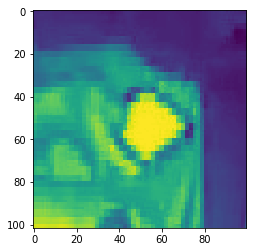

In [5]:
img = cv2.imread("mlp-training/cellphone-0.jpg",0)
plt.imshow(img)

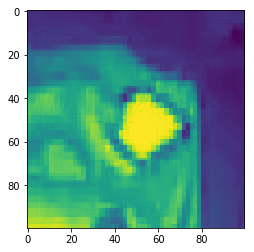

In [6]:
img2 = cv2.resize(img, (100,100))
plt.imshow(img2)
img2 = img2.flatten()


In [7]:
print (img2.shape)
img.shape

(10000,)


(102, 100)

In [11]:
imv_csv = pd.read_csv("mlp-training/csv/truck_driver.csv")
class_y = pd.get_dummies(imv_csv['class'], '').as_matrix()#將label做 one_hot encoding
x_train_list, y_train = imv_csv, class_y #資料切割

C:\Users\Yuga\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [12]:
tf.reset_default_graph()

In [13]:
#### define placeholder ####
input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img2.shape[0]],
                           name='input_data') #用來接 feature 資料進入 tensorflow 

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true') #用來接 label 資料進入 tensorflow 

In [14]:
#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 256, activation=tf.nn.sigmoid, name='hidden1') #第一層hidden layer
x2 = tf.layers.dense(x1, 128, activation=tf.nn.sigmoid, name='hidden2') #第二層hidden layer
x3 = tf.layers.dense(x2, 64, activation=tf.nn.sigmoid, name='hidden3')#第三層hidden layer
out = tf.layers.dense(x3, y_train.shape[1], name='output')# output layer

y_pred = out

In [15]:
#### calculate loss ####
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [16]:
#### optimize variables ####
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)

update = opt.minimize(loss)

In [17]:
#### init ####
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [18]:
tf.global_variables() ## 檢查 graph 裏的 global variables

[<tf.Variable 'hidden1/kernel:0' shape=(10000, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(64, 2) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(2,) dtype=float32_ref>]

# Load Models

In [19]:
'''rerun the graph first:
先回到上面將一開始和graph有關的cell先重新執行一遍，將graph架構先建立起來(這樣讀進來的參數才有對應位置存放)'''

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "mlp-training/saved_models/model-600.ckpt") #到我們剛剛存檔的路徑將檔案叫出來，放入graph中對應的參數位置

INFO:tensorflow:Restoring parameters from mlp-training/saved_models/model-600.ckpt


In [20]:
tf.global_variables()

[<tf.Variable 'hidden1/kernel:0' shape=(10000, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(64, 2) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(2,) dtype=float32_ref>]

# Test MLP

In [30]:

data_number = 1000
test_path = "../training/"
tmp = os.listdir(test_path)
dir_list = []
for i in range(len(tmp)):
    if 'jpg' in tmp[i]:
        dir_list.append(tmp[i])


total_result = [0,0,0,0]
for count in range(30):
    dic = {'normal_detect':0,'normal_undetect':0,'abnormal_detect':0,'abnormal_undetect':0}
    correct = 0
    for i in range(data_number):
        r = rd.randint(0,len(dir_list)-1)
        file = test_path + dir_list[r]
        #print(file)
        img4 = cv2.imread(file,0)
        img4 = cv2.resize(img4, (200,200))
        img4 = img4.flatten()
        test1 = np.array([]).reshape((0 ,img2.shape[0]))
        test1 = np.row_stack([test1, img4.flatten()])
        test1 /= 255.
        testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
        testy1 = np.row_stack([testy1, class_y[0]])
        tr_pred = sess.run([y_pred], feed_dict={
                    input_data:test1,
                })

        if tr_pred[0][0][1] < 0.95:
            if 'ab' in file:
                correct+=1
                print('data detected:', dir_list[r])
                dic['abnormal_detect']+=1
            else:
                print('data undetected:', dir_list[r])
                dic['normal_undetect']+=1
        else:
            if 'ab' not in file:
                correct+=1
                print('data detected:', dir_list[r])
                dic['normal_detect']+=1
            else:
                print('data undetected:', dir_list[r])
                dic['abnormal_undetect']+=1

    print('Correct:',correct,'/ Total:',data_number)
    print('Accuracy:', correct/data_number)
    print(dic)
    total_result[0]+= dic['normal_detect']
    total_result[1]+= dic['normal_undetect']
    total_result[2]+= dic['abnormal_detect']
    total_result[3]+= dic['abnormal_undetect']
dic['normal_detect'] = total_result[0]/30
dic['normal_undetect'] = total_result[1]/30
dic['abnormal_detect'] = total_result[2]/30
dic['abnormal_undetect'] = total_result[3]/30
print(dic)

data detected: normal_img_760.jpg
data detected: normal_img_6126.jpg
data detected: normal_img_2287.jpg
data detected: normal_img_6464.jpg
data detected: normal_img_4365.jpg
data detected: normal_img_6639.jpg
data detected: normal_img_6098.jpg
data detected: normal_img_4124.jpg
data detected: normal_img_4541.jpg
data detected: normal_img_3970.jpg
data detected: normal_img_6719.jpg
data detected: normal_img_634.jpg
data detected: normal_img_1839.jpg
data detected: normal_img_1104.jpg
data detected: normal_img_3112.jpg
data detected: normal_img_2001.jpg
data undetected: abnormal_img_648.jpg
data detected: normal_img_2565.jpg
data detected: abnormal_img_70.jpg
data detected: normal_img_4571.jpg
data detected: normal_img_1722.jpg
data detected: normal_img_3083.jpg
data detected: normal_img_3018.jpg
data detected: normal_img_3657.jpg
data detected: normal_img_2319.jpg
data detected: abnormal_img_530.jpg
data detected: normal_img_4691.jpg
data detected: normal_img_4311.jpg
data detected: nor

data detected: normal_img_2688.jpg
data detected: normal_img_5488.jpg
data detected: normal_img_5002.jpg
data detected: normal_img_2418.jpg
data detected: normal_img_5318.jpg
data detected: normal_img_5635.jpg
data detected: normal_img_3285.jpg
data detected: normal_img_2291.jpg
data detected: normal_img_5103.jpg
data detected: normal_img_5902.jpg
data detected: normal_img_1892.jpg
data detected: normal_img_3964.jpg
data detected: normal_img_6349.jpg
data detected: normal_img_910.jpg
data detected: normal_img_5034.jpg
data detected: normal_img_2762.jpg
data detected: normal_img_229.jpg
data detected: normal_img_3573.jpg
data detected: normal_img_4544.jpg
data detected: normal_img_1186.jpg
data detected: normal_img_6146.jpg
data detected: normal_img_3638.jpg
data detected: normal_img_5332.jpg
data detected: normal_img_4909.jpg
data detected: normal_img_4448.jpg
data detected: normal_img_1990.jpg
data detected: normal_img_728.jpg
data detected: normal_img_2949.jpg
data detected: normal_i

data detected: normal_img_3902.jpg
data detected: normal_img_414.jpg
data detected: normal_img_6448.jpg
data detected: normal_img_5750.jpg
data detected: normal_img_2480.jpg
data detected: normal_img_5191.jpg
data detected: normal_img_6107.jpg
data detected: normal_img_4603.jpg
data detected: normal_img_5190.jpg
data detected: normal_img_5547.jpg
data detected: normal_img_3722.jpg
data detected: normal_img_2697.jpg
data detected: normal_img_134.jpg
data detected: normal_img_3117.jpg
data detected: normal_img_2381.jpg
data detected: normal_img_2272.jpg
data detected: normal_img_1543.jpg
data detected: normal_img_3518.jpg
data detected: normal_img_2005.jpg
data detected: normal_img_6549.jpg
data detected: normal_img_356.jpg
data detected: abnormal_img_530.jpg
data detected: normal_img_5133.jpg
data detected: normal_img_3527.jpg
data detected: normal_img_1026.jpg
data detected: normal_img_5355.jpg
data detected: normal_img_2385.jpg
data detected: abnormal_img_477.jpg
data detected: normal

data detected: abnormal_img_65.jpg
data detected: normal_img_3121.jpg
data detected: normal_img_5439.jpg
data detected: normal_img_4726.jpg
data detected: normal_img_6531.jpg
data detected: normal_img_2124.jpg
data detected: abnormal_img_621.jpg
data detected: normal_img_1876.jpg
data detected: normal_img_890.jpg
data detected: normal_img_3306.jpg
data detected: abnormal_img_165.jpg
data detected: normal_img_5206.jpg
data detected: normal_img_2079.jpg
data detected: normal_img_3007.jpg
data detected: normal_img_2617.jpg
data detected: normal_img_2143.jpg
data detected: normal_img_6020.jpg
data detected: normal_img_3404.jpg
data detected: normal_img_3819.jpg
data detected: normal_img_5809.jpg
data detected: normal_img_3711.jpg
data detected: normal_img_6402.jpg
data detected: normal_img_3874.jpg
data detected: normal_img_3854.jpg
data detected: normal_img_3597.jpg
data detected: abnormal_img_18.jpg
data detected: normal_img_2186.jpg
data detected: normal_img_5033.jpg
data detected: norm

data detected: normal_img_2288.jpg
data detected: normal_img_1663.jpg
data detected: normal_img_5183.jpg
data detected: normal_img_2374.jpg
data detected: normal_img_631.jpg
data detected: normal_img_578.jpg
data detected: normal_img_4363.jpg
data detected: normal_img_5832.jpg
data detected: normal_img_411.jpg
data detected: normal_img_2990.jpg
data detected: normal_img_4046.jpg
data detected: normal_img_2282.jpg
data detected: normal_img_4005.jpg
data detected: normal_img_4418.jpg
data detected: abnormal_img_548.jpg
data detected: abnormal_img_133.jpg
data detected: normal_img_1626.jpg
data detected: normal_img_1193.jpg
data detected: normal_img_4507.jpg
data detected: normal_img_4663.jpg
data detected: normal_img_5946.jpg
data detected: normal_img_3649.jpg
data detected: normal_img_3738.jpg
data detected: normal_img_5598.jpg
data detected: normal_img_5702.jpg
data detected: normal_img_635.jpg
data detected: normal_img_5189.jpg
data detected: normal_img_4221.jpg
data detected: abnorma

data detected: normal_img_1649.jpg
data detected: normal_img_2440.jpg
data detected: normal_img_5388.jpg
data detected: normal_img_3229.jpg
data detected: normal_img_1220.jpg
data detected: normal_img_4467.jpg
data detected: normal_img_1610.jpg
data detected: normal_img_3137.jpg
data detected: normal_img_6185.jpg
data detected: normal_img_638.jpg
data detected: normal_img_5667.jpg
data detected: normal_img_6515.jpg
data detected: normal_img_4279.jpg
data detected: normal_img_3346.jpg
data detected: normal_img_2185.jpg
data detected: normal_img_3761.jpg
data detected: normal_img_5800.jpg
data detected: normal_img_5331.jpg
data detected: normal_img_3738.jpg
data detected: normal_img_4754.jpg
data detected: normal_img_3398.jpg
data detected: normal_img_1070.jpg
data detected: normal_img_1118.jpg
data detected: normal_img_6728.jpg
data detected: normal_img_6217.jpg
data detected: normal_img_2945.jpg
data detected: normal_img_1039.jpg
data detected: normal_img_4195.jpg
data detected: normal

data detected: normal_img_6515.jpg
data detected: normal_img_6609.jpg
data detected: normal_img_401.jpg
data detected: normal_img_757.jpg
data detected: normal_img_1903.jpg
data detected: normal_img_4893.jpg
data detected: normal_img_912.jpg
data detected: normal_img_319.jpg
data detected: normal_img_1047.jpg
data detected: normal_img_808.jpg
data detected: normal_img_3853.jpg
data detected: normal_img_5455.jpg
data detected: normal_img_1994.jpg
data detected: normal_img_693.jpg
data detected: normal_img_6324.jpg
data detected: normal_img_703.jpg
data detected: normal_img_5145.jpg
data detected: normal_img_5421.jpg
data detected: normal_img_3688.jpg
data detected: normal_img_6121.jpg
data detected: normal_img_1263.jpg
data detected: normal_img_1321.jpg
data detected: normal_img_6474.jpg
data detected: normal_img_2163.jpg
data detected: normal_img_5144.jpg
data detected: normal_img_5249.jpg
data detected: normal_img_707.jpg
data detected: normal_img_6389.jpg
data detected: normal_img_31

data detected: normal_img_3424.jpg
data detected: normal_img_1004.jpg
data detected: normal_img_2448.jpg
data detected: normal_img_4781.jpg
data detected: abnormal_img_162.jpg
data detected: normal_img_2246.jpg
data detected: normal_img_5090.jpg
data detected: normal_img_5379.jpg
data detected: normal_img_3840.jpg
data detected: normal_img_4894.jpg
data detected: normal_img_3998.jpg
data detected: normal_img_4600.jpg
data undetected: abnormal_img_269.jpg
data detected: normal_img_1451.jpg
data detected: normal_img_247.jpg
data detected: normal_img_1541.jpg
data detected: normal_img_715.jpg
data detected: normal_img_4628.jpg
data detected: normal_img_6657.jpg
data detected: normal_img_1999.jpg
data detected: normal_img_5420.jpg
data detected: abnormal_img_618.jpg
data detected: normal_img_2498.jpg
data detected: normal_img_2858.jpg
data detected: normal_img_2829.jpg
data detected: abnormal_img_5.jpg
data detected: normal_img_1429.jpg
data detected: normal_img_1691.jpg
data detected: nor

data detected: normal_img_346.jpg
data undetected: abnormal_img_269.jpg
data detected: normal_img_5606.jpg
data detected: normal_img_1602.jpg
data detected: normal_img_3050.jpg
data detected: normal_img_2643.jpg
data detected: normal_img_2842.jpg
data detected: normal_img_5009.jpg
data detected: normal_img_6321.jpg
data detected: normal_img_514.jpg
data detected: normal_img_5927.jpg
data detected: normal_img_6096.jpg
data detected: normal_img_5099.jpg
data detected: normal_img_4842.jpg
data detected: normal_img_3039.jpg
data detected: normal_img_3110.jpg
data detected: normal_img_836.jpg
data detected: normal_img_6318.jpg
data detected: normal_img_3207.jpg
data detected: normal_img_1180.jpg
data detected: abnormal_img_604.jpg
data detected: abnormal_img_521.jpg
data detected: normal_img_6417.jpg
data detected: normal_img_1778.jpg
data detected: normal_img_2539.jpg
data detected: normal_img_1509.jpg
data detected: normal_img_2515.jpg
data detected: normal_img_1995.jpg
data detected: nor

data detected: abnormal_img_564.jpg
data detected: normal_img_3727.jpg
data detected: normal_img_4779.jpg
data detected: normal_img_405.jpg
data detected: normal_img_4429.jpg
data detected: normal_img_2663.jpg
data detected: normal_img_3.jpg
data detected: normal_img_4972.jpg
data detected: normal_img_4269.jpg
data detected: normal_img_3388.jpg
data detected: normal_img_3821.jpg
data detected: normal_img_3114.jpg
data detected: normal_img_5391.jpg
data detected: normal_img_4359.jpg
data detected: normal_img_1562.jpg
data detected: normal_img_3745.jpg
data detected: normal_img_567.jpg
data detected: normal_img_272.jpg
data detected: normal_img_4354.jpg
data detected: normal_img_6282.jpg
data detected: normal_img_2991.jpg
data undetected: abnormal_img_285.jpg
data detected: normal_img_5156.jpg
data detected: normal_img_4731.jpg
data detected: normal_img_4070.jpg
data detected: normal_img_2468.jpg
data detected: normal_img_5149.jpg
data detected: normal_img_2764.jpg
data detected: normal_

data detected: normal_img_16.jpg
data detected: abnormal_img_581.jpg
data detected: normal_img_3175.jpg
data detected: normal_img_6733.jpg
data detected: normal_img_521.jpg
data detected: abnormal_img_150.jpg
data detected: normal_img_130.jpg
data detected: normal_img_2107.jpg
data detected: abnormal_img_67.jpg
data detected: normal_img_2232.jpg
data detected: normal_img_5447.jpg
data detected: normal_img_6673.jpg
data detected: normal_img_1003.jpg
data detected: normal_img_5081.jpg
data detected: abnormal_img_583.jpg
data detected: normal_img_638.jpg
data detected: normal_img_2559.jpg
data detected: normal_img_2663.jpg
data detected: abnormal_img_343.jpg
data detected: normal_img_3028.jpg
data detected: normal_img_312.jpg
data detected: normal_img_5681.jpg
data detected: normal_img_4744.jpg
data detected: normal_img_3010.jpg
data detected: normal_img_3252.jpg
data detected: normal_img_2425.jpg
data detected: normal_img_856.jpg
data detected: normal_img_3243.jpg
data detected: normal_i

data detected: normal_img_6522.jpg
data detected: normal_img_20.jpg
data detected: normal_img_1576.jpg
data detected: normal_img_4327.jpg
data detected: normal_img_2738.jpg
data detected: normal_img_82.jpg
data detected: normal_img_1997.jpg
data detected: normal_img_890.jpg
data detected: normal_img_5944.jpg
data detected: normal_img_5614.jpg
data detected: normal_img_4880.jpg
data detected: normal_img_3479.jpg
data detected: normal_img_1420.jpg
data undetected: abnormal_img_442.jpg
data detected: normal_img_4449.jpg
data detected: normal_img_1067.jpg
data detected: normal_img_5421.jpg
data detected: normal_img_939.jpg
data detected: normal_img_3343.jpg
data detected: normal_img_2597.jpg
data detected: normal_img_5946.jpg
data detected: normal_img_3330.jpg
data detected: normal_img_2724.jpg
data detected: normal_img_6784.jpg
data detected: normal_img_647.jpg
data detected: normal_img_3203.jpg
data detected: normal_img_4653.jpg
data detected: normal_img_256.jpg
data detected: abnormal_i

data detected: normal_img_2640.jpg
data detected: normal_img_2283.jpg
data detected: normal_img_3974.jpg
data detected: normal_img_1423.jpg
data detected: normal_img_3165.jpg
data detected: normal_img_301.jpg
data detected: normal_img_1039.jpg
data detected: normal_img_6706.jpg
data detected: normal_img_5114.jpg
data detected: normal_img_2989.jpg
data detected: normal_img_1658.jpg
data detected: normal_img_1647.jpg
data detected: normal_img_6280.jpg
data detected: normal_img_6755.jpg
data detected: normal_img_408.jpg
data detected: normal_img_5184.jpg
data detected: normal_img_4201.jpg
data detected: normal_img_76.jpg
data detected: normal_img_6116.jpg
data detected: normal_img_2397.jpg
data detected: abnormal_img_28.jpg
data detected: normal_img_6657.jpg
data detected: normal_img_4077.jpg
data detected: normal_img_6431.jpg
data detected: normal_img_550.jpg
data detected: normal_img_6090.jpg
data detected: normal_img_3399.jpg
data detected: normal_img_6317.jpg
data detected: normal_img

data detected: normal_img_395.jpg
data detected: normal_img_1482.jpg
data detected: normal_img_216.jpg
data undetected: abnormal_img_440.jpg
data detected: normal_img_3551.jpg
data detected: normal_img_2829.jpg
data detected: normal_img_1003.jpg
data detected: normal_img_4610.jpg
data detected: abnormal_img_44.jpg
data detected: abnormal_img_150.jpg
data detected: normal_img_3332.jpg
data detected: normal_img_5798.jpg
data detected: normal_img_3212.jpg
data detected: normal_img_4838.jpg
data detected: normal_img_5579.jpg
data detected: normal_img_1367.jpg
data detected: normal_img_1108.jpg
data detected: normal_img_898.jpg
data detected: normal_img_2407.jpg
data detected: normal_img_1749.jpg
data detected: normal_img_1356.jpg
data detected: abnormal_img_532.jpg
data detected: normal_img_2092.jpg
data detected: normal_img_4777.jpg
data detected: normal_img_5298.jpg
data undetected: abnormal_img_267.jpg
data detected: normal_img_2592.jpg
data detected: normal_img_864.jpg
data detected: n

data detected: normal_img_1687.jpg
data detected: normal_img_3646.jpg
data detected: normal_img_2174.jpg
data detected: normal_img_5560.jpg
data detected: normal_img_4406.jpg
data detected: normal_img_1549.jpg
data detected: normal_img_5963.jpg
data detected: normal_img_5218.jpg
data detected: normal_img_3263.jpg
data detected: normal_img_1261.jpg
data detected: normal_img_5250.jpg
data detected: normal_img_3127.jpg
data detected: normal_img_6103.jpg
data detected: normal_img_2846.jpg
data detected: normal_img_4370.jpg
data detected: normal_img_5065.jpg
data detected: normal_img_450.jpg
data detected: normal_img_4010.jpg
data detected: normal_img_5837.jpg
data detected: normal_img_1077.jpg
data detected: normal_img_4410.jpg
data detected: normal_img_4837.jpg
data detected: normal_img_3715.jpg
data detected: normal_img_3698.jpg
data detected: normal_img_2430.jpg
data detected: normal_img_6176.jpg
data detected: normal_img_6334.jpg
data detected: normal_img_4804.jpg
data detected: abnorm

data detected: normal_img_4898.jpg
data detected: normal_img_4938.jpg
data detected: normal_img_564.jpg
data detected: normal_img_4534.jpg
data detected: normal_img_1839.jpg
data detected: normal_img_4389.jpg
data detected: normal_img_3404.jpg
data detected: normal_img_6762.jpg
data detected: normal_img_4034.jpg
data detected: normal_img_4210.jpg
data detected: normal_img_5870.jpg
data detected: normal_img_3589.jpg
data detected: normal_img_4417.jpg
data detected: abnormal_img_138.jpg
data detected: normal_img_2779.jpg
data detected: normal_img_5403.jpg
data detected: normal_img_6399.jpg
data detected: normal_img_2271.jpg
data detected: normal_img_3862.jpg
data detected: normal_img_4865.jpg
data detected: normal_img_6177.jpg
data detected: normal_img_6728.jpg
data detected: normal_img_4883.jpg
data detected: normal_img_3262.jpg
data detected: normal_img_767.jpg
data detected: normal_img_695.jpg
data detected: normal_img_6280.jpg
data detected: normal_img_3566.jpg
data detected: normal_

data detected: normal_img_5427.jpg
data detected: normal_img_6120.jpg
data detected: normal_img_2270.jpg
data detected: normal_img_599.jpg
data detected: abnormal_img_588.jpg
data detected: normal_img_2866.jpg
data detected: normal_img_3629.jpg
data detected: normal_img_5876.jpg
data detected: abnormal_img_169.jpg
data undetected: abnormal_img_267.jpg
data detected: normal_img_5644.jpg
data detected: normal_img_6322.jpg
data detected: normal_img_1964.jpg
data detected: normal_img_5035.jpg
data detected: abnormal_img_115.jpg
data detected: normal_img_4228.jpg
data detected: normal_img_3913.jpg
data detected: normal_img_2214.jpg
data detected: abnormal_img_0.jpg
data detected: normal_img_5185.jpg
data detected: normal_img_6381.jpg
data detected: normal_img_2230.jpg
data detected: normal_img_2726.jpg
data detected: normal_img_6739.jpg
data detected: normal_img_1073.jpg
data detected: normal_img_2964.jpg
data detected: normal_img_3370.jpg
data detected: normal_img_1020.jpg
data detected: n

data detected: normal_img_4106.jpg
data detected: normal_img_4597.jpg
data detected: normal_img_4984.jpg
data detected: normal_img_5781.jpg
data detected: normal_img_702.jpg
data detected: normal_img_1200.jpg
data detected: normal_img_2582.jpg
data detected: normal_img_5758.jpg
data detected: normal_img_6603.jpg
data detected: normal_img_2772.jpg
data detected: normal_img_3791.jpg
data detected: normal_img_4287.jpg
data detected: normal_img_3948.jpg
data detected: normal_img_1610.jpg
data detected: abnormal_img_450.jpg
data detected: normal_img_709.jpg
data detected: normal_img_6277.jpg
data detected: abnormal_img_59.jpg
data detected: normal_img_5315.jpg
data detected: normal_img_4470.jpg
data detected: normal_img_3583.jpg
data detected: normal_img_440.jpg
data detected: normal_img_1090.jpg
data detected: normal_img_2114.jpg
data detected: normal_img_6670.jpg
data detected: normal_img_3574.jpg
data detected: normal_img_1889.jpg
data detected: normal_img_2989.jpg
data detected: normal_

data detected: normal_img_3418.jpg
data detected: normal_img_2714.jpg
data detected: abnormal_img_628.jpg
data detected: normal_img_1911.jpg
data detected: normal_img_6149.jpg
data detected: normal_img_921.jpg
data detected: normal_img_5314.jpg
data detected: normal_img_5108.jpg
data detected: normal_img_4004.jpg
data detected: normal_img_424.jpg
data detected: normal_img_599.jpg
data detected: normal_img_3073.jpg
data detected: normal_img_1595.jpg
data detected: normal_img_1521.jpg
data detected: abnormal_img_550.jpg
data detected: normal_img_5395.jpg
data detected: normal_img_5768.jpg
data detected: normal_img_3727.jpg
data detected: abnormal_img_459.jpg
data detected: normal_img_4195.jpg
data detected: normal_img_1969.jpg
data detected: normal_img_1997.jpg
data detected: normal_img_1055.jpg
data detected: normal_img_1242.jpg
data detected: abnormal_img_330.jpg
data detected: normal_img_6396.jpg
data detected: normal_img_5603.jpg
data detected: normal_img_2093.jpg
data detected: norm

data detected: normal_img_4878.jpg
data detected: abnormal_img_226.jpg
data detected: normal_img_5495.jpg
data detected: normal_img_4598.jpg
data detected: normal_img_3352.jpg
data detected: normal_img_5183.jpg
data detected: normal_img_5967.jpg
data detected: normal_img_2720.jpg
data detected: normal_img_2815.jpg
data detected: abnormal_img_374.jpg
data detected: normal_img_896.jpg
data detected: normal_img_6365.jpg
data detected: abnormal_img_11.jpg
data detected: normal_img_5545.jpg
data detected: normal_img_1936.jpg
data detected: normal_img_6457.jpg
data detected: normal_img_3318.jpg
data detected: normal_img_4851.jpg
data detected: normal_img_5463.jpg
data detected: normal_img_3645.jpg
data detected: normal_img_4610.jpg
data detected: normal_img_2075.jpg
data detected: normal_img_1696.jpg
data detected: normal_img_3402.jpg
data detected: normal_img_781.jpg
data detected: normal_img_1880.jpg
data detected: abnormal_img_80.jpg
data detected: normal_img_5570.jpg
data detected: norma

data detected: normal_img_2018.jpg
data detected: abnormal_img_190.jpg
data detected: normal_img_6602.jpg
data detected: normal_img_6309.jpg
data detected: normal_img_5849.jpg
data detected: normal_img_4890.jpg
data detected: normal_img_1362.jpg
data detected: normal_img_6680.jpg
data detected: normal_img_1651.jpg
data detected: normal_img_5189.jpg
data detected: normal_img_1716.jpg
data detected: abnormal_img_483.jpg
data detected: normal_img_2836.jpg
data detected: normal_img_929.jpg
data undetected: abnormal_img_641.jpg
data detected: normal_img_3221.jpg
data detected: normal_img_2685.jpg
data detected: normal_img_4298.jpg
data detected: normal_img_6347.jpg
data detected: normal_img_1174.jpg
data detected: normal_img_1815.jpg
data detected: normal_img_5021.jpg
data detected: normal_img_6499.jpg
data detected: normal_img_2066.jpg
data detected: normal_img_352.jpg
data detected: normal_img_4593.jpg
data detected: normal_img_811.jpg
data detected: normal_img_509.jpg
data detected: abno

data detected: normal_img_6590.jpg
data detected: normal_img_1787.jpg
data detected: normal_img_4024.jpg
data detected: normal_img_5193.jpg
data detected: normal_img_2856.jpg
data detected: normal_img_4658.jpg
data detected: normal_img_960.jpg
data detected: normal_img_4538.jpg
data detected: normal_img_678.jpg
data detected: normal_img_3919.jpg
data detected: normal_img_1650.jpg
data detected: normal_img_4935.jpg
data detected: normal_img_3021.jpg
data detected: normal_img_6320.jpg
data detected: normal_img_5014.jpg
data detected: normal_img_4933.jpg
data undetected: abnormal_img_313.jpg
data detected: normal_img_669.jpg
data detected: normal_img_2320.jpg
data detected: normal_img_5166.jpg
data detected: normal_img_112.jpg
data detected: normal_img_4515.jpg
data detected: abnormal_img_187.jpg
data detected: normal_img_5187.jpg
data detected: normal_img_3630.jpg
data detected: normal_img_4025.jpg
data detected: normal_img_645.jpg
data detected: normal_img_2099.jpg
data detected: normal

data detected: normal_img_3764.jpg
data detected: normal_img_2667.jpg
data detected: normal_img_999.jpg
data detected: normal_img_2827.jpg
data detected: normal_img_4672.jpg
data detected: normal_img_1460.jpg
data detected: normal_img_1613.jpg
data detected: normal_img_3235.jpg
data detected: normal_img_6126.jpg
data detected: normal_img_4045.jpg
data detected: normal_img_1333.jpg
data detected: normal_img_4526.jpg
data detected: normal_img_632.jpg
data detected: normal_img_5687.jpg
data detected: normal_img_5257.jpg
data detected: normal_img_1130.jpg
data detected: normal_img_3994.jpg
data detected: normal_img_1309.jpg
data detected: normal_img_5668.jpg
data detected: normal_img_1783.jpg
data detected: normal_img_4705.jpg
data detected: normal_img_2671.jpg
data detected: normal_img_4666.jpg
data detected: normal_img_6608.jpg
data undetected: abnormal_img_440.jpg
data detected: normal_img_4529.jpg
data detected: normal_img_6530.jpg
data detected: normal_img_5114.jpg
data detected: norm

data detected: normal_img_4003.jpg
data detected: normal_img_1009.jpg
data detected: normal_img_2732.jpg
data detected: normal_img_3531.jpg
data detected: normal_img_3046.jpg
data detected: normal_img_5940.jpg
data detected: normal_img_4340.jpg
data detected: normal_img_5314.jpg
data detected: normal_img_5990.jpg
data detected: normal_img_3532.jpg
data detected: normal_img_1367.jpg
data detected: normal_img_1247.jpg
data detected: normal_img_4986.jpg
data detected: normal_img_6405.jpg
data detected: normal_img_6047.jpg
data detected: normal_img_5673.jpg
data detected: normal_img_6397.jpg
data detected: abnormal_img_197.jpg
data detected: normal_img_1562.jpg
data detected: normal_img_279.jpg
data detected: normal_img_603.jpg
data detected: normal_img_4869.jpg
data detected: normal_img_350.jpg
data detected: normal_img_3513.jpg
data detected: normal_img_4809.jpg
data detected: normal_img_2248.jpg
data detected: normal_img_5953.jpg
data detected: normal_img_748.jpg
data detected: normal_i

data detected: normal_img_4316.jpg
data undetected: abnormal_img_416.jpg
data detected: normal_img_289.jpg
data detected: normal_img_6144.jpg
data detected: normal_img_2502.jpg
data detected: normal_img_915.jpg
data detected: normal_img_2148.jpg
data detected: normal_img_4192.jpg
data detected: normal_img_4932.jpg
data detected: normal_img_4420.jpg
data detected: abnormal_img_338.jpg
data detected: normal_img_5901.jpg
data detected: normal_img_6732.jpg
data detected: normal_img_1273.jpg
data detected: normal_img_5298.jpg
data detected: normal_img_1946.jpg
data detected: normal_img_4672.jpg
data detected: normal_img_619.jpg
data detected: normal_img_5376.jpg
data detected: normal_img_6231.jpg
data detected: normal_img_5158.jpg
data detected: normal_img_6398.jpg
data undetected: abnormal_img_248.jpg
data detected: normal_img_2969.jpg
data detected: normal_img_1822.jpg
data detected: normal_img_5345.jpg
data detected: normal_img_1761.jpg
data detected: normal_img_5055.jpg
data detected: n

data detected: normal_img_2659.jpg
data detected: normal_img_5008.jpg
data detected: normal_img_647.jpg
data detected: normal_img_6501.jpg
data detected: normal_img_5160.jpg
data detected: normal_img_4561.jpg
data detected: normal_img_469.jpg
data detected: normal_img_622.jpg
data detected: normal_img_1268.jpg
data detected: normal_img_4422.jpg
data detected: normal_img_3287.jpg
data detected: normal_img_1920.jpg
data detected: normal_img_2675.jpg
data detected: normal_img_4887.jpg
data detected: normal_img_4120.jpg
data detected: normal_img_4462.jpg
data detected: normal_img_3908.jpg
data detected: abnormal_img_23.jpg
data detected: normal_img_245.jpg
data detected: normal_img_3055.jpg
data detected: normal_img_1441.jpg
data detected: abnormal_img_538.jpg
data detected: normal_img_14.jpg
data detected: normal_img_114.jpg
data detected: normal_img_5417.jpg
data detected: normal_img_326.jpg
data detected: normal_img_6096.jpg
data detected: normal_img_2219.jpg
data detected: normal_img_9

data detected: normal_img_4319.jpg
data detected: normal_img_2640.jpg
data detected: normal_img_4459.jpg
data detected: normal_img_426.jpg
data detected: normal_img_2419.jpg
data detected: normal_img_4253.jpg
data detected: normal_img_2998.jpg
data detected: normal_img_1788.jpg
data detected: normal_img_313.jpg
data detected: normal_img_2202.jpg
data undetected: abnormal_img_245.jpg
data detected: normal_img_5833.jpg
data detected: normal_img_4097.jpg
data detected: normal_img_5294.jpg
data detected: normal_img_5564.jpg
data detected: normal_img_53.jpg
data detected: normal_img_167.jpg
data detected: normal_img_4470.jpg
data detected: normal_img_1712.jpg
data detected: normal_img_116.jpg
data detected: abnormal_img_217.jpg
data detected: normal_img_987.jpg
data detected: normal_img_6259.jpg
data detected: normal_img_967.jpg
data detected: normal_img_1400.jpg
data detected: normal_img_5630.jpg
data detected: normal_img_2204.jpg
data detected: normal_img_973.jpg
data detected: normal_img

data detected: normal_img_494.jpg
data detected: normal_img_6727.jpg
data detected: normal_img_6134.jpg
data detected: normal_img_5192.jpg
data detected: normal_img_4292.jpg
data detected: normal_img_4068.jpg
data detected: normal_img_836.jpg
data detected: normal_img_2540.jpg
data detected: normal_img_4906.jpg
data detected: normal_img_6499.jpg
data detected: normal_img_710.jpg
data detected: normal_img_576.jpg
data detected: normal_img_4661.jpg
data detected: normal_img_259.jpg
data detected: normal_img_4141.jpg
data detected: normal_img_4230.jpg
data detected: normal_img_1627.jpg
data detected: abnormal_img_492.jpg
data detected: normal_img_4329.jpg
data detected: normal_img_2318.jpg
data detected: normal_img_2388.jpg
data detected: normal_img_6247.jpg
data undetected: abnormal_img_413.jpg
data detected: normal_img_6206.jpg
data detected: normal_img_7.jpg
data detected: normal_img_2996.jpg
data detected: normal_img_6440.jpg
data detected: normal_img_179.jpg
data detected: normal_img

data detected: normal_img_1500.jpg
data detected: normal_img_4269.jpg
data detected: normal_img_4228.jpg
data detected: normal_img_4810.jpg
data detected: normal_img_4590.jpg
data detected: normal_img_1946.jpg
data detected: abnormal_img_63.jpg
data detected: normal_img_5487.jpg
data detected: normal_img_4006.jpg
data detected: normal_img_3596.jpg
data detected: normal_img_5545.jpg
data detected: normal_img_5491.jpg
data detected: normal_img_3850.jpg
data detected: normal_img_4566.jpg
data detected: normal_img_3408.jpg
data detected: normal_img_3580.jpg
data detected: normal_img_1391.jpg
data detected: normal_img_5187.jpg
data detected: normal_img_4550.jpg
data detected: normal_img_5347.jpg
data detected: normal_img_4196.jpg
data detected: normal_img_1156.jpg
data detected: normal_img_3108.jpg
data detected: normal_img_2225.jpg
data detected: normal_img_6665.jpg
data detected: normal_img_4011.jpg
data detected: normal_img_1790.jpg
data detected: normal_img_3170.jpg
data detected: norma

data detected: normal_img_3824.jpg
data detected: normal_img_61.jpg
data detected: normal_img_4573.jpg
data detected: normal_img_4990.jpg
data detected: normal_img_2683.jpg
data detected: normal_img_6735.jpg
data detected: normal_img_3957.jpg
data detected: normal_img_5913.jpg
data detected: normal_img_2240.jpg
data detected: normal_img_3210.jpg
data detected: normal_img_324.jpg
data detected: normal_img_4394.jpg
data detected: normal_img_6671.jpg
data detected: normal_img_2055.jpg
data detected: normal_img_1685.jpg
data detected: normal_img_1947.jpg
data detected: normal_img_6022.jpg
data detected: normal_img_3357.jpg
data detected: normal_img_851.jpg
data detected: normal_img_3397.jpg
data detected: normal_img_1815.jpg
data detected: normal_img_3840.jpg
data detected: normal_img_5423.jpg
data detected: abnormal_img_167.jpg
data detected: normal_img_95.jpg
data detected: normal_img_3671.jpg
data detected: normal_img_5137.jpg
data detected: normal_img_4923.jpg
data detected: normal_img

data detected: normal_img_746.jpg
data detected: normal_img_1179.jpg
data detected: normal_img_252.jpg
data detected: normal_img_896.jpg
data detected: normal_img_4236.jpg
data detected: normal_img_5775.jpg
data detected: abnormal_img_512.jpg
data detected: normal_img_6182.jpg
data detected: normal_img_2873.jpg
data detected: normal_img_173.jpg
data detected: normal_img_525.jpg
data detected: normal_img_2080.jpg
data detected: normal_img_997.jpg
data detected: normal_img_3800.jpg
data detected: normal_img_212.jpg
data detected: normal_img_5700.jpg
data detected: normal_img_1091.jpg
data detected: normal_img_3861.jpg
data detected: normal_img_733.jpg
data detected: normal_img_6400.jpg
data detected: normal_img_3499.jpg
data detected: normal_img_815.jpg
data detected: normal_img_6128.jpg
data detected: normal_img_2015.jpg
data detected: normal_img_5247.jpg
data detected: normal_img_1013.jpg
data detected: normal_img_4909.jpg
data detected: abnormal_img_22.jpg
data detected: normal_img_24

data detected: normal_img_4033.jpg
data detected: normal_img_2277.jpg
data detected: normal_img_4574.jpg
data detected: normal_img_3656.jpg
data detected: normal_img_3008.jpg
data detected: normal_img_2304.jpg
data detected: normal_img_3430.jpg
data detected: normal_img_1742.jpg
data detected: normal_img_2801.jpg
data detected: normal_img_4855.jpg
data detected: normal_img_6089.jpg
data detected: normal_img_2868.jpg
data detected: normal_img_5046.jpg
data detected: normal_img_5388.jpg
data detected: normal_img_678.jpg
data detected: normal_img_470.jpg
data detected: normal_img_3647.jpg
data detected: normal_img_6518.jpg
data detected: normal_img_3679.jpg
data detected: normal_img_1342.jpg
data detected: normal_img_5487.jpg
data detected: normal_img_1164.jpg
data detected: abnormal_img_613.jpg
data detected: normal_img_591.jpg
data detected: normal_img_3454.jpg
data detected: normal_img_3974.jpg
data detected: normal_img_4956.jpg
data detected: normal_img_2795.jpg
data detected: abnorma

data detected: normal_img_2495.jpg
data detected: abnormal_img_615.jpg
data detected: normal_img_525.jpg
data detected: normal_img_1334.jpg
data detected: normal_img_1545.jpg
data detected: normal_img_5986.jpg
data detected: normal_img_6754.jpg
data detected: normal_img_2111.jpg
data detected: normal_img_2866.jpg
data detected: normal_img_4798.jpg
data detected: normal_img_451.jpg
data detected: normal_img_4861.jpg
data detected: normal_img_6684.jpg
data detected: abnormal_img_236.jpg
data detected: normal_img_1856.jpg
data detected: normal_img_794.jpg
data detected: normal_img_2252.jpg
data detected: normal_img_5462.jpg
data detected: normal_img_5427.jpg
data detected: normal_img_3485.jpg
data detected: normal_img_3347.jpg
data detected: normal_img_4024.jpg
data detected: normal_img_1188.jpg
data detected: normal_img_5688.jpg
data detected: normal_img_1772.jpg
data detected: normal_img_2365.jpg
data detected: normal_img_2081.jpg
data detected: normal_img_1979.jpg
data detected: normal

data detected: normal_img_5353.jpg
data detected: normal_img_3744.jpg
data detected: normal_img_799.jpg
data detected: abnormal_img_241.jpg
data detected: normal_img_5394.jpg
data detected: normal_img_476.jpg
data detected: abnormal_img_531.jpg
data detected: normal_img_618.jpg
data detected: abnormal_img_577.jpg
data detected: normal_img_425.jpg
data detected: normal_img_5656.jpg
data detected: normal_img_513.jpg
data detected: normal_img_1800.jpg
data detected: normal_img_6203.jpg
data detected: normal_img_6356.jpg
data detected: normal_img_1733.jpg
data detected: normal_img_5054.jpg
data detected: normal_img_424.jpg
data detected: normal_img_5894.jpg
data detected: normal_img_1776.jpg
data detected: normal_img_1550.jpg
data detected: normal_img_5434.jpg
data detected: normal_img_4011.jpg
data detected: normal_img_5106.jpg
data detected: normal_img_2629.jpg
data detected: abnormal_img_563.jpg
data detected: normal_img_2198.jpg
data detected: normal_img_6747.jpg
data detected: normal_

data detected: normal_img_4967.jpg
data detected: normal_img_4592.jpg
data detected: normal_img_5852.jpg
data detected: normal_img_177.jpg
data detected: normal_img_249.jpg
data detected: normal_img_1774.jpg
data detected: normal_img_5435.jpg
data detected: normal_img_6594.jpg
data detected: normal_img_1900.jpg
data detected: normal_img_1019.jpg
data detected: normal_img_4610.jpg
data detected: normal_img_2432.jpg
data detected: normal_img_5203.jpg
data detected: normal_img_2835.jpg
data detected: normal_img_951.jpg
data detected: normal_img_5088.jpg
data detected: normal_img_5944.jpg
data detected: normal_img_123.jpg
data detected: normal_img_2355.jpg
data detected: abnormal_img_621.jpg
data detected: normal_img_4860.jpg
data detected: normal_img_6627.jpg
data detected: normal_img_2308.jpg
data detected: normal_img_4286.jpg
data detected: normal_img_4862.jpg
data detected: normal_img_5955.jpg
data detected: normal_img_3685.jpg
data detected: abnormal_img_108.jpg
data detected: normal_

data detected: normal_img_5248.jpg
data detected: normal_img_6707.jpg
data detected: normal_img_5682.jpg
data detected: normal_img_2815.jpg
data detected: normal_img_5556.jpg
data detected: normal_img_1644.jpg
data detected: normal_img_1724.jpg
data detected: normal_img_6043.jpg
data detected: abnormal_img_544.jpg
data detected: normal_img_256.jpg
data detected: normal_img_5189.jpg
data detected: normal_img_493.jpg
data detected: normal_img_970.jpg
data detected: normal_img_2064.jpg
data detected: normal_img_954.jpg
data detected: normal_img_2672.jpg
data detected: normal_img_2107.jpg
data detected: normal_img_6584.jpg
data detected: normal_img_6002.jpg
data detected: normal_img_1103.jpg
data detected: normal_img_2814.jpg
data detected: normal_img_5391.jpg
data detected: abnormal_img_363.jpg
data detected: normal_img_6191.jpg
data detected: normal_img_876.jpg
data detected: normal_img_1308.jpg
data detected: normal_img_6461.jpg
data detected: normal_img_6223.jpg
data detected: abnormal

data undetected: abnormal_img_421.jpg
data detected: normal_img_3265.jpg
data detected: normal_img_296.jpg
data detected: normal_img_1732.jpg
data detected: normal_img_2896.jpg
data detected: normal_img_5838.jpg
data detected: normal_img_3389.jpg
data detected: normal_img_1552.jpg
data detected: abnormal_img_451.jpg
data detected: abnormal_img_182.jpg
data detected: normal_img_1641.jpg
data detected: normal_img_6342.jpg
data detected: abnormal_img_18.jpg
data detected: normal_img_5677.jpg
data detected: normal_img_1770.jpg
data detected: normal_img_6520.jpg
data detected: normal_img_2485.jpg
data detected: normal_img_1627.jpg
data detected: normal_img_6205.jpg
data detected: abnormal_img_632.jpg
data detected: normal_img_3454.jpg
data detected: normal_img_1288.jpg
data detected: normal_img_1810.jpg
data detected: abnormal_img_502.jpg
data detected: normal_img_5175.jpg
data detected: normal_img_971.jpg
data detected: normal_img_6056.jpg
data detected: normal_img_3931.jpg
data detected: 

data detected: normal_img_2816.jpg
data detected: normal_img_5483.jpg
data detected: normal_img_3937.jpg
data detected: normal_img_1188.jpg
data detected: normal_img_297.jpg
data detected: normal_img_1392.jpg
data detected: normal_img_4805.jpg
data detected: normal_img_742.jpg
data detected: normal_img_2355.jpg
data detected: normal_img_5089.jpg
data detected: normal_img_367.jpg
data detected: normal_img_3529.jpg
data detected: normal_img_2108.jpg
data detected: normal_img_4730.jpg
data detected: normal_img_3713.jpg
data detected: normal_img_3370.jpg
data detected: normal_img_737.jpg
data detected: normal_img_618.jpg
data detected: normal_img_6449.jpg
data detected: normal_img_3128.jpg
data detected: normal_img_3173.jpg
data detected: normal_img_5439.jpg
data detected: normal_img_2440.jpg
data detected: normal_img_3452.jpg
data detected: normal_img_878.jpg
data detected: normal_img_4510.jpg
data detected: normal_img_6757.jpg
data detected: normal_img_4147.jpg
data detected: normal_img_

data detected: abnormal_img_220.jpg
data detected: normal_img_2272.jpg
data detected: normal_img_4803.jpg
data detected: normal_img_6054.jpg
data detected: normal_img_1078.jpg
data detected: normal_img_4899.jpg
data detected: normal_img_5988.jpg
data detected: normal_img_4082.jpg
data detected: normal_img_5612.jpg
data detected: normal_img_1631.jpg
data detected: normal_img_6481.jpg
data detected: normal_img_3823.jpg
data detected: abnormal_img_43.jpg
data detected: normal_img_3769.jpg
data detected: normal_img_5046.jpg
data detected: normal_img_2578.jpg
data detected: normal_img_6432.jpg
data detected: normal_img_2124.jpg
data detected: normal_img_2155.jpg
data detected: abnormal_img_25.jpg
data detected: normal_img_3592.jpg
data detected: normal_img_6539.jpg
data detected: normal_img_3999.jpg
data detected: normal_img_6575.jpg
data detected: normal_img_4151.jpg
data detected: normal_img_1396.jpg
data detected: normal_img_1720.jpg
data detected: normal_img_354.jpg
data detected: norma

data detected: normal_img_2522.jpg
data detected: normal_img_6516.jpg
data detected: normal_img_2051.jpg
data detected: normal_img_3052.jpg
data detected: normal_img_4652.jpg
data detected: normal_img_3129.jpg
data detected: normal_img_3567.jpg
data detected: normal_img_5374.jpg
data detected: abnormal_img_205.jpg
data detected: normal_img_5784.jpg
data detected: abnormal_img_524.jpg
data detected: normal_img_2146.jpg
data detected: normal_img_956.jpg
data detected: normal_img_2257.jpg
data detected: normal_img_3882.jpg
data detected: normal_img_1343.jpg
data detected: normal_img_6656.jpg
data detected: normal_img_4298.jpg
data detected: normal_img_5910.jpg
data detected: normal_img_2165.jpg
data detected: normal_img_5656.jpg
data detected: normal_img_5456.jpg
data detected: normal_img_6749.jpg
data detected: normal_img_393.jpg
data detected: normal_img_6430.jpg
data detected: abnormal_img_569.jpg
data detected: normal_img_4010.jpg
data detected: normal_img_3420.jpg
data detected: norm

data detected: normal_img_2866.jpg
data detected: normal_img_49.jpg
data detected: normal_img_6633.jpg
data detected: normal_img_4005.jpg
data detected: normal_img_4499.jpg
data detected: normal_img_4600.jpg
data detected: normal_img_3179.jpg
data detected: normal_img_938.jpg
data detected: normal_img_6126.jpg
data detected: normal_img_1355.jpg
data detected: normal_img_5501.jpg
data undetected: abnormal_img_402.jpg
data detected: normal_img_6703.jpg
data detected: normal_img_5306.jpg
data detected: normal_img_2850.jpg
data detected: normal_img_3421.jpg
data detected: normal_img_4332.jpg
data detected: normal_img_2936.jpg
data detected: normal_img_5311.jpg
data detected: normal_img_4215.jpg
data detected: abnormal_img_56.jpg
data detected: normal_img_4983.jpg
data detected: normal_img_923.jpg
data detected: normal_img_772.jpg
data detected: normal_img_6241.jpg
data detected: normal_img_5365.jpg
data detected: normal_img_673.jpg
data detected: normal_img_1436.jpg
data detected: normal_i

data detected: normal_img_2049.jpg
data detected: normal_img_1167.jpg
data detected: normal_img_4766.jpg
data detected: abnormal_img_614.jpg
data detected: normal_img_50.jpg
data detected: normal_img_2157.jpg
data detected: normal_img_3314.jpg
data detected: normal_img_1137.jpg
data undetected: abnormal_img_258.jpg
data detected: normal_img_4080.jpg
data detected: normal_img_1474.jpg
data detected: normal_img_212.jpg
data detected: normal_img_3788.jpg
data detected: normal_img_5758.jpg
data detected: normal_img_3050.jpg
data detected: normal_img_1386.jpg
data detected: normal_img_5255.jpg
data detected: normal_img_985.jpg
data detected: normal_img_6110.jpg
data detected: normal_img_5737.jpg
data detected: normal_img_127.jpg
data detected: abnormal_img_617.jpg
data detected: normal_img_2989.jpg
data detected: normal_img_4498.jpg
data detected: normal_img_6174.jpg
data detected: normal_img_6166.jpg
data detected: normal_img_72.jpg
data detected: normal_img_1274.jpg
data detected: normal_

data detected: normal_img_5159.jpg
data detected: normal_img_1668.jpg
data detected: normal_img_4050.jpg
data detected: abnormal_img_67.jpg
data detected: normal_img_2333.jpg
data detected: normal_img_4389.jpg
data detected: normal_img_1095.jpg
data detected: normal_img_1717.jpg
data detected: normal_img_6549.jpg
data detected: normal_img_5798.jpg
data detected: normal_img_5759.jpg
data detected: normal_img_6781.jpg
data detected: normal_img_3848.jpg
data detected: abnormal_img_573.jpg
data detected: normal_img_3598.jpg
data detected: normal_img_3629.jpg
data detected: normal_img_1671.jpg
data detected: normal_img_3366.jpg
data detected: normal_img_3988.jpg
data detected: normal_img_6474.jpg
data detected: normal_img_5325.jpg
data detected: normal_img_5100.jpg
data detected: normal_img_2596.jpg
data detected: normal_img_715.jpg
data detected: normal_img_6570.jpg
data detected: normal_img_1990.jpg
data detected: normal_img_3665.jpg
data detected: normal_img_878.jpg
data detected: normal

data detected: normal_img_1538.jpg
data detected: normal_img_3432.jpg
data detected: normal_img_323.jpg
data undetected: abnormal_img_643.jpg
data detected: normal_img_4790.jpg
data detected: normal_img_3913.jpg
data detected: normal_img_1036.jpg
data detected: normal_img_1363.jpg
data detected: normal_img_4474.jpg
data detected: normal_img_6783.jpg
data detected: normal_img_6442.jpg
data detected: normal_img_6283.jpg
data detected: normal_img_2657.jpg
data detected: normal_img_1512.jpg
data detected: normal_img_2329.jpg
data undetected: abnormal_img_423.jpg
data detected: normal_img_4647.jpg
data detected: normal_img_3475.jpg
data detected: abnormal_img_632.jpg
data detected: normal_img_6201.jpg
data detected: normal_img_2136.jpg
data detected: normal_img_743.jpg
data detected: normal_img_1522.jpg
data detected: normal_img_3777.jpg
data detected: normal_img_1179.jpg
data detected: normal_img_5595.jpg
data detected: normal_img_1730.jpg
data detected: normal_img_1439.jpg
data detected: 

data undetected: abnormal_img_265.jpg
data detected: normal_img_3598.jpg
data detected: normal_img_703.jpg
data detected: normal_img_5452.jpg
data detected: normal_img_4010.jpg
data detected: normal_img_5027.jpg
data detected: normal_img_5129.jpg
data detected: normal_img_2179.jpg
data detected: normal_img_538.jpg
data detected: normal_img_103.jpg
data detected: normal_img_1659.jpg
data detected: normal_img_690.jpg
data detected: normal_img_1290.jpg
data detected: normal_img_1660.jpg
data detected: normal_img_6323.jpg
data detected: normal_img_42.jpg
data detected: normal_img_2741.jpg
data detected: normal_img_5241.jpg
data detected: normal_img_5629.jpg
data detected: normal_img_4115.jpg
data detected: abnormal_img_342.jpg
data detected: normal_img_1429.jpg
data detected: normal_img_3965.jpg
data detected: normal_img_2498.jpg
data detected: normal_img_6120.jpg
data detected: normal_img_3035.jpg
data detected: normal_img_1622.jpg
data detected: normal_img_1023.jpg
data detected: normal_

data detected: normal_img_150.jpg
data detected: abnormal_img_174.jpg
data detected: normal_img_6422.jpg
data detected: normal_img_652.jpg
data detected: normal_img_6493.jpg
data detected: normal_img_1015.jpg
data detected: normal_img_2054.jpg
data detected: normal_img_5851.jpg
data detected: normal_img_3419.jpg
data detected: normal_img_4543.jpg
data detected: normal_img_1905.jpg
data detected: normal_img_6607.jpg
data detected: normal_img_4116.jpg
data detected: normal_img_4647.jpg
data detected: abnormal_img_154.jpg
data detected: normal_img_3818.jpg
data detected: normal_img_4633.jpg
data detected: normal_img_1083.jpg
data detected: normal_img_4114.jpg
data detected: normal_img_1058.jpg
data detected: normal_img_1394.jpg
data detected: abnormal_img_221.jpg
data detected: normal_img_4371.jpg
data detected: abnormal_img_98.jpg
data detected: normal_img_2854.jpg
data detected: normal_img_4747.jpg
data detected: normal_img_4081.jpg
data detected: normal_img_3903.jpg
data detected: norm

data detected: normal_img_1046.jpg
data detected: normal_img_1402.jpg
data detected: normal_img_679.jpg
data detected: normal_img_6737.jpg
data detected: normal_img_4899.jpg
data detected: normal_img_4327.jpg
data detected: normal_img_3246.jpg
data detected: normal_img_3233.jpg
data detected: normal_img_438.jpg
data detected: normal_img_4458.jpg
data detected: normal_img_2397.jpg
data detected: normal_img_5502.jpg
data detected: normal_img_308.jpg
data detected: normal_img_3384.jpg
data detected: normal_img_5528.jpg
data detected: normal_img_1969.jpg
data detected: normal_img_4007.jpg
data detected: abnormal_img_546.jpg
data detected: normal_img_111.jpg
data detected: normal_img_4870.jpg
data detected: normal_img_2768.jpg
data detected: normal_img_5847.jpg
data detected: normal_img_5767.jpg
data detected: normal_img_3905.jpg
data detected: normal_img_6589.jpg
data detected: abnormal_img_613.jpg
data detected: normal_img_5442.jpg
data detected: normal_img_3780.jpg
data detected: normal_

data detected: normal_img_6312.jpg
data detected: abnormal_img_363.jpg
data detected: abnormal_img_130.jpg
data detected: normal_img_4012.jpg
data detected: normal_img_359.jpg
data detected: normal_img_5305.jpg
data detected: normal_img_6203.jpg
data detected: abnormal_img_472.jpg
data detected: normal_img_2533.jpg
data detected: normal_img_2522.jpg
data detected: normal_img_470.jpg
data detected: normal_img_3078.jpg
data detected: normal_img_103.jpg
data detected: normal_img_6689.jpg
data detected: normal_img_4810.jpg
data detected: normal_img_4564.jpg
data detected: normal_img_4520.jpg
data detected: normal_img_706.jpg
data detected: abnormal_img_506.jpg
data detected: abnormal_img_369.jpg
data detected: abnormal_img_342.jpg
data detected: normal_img_874.jpg
data detected: normal_img_6000.jpg
data detected: normal_img_4830.jpg
data detected: normal_img_3845.jpg
data detected: normal_img_959.jpg
data detected: normal_img_5733.jpg
data detected: normal_img_4310.jpg
data detected: norma

data detected: normal_img_5047.jpg
data detected: normal_img_5838.jpg
data detected: normal_img_4813.jpg
data detected: normal_img_2673.jpg
data detected: normal_img_1665.jpg
data detected: normal_img_3440.jpg
data detected: normal_img_4318.jpg
data detected: normal_img_5411.jpg
data detected: normal_img_5368.jpg
data detected: normal_img_2845.jpg
data detected: normal_img_66.jpg
data detected: normal_img_6273.jpg
data detected: normal_img_4008.jpg
data detected: normal_img_3398.jpg
data detected: normal_img_1614.jpg
data detected: normal_img_4979.jpg
data detected: normal_img_4328.jpg
data detected: normal_img_4360.jpg
data detected: normal_img_3814.jpg
data detected: abnormal_img_539.jpg
data detected: normal_img_4756.jpg
data detected: normal_img_2135.jpg
data detected: normal_img_6694.jpg
data detected: normal_img_3727.jpg
data detected: normal_img_2152.jpg
data detected: normal_img_5666.jpg
data detected: normal_img_5654.jpg
data detected: normal_img_5724.jpg
data detected: abnorm

data detected: normal_img_5156.jpg
data detected: normal_img_4413.jpg
data detected: normal_img_4467.jpg
data detected: normal_img_6451.jpg
data detected: normal_img_1329.jpg
data detected: normal_img_1892.jpg
data detected: normal_img_4919.jpg
data detected: normal_img_5129.jpg
data detected: normal_img_5568.jpg
data detected: normal_img_5742.jpg
data detected: normal_img_2845.jpg
data detected: normal_img_95.jpg
data detected: normal_img_728.jpg
data detected: normal_img_2711.jpg
data detected: normal_img_3181.jpg
data detected: normal_img_1520.jpg
data detected: abnormal_img_535.jpg
data detected: normal_img_4700.jpg
data detected: normal_img_3558.jpg
data detected: normal_img_2271.jpg
data detected: normal_img_176.jpg
data detected: normal_img_2043.jpg
data detected: normal_img_5709.jpg
data detected: normal_img_4752.jpg
data detected: normal_img_6036.jpg
data detected: normal_img_1643.jpg
data detected: normal_img_735.jpg
data detected: normal_img_3680.jpg
data detected: normal_im

data detected: normal_img_5558.jpg
data detected: abnormal_img_113.jpg
data detected: normal_img_2563.jpg
data detected: normal_img_4710.jpg
data detected: normal_img_3859.jpg
data detected: normal_img_4884.jpg
data detected: normal_img_4773.jpg
data detected: normal_img_3370.jpg
data detected: normal_img_4009.jpg
data detected: normal_img_2508.jpg
data detected: normal_img_4279.jpg
data detected: abnormal_img_236.jpg
data detected: normal_img_3172.jpg
data detected: abnormal_img_193.jpg
data detected: normal_img_475.jpg
data detected: normal_img_1930.jpg
data detected: normal_img_3221.jpg
data detected: normal_img_6634.jpg
data detected: normal_img_3915.jpg
data detected: normal_img_438.jpg
data detected: normal_img_3010.jpg
data detected: normal_img_4423.jpg
data detected: normal_img_4431.jpg
data undetected: abnormal_img_281.jpg
data detected: normal_img_6530.jpg
data detected: normal_img_6555.jpg
data detected: normal_img_5916.jpg
data detected: normal_img_1853.jpg
data detected: n

data detected: normal_img_6800.jpg
data detected: normal_img_2471.jpg
data detected: normal_img_5953.jpg
data detected: abnormal_img_622.jpg
data detected: normal_img_376.jpg
data detected: normal_img_3545.jpg
data detected: normal_img_3242.jpg
data detected: normal_img_623.jpg
data detected: normal_img_5363.jpg
data detected: normal_img_5042.jpg
data detected: normal_img_790.jpg
data detected: abnormal_img_150.jpg
data detected: normal_img_5390.jpg
data detected: normal_img_2652.jpg
data detected: normal_img_2011.jpg
data detected: normal_img_4171.jpg
data detected: normal_img_2197.jpg
data detected: normal_img_5186.jpg
data detected: normal_img_5547.jpg
data detected: abnormal_img_113.jpg
data detected: normal_img_1971.jpg
data detected: normal_img_1010.jpg
data detected: normal_img_3001.jpg
data detected: normal_img_6767.jpg
data detected: normal_img_4918.jpg
data detected: normal_img_4026.jpg
data detected: normal_img_6333.jpg
data detected: normal_img_4923.jpg
data detected: norma

data detected: normal_img_4201.jpg
data detected: normal_img_6251.jpg
data detected: abnormal_img_152.jpg
data detected: normal_img_316.jpg
data detected: normal_img_2379.jpg
data detected: normal_img_5172.jpg
data detected: normal_img_3662.jpg
data detected: normal_img_3674.jpg
data detected: normal_img_466.jpg
data detected: normal_img_1076.jpg
data detected: normal_img_6002.jpg
data detected: normal_img_3606.jpg
data detected: normal_img_4188.jpg
data detected: normal_img_6629.jpg
data detected: normal_img_853.jpg
data detected: normal_img_1125.jpg
data detected: normal_img_4283.jpg
data detected: normal_img_3542.jpg
data detected: normal_img_6427.jpg
data detected: normal_img_821.jpg
data detected: normal_img_5735.jpg
data detected: normal_img_321.jpg
data detected: normal_img_5922.jpg
data detected: normal_img_3253.jpg
data detected: normal_img_4602.jpg
data detected: normal_img_5410.jpg
data detected: normal_img_5384.jpg
data undetected: abnormal_img_437.jpg
data detected: normal

data detected: normal_img_1539.jpg
data detected: normal_img_86.jpg
data detected: normal_img_6693.jpg
data detected: normal_img_2924.jpg
data detected: normal_img_6050.jpg
data detected: normal_img_5584.jpg
data detected: normal_img_5357.jpg
data detected: normal_img_4180.jpg
data detected: normal_img_6211.jpg
data detected: normal_img_6456.jpg
data detected: normal_img_3323.jpg
data detected: normal_img_3576.jpg
data detected: normal_img_3919.jpg
data detected: normal_img_3944.jpg
data detected: normal_img_3325.jpg
data detected: abnormal_img_534.jpg
data detected: normal_img_2813.jpg
data detected: normal_img_3485.jpg
data detected: normal_img_5411.jpg
data detected: normal_img_2654.jpg
data detected: normal_img_2796.jpg
data detected: abnormal_img_77.jpg
data detected: normal_img_6322.jpg
data detected: normal_img_2254.jpg
data detected: normal_img_525.jpg
data detected: normal_img_4330.jpg
data detected: normal_img_1671.jpg
data detected: normal_img_5768.jpg
data detected: normal_

data detected: normal_img_6260.jpg
data detected: normal_img_2435.jpg
data detected: normal_img_5756.jpg
data detected: normal_img_4419.jpg
data detected: normal_img_1108.jpg
data detected: normal_img_6696.jpg
data detected: normal_img_4905.jpg
data detected: normal_img_6428.jpg
data detected: normal_img_1521.jpg
data detected: normal_img_3211.jpg
data detected: normal_img_6607.jpg
data detected: normal_img_2341.jpg
data detected: normal_img_2267.jpg
data detected: normal_img_111.jpg
data detected: normal_img_533.jpg
data detected: normal_img_3814.jpg
data detected: normal_img_4267.jpg
data detected: normal_img_1338.jpg
data detected: normal_img_3296.jpg
data detected: normal_img_6701.jpg
data undetected: abnormal_img_434.jpg
data detected: normal_img_1696.jpg
data detected: normal_img_6334.jpg
data detected: normal_img_3963.jpg
data detected: normal_img_3753.jpg
data detected: normal_img_5008.jpg
data detected: normal_img_654.jpg
data detected: normal_img_4951.jpg
data detected: norma

data detected: abnormal_img_588.jpg
data detected: normal_img_3404.jpg
data detected: normal_img_3433.jpg
data detected: normal_img_542.jpg
data detected: normal_img_712.jpg
data detected: normal_img_1032.jpg
data detected: normal_img_1842.jpg
data detected: normal_img_470.jpg
data detected: normal_img_1737.jpg
data detected: normal_img_4338.jpg
data detected: normal_img_2892.jpg
data detected: normal_img_1729.jpg
data detected: normal_img_531.jpg
data detected: normal_img_3421.jpg
data detected: normal_img_5816.jpg
data detected: normal_img_2189.jpg
data detected: normal_img_2469.jpg
data detected: normal_img_1124.jpg
data detected: normal_img_2528.jpg
data detected: normal_img_4409.jpg
data detected: normal_img_4828.jpg
data detected: normal_img_3069.jpg
data detected: normal_img_3820.jpg
data detected: normal_img_2626.jpg
data detected: normal_img_805.jpg
data detected: normal_img_6055.jpg
data detected: normal_img_940.jpg
data detected: normal_img_2992.jpg
data detected: normal_img

data detected: normal_img_6081.jpg
data detected: normal_img_1236.jpg
data detected: normal_img_298.jpg
data detected: abnormal_img_146.jpg
data detected: normal_img_5980.jpg
data detected: normal_img_5298.jpg
data detected: normal_img_1037.jpg
data detected: normal_img_1300.jpg
data detected: abnormal_img_1.jpg
data detected: normal_img_3916.jpg
data detected: abnormal_img_13.jpg
data detected: normal_img_3947.jpg
data detected: normal_img_6293.jpg
data detected: normal_img_4128.jpg
data detected: normal_img_6766.jpg
data detected: normal_img_5683.jpg
data detected: normal_img_6197.jpg
data detected: normal_img_1936.jpg
data detected: normal_img_1163.jpg
data detected: normal_img_1101.jpg
data detected: normal_img_3152.jpg
data detected: normal_img_1706.jpg
data detected: normal_img_6455.jpg
data detected: normal_img_3650.jpg
data undetected: abnormal_img_430.jpg
data detected: normal_img_2480.jpg
data detected: normal_img_6301.jpg
data detected: normal_img_3425.jpg
data detected: nor

data detected: normal_img_6692.jpg
data detected: normal_img_2903.jpg
data detected: normal_img_5368.jpg
data detected: normal_img_952.jpg
data detected: normal_img_1513.jpg
data detected: abnormal_img_147.jpg
data detected: normal_img_6166.jpg
data detected: normal_img_69.jpg
data detected: normal_img_2735.jpg
data detected: normal_img_6682.jpg
data detected: normal_img_2471.jpg
data detected: normal_img_4782.jpg
data detected: normal_img_5696.jpg
data detected: normal_img_785.jpg
data detected: normal_img_2564.jpg
data detected: normal_img_2835.jpg
data detected: normal_img_2991.jpg
data detected: normal_img_3571.jpg
data detected: normal_img_5150.jpg
data detected: normal_img_4356.jpg
data detected: normal_img_2876.jpg
data undetected: abnormal_img_425.jpg
data detected: normal_img_3976.jpg
data detected: normal_img_3697.jpg
data detected: normal_img_965.jpg
data detected: normal_img_4709.jpg
data detected: normal_img_2733.jpg
data detected: normal_img_6395.jpg
data detected: normal

data detected: normal_img_4145.jpg
data detected: normal_img_5970.jpg
data detected: normal_img_5093.jpg
data detected: abnormal_img_32.jpg
data detected: normal_img_4032.jpg
data detected: abnormal_img_354.jpg
data detected: normal_img_2569.jpg
data detected: normal_img_3417.jpg
data detected: normal_img_141.jpg
data detected: normal_img_5096.jpg
data detected: normal_img_17.jpg
data detected: normal_img_2119.jpg
data detected: normal_img_821.jpg
data detected: normal_img_4198.jpg
data detected: normal_img_3185.jpg
data detected: abnormal_img_577.jpg
data detected: normal_img_4488.jpg
data detected: normal_img_2160.jpg
data detected: normal_img_6674.jpg
data detected: normal_img_4032.jpg
data detected: normal_img_116.jpg
data detected: abnormal_img_63.jpg
data detected: normal_img_3450.jpg
data detected: normal_img_2889.jpg
data detected: normal_img_6368.jpg
data detected: normal_img_2746.jpg
data undetected: abnormal_img_407.jpg
data detected: abnormal_img_144.jpg
data detected: norm

data detected: normal_img_394.jpg
data detected: normal_img_2398.jpg
data detected: normal_img_6760.jpg
data detected: normal_img_5029.jpg
data detected: normal_img_3147.jpg
data detected: normal_img_3957.jpg
data detected: normal_img_3692.jpg
data detected: normal_img_1635.jpg
data detected: normal_img_217.jpg
data detected: normal_img_4081.jpg
data detected: normal_img_3329.jpg
data detected: normal_img_4153.jpg
data detected: normal_img_4753.jpg
data detected: normal_img_5765.jpg
data detected: normal_img_898.jpg
data detected: normal_img_1822.jpg
data detected: normal_img_6325.jpg
data detected: normal_img_1676.jpg
data detected: normal_img_6347.jpg
data detected: normal_img_1030.jpg
data detected: normal_img_412.jpg
data detected: normal_img_101.jpg
data detected: normal_img_1899.jpg
data detected: normal_img_6233.jpg
data detected: normal_img_46.jpg
data detected: normal_img_6688.jpg
data detected: normal_img_3191.jpg
data detected: normal_img_5238.jpg
data detected: normal_img_6

data detected: normal_img_1183.jpg
data detected: normal_img_4271.jpg
data detected: normal_img_125.jpg
data detected: normal_img_2642.jpg
data detected: normal_img_4832.jpg
data undetected: abnormal_img_303.jpg
data detected: normal_img_6377.jpg
data detected: normal_img_3306.jpg
data detected: normal_img_4713.jpg
data detected: normal_img_4488.jpg
data detected: normal_img_2590.jpg
data detected: normal_img_186.jpg
data detected: normal_img_3181.jpg
data detected: normal_img_3853.jpg
data detected: normal_img_1474.jpg
data detected: normal_img_4561.jpg
data detected: normal_img_331.jpg
data detected: normal_img_5343.jpg
data detected: normal_img_6527.jpg
data detected: normal_img_3289.jpg
data detected: normal_img_684.jpg
data detected: normal_img_2907.jpg
data detected: normal_img_4213.jpg
data detected: normal_img_463.jpg
data detected: normal_img_423.jpg
data detected: normal_img_3004.jpg
data detected: normal_img_4277.jpg
data detected: normal_img_1905.jpg
data detected: normal_i

data detected: normal_img_6334.jpg
data detected: normal_img_4438.jpg
data detected: normal_img_3376.jpg
data detected: normal_img_3843.jpg
data detected: normal_img_4875.jpg
data detected: normal_img_2394.jpg
data detected: normal_img_3584.jpg
data detected: abnormal_img_97.jpg
data detected: normal_img_2648.jpg
data detected: normal_img_1597.jpg
data detected: normal_img_5659.jpg
data detected: normal_img_1745.jpg
data detected: normal_img_2998.jpg
data detected: normal_img_3474.jpg
data detected: normal_img_1773.jpg
data detected: normal_img_607.jpg
data detected: normal_img_5756.jpg
data detected: normal_img_3105.jpg
data detected: normal_img_5805.jpg
data detected: normal_img_524.jpg
data detected: normal_img_906.jpg
data detected: normal_img_4170.jpg
data detected: normal_img_4370.jpg
data detected: normal_img_4279.jpg
data detected: abnormal_img_342.jpg
data detected: normal_img_541.jpg
data detected: normal_img_2176.jpg
data detected: normal_img_4195.jpg
data detected: normal_i

data detected: normal_img_4887.jpg
data detected: normal_img_3443.jpg
data detected: normal_img_5948.jpg
data detected: abnormal_img_128.jpg
data detected: normal_img_3536.jpg
data detected: normal_img_2861.jpg
data detected: normal_img_1552.jpg
data detected: normal_img_3557.jpg
data detected: normal_img_1932.jpg
data detected: normal_img_2721.jpg
data detected: normal_img_5883.jpg
data detected: normal_img_1508.jpg
data detected: normal_img_1361.jpg
data detected: normal_img_5696.jpg
data detected: normal_img_305.jpg
data detected: normal_img_6323.jpg
data detected: normal_img_2760.jpg
data detected: normal_img_5518.jpg
data detected: normal_img_5935.jpg
data detected: normal_img_2349.jpg
data detected: normal_img_6581.jpg
data detected: normal_img_2103.jpg
Correct: 980 / Total: 1000
Accuracy: 0.98
{'normal_detect': 917, 'normal_undetect': 0, 'abnormal_detect': 63, 'abnormal_undetect': 20}
data detected: normal_img_2257.jpg
data detected: abnormal_img_539.jpg
data detected: normal_im

data detected: normal_img_6237.jpg
data detected: normal_img_4899.jpg
data detected: normal_img_1735.jpg
data detected: normal_img_4557.jpg
data detected: normal_img_4964.jpg
data detected: normal_img_5283.jpg
data detected: normal_img_6748.jpg
data detected: normal_img_3113.jpg
data detected: normal_img_4779.jpg
data detected: normal_img_3884.jpg
data detected: normal_img_5997.jpg
data detected: normal_img_4009.jpg
data detected: normal_img_4761.jpg
data detected: normal_img_3908.jpg
data detected: abnormal_img_126.jpg
data detected: normal_img_3725.jpg
data detected: normal_img_5116.jpg
data detected: normal_img_5823.jpg
data detected: normal_img_4761.jpg
data detected: normal_img_2293.jpg
data detected: normal_img_2625.jpg
data detected: normal_img_1617.jpg
data detected: normal_img_3103.jpg
data detected: normal_img_1981.jpg
data detected: normal_img_2689.jpg
data detected: normal_img_2601.jpg
data detected: normal_img_1220.jpg
data detected: normal_img_735.jpg
data detected: norma

data detected: normal_img_3862.jpg
data detected: normal_img_1473.jpg
data detected: abnormal_img_507.jpg
data detected: normal_img_146.jpg
data detected: normal_img_3837.jpg
data detected: normal_img_2683.jpg
data detected: normal_img_6217.jpg
data detected: abnormal_img_516.jpg
data detected: normal_img_1337.jpg
data detected: normal_img_6668.jpg
data detected: normal_img_2345.jpg
data detected: normal_img_371.jpg
data detected: normal_img_476.jpg
data detected: normal_img_3185.jpg
data detected: normal_img_1715.jpg
data detected: normal_img_687.jpg
data detected: normal_img_1276.jpg
data detected: normal_img_1771.jpg
data detected: normal_img_7.jpg
data detected: normal_img_3084.jpg
data detected: normal_img_6673.jpg
data detected: normal_img_5280.jpg
data detected: normal_img_1158.jpg
data detected: normal_img_2003.jpg
data detected: normal_img_911.jpg
data detected: normal_img_3522.jpg
data detected: normal_img_3116.jpg
data detected: normal_img_3040.jpg
data detected: abnormal_im

data detected: normal_img_2989.jpg
data undetected: abnormal_img_423.jpg
data detected: normal_img_2696.jpg
data detected: normal_img_2224.jpg
data detected: normal_img_1827.jpg
data detected: normal_img_837.jpg
data detected: normal_img_3029.jpg
data detected: normal_img_6224.jpg
data detected: normal_img_5875.jpg
data detected: normal_img_5614.jpg
data detected: normal_img_3891.jpg
data detected: normal_img_3847.jpg
data detected: normal_img_5486.jpg
data detected: normal_img_1564.jpg
data detected: abnormal_img_491.jpg
data detected: normal_img_5594.jpg
data detected: normal_img_16.jpg
data detected: normal_img_1623.jpg
data detected: normal_img_5097.jpg
data detected: normal_img_2188.jpg
data detected: normal_img_6156.jpg
data detected: normal_img_494.jpg
data detected: normal_img_1678.jpg
data detected: normal_img_39.jpg
data undetected: abnormal_img_250.jpg
data detected: normal_img_1469.jpg
data detected: abnormal_img_514.jpg
data undetected: abnormal_img_643.jpg
data detected: 

data detected: normal_img_5226.jpg
data detected: normal_img_1387.jpg
data detected: normal_img_1515.jpg
data detected: normal_img_2527.jpg
data detected: normal_img_4728.jpg
data detected: normal_img_4040.jpg
data detected: normal_img_683.jpg
data detected: normal_img_4527.jpg
data detected: normal_img_1521.jpg
data detected: normal_img_3237.jpg
data detected: normal_img_5776.jpg
data detected: normal_img_2920.jpg
data detected: normal_img_2927.jpg
data detected: normal_img_2648.jpg
data detected: abnormal_img_351.jpg
data detected: normal_img_4704.jpg
data detected: normal_img_1306.jpg
data detected: normal_img_3082.jpg
data detected: normal_img_837.jpg
data detected: normal_img_5520.jpg
data detected: normal_img_5323.jpg
data detected: normal_img_1099.jpg
data detected: normal_img_3169.jpg
data detected: abnormal_img_362.jpg
data detected: normal_img_4302.jpg
data detected: normal_img_3165.jpg
data detected: normal_img_4160.jpg
data detected: normal_img_2722.jpg
data detected: norma

data detected: normal_img_1463.jpg
data undetected: abnormal_img_434.jpg
data detected: normal_img_2476.jpg
data detected: normal_img_4627.jpg
data detected: normal_img_2840.jpg
data detected: normal_img_3524.jpg
data detected: normal_img_1295.jpg
data detected: normal_img_6675.jpg
data detected: abnormal_img_591.jpg
data detected: normal_img_3715.jpg
data detected: normal_img_111.jpg
data detected: normal_img_5231.jpg
data detected: normal_img_6296.jpg
data detected: normal_img_1494.jpg
data detected: normal_img_91.jpg
data detected: normal_img_537.jpg
data detected: normal_img_2566.jpg
data detected: normal_img_307.jpg
data detected: abnormal_img_21.jpg
data detected: abnormal_img_122.jpg
data detected: normal_img_3382.jpg
data detected: normal_img_285.jpg
data detected: normal_img_2551.jpg
data detected: normal_img_3521.jpg
data detected: normal_img_4418.jpg
data detected: normal_img_2291.jpg
data detected: normal_img_1064.jpg
data detected: normal_img_6054.jpg
data detected: normal

data detected: normal_img_1142.jpg
data detected: normal_img_3127.jpg
data detected: normal_img_2205.jpg
data detected: normal_img_3897.jpg
data detected: normal_img_5338.jpg
data detected: normal_img_3280.jpg
data detected: normal_img_1694.jpg
data detected: normal_img_3834.jpg
data detected: abnormal_img_60.jpg
data detected: normal_img_1770.jpg
data detected: normal_img_3594.jpg
data detected: normal_img_1054.jpg
data detected: normal_img_2296.jpg
data detected: normal_img_1314.jpg
data detected: normal_img_4178.jpg
data detected: normal_img_4459.jpg
data detected: normal_img_2109.jpg
data detected: normal_img_2829.jpg
data detected: normal_img_4550.jpg
data detected: normal_img_2909.jpg
data detected: normal_img_6777.jpg
data detected: abnormal_img_138.jpg
data detected: normal_img_5712.jpg
data detected: normal_img_871.jpg
data detected: normal_img_5830.jpg
data detected: abnormal_img_395.jpg
data detected: normal_img_1849.jpg
data detected: normal_img_3823.jpg
data detected: norm

data detected: normal_img_1615.jpg
data detected: normal_img_3116.jpg
data detected: abnormal_img_569.jpg
data detected: normal_img_1252.jpg
data detected: normal_img_1864.jpg
data detected: normal_img_3360.jpg
data detected: normal_img_822.jpg
data undetected: abnormal_img_429.jpg
data detected: normal_img_5500.jpg
data detected: normal_img_2727.jpg
data detected: normal_img_54.jpg
data detected: normal_img_6441.jpg
data detected: normal_img_4584.jpg
data detected: normal_img_6380.jpg
data detected: normal_img_4204.jpg
data detected: normal_img_6044.jpg
data detected: normal_img_1973.jpg
data detected: normal_img_6144.jpg
data detected: normal_img_6500.jpg
data detected: normal_img_4799.jpg
data detected: normal_img_5322.jpg
data detected: normal_img_5752.jpg
data detected: normal_img_5010.jpg
data detected: normal_img_4533.jpg
data detected: normal_img_2941.jpg
data detected: normal_img_3948.jpg
data detected: normal_img_636.jpg
data detected: normal_img_2697.jpg
data detected: norma

data detected: normal_img_2153.jpg
data detected: normal_img_1044.jpg
data undetected: abnormal_img_310.jpg
data detected: normal_img_4541.jpg
data detected: normal_img_6526.jpg
data detected: normal_img_4827.jpg
data detected: normal_img_948.jpg
data detected: normal_img_4837.jpg
data detected: normal_img_1644.jpg
data detected: normal_img_5987.jpg
data detected: normal_img_5641.jpg
data detected: normal_img_6056.jpg
data detected: normal_img_2833.jpg
data detected: normal_img_1341.jpg
data detected: normal_img_6444.jpg
data detected: normal_img_5583.jpg
data detected: normal_img_1070.jpg
data detected: normal_img_3805.jpg
data detected: normal_img_6166.jpg
data detected: normal_img_5630.jpg
data detected: normal_img_4147.jpg
data detected: normal_img_1661.jpg
data detected: normal_img_6323.jpg
data detected: normal_img_2413.jpg
data detected: normal_img_810.jpg
data detected: abnormal_img_183.jpg
data detected: abnormal_img_447.jpg
data detected: normal_img_1430.jpg
data detected: no

data detected: normal_img_3019.jpg
data detected: normal_img_6788.jpg
data detected: normal_img_602.jpg
data detected: normal_img_4547.jpg
data detected: normal_img_2577.jpg
data detected: normal_img_4802.jpg
data detected: normal_img_2186.jpg
data detected: normal_img_4507.jpg
data detected: normal_img_1003.jpg
data detected: normal_img_1000.jpg
data detected: normal_img_6185.jpg
data detected: normal_img_6543.jpg
data detected: abnormal_img_461.jpg
data detected: normal_img_6431.jpg
data detected: normal_img_2103.jpg
data detected: normal_img_1949.jpg
data detected: normal_img_3535.jpg
data detected: normal_img_5355.jpg
data detected: normal_img_6389.jpg
data detected: normal_img_5082.jpg
data detected: normal_img_2416.jpg
data detected: normal_img_3306.jpg
data detected: normal_img_3395.jpg
data detected: normal_img_330.jpg
data detected: normal_img_3540.jpg
data detected: normal_img_3365.jpg
data detected: normal_img_5502.jpg
data detected: normal_img_1586.jpg
data detected: normal

data detected: normal_img_4598.jpg
data detected: abnormal_img_389.jpg
data undetected: abnormal_img_320.jpg
data detected: normal_img_65.jpg
data detected: normal_img_1353.jpg
data detected: normal_img_6016.jpg
data detected: normal_img_740.jpg
data detected: normal_img_3803.jpg
data detected: normal_img_1820.jpg
data detected: normal_img_5632.jpg
data detected: normal_img_4557.jpg
data detected: normal_img_5235.jpg
data detected: normal_img_4030.jpg
data detected: normal_img_1793.jpg
data detected: normal_img_1456.jpg
data detected: normal_img_756.jpg
data detected: normal_img_4904.jpg
data detected: normal_img_1238.jpg
data detected: normal_img_2013.jpg
data detected: normal_img_4342.jpg
data detected: normal_img_3645.jpg
data detected: normal_img_1459.jpg
data detected: normal_img_4694.jpg
data detected: normal_img_2882.jpg
data detected: normal_img_5138.jpg
data detected: normal_img_2693.jpg
data detected: normal_img_1101.jpg
data detected: normal_img_344.jpg
data detected: normal

data detected: normal_img_3276.jpg
data detected: normal_img_5179.jpg
data detected: abnormal_img_218.jpg
data detected: abnormal_img_44.jpg
data detected: normal_img_5276.jpg
data detected: normal_img_5937.jpg
data detected: normal_img_4777.jpg
data detected: abnormal_img_383.jpg
data detected: normal_img_6694.jpg
data detected: normal_img_5045.jpg
data detected: normal_img_5430.jpg
data detected: normal_img_4951.jpg
data detected: normal_img_856.jpg
data detected: normal_img_5759.jpg
Correct: 987 / Total: 1000
Accuracy: 0.987
{'normal_detect': 914, 'normal_undetect': 0, 'abnormal_detect': 73, 'abnormal_undetect': 13}
data detected: normal_img_384.jpg
data detected: normal_img_5107.jpg
data detected: normal_img_63.jpg
data detected: normal_img_2158.jpg
data detected: normal_img_1436.jpg
data detected: normal_img_2302.jpg
data detected: normal_img_4037.jpg
data detected: normal_img_420.jpg
data detected: normal_img_872.jpg
data detected: normal_img_3938.jpg
data detected: normal_img_24

data detected: normal_img_3714.jpg
data detected: normal_img_4410.jpg
data detected: normal_img_6677.jpg
data detected: normal_img_4913.jpg
data detected: normal_img_3237.jpg
data detected: normal_img_1346.jpg
data detected: normal_img_5751.jpg
data detected: normal_img_368.jpg
data detected: abnormal_img_624.jpg
data detected: normal_img_70.jpg
data detected: normal_img_1426.jpg
data detected: normal_img_1675.jpg
data detected: normal_img_419.jpg
data detected: normal_img_2529.jpg
data detected: normal_img_5420.jpg
data detected: normal_img_4706.jpg
data detected: normal_img_4623.jpg
data detected: normal_img_3097.jpg
data detected: normal_img_87.jpg
data detected: normal_img_2247.jpg
data detected: abnormal_img_460.jpg
data detected: normal_img_4514.jpg
data detected: normal_img_2308.jpg
data detected: normal_img_4140.jpg
data detected: normal_img_5434.jpg
data detected: normal_img_2631.jpg
data detected: normal_img_2533.jpg
data detected: normal_img_1936.jpg
data detected: normal_im

data detected: normal_img_573.jpg
data detected: normal_img_244.jpg
data detected: normal_img_1293.jpg
data detected: normal_img_1164.jpg
data detected: normal_img_758.jpg
data detected: normal_img_2794.jpg
data detected: normal_img_5866.jpg
data detected: normal_img_6060.jpg
data detected: normal_img_2488.jpg
data detected: normal_img_1976.jpg
data detected: normal_img_6483.jpg
data detected: normal_img_490.jpg
data detected: normal_img_4110.jpg
data detected: normal_img_1276.jpg
data detected: normal_img_717.jpg
data detected: normal_img_3905.jpg
data detected: normal_img_1547.jpg
data detected: abnormal_img_462.jpg
data detected: normal_img_458.jpg
data detected: normal_img_2283.jpg
data detected: normal_img_5849.jpg
data detected: normal_img_1877.jpg
data detected: normal_img_1490.jpg
data detected: normal_img_5960.jpg
data detected: normal_img_1792.jpg
data detected: normal_img_5261.jpg
data detected: normal_img_2748.jpg
data detected: normal_img_3255.jpg
data detected: normal_img

data detected: normal_img_5813.jpg
data detected: normal_img_5329.jpg
data detected: normal_img_4641.jpg
data detected: normal_img_3046.jpg
data detected: normal_img_4499.jpg
data detected: normal_img_3103.jpg
data detected: normal_img_6491.jpg
data detected: normal_img_5474.jpg
data detected: normal_img_3372.jpg
data detected: normal_img_2331.jpg
data detected: normal_img_1724.jpg
data detected: normal_img_4132.jpg
data detected: normal_img_6002.jpg
data detected: normal_img_1580.jpg
data detected: normal_img_4701.jpg
data detected: normal_img_1293.jpg
data detected: normal_img_1765.jpg
data undetected: abnormal_img_255.jpg
data detected: normal_img_3365.jpg
data detected: abnormal_img_50.jpg
data detected: normal_img_272.jpg
data detected: normal_img_4129.jpg
data detected: normal_img_4163.jpg
data detected: normal_img_6491.jpg
data detected: normal_img_6323.jpg
data detected: normal_img_888.jpg
data detected: normal_img_1024.jpg
data detected: normal_img_4245.jpg
data detected: norm

data detected: normal_img_5111.jpg
data detected: normal_img_545.jpg
data detected: normal_img_704.jpg
data detected: normal_img_2852.jpg
data detected: normal_img_6672.jpg
data detected: normal_img_388.jpg
data detected: abnormal_img_60.jpg
data detected: normal_img_125.jpg
data detected: normal_img_1280.jpg
data detected: normal_img_1383.jpg
data detected: normal_img_4956.jpg
data detected: normal_img_2507.jpg
data detected: normal_img_5286.jpg
data detected: abnormal_img_526.jpg
data detected: normal_img_2346.jpg
data detected: normal_img_6229.jpg
data detected: normal_img_5904.jpg
data detected: normal_img_5176.jpg
data detected: abnormal_img_101.jpg
data detected: normal_img_1901.jpg
data detected: normal_img_5848.jpg
data detected: normal_img_3174.jpg
data detected: normal_img_3388.jpg
data detected: normal_img_6540.jpg
data detected: normal_img_2396.jpg
data detected: normal_img_2976.jpg
data detected: normal_img_6557.jpg
data detected: normal_img_2431.jpg
data detected: normal_

data detected: normal_img_4909.jpg
data detected: normal_img_4470.jpg
data detected: normal_img_6180.jpg
data detected: normal_img_3961.jpg
data detected: normal_img_2366.jpg
data detected: normal_img_5918.jpg
data detected: normal_img_3828.jpg
data detected: normal_img_2335.jpg
data detected: normal_img_5469.jpg
data detected: normal_img_1281.jpg
data detected: normal_img_2564.jpg
data detected: normal_img_2879.jpg
data detected: normal_img_57.jpg
data detected: normal_img_3643.jpg
data detected: normal_img_2118.jpg
data detected: normal_img_3249.jpg
data detected: normal_img_2224.jpg
data detected: normal_img_798.jpg
data detected: normal_img_3754.jpg
data detected: normal_img_6023.jpg
data detected: normal_img_6618.jpg
data detected: normal_img_6415.jpg
data detected: normal_img_6384.jpg
data detected: normal_img_4629.jpg
data detected: normal_img_3437.jpg
data detected: normal_img_4161.jpg
data detected: normal_img_2409.jpg
data detected: normal_img_295.jpg
data detected: normal_im

data detected: normal_img_6165.jpg
data detected: normal_img_5192.jpg
data detected: normal_img_6016.jpg
data detected: normal_img_3340.jpg
data detected: normal_img_5860.jpg
data detected: normal_img_1110.jpg
data detected: normal_img_6307.jpg
data detected: normal_img_3422.jpg
data detected: normal_img_5504.jpg
data detected: normal_img_5803.jpg
data detected: normal_img_4416.jpg
data detected: normal_img_5727.jpg
data detected: normal_img_5267.jpg
data detected: normal_img_3384.jpg
data detected: normal_img_2924.jpg
data detected: normal_img_6604.jpg
data detected: normal_img_1315.jpg
data detected: normal_img_4867.jpg
data detected: normal_img_2682.jpg
data undetected: abnormal_img_653.jpg
data detected: normal_img_6744.jpg
data detected: normal_img_990.jpg
data detected: normal_img_4420.jpg
data detected: normal_img_209.jpg
data detected: normal_img_6270.jpg
data detected: normal_img_1972.jpg
data detected: normal_img_1539.jpg
data detected: normal_img_415.jpg
data detected: norma

data detected: normal_img_4235.jpg
data detected: normal_img_1716.jpg
data detected: normal_img_4213.jpg
data detected: normal_img_5405.jpg
data detected: normal_img_939.jpg
data detected: normal_img_1648.jpg
data detected: normal_img_4174.jpg
data detected: normal_img_0.jpg
data detected: normal_img_6034.jpg
data detected: normal_img_2273.jpg
data detected: normal_img_2252.jpg
data detected: normal_img_2863.jpg
data detected: normal_img_6740.jpg
data detected: normal_img_3044.jpg
data detected: normal_img_3450.jpg
data detected: normal_img_5457.jpg
data detected: normal_img_3501.jpg
data detected: normal_img_5130.jpg
data detected: normal_img_325.jpg
data detected: normal_img_2035.jpg
data detected: normal_img_3778.jpg
data detected: normal_img_1872.jpg
data detected: normal_img_5828.jpg
data detected: normal_img_3500.jpg
data detected: abnormal_img_566.jpg
data detected: abnormal_img_169.jpg
data detected: normal_img_5876.jpg
data detected: normal_img_850.jpg
data detected: normal_im

data detected: normal_img_4400.jpg
data detected: normal_img_597.jpg
data detected: normal_img_2106.jpg
data detected: normal_img_2987.jpg
data detected: normal_img_3368.jpg
data detected: abnormal_img_83.jpg
data detected: abnormal_img_72.jpg
data detected: normal_img_1159.jpg
data detected: normal_img_6661.jpg
data detected: normal_img_220.jpg
data detected: normal_img_482.jpg
data detected: normal_img_2074.jpg
data detected: normal_img_1290.jpg
data detected: abnormal_img_17.jpg
data detected: normal_img_6466.jpg
data detected: normal_img_77.jpg
data detected: normal_img_2362.jpg
data detected: normal_img_63.jpg
data detected: normal_img_184.jpg
data detected: normal_img_1945.jpg
data detected: normal_img_6373.jpg
data detected: normal_img_3643.jpg
data detected: normal_img_97.jpg
data detected: normal_img_5040.jpg
data detected: normal_img_5276.jpg
data detected: normal_img_4954.jpg
data detected: normal_img_775.jpg
data detected: normal_img_479.jpg
data detected: normal_img_6163.j

data detected: normal_img_5084.jpg
data detected: abnormal_img_83.jpg
data detected: normal_img_2156.jpg
data detected: normal_img_6212.jpg
data detected: abnormal_img_231.jpg
data detected: normal_img_591.jpg
data detected: abnormal_img_567.jpg
data detected: normal_img_3336.jpg
data detected: normal_img_1340.jpg
data detected: normal_img_5637.jpg
data detected: normal_img_4503.jpg
data detected: normal_img_1616.jpg
data detected: normal_img_3982.jpg
data detected: normal_img_3311.jpg
data detected: normal_img_1740.jpg
data detected: normal_img_3126.jpg
data detected: normal_img_2520.jpg
data detected: abnormal_img_145.jpg
data detected: normal_img_5168.jpg
data detected: normal_img_869.jpg
data detected: normal_img_1885.jpg
data detected: normal_img_2218.jpg
data detected: normal_img_1270.jpg
data detected: normal_img_4223.jpg
data detected: normal_img_5664.jpg
data detected: normal_img_540.jpg
data detected: normal_img_0.jpg
data detected: normal_img_6384.jpg
data detected: abnormal

data detected: normal_img_6551.jpg
data detected: normal_img_1255.jpg
data detected: normal_img_2931.jpg
data detected: normal_img_3078.jpg
data detected: normal_img_933.jpg
data detected: normal_img_616.jpg
data detected: normal_img_6081.jpg
data detected: normal_img_1701.jpg
data detected: normal_img_4379.jpg
data detected: normal_img_5206.jpg
data detected: normal_img_2398.jpg
data detected: normal_img_2866.jpg
data undetected: abnormal_img_435.jpg
data detected: normal_img_1335.jpg
data detected: normal_img_4430.jpg
data detected: normal_img_3069.jpg
data detected: normal_img_4751.jpg
data detected: normal_img_5097.jpg
data detected: normal_img_1122.jpg
data detected: normal_img_800.jpg
data detected: normal_img_3660.jpg
data detected: normal_img_3620.jpg
data detected: normal_img_3122.jpg
data detected: normal_img_2488.jpg
data detected: normal_img_3618.jpg
data detected: normal_img_4349.jpg
data detected: normal_img_4324.jpg
data detected: abnormal_img_498.jpg
data detected: norm

data detected: normal_img_356.jpg
data detected: normal_img_4191.jpg
data detected: normal_img_2734.jpg
data detected: normal_img_3278.jpg
data detected: normal_img_5864.jpg
data detected: normal_img_4836.jpg
data detected: normal_img_675.jpg
data detected: normal_img_213.jpg
data detected: normal_img_2011.jpg
data detected: normal_img_2092.jpg
data detected: normal_img_3845.jpg
data detected: abnormal_img_127.jpg
data detected: normal_img_6279.jpg
data detected: normal_img_4786.jpg
data detected: normal_img_1890.jpg
data detected: normal_img_4190.jpg
data detected: normal_img_6301.jpg
data detected: normal_img_540.jpg
data detected: normal_img_6241.jpg
data detected: normal_img_233.jpg
data detected: normal_img_2314.jpg
data detected: normal_img_3356.jpg
data detected: normal_img_567.jpg
data detected: normal_img_6090.jpg
data undetected: abnormal_img_316.jpg
data detected: normal_img_567.jpg
data detected: normal_img_2816.jpg
data detected: normal_img_1607.jpg
data detected: abnormal

data detected: normal_img_4848.jpg
data detected: abnormal_img_188.jpg
data detected: normal_img_3292.jpg
data detected: normal_img_652.jpg
data detected: normal_img_6754.jpg
data detected: normal_img_5983.jpg
data detected: normal_img_4004.jpg
data detected: normal_img_4358.jpg
data detected: normal_img_881.jpg
data detected: normal_img_2073.jpg
data detected: abnormal_img_518.jpg
data detected: normal_img_1738.jpg
data detected: normal_img_6267.jpg
data detected: normal_img_5758.jpg
data detected: normal_img_5046.jpg
data detected: normal_img_3410.jpg
data detected: normal_img_2851.jpg
data detected: normal_img_5979.jpg
data detected: normal_img_3991.jpg
data detected: abnormal_img_83.jpg
data detected: normal_img_3563.jpg
data detected: normal_img_3162.jpg
data detected: normal_img_4546.jpg
data detected: normal_img_3772.jpg
data detected: normal_img_5393.jpg
data detected: normal_img_780.jpg
data detected: normal_img_904.jpg
data detected: normal_img_1101.jpg
data detected: normal_

data detected: normal_img_2162.jpg
data detected: normal_img_214.jpg
data detected: normal_img_1661.jpg
data detected: normal_img_3651.jpg
data detected: normal_img_3519.jpg
data detected: normal_img_6591.jpg
data detected: normal_img_4433.jpg
data detected: normal_img_1280.jpg
data detected: normal_img_484.jpg
data detected: normal_img_5415.jpg
data detected: normal_img_4468.jpg
data detected: normal_img_5429.jpg
data detected: normal_img_1002.jpg
data detected: normal_img_3286.jpg
data detected: normal_img_172.jpg
data detected: normal_img_3274.jpg
data detected: normal_img_1101.jpg
data detected: normal_img_1422.jpg
data detected: normal_img_2833.jpg
data detected: normal_img_151.jpg
data detected: normal_img_2874.jpg
data detected: normal_img_3795.jpg
data detected: normal_img_5962.jpg
data detected: normal_img_5424.jpg
data undetected: abnormal_img_301.jpg
data detected: normal_img_4626.jpg
data detected: abnormal_img_194.jpg
data detected: normal_img_753.jpg
data detected: normal

data detected: normal_img_5576.jpg
data detected: normal_img_2811.jpg
data detected: normal_img_3376.jpg
data detected: normal_img_5198.jpg
data detected: normal_img_6750.jpg
data detected: normal_img_1923.jpg
data detected: normal_img_5776.jpg
data detected: normal_img_3488.jpg
data detected: normal_img_4389.jpg
data detected: normal_img_5752.jpg
data detected: normal_img_1816.jpg
data detected: normal_img_4068.jpg
data detected: abnormal_img_349.jpg
data detected: abnormal_img_529.jpg
data detected: normal_img_3259.jpg
data detected: normal_img_3227.jpg
data detected: normal_img_3643.jpg
data detected: normal_img_2500.jpg
data detected: normal_img_5465.jpg
data detected: normal_img_3082.jpg
data undetected: abnormal_img_305.jpg
data detected: normal_img_5257.jpg
data detected: normal_img_3261.jpg
data detected: normal_img_5247.jpg
data detected: normal_img_3601.jpg
data detected: normal_img_4645.jpg
data detected: normal_img_947.jpg
data detected: normal_img_4495.jpg
data undetected:

data detected: normal_img_5024.jpg
data detected: abnormal_img_59.jpg
data detected: normal_img_6611.jpg
data detected: normal_img_2171.jpg
data detected: normal_img_594.jpg
data detected: normal_img_5192.jpg
data detected: normal_img_3560.jpg
data detected: abnormal_img_191.jpg
data detected: normal_img_1379.jpg
data detected: normal_img_1402.jpg
data detected: normal_img_2739.jpg
data detected: normal_img_5779.jpg
data detected: normal_img_3277.jpg
data detected: normal_img_5006.jpg
data detected: normal_img_5564.jpg
data detected: normal_img_2881.jpg
data detected: normal_img_5462.jpg
data detected: abnormal_img_39.jpg
data detected: normal_img_2299.jpg
data detected: normal_img_480.jpg
data detected: normal_img_1392.jpg
data detected: normal_img_6425.jpg
data detected: normal_img_5777.jpg
data detected: normal_img_3231.jpg
data detected: normal_img_1385.jpg
data detected: normal_img_3785.jpg
data detected: normal_img_1649.jpg
data detected: normal_img_5219.jpg
data detected: normal

data detected: normal_img_3337.jpg
data detected: normal_img_2283.jpg
data detected: normal_img_5202.jpg
data detected: normal_img_1904.jpg
data detected: normal_img_446.jpg
data detected: normal_img_4117.jpg
data detected: normal_img_259.jpg
data detected: normal_img_5798.jpg
data detected: normal_img_3353.jpg
data detected: normal_img_2104.jpg
data detected: normal_img_6789.jpg
data detected: normal_img_3352.jpg
data detected: normal_img_1749.jpg
data detected: normal_img_3400.jpg
data detected: normal_img_763.jpg
data detected: normal_img_2283.jpg
data detected: normal_img_2222.jpg
data detected: normal_img_2839.jpg
data detected: abnormal_img_202.jpg
data detected: normal_img_2339.jpg
data detected: abnormal_img_523.jpg
data detected: normal_img_4225.jpg
data detected: normal_img_2877.jpg
data detected: normal_img_4941.jpg
data detected: normal_img_3953.jpg
data detected: normal_img_2922.jpg
data detected: normal_img_2557.jpg
data detected: normal_img_206.jpg
data detected: normal_

data detected: normal_img_3920.jpg
data detected: normal_img_6331.jpg
data detected: normal_img_4612.jpg
data detected: normal_img_5574.jpg
data detected: normal_img_4354.jpg
data detected: normal_img_810.jpg
data detected: normal_img_3336.jpg
data detected: normal_img_5978.jpg
data detected: normal_img_5711.jpg
data detected: normal_img_4008.jpg
data detected: normal_img_5985.jpg
data detected: normal_img_4893.jpg
data detected: normal_img_4724.jpg
data detected: normal_img_5001.jpg
data detected: normal_img_2950.jpg
data detected: normal_img_5766.jpg
data detected: normal_img_5234.jpg
data detected: normal_img_372.jpg
data detected: normal_img_2985.jpg
data detected: normal_img_3484.jpg
data detected: abnormal_img_510.jpg
data detected: normal_img_5577.jpg
data detected: normal_img_3838.jpg
data detected: normal_img_2777.jpg
data detected: normal_img_6745.jpg
data detected: normal_img_1325.jpg
data detected: normal_img_3471.jpg
data detected: normal_img_9.jpg
data detected: normal_im

data detected: normal_img_2651.jpg
data detected: normal_img_2082.jpg
data detected: normal_img_6125.jpg
data detected: normal_img_3720.jpg
data detected: normal_img_2591.jpg
data detected: normal_img_3330.jpg
data detected: normal_img_5518.jpg
data detected: normal_img_4831.jpg
data detected: abnormal_img_482.jpg
data detected: normal_img_5523.jpg
data detected: normal_img_4384.jpg
data detected: normal_img_719.jpg
data detected: normal_img_1535.jpg
data detected: normal_img_4875.jpg
data detected: normal_img_6128.jpg
data detected: normal_img_3622.jpg
data detected: normal_img_2147.jpg
data detected: normal_img_16.jpg
data detected: normal_img_3395.jpg
data detected: normal_img_1409.jpg
data detected: normal_img_3888.jpg
data detected: normal_img_2539.jpg
data detected: normal_img_6674.jpg
data detected: abnormal_img_326.jpg
data detected: normal_img_3802.jpg
data detected: normal_img_250.jpg
data detected: normal_img_2846.jpg
data detected: normal_img_3530.jpg
data detected: normal_

data detected: normal_img_2144.jpg
data detected: normal_img_551.jpg
data detected: normal_img_6638.jpg
data detected: normal_img_4132.jpg
data detected: normal_img_4388.jpg
data detected: normal_img_6046.jpg
data detected: normal_img_6280.jpg
data detected: normal_img_6037.jpg
data detected: normal_img_6122.jpg
data detected: normal_img_4927.jpg
data detected: normal_img_3015.jpg
data detected: normal_img_1768.jpg
data detected: normal_img_6697.jpg
data detected: normal_img_2537.jpg
data detected: normal_img_1502.jpg
data detected: normal_img_5160.jpg
data detected: normal_img_385.jpg
data detected: normal_img_1495.jpg
data detected: abnormal_img_45.jpg
data detected: normal_img_3738.jpg
data detected: normal_img_6058.jpg
data detected: normal_img_143.jpg
data detected: normal_img_1434.jpg
data detected: normal_img_2671.jpg
data detected: normal_img_2511.jpg
data detected: normal_img_5626.jpg
data detected: normal_img_6194.jpg
data detected: abnormal_img_496.jpg
data detected: normal_

data detected: normal_img_4107.jpg
data detected: normal_img_6440.jpg
data detected: abnormal_img_32.jpg
data detected: normal_img_2431.jpg
data detected: normal_img_4977.jpg
data detected: normal_img_92.jpg
data detected: normal_img_5544.jpg
data detected: normal_img_358.jpg
data detected: normal_img_4796.jpg
data detected: normal_img_5234.jpg
data detected: normal_img_3515.jpg
data detected: normal_img_4562.jpg
data detected: normal_img_2212.jpg
data detected: normal_img_4190.jpg
data detected: normal_img_4878.jpg
data detected: normal_img_1708.jpg
data detected: normal_img_6607.jpg
data detected: normal_img_6541.jpg
data detected: normal_img_3092.jpg
data detected: normal_img_5829.jpg
data detected: normal_img_3458.jpg
data detected: normal_img_6648.jpg
data detected: normal_img_1147.jpg
data detected: normal_img_837.jpg
data detected: normal_img_256.jpg
data detected: normal_img_3376.jpg
data detected: normal_img_5609.jpg
data detected: normal_img_2430.jpg
data detected: normal_img

data detected: normal_img_4705.jpg
data detected: normal_img_2620.jpg
data detected: normal_img_5352.jpg
data detected: normal_img_5815.jpg
data detected: normal_img_2286.jpg
data detected: normal_img_3897.jpg
data detected: normal_img_6149.jpg
data detected: normal_img_4096.jpg
data detected: normal_img_5529.jpg
data detected: normal_img_3122.jpg
data detected: normal_img_2082.jpg
data detected: normal_img_6773.jpg
data detected: normal_img_455.jpg
data detected: normal_img_3491.jpg
data detected: normal_img_3672.jpg
data detected: normal_img_767.jpg
data detected: normal_img_5372.jpg
data detected: normal_img_2580.jpg
data detected: normal_img_1148.jpg
data detected: normal_img_2711.jpg
data detected: normal_img_3109.jpg
data detected: normal_img_191.jpg
data detected: normal_img_5508.jpg
data detected: normal_img_2007.jpg
data detected: normal_img_2675.jpg
data detected: normal_img_4340.jpg
data detected: normal_img_4684.jpg
data detected: abnormal_img_7.jpg
data detected: normal_im

data detected: normal_img_1736.jpg
data detected: normal_img_4621.jpg
data detected: normal_img_5250.jpg
data detected: normal_img_511.jpg
data detected: normal_img_1527.jpg
data detected: normal_img_1529.jpg
data detected: normal_img_1805.jpg
data detected: normal_img_3702.jpg
data detected: normal_img_1388.jpg
data detected: normal_img_4830.jpg
data detected: normal_img_2402.jpg
data detected: normal_img_4314.jpg
data detected: normal_img_722.jpg
data detected: normal_img_6284.jpg
data detected: abnormal_img_444.jpg
data detected: normal_img_1805.jpg
data detected: normal_img_5594.jpg
data detected: normal_img_2026.jpg
data detected: normal_img_6011.jpg
data detected: normal_img_1076.jpg
data detected: normal_img_5651.jpg
data detected: normal_img_5472.jpg
data detected: normal_img_3104.jpg
data detected: normal_img_3100.jpg
data detected: normal_img_6315.jpg
data detected: normal_img_2394.jpg
data detected: normal_img_426.jpg
data detected: normal_img_6028.jpg
data detected: normal_

data detected: normal_img_1986.jpg
data detected: normal_img_4145.jpg
data detected: normal_img_6131.jpg
data detected: normal_img_4630.jpg
data detected: normal_img_2085.jpg
data detected: normal_img_5536.jpg
data detected: normal_img_993.jpg
data detected: normal_img_2967.jpg
data detected: normal_img_4352.jpg
data detected: normal_img_4641.jpg
data detected: normal_img_4300.jpg
data detected: normal_img_5435.jpg
data detected: normal_img_5174.jpg
data detected: normal_img_2936.jpg
data detected: normal_img_4532.jpg
data detected: normal_img_522.jpg
data detected: normal_img_2413.jpg
data detected: normal_img_3372.jpg
data detected: normal_img_5636.jpg
data detected: normal_img_5602.jpg
data detected: normal_img_2961.jpg
data detected: normal_img_5397.jpg
data detected: normal_img_729.jpg
data detected: normal_img_884.jpg
data detected: normal_img_5879.jpg
data detected: abnormal_img_476.jpg
data detected: normal_img_5531.jpg
data detected: normal_img_5518.jpg
data detected: normal_i

data detected: normal_img_3526.jpg
data detected: normal_img_4372.jpg
data detected: normal_img_251.jpg
data detected: normal_img_6352.jpg
data detected: normal_img_3857.jpg
data detected: normal_img_66.jpg
data detected: normal_img_1225.jpg
data detected: normal_img_5940.jpg
data detected: normal_img_2166.jpg
data detected: normal_img_6496.jpg
data detected: normal_img_5073.jpg
data detected: normal_img_746.jpg
data detected: normal_img_1702.jpg
data detected: normal_img_4416.jpg
data detected: normal_img_141.jpg
data detected: normal_img_5324.jpg
data detected: normal_img_4449.jpg
data undetected: abnormal_img_419.jpg
data detected: abnormal_img_176.jpg
data detected: normal_img_6269.jpg
data detected: abnormal_img_540.jpg
Correct: 975 / Total: 1000
Accuracy: 0.975
{'normal_detect': 917, 'normal_undetect': 0, 'abnormal_detect': 58, 'abnormal_undetect': 25}
data detected: normal_img_4885.jpg
data detected: normal_img_3730.jpg
data detected: normal_img_5223.jpg
data detected: normal_im

data detected: normal_img_2549.jpg
data detected: normal_img_2302.jpg
data detected: normal_img_5877.jpg
data detected: normal_img_2572.jpg
data detected: normal_img_1881.jpg
data detected: normal_img_4638.jpg
data detected: normal_img_5675.jpg
data detected: normal_img_5317.jpg
data detected: normal_img_5882.jpg
data detected: normal_img_4821.jpg
data detected: normal_img_3911.jpg
data detected: normal_img_3542.jpg
data detected: normal_img_458.jpg
data detected: normal_img_5922.jpg
data detected: normal_img_1394.jpg
data detected: normal_img_4860.jpg
data detected: normal_img_4409.jpg
data detected: normal_img_981.jpg
data detected: normal_img_671.jpg
data detected: normal_img_3586.jpg
data detected: normal_img_6032.jpg
data detected: normal_img_3477.jpg
data detected: normal_img_4076.jpg
data detected: normal_img_5481.jpg
data detected: normal_img_4267.jpg
data detected: normal_img_769.jpg
data detected: normal_img_1756.jpg
data detected: normal_img_1898.jpg
data detected: normal_im

data detected: normal_img_1547.jpg
data detected: normal_img_15.jpg
data detected: normal_img_955.jpg
data detected: normal_img_1636.jpg
data detected: normal_img_2032.jpg
data detected: normal_img_4268.jpg
data detected: normal_img_790.jpg
data detected: abnormal_img_197.jpg
data detected: normal_img_5731.jpg
data undetected: abnormal_img_248.jpg
data detected: normal_img_345.jpg
data detected: normal_img_6029.jpg
data detected: normal_img_4620.jpg
data detected: normal_img_4357.jpg
data detected: normal_img_3302.jpg
data detected: normal_img_3308.jpg
data detected: normal_img_1072.jpg
data detected: normal_img_1309.jpg
data detected: normal_img_4717.jpg
data detected: normal_img_2581.jpg
data detected: abnormal_img_130.jpg
data detected: normal_img_5265.jpg
data detected: normal_img_6006.jpg
data detected: normal_img_161.jpg
data detected: normal_img_2553.jpg
data detected: normal_img_1916.jpg
data detected: normal_img_4913.jpg
data detected: normal_img_5144.jpg
data detected: abnorm

data detected: normal_img_299.jpg
data detected: normal_img_4503.jpg
data detected: abnormal_img_471.jpg
data detected: normal_img_4395.jpg
data detected: normal_img_5357.jpg
data detected: normal_img_4850.jpg
data detected: normal_img_1077.jpg
data detected: normal_img_1781.jpg
data detected: normal_img_3992.jpg
data detected: normal_img_6612.jpg
data detected: normal_img_5533.jpg
data detected: normal_img_1237.jpg
data detected: normal_img_5114.jpg
data detected: normal_img_5870.jpg
data detected: normal_img_1626.jpg
data detected: normal_img_4562.jpg
data detected: normal_img_2921.jpg
data detected: normal_img_5600.jpg
data detected: normal_img_4498.jpg
data detected: normal_img_5932.jpg
data detected: normal_img_1136.jpg
data detected: normal_img_5655.jpg
data detected: abnormal_img_2.jpg
data detected: normal_img_1901.jpg
data detected: abnormal_img_71.jpg
data detected: normal_img_799.jpg
data detected: normal_img_2473.jpg
data detected: normal_img_2189.jpg
data detected: normal_

data detected: normal_img_5783.jpg
data detected: normal_img_5576.jpg
data detected: normal_img_3799.jpg
data detected: normal_img_4098.jpg
data detected: normal_img_1206.jpg
data detected: normal_img_696.jpg
data detected: normal_img_4341.jpg
data detected: normal_img_1814.jpg
data detected: normal_img_730.jpg
data detected: normal_img_657.jpg
data detected: normal_img_1182.jpg
data detected: normal_img_635.jpg
data detected: abnormal_img_98.jpg
data detected: normal_img_4737.jpg
data detected: normal_img_4713.jpg
data detected: normal_img_3854.jpg
data detected: normal_img_5645.jpg
data detected: normal_img_6715.jpg
data detected: normal_img_3377.jpg
data detected: normal_img_706.jpg
data detected: normal_img_2128.jpg
data detected: normal_img_3750.jpg
data detected: normal_img_1829.jpg
data detected: normal_img_256.jpg
data detected: normal_img_4805.jpg
data undetected: abnormal_img_320.jpg
data detected: normal_img_1760.jpg
data detected: normal_img_4505.jpg
data detected: normal_i

data detected: normal_img_4072.jpg
data detected: normal_img_5664.jpg
data detected: normal_img_2440.jpg
data detected: normal_img_4390.jpg
data detected: normal_img_4136.jpg
data detected: normal_img_5032.jpg
data detected: normal_img_5353.jpg
data detected: normal_img_4101.jpg
data detected: normal_img_3856.jpg
data detected: normal_img_4183.jpg
data detected: normal_img_921.jpg
data detected: normal_img_1646.jpg
data undetected: abnormal_img_407.jpg
data detected: normal_img_6068.jpg
data detected: normal_img_2885.jpg
data detected: normal_img_4405.jpg
data detected: normal_img_390.jpg
data detected: normal_img_5777.jpg
data detected: normal_img_2113.jpg
data detected: normal_img_2682.jpg
data detected: normal_img_6647.jpg
data detected: normal_img_3956.jpg
data detected: normal_img_1502.jpg
data detected: normal_img_2840.jpg
data detected: normal_img_1973.jpg
data detected: normal_img_1409.jpg
data detected: normal_img_5215.jpg
data detected: normal_img_3408.jpg
data detected: norm

data detected: normal_img_5285.jpg
data detected: normal_img_3684.jpg
data detected: normal_img_6597.jpg
data detected: normal_img_4332.jpg
data detected: normal_img_766.jpg
data detected: normal_img_4206.jpg
data detected: normal_img_1465.jpg
data detected: normal_img_3461.jpg
data detected: normal_img_1757.jpg
data detected: normal_img_2468.jpg
data detected: normal_img_5832.jpg
data detected: normal_img_280.jpg
data detected: normal_img_2734.jpg
data detected: abnormal_img_551.jpg
data detected: normal_img_5497.jpg
data detected: normal_img_2826.jpg
data detected: abnormal_img_547.jpg
data detected: normal_img_5648.jpg
data detected: abnormal_img_626.jpg
data detected: abnormal_img_609.jpg
data detected: normal_img_4470.jpg
data detected: normal_img_4743.jpg
data detected: normal_img_4236.jpg
data detected: normal_img_5024.jpg
data detected: normal_img_3251.jpg
data detected: normal_img_431.jpg
data detected: normal_img_4786.jpg
data detected: normal_img_1116.jpg
data undetected: ab

data detected: normal_img_5724.jpg
data detected: normal_img_4252.jpg
data detected: normal_img_3634.jpg
data detected: normal_img_6412.jpg
data detected: normal_img_6042.jpg
data detected: normal_img_2572.jpg
data undetected: abnormal_img_252.jpg
data detected: normal_img_895.jpg
data detected: normal_img_1549.jpg
data detected: normal_img_3811.jpg
data detected: normal_img_2700.jpg
data detected: normal_img_3812.jpg
data detected: normal_img_5599.jpg
data detected: normal_img_6267.jpg
data detected: normal_img_596.jpg
data detected: abnormal_img_111.jpg
data detected: normal_img_1376.jpg
data detected: abnormal_img_161.jpg
data detected: normal_img_2908.jpg
data detected: normal_img_1796.jpg
data detected: abnormal_img_142.jpg
data detected: normal_img_2029.jpg
data detected: normal_img_4542.jpg
data detected: normal_img_3896.jpg
data detected: normal_img_1.jpg
data detected: normal_img_2816.jpg
data detected: normal_img_6431.jpg
data detected: normal_img_1581.jpg
data detected: norm

data detected: normal_img_5287.jpg
data detected: normal_img_1190.jpg
data detected: normal_img_2455.jpg
data detected: normal_img_6674.jpg
data detected: normal_img_5700.jpg
data detected: normal_img_1437.jpg
data detected: normal_img_3175.jpg
data detected: normal_img_1881.jpg
data detected: normal_img_3219.jpg
data detected: normal_img_5846.jpg
data detected: normal_img_4822.jpg
data detected: normal_img_4798.jpg
data detected: abnormal_img_139.jpg
data detected: normal_img_2807.jpg
data detected: normal_img_1318.jpg
data detected: normal_img_2624.jpg
data detected: normal_img_1096.jpg
data detected: abnormal_img_57.jpg
data detected: normal_img_5527.jpg
data detected: normal_img_4826.jpg
data detected: normal_img_114.jpg
data detected: normal_img_4275.jpg
data detected: normal_img_3683.jpg
data detected: normal_img_1934.jpg
data detected: normal_img_5110.jpg
data detected: normal_img_1623.jpg
data detected: normal_img_6745.jpg
data detected: normal_img_5901.jpg
data detected: norma

data detected: normal_img_6787.jpg
data detected: normal_img_2931.jpg
data detected: normal_img_5158.jpg
data detected: normal_img_1597.jpg
data detected: normal_img_5028.jpg
data detected: normal_img_5972.jpg
data detected: normal_img_1599.jpg
data detected: normal_img_1051.jpg
data detected: normal_img_2935.jpg
data detected: normal_img_5555.jpg
data detected: abnormal_img_449.jpg
data detected: normal_img_2393.jpg
data detected: normal_img_2129.jpg
data detected: normal_img_3660.jpg
data detected: normal_img_1320.jpg
data detected: normal_img_147.jpg
data detected: normal_img_2402.jpg
data detected: normal_img_1730.jpg
data detected: normal_img_1231.jpg
data detected: normal_img_5681.jpg
data detected: normal_img_3916.jpg
data detected: normal_img_5596.jpg
data detected: normal_img_6211.jpg
data detected: normal_img_1667.jpg
data detected: normal_img_6652.jpg
data detected: normal_img_3045.jpg
data detected: normal_img_3931.jpg
data detected: normal_img_6098.jpg
data detected: norma

data detected: normal_img_5334.jpg
data undetected: abnormal_img_427.jpg
data detected: normal_img_2987.jpg
data detected: normal_img_2157.jpg
data detected: normal_img_3769.jpg
data detected: normal_img_2531.jpg
data detected: normal_img_918.jpg
data detected: normal_img_4138.jpg
data undetected: abnormal_img_295.jpg
data detected: normal_img_5222.jpg
data detected: normal_img_5215.jpg
data detected: normal_img_4760.jpg
data detected: normal_img_4383.jpg
data detected: normal_img_3239.jpg
data detected: normal_img_1837.jpg
data detected: normal_img_2867.jpg
data detected: normal_img_6629.jpg
data detected: normal_img_3185.jpg
data detected: normal_img_287.jpg
data detected: normal_img_6431.jpg
data detected: normal_img_4586.jpg
data detected: normal_img_6668.jpg
data detected: normal_img_2744.jpg
data detected: normal_img_2310.jpg
data detected: normal_img_5377.jpg
data detected: abnormal_img_1.jpg
data detected: normal_img_5404.jpg
data detected: normal_img_1101.jpg
data detected: no

data detected: normal_img_1957.jpg
data detected: normal_img_1699.jpg
data detected: normal_img_1516.jpg
data detected: normal_img_3595.jpg
data detected: abnormal_img_244.jpg
data detected: normal_img_778.jpg
data detected: normal_img_5679.jpg
data detected: normal_img_1322.jpg
data detected: normal_img_6021.jpg
data detected: normal_img_1371.jpg
data detected: normal_img_1404.jpg
data detected: normal_img_2451.jpg
data detected: normal_img_1861.jpg
data detected: normal_img_4584.jpg
data detected: normal_img_449.jpg
data detected: normal_img_1842.jpg
data detected: normal_img_5293.jpg
data detected: normal_img_4813.jpg
data detected: abnormal_img_350.jpg
data detected: normal_img_311.jpg
data detected: normal_img_6115.jpg
data detected: normal_img_2903.jpg
data detected: normal_img_544.jpg
data detected: normal_img_1593.jpg
data detected: normal_img_2431.jpg
data detected: normal_img_3503.jpg
data detected: normal_img_6764.jpg
data detected: normal_img_3839.jpg
data detected: normal_

data detected: abnormal_img_230.jpg
data detected: normal_img_1863.jpg
data detected: normal_img_3713.jpg
data detected: normal_img_5782.jpg
data detected: normal_img_2979.jpg
data detected: normal_img_1079.jpg
data detected: normal_img_4726.jpg
data detected: normal_img_5352.jpg
data detected: normal_img_5730.jpg
data detected: abnormal_img_222.jpg
data detected: normal_img_3828.jpg
data detected: normal_img_977.jpg
data detected: normal_img_2374.jpg
data detected: normal_img_5322.jpg
data detected: normal_img_4488.jpg
data detected: normal_img_4451.jpg
data detected: normal_img_73.jpg
data detected: normal_img_5434.jpg
data detected: normal_img_1356.jpg
data detected: normal_img_65.jpg
data detected: normal_img_3944.jpg
data detected: normal_img_1305.jpg
data detected: normal_img_712.jpg
data detected: abnormal_img_173.jpg
data detected: normal_img_3997.jpg
data detected: normal_img_5157.jpg
data detected: normal_img_3299.jpg
data detected: normal_img_3593.jpg
data detected: normal_i

data detected: normal_img_2950.jpg
data detected: normal_img_5596.jpg
data detected: normal_img_2439.jpg
data detected: normal_img_4051.jpg
data detected: normal_img_5070.jpg
data detected: normal_img_1877.jpg
data detected: normal_img_3312.jpg
data undetected: abnormal_img_421.jpg
data detected: normal_img_2644.jpg
data detected: abnormal_img_626.jpg
data detected: normal_img_2096.jpg
data detected: normal_img_3888.jpg
data detected: normal_img_3186.jpg
data detected: normal_img_5347.jpg
data detected: normal_img_3832.jpg
data detected: normal_img_5932.jpg
data detected: normal_img_5030.jpg
data detected: abnormal_img_330.jpg
data detected: normal_img_713.jpg
data detected: normal_img_1746.jpg
data detected: normal_img_303.jpg
data detected: normal_img_6658.jpg
data detected: normal_img_4032.jpg
data detected: normal_img_5907.jpg
data detected: normal_img_1460.jpg
data detected: normal_img_4756.jpg
data detected: abnormal_img_39.jpg
data detected: normal_img_4735.jpg
data detected: no

data detected: normal_img_2036.jpg
data detected: normal_img_1359.jpg
data detected: abnormal_img_605.jpg
data detected: normal_img_1446.jpg
data detected: normal_img_842.jpg
data detected: normal_img_6471.jpg
data detected: normal_img_5962.jpg
data detected: normal_img_1377.jpg
data detected: normal_img_2379.jpg
data detected: normal_img_1813.jpg
data detected: normal_img_4836.jpg
data detected: normal_img_2820.jpg
data detected: normal_img_4452.jpg
data detected: normal_img_1247.jpg
data detected: normal_img_5933.jpg
data detected: normal_img_3595.jpg
data detected: normal_img_6630.jpg
data detected: normal_img_1811.jpg
data detected: normal_img_2278.jpg
data detected: normal_img_834.jpg
data detected: normal_img_1564.jpg
data detected: abnormal_img_625.jpg
data detected: normal_img_6488.jpg
data detected: normal_img_3423.jpg
data detected: normal_img_4246.jpg
data detected: normal_img_1391.jpg
data detected: normal_img_4676.jpg
data detected: normal_img_1099.jpg
data detected: norma

{'normal_detect': 912.8666666666667, 'normal_undetect': 0.0, 'abnormal_detect': 67.4, 'abnormal_undetect': 19.733333333333334}


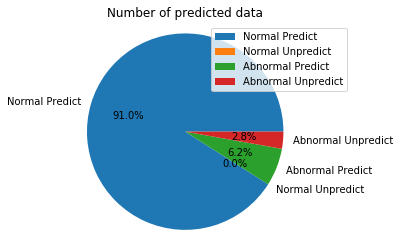

In [34]:
plt.pie([dic['normal_detect'],dic['normal_undetect'],dic['abnormal_detect'],dic['abnormal_undetect']], labels = ['Normal Predict', 'Normal Unpredict', 'Abnormal Predict','Abnormal Unpredict'], autopct = '%1.1f%%')
plt.title('Number of predicted data')
plt.axis('equal')
plt.legend(loc='best')
plt.savefig('MLP_result.pdf',dpi=100)

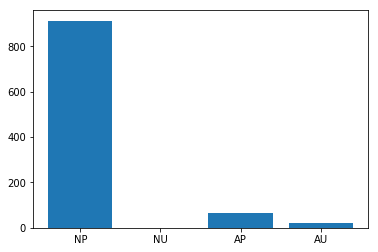

In [31]:
x = np.arange(4)
y = [round(dic['normal_detect'],2),round(dic['normal_undetect'],2),round(dic['abnormal_detect'],2),round(dic['abnormal_undetect'],2)]
plt.bar(x, height= y)
plt.xticks(x, ['NP', 'NU', 'AP','AU'])
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.savefig('MLP_result.pdf',dpi=100)

# Run YOLO

In [21]:
tfnet = TFNet(options)
path2 = "../training/"

Parsing cfg/truck-yolo.cfg
Loading None ...
Finished in 0.0s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 76, 128)
 Init  | 

# For Image

In [21]:
total = 0
count = 0
for file in os.listdir(path2):
    total += 1
    if '.jpg' in file:
        #print(path+file)
        imgcv = cv2.imread(path2+file)
        origin = imgcv
        imgcv = detect(imgcv)
        if len(imgcv) != 0:
            imgcvt = cv2.cvtColor(imgcv, cv2.COLOR_BGR2GRAY)
            imgcvt = cv2.resize(imgcvt, (200,200))
            imgcvt = imgcvt.flatten()
            test1 = np.array([]).reshape((0 ,img2.shape[0]))
            test1 = np.row_stack([test1, imgcvt.flatten()])
            test1 /= 255.
            testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
            testy1 = np.row_stack([testy1, class_y[0]])
            tr_pred = sess.run([y_pred], feed_dict={
                        input_data:test1,
                    })
            if tr_pred[0][0][1] < 1:
                count += 1
                cv2.imwrite('../Result/'+file,imgcv)
                print(tr_pred)
        else:
            imgcvt = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
            imgcvt = cv2.resize(imgcvt, (200,200))
            imgcvt = imgcvt.flatten()
            test1 = np.array([]).reshape((0 ,img2.shape[0]))
            test1 = np.row_stack([test1, imgcvt.flatten()])
            test1 /= 255.
            testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
            testy1 = np.row_stack([testy1, class_y[0]])
            tr_pred = sess.run([y_pred], feed_dict={
                        input_data:test1,
                    })
            if tr_pred[0][0][1] < 1:
                count += 1
                cv2.imwrite('../Result/'+file,origin)
                print(tr_pred)
           

        print('Object detected files:',count,'/',total)


[array([[-0.8491578 ,  0.89019114]], dtype=float32)]
Object detected files: 1 / 1
[array([[-0.8484942,  0.8897847]], dtype=float32)]
Object detected files: 2 / 2
[array([[-0.79967904,  0.8423159 ]], dtype=float32)]
Object detected files: 3 / 3
[array([[-0.8355662,  0.8729788]], dtype=float32)]
Object detected files: 4 / 4
[array([[-0.8335355,  0.8713654]], dtype=float32)]
Object detected files: 5 / 5
[array([[-0.8297169,  0.8675614]], dtype=float32)]
Object detected files: 6 / 6
[array([[-0.8264784,  0.8640934]], dtype=float32)]
Object detected files: 7 / 7
[array([[-0.8304388,  0.8671455]], dtype=float32)]
Object detected files: 8 / 8
[array([[-0.83483577,  0.87385136]], dtype=float32)]
Object detected files: 9 / 9
[array([[-0.8333512,  0.8707332]], dtype=float32)]
Object detected files: 10 / 10
[array([[-0.83100253,  0.8695146 ]], dtype=float32)]
Object detected files: 11 / 11
[array([[-0.8298147,  0.8674369]], dtype=float32)]
Object detected files: 12 / 12
[array([[-0.8247891 ,  0.8

[array([[-0.8474748 ,  0.89035594]], dtype=float32)]
Object detected files: 101 / 101
[array([[-0.8020644 ,  0.84440297]], dtype=float32)]
Object detected files: 102 / 102
[array([[-0.8458397,  0.889795 ]], dtype=float32)]
Object detected files: 103 / 103
[array([[-0.84699154,  0.89256024]], dtype=float32)]
Object detected files: 104 / 104
[array([[-0.8464524 ,  0.89233255]], dtype=float32)]
Object detected files: 105 / 105
[array([[-0.84670746,  0.89009184]], dtype=float32)]
Object detected files: 106 / 106
[array([[-0.84439766,  0.88841474]], dtype=float32)]
Object detected files: 107 / 107
[array([[-0.8445388,  0.8883276]], dtype=float32)]
Object detected files: 108 / 108
[array([[-0.8451909,  0.8897757]], dtype=float32)]
Object detected files: 109 / 109
[array([[-0.8445314 ,  0.89019215]], dtype=float32)]
Object detected files: 110 / 110
[array([[-0.84735525,  0.89153326]], dtype=float32)]
Object detected files: 111 / 111
[array([[-0.8470716,  0.8909759]], dtype=float32)]
Object de

Object detected files: 171 / 237
Object detected files: 171 / 238
Object detected files: 171 / 239
Object detected files: 171 / 240
Object detected files: 171 / 241
Object detected files: 171 / 242
Object detected files: 171 / 243
Object detected files: 171 / 244
Object detected files: 171 / 245
Object detected files: 171 / 246
[array([[-0.7975918 ,  0.83265287]], dtype=float32)]
Object detected files: 172 / 247
Object detected files: 172 / 248
Object detected files: 172 / 249
Object detected files: 172 / 250
Object detected files: 172 / 251
[array([[-0.85260177,  0.8949831 ]], dtype=float32)]
Object detected files: 173 / 252
[array([[-0.8526566,  0.8951752]], dtype=float32)]
Object detected files: 174 / 253
[array([[-0.8526566,  0.8951752]], dtype=float32)]
Object detected files: 175 / 254
[array([[-0.85138583,  0.89594203]], dtype=float32)]
Object detected files: 176 / 255
[array([[-0.8469619,  0.8936276]], dtype=float32)]
Object detected files: 177 / 256
[array([[-0.84300834,  0.891

[array([[-0.89830244,  0.95731854]], dtype=float32)]
Object detected files: 266 / 345
[array([[-0.89672923,  0.95675075]], dtype=float32)]
Object detected files: 267 / 346
[array([[-0.79066926,  0.8276056 ]], dtype=float32)]
Object detected files: 268 / 347
[array([[-0.89755386,  0.95694625]], dtype=float32)]
Object detected files: 269 / 348
[array([[-0.89623773,  0.9545576 ]], dtype=float32)]
Object detected files: 270 / 349
[array([[-0.8993506,  0.9579327]], dtype=float32)]
Object detected files: 271 / 350
[array([[-0.89818895,  0.9571341 ]], dtype=float32)]
Object detected files: 272 / 351
[array([[-0.8999535,  0.9585213]], dtype=float32)]
Object detected files: 273 / 352
[array([[-0.8982113 ,  0.95773804]], dtype=float32)]
Object detected files: 274 / 353
[array([[-0.89497995,  0.95483696]], dtype=float32)]
Object detected files: 275 / 354
[array([[-0.89743096,  0.957495  ]], dtype=float32)]
Object detected files: 276 / 355
[array([[-0.89533997,  0.9559536 ]], dtype=float32)]
Objec

[array([[-0.83340883,  0.8772427 ]], dtype=float32)]
Object detected files: 365 / 444
[array([[-0.8293113 ,  0.87526417]], dtype=float32)]
Object detected files: 366 / 445
[array([[-0.84569824,  0.8867568 ]], dtype=float32)]
Object detected files: 367 / 446
[array([[-0.81095785,  0.8608624 ]], dtype=float32)]
Object detected files: 368 / 447
[array([[-0.8330726,  0.8799102]], dtype=float32)]
Object detected files: 369 / 448
[array([[-0.8288224 ,  0.87484545]], dtype=float32)]
Object detected files: 370 / 449
[array([[-0.8269849,  0.8712055]], dtype=float32)]
Object detected files: 371 / 450
[array([[-0.8322655,  0.8774386]], dtype=float32)]
Object detected files: 372 / 451
[array([[-0.8336955 ,  0.87954247]], dtype=float32)]
Object detected files: 373 / 452
[array([[-0.83693177,  0.8839763 ]], dtype=float32)]
Object detected files: 374 / 453
[array([[-0.8281949 ,  0.87375593]], dtype=float32)]
Object detected files: 375 / 454
[array([[-0.82631516,  0.8706712 ]], dtype=float32)]
Object 

[array([[-0.8223312 ,  0.86489785]], dtype=float32)]
Object detected files: 465 / 544
[array([[-0.827627  ,  0.87223566]], dtype=float32)]
Object detected files: 466 / 545
[array([[-0.8191079 ,  0.86437035]], dtype=float32)]
Object detected files: 467 / 546
[array([[-0.82998294,  0.8773121 ]], dtype=float32)]
Object detected files: 468 / 547
[array([[-0.83141214,  0.87857544]], dtype=float32)]
Object detected files: 469 / 548
[array([[-0.83534724,  0.8844656 ]], dtype=float32)]
Object detected files: 470 / 549
[array([[-0.853577  ,  0.90595233]], dtype=float32)]
Object detected files: 471 / 550
[array([[-0.8535482 ,  0.90595245]], dtype=float32)]
Object detected files: 472 / 551
[array([[-0.8536849,  0.9061972]], dtype=float32)]
Object detected files: 473 / 552
[array([[-0.8532443 ,  0.90417206]], dtype=float32)]
Object detected files: 474 / 553
[array([[-0.8554344,  0.9027503]], dtype=float32)]
Object detected files: 475 / 554
[array([[-0.8631559 ,  0.91214985]], dtype=float32)]
Objec

[array([[-0.83186495,  0.8687045 ]], dtype=float32)]
Object detected files: 554 / 655
Object detected files: 554 / 657
Object detected files: 554 / 658
Object detected files: 554 / 659
Object detected files: 554 / 660
Object detected files: 554 / 661
Object detected files: 554 / 662
Object detected files: 554 / 663
Object detected files: 554 / 664
Object detected files: 554 / 665
Object detected files: 554 / 666
Object detected files: 554 / 667
Object detected files: 554 / 668
Object detected files: 554 / 669
Object detected files: 554 / 670
Object detected files: 554 / 671
Object detected files: 554 / 672
Object detected files: 554 / 673
Object detected files: 554 / 674
Object detected files: 554 / 675
Object detected files: 554 / 676
Object detected files: 554 / 677
Object detected files: 554 / 678
Object detected files: 554 / 679
Object detected files: 554 / 680
Object detected files: 554 / 681
Object detected files: 554 / 682
Object detected files: 554 / 683
Object detected files: 

Object detected files: 554 / 906
Object detected files: 554 / 907
Object detected files: 554 / 908
Object detected files: 554 / 909
Object detected files: 554 / 910
Object detected files: 554 / 911
Object detected files: 554 / 912
Object detected files: 554 / 913
Object detected files: 554 / 914
Object detected files: 554 / 915
Object detected files: 554 / 916
Object detected files: 554 / 917
Object detected files: 554 / 918
Object detected files: 554 / 919
Object detected files: 554 / 920
Object detected files: 554 / 921
Object detected files: 554 / 922
Object detected files: 554 / 923
Object detected files: 554 / 924
Object detected files: 554 / 925
Object detected files: 554 / 926
Object detected files: 554 / 927
Object detected files: 554 / 928
Object detected files: 554 / 929
Object detected files: 554 / 930
Object detected files: 554 / 931
Object detected files: 554 / 932
Object detected files: 554 / 933
Object detected files: 554 / 934
Object detected files: 554 / 935
Object det

Object detected files: 554 / 1150
Object detected files: 554 / 1151
Object detected files: 554 / 1152
Object detected files: 554 / 1153
Object detected files: 554 / 1154
Object detected files: 554 / 1155
Object detected files: 554 / 1156
Object detected files: 554 / 1157
Object detected files: 554 / 1158
Object detected files: 554 / 1159
Object detected files: 554 / 1160
Object detected files: 554 / 1161
Object detected files: 554 / 1162
Object detected files: 554 / 1163
Object detected files: 554 / 1164
Object detected files: 554 / 1165
Object detected files: 554 / 1166
Object detected files: 554 / 1167
Object detected files: 554 / 1168
Object detected files: 554 / 1169
Object detected files: 554 / 1170
Object detected files: 554 / 1171
Object detected files: 554 / 1172
Object detected files: 554 / 1173
Object detected files: 554 / 1174
Object detected files: 554 / 1175
Object detected files: 554 / 1176
Object detected files: 554 / 1177
Object detected files: 554 / 1178
Object detecte

Object detected files: 554 / 1394
Object detected files: 554 / 1395
Object detected files: 554 / 1396
Object detected files: 554 / 1397
Object detected files: 554 / 1398
Object detected files: 554 / 1399
Object detected files: 554 / 1400
Object detected files: 554 / 1401
Object detected files: 554 / 1402
Object detected files: 554 / 1403
Object detected files: 554 / 1404
Object detected files: 554 / 1405
Object detected files: 554 / 1406
Object detected files: 554 / 1407
Object detected files: 554 / 1408
Object detected files: 554 / 1409
Object detected files: 554 / 1410
Object detected files: 554 / 1411
Object detected files: 554 / 1412
Object detected files: 554 / 1413
Object detected files: 554 / 1414
Object detected files: 554 / 1415
Object detected files: 554 / 1416
Object detected files: 554 / 1417
Object detected files: 554 / 1418
Object detected files: 554 / 1419
Object detected files: 554 / 1420
Object detected files: 554 / 1421
Object detected files: 554 / 1422
Object detecte

Object detected files: 554 / 1635
Object detected files: 554 / 1636
Object detected files: 554 / 1637
Object detected files: 554 / 1638
Object detected files: 554 / 1639
Object detected files: 554 / 1640
Object detected files: 554 / 1641
Object detected files: 554 / 1642
Object detected files: 554 / 1643
Object detected files: 554 / 1644
Object detected files: 554 / 1645
Object detected files: 554 / 1646
Object detected files: 554 / 1647
Object detected files: 554 / 1648
Object detected files: 554 / 1649
Object detected files: 554 / 1650
Object detected files: 554 / 1651
Object detected files: 554 / 1652
Object detected files: 554 / 1653
Object detected files: 554 / 1654
Object detected files: 554 / 1655
Object detected files: 554 / 1656
Object detected files: 554 / 1657
Object detected files: 554 / 1658
Object detected files: 554 / 1659
Object detected files: 554 / 1660
Object detected files: 554 / 1661
Object detected files: 554 / 1662
Object detected files: 554 / 1663
Object detecte

Object detected files: 554 / 1876
Object detected files: 554 / 1877
Object detected files: 554 / 1878
Object detected files: 554 / 1879
Object detected files: 554 / 1880
Object detected files: 554 / 1881
Object detected files: 554 / 1882
Object detected files: 554 / 1883
Object detected files: 554 / 1884
Object detected files: 554 / 1885
Object detected files: 554 / 1886
Object detected files: 554 / 1887
Object detected files: 554 / 1888
Object detected files: 554 / 1889
Object detected files: 554 / 1890
Object detected files: 554 / 1891
Object detected files: 554 / 1892
Object detected files: 554 / 1893
Object detected files: 554 / 1894
Object detected files: 554 / 1895
Object detected files: 554 / 1896
Object detected files: 554 / 1897
Object detected files: 554 / 1898
Object detected files: 554 / 1899
Object detected files: 554 / 1900
Object detected files: 554 / 1901
Object detected files: 554 / 1902
Object detected files: 554 / 1903
Object detected files: 554 / 1904
Object detecte

Object detected files: 554 / 2117
Object detected files: 554 / 2118
Object detected files: 554 / 2119
Object detected files: 554 / 2120
Object detected files: 554 / 2121
Object detected files: 554 / 2122
Object detected files: 554 / 2123
Object detected files: 554 / 2124
Object detected files: 554 / 2125
Object detected files: 554 / 2126
Object detected files: 554 / 2127
Object detected files: 554 / 2128
Object detected files: 554 / 2129
Object detected files: 554 / 2130
Object detected files: 554 / 2131
Object detected files: 554 / 2132
Object detected files: 554 / 2133
Object detected files: 554 / 2134
Object detected files: 554 / 2135
Object detected files: 554 / 2136
Object detected files: 554 / 2137
Object detected files: 554 / 2138
Object detected files: 554 / 2139
Object detected files: 554 / 2140
Object detected files: 554 / 2141
Object detected files: 554 / 2142
Object detected files: 554 / 2143
Object detected files: 554 / 2144
Object detected files: 554 / 2145
Object detecte

Object detected files: 554 / 2361
Object detected files: 554 / 2362
Object detected files: 554 / 2363
Object detected files: 554 / 2364
Object detected files: 554 / 2365
Object detected files: 554 / 2366
Object detected files: 554 / 2367
Object detected files: 554 / 2368
Object detected files: 554 / 2369
Object detected files: 554 / 2370
Object detected files: 554 / 2371
Object detected files: 554 / 2372
Object detected files: 554 / 2373
Object detected files: 554 / 2374
Object detected files: 554 / 2375
Object detected files: 554 / 2376
Object detected files: 554 / 2377
Object detected files: 554 / 2378
Object detected files: 554 / 2379
Object detected files: 554 / 2380
Object detected files: 554 / 2381
Object detected files: 554 / 2382
Object detected files: 554 / 2383
Object detected files: 554 / 2384
Object detected files: 554 / 2385
Object detected files: 554 / 2386
Object detected files: 554 / 2387
Object detected files: 554 / 2388
Object detected files: 554 / 2389
Object detecte

Object detected files: 554 / 2603
Object detected files: 554 / 2604
Object detected files: 554 / 2605
Object detected files: 554 / 2606
Object detected files: 554 / 2607
Object detected files: 554 / 2608
Object detected files: 554 / 2609
Object detected files: 554 / 2610
Object detected files: 554 / 2611
Object detected files: 554 / 2612
Object detected files: 554 / 2613
Object detected files: 554 / 2614
Object detected files: 554 / 2615
Object detected files: 554 / 2616
Object detected files: 554 / 2617
Object detected files: 554 / 2618
Object detected files: 554 / 2619
Object detected files: 554 / 2620
Object detected files: 554 / 2621
Object detected files: 554 / 2622
Object detected files: 554 / 2623
Object detected files: 554 / 2624
Object detected files: 554 / 2625
Object detected files: 554 / 2626
Object detected files: 554 / 2627
Object detected files: 554 / 2628
Object detected files: 554 / 2629
Object detected files: 554 / 2630
Object detected files: 554 / 2631
Object detecte

Object detected files: 554 / 2847
Object detected files: 554 / 2848
Object detected files: 554 / 2849
Object detected files: 554 / 2850
Object detected files: 554 / 2851
Object detected files: 554 / 2852
Object detected files: 554 / 2853
Object detected files: 554 / 2854
Object detected files: 554 / 2855
Object detected files: 554 / 2856
Object detected files: 554 / 2857
Object detected files: 554 / 2858
Object detected files: 554 / 2859
Object detected files: 554 / 2860
Object detected files: 554 / 2861
Object detected files: 554 / 2862
Object detected files: 554 / 2863
Object detected files: 554 / 2864
Object detected files: 554 / 2865
Object detected files: 554 / 2866
Object detected files: 554 / 2867
Object detected files: 554 / 2868
Object detected files: 554 / 2869
Object detected files: 554 / 2870
Object detected files: 554 / 2871
Object detected files: 554 / 2872
Object detected files: 554 / 2873
Object detected files: 554 / 2874
Object detected files: 554 / 2875
Object detecte

Object detected files: 554 / 3091
Object detected files: 554 / 3092
Object detected files: 554 / 3093
Object detected files: 554 / 3094
Object detected files: 554 / 3095
Object detected files: 554 / 3096
Object detected files: 554 / 3097
Object detected files: 554 / 3098
Object detected files: 554 / 3099
Object detected files: 554 / 3100
Object detected files: 554 / 3101
Object detected files: 554 / 3102
Object detected files: 554 / 3103
Object detected files: 554 / 3104
Object detected files: 554 / 3105
Object detected files: 554 / 3106
Object detected files: 554 / 3107
Object detected files: 554 / 3108
Object detected files: 554 / 3109
Object detected files: 554 / 3110
Object detected files: 554 / 3111
Object detected files: 554 / 3112
Object detected files: 554 / 3113
Object detected files: 554 / 3114
Object detected files: 554 / 3115
Object detected files: 554 / 3116
Object detected files: 554 / 3117
Object detected files: 554 / 3118
Object detected files: 554 / 3119
Object detecte

Object detected files: 554 / 3335
Object detected files: 554 / 3336
Object detected files: 554 / 3337
Object detected files: 554 / 3338
Object detected files: 554 / 3339
Object detected files: 554 / 3340
Object detected files: 554 / 3341
Object detected files: 554 / 3342
Object detected files: 554 / 3343
Object detected files: 554 / 3344
Object detected files: 554 / 3345
Object detected files: 554 / 3346
Object detected files: 554 / 3347
Object detected files: 554 / 3348
Object detected files: 554 / 3349
Object detected files: 554 / 3350
Object detected files: 554 / 3351
Object detected files: 554 / 3352
Object detected files: 554 / 3353
Object detected files: 554 / 3354
Object detected files: 554 / 3355
Object detected files: 554 / 3356
Object detected files: 554 / 3357
Object detected files: 554 / 3358
Object detected files: 554 / 3359
Object detected files: 554 / 3360
Object detected files: 554 / 3361
Object detected files: 554 / 3362
Object detected files: 554 / 3363
Object detecte

Object detected files: 554 / 3578
Object detected files: 554 / 3579
Object detected files: 554 / 3580
Object detected files: 554 / 3581
Object detected files: 554 / 3582
Object detected files: 554 / 3583
Object detected files: 554 / 3584
Object detected files: 554 / 3585
Object detected files: 554 / 3586
Object detected files: 554 / 3587
Object detected files: 554 / 3588
Object detected files: 554 / 3589
Object detected files: 554 / 3590
Object detected files: 554 / 3591
Object detected files: 554 / 3592
Object detected files: 554 / 3593
Object detected files: 554 / 3594
Object detected files: 554 / 3595
Object detected files: 554 / 3596
Object detected files: 554 / 3597
Object detected files: 554 / 3598
Object detected files: 554 / 3599
Object detected files: 554 / 3600
Object detected files: 554 / 3601
Object detected files: 554 / 3602
Object detected files: 554 / 3603
Object detected files: 554 / 3604
Object detected files: 554 / 3605
Object detected files: 554 / 3606
Object detecte

Object detected files: 554 / 3822
Object detected files: 554 / 3823
Object detected files: 554 / 3824
Object detected files: 554 / 3825
Object detected files: 554 / 3826
Object detected files: 554 / 3827
Object detected files: 554 / 3828
Object detected files: 554 / 3829
Object detected files: 554 / 3830
Object detected files: 554 / 3831
Object detected files: 554 / 3832
Object detected files: 554 / 3833
Object detected files: 554 / 3834
Object detected files: 554 / 3835
Object detected files: 554 / 3836
Object detected files: 554 / 3837
Object detected files: 554 / 3838
Object detected files: 554 / 3839
Object detected files: 554 / 3840
Object detected files: 554 / 3841
Object detected files: 554 / 3842
Object detected files: 554 / 3843
Object detected files: 554 / 3844
Object detected files: 554 / 3845
Object detected files: 554 / 3846
Object detected files: 554 / 3847
Object detected files: 554 / 3848
Object detected files: 554 / 3849
Object detected files: 554 / 3850
Object detecte

Object detected files: 554 / 4066
Object detected files: 554 / 4067
Object detected files: 554 / 4068
Object detected files: 554 / 4069
Object detected files: 554 / 4070
Object detected files: 554 / 4071
Object detected files: 554 / 4072
Object detected files: 554 / 4073
Object detected files: 554 / 4074
Object detected files: 554 / 4075
Object detected files: 554 / 4076
Object detected files: 554 / 4077
Object detected files: 554 / 4078
Object detected files: 554 / 4079
Object detected files: 554 / 4080
Object detected files: 554 / 4081
Object detected files: 554 / 4082
Object detected files: 554 / 4083
Object detected files: 554 / 4084
Object detected files: 554 / 4085
Object detected files: 554 / 4086
Object detected files: 554 / 4087
Object detected files: 554 / 4088
Object detected files: 554 / 4089
Object detected files: 554 / 4090
Object detected files: 554 / 4091
Object detected files: 554 / 4092
Object detected files: 554 / 4093
Object detected files: 554 / 4094
Object detecte

Object detected files: 554 / 4308
Object detected files: 554 / 4309
Object detected files: 554 / 4310
Object detected files: 554 / 4311
Object detected files: 554 / 4312
Object detected files: 554 / 4313
Object detected files: 554 / 4314
Object detected files: 554 / 4315
Object detected files: 554 / 4316
Object detected files: 554 / 4317
Object detected files: 554 / 4318
Object detected files: 554 / 4319
Object detected files: 554 / 4320
Object detected files: 554 / 4321
Object detected files: 554 / 4322
Object detected files: 554 / 4323
Object detected files: 554 / 4324
Object detected files: 554 / 4325
Object detected files: 554 / 4326
Object detected files: 554 / 4327
Object detected files: 554 / 4328
Object detected files: 554 / 4329
Object detected files: 554 / 4330
Object detected files: 554 / 4331
Object detected files: 554 / 4332
Object detected files: 554 / 4333
Object detected files: 554 / 4334
Object detected files: 554 / 4335
Object detected files: 554 / 4336
Object detecte

Object detected files: 554 / 4550
Object detected files: 554 / 4551
Object detected files: 554 / 4552
Object detected files: 554 / 4553
Object detected files: 554 / 4554
Object detected files: 554 / 4555
Object detected files: 554 / 4556
Object detected files: 554 / 4557
Object detected files: 554 / 4558
Object detected files: 554 / 4559
Object detected files: 554 / 4560
Object detected files: 554 / 4561
Object detected files: 554 / 4562
Object detected files: 554 / 4563
Object detected files: 554 / 4564
Object detected files: 554 / 4565
Object detected files: 554 / 4566
Object detected files: 554 / 4567
Object detected files: 554 / 4568
Object detected files: 554 / 4569
Object detected files: 554 / 4570
Object detected files: 554 / 4571
Object detected files: 554 / 4572
Object detected files: 554 / 4573
Object detected files: 554 / 4574
Object detected files: 554 / 4575
Object detected files: 554 / 4576
Object detected files: 554 / 4577
Object detected files: 554 / 4578
Object detecte

Object detected files: 554 / 4792
Object detected files: 554 / 4793
Object detected files: 554 / 4794
Object detected files: 554 / 4795
Object detected files: 554 / 4796
Object detected files: 554 / 4797
Object detected files: 554 / 4798
Object detected files: 554 / 4799
Object detected files: 554 / 4800
Object detected files: 554 / 4801
Object detected files: 554 / 4802
Object detected files: 554 / 4803
Object detected files: 554 / 4804
Object detected files: 554 / 4805
Object detected files: 554 / 4806
Object detected files: 554 / 4807
Object detected files: 554 / 4808
Object detected files: 554 / 4809
Object detected files: 554 / 4810
Object detected files: 554 / 4811
Object detected files: 554 / 4812
Object detected files: 554 / 4813
Object detected files: 554 / 4814
Object detected files: 554 / 4815
Object detected files: 554 / 4816
Object detected files: 554 / 4817
Object detected files: 554 / 4818
Object detected files: 554 / 4819
Object detected files: 554 / 4820
Object detecte

Object detected files: 554 / 5036
Object detected files: 554 / 5037
Object detected files: 554 / 5038
Object detected files: 554 / 5039
Object detected files: 554 / 5040
Object detected files: 554 / 5041
Object detected files: 554 / 5042
Object detected files: 554 / 5043
Object detected files: 554 / 5044
Object detected files: 554 / 5045
Object detected files: 554 / 5046
Object detected files: 554 / 5047
Object detected files: 554 / 5048
Object detected files: 554 / 5049
Object detected files: 554 / 5050
Object detected files: 554 / 5051
Object detected files: 554 / 5052
Object detected files: 554 / 5053
Object detected files: 554 / 5054
Object detected files: 554 / 5055
Object detected files: 554 / 5056
Object detected files: 554 / 5057
Object detected files: 554 / 5058
Object detected files: 554 / 5059
Object detected files: 554 / 5060
Object detected files: 554 / 5061
Object detected files: 554 / 5062
Object detected files: 554 / 5063
Object detected files: 554 / 5064
Object detecte

Object detected files: 554 / 5280
Object detected files: 554 / 5281
Object detected files: 554 / 5282
Object detected files: 554 / 5283
Object detected files: 554 / 5284
Object detected files: 554 / 5285
Object detected files: 554 / 5286
Object detected files: 554 / 5287
Object detected files: 554 / 5288
Object detected files: 554 / 5289
Object detected files: 554 / 5290
Object detected files: 554 / 5291
Object detected files: 554 / 5292
Object detected files: 554 / 5293
Object detected files: 554 / 5294
Object detected files: 554 / 5295
Object detected files: 554 / 5296
Object detected files: 554 / 5297
Object detected files: 554 / 5298
Object detected files: 554 / 5299
Object detected files: 554 / 5300
Object detected files: 554 / 5301
Object detected files: 554 / 5302
Object detected files: 554 / 5303
Object detected files: 554 / 5304
Object detected files: 554 / 5305
Object detected files: 554 / 5306
Object detected files: 554 / 5307
Object detected files: 554 / 5308
Object detecte

Object detected files: 554 / 5521
Object detected files: 554 / 5522
Object detected files: 554 / 5523
Object detected files: 554 / 5524
Object detected files: 554 / 5525
Object detected files: 554 / 5526
Object detected files: 554 / 5527
Object detected files: 554 / 5528
Object detected files: 554 / 5529
Object detected files: 554 / 5530
Object detected files: 554 / 5531
Object detected files: 554 / 5532
Object detected files: 554 / 5533
Object detected files: 554 / 5534
Object detected files: 554 / 5535
Object detected files: 554 / 5536
Object detected files: 554 / 5537
Object detected files: 554 / 5538
Object detected files: 554 / 5539
Object detected files: 554 / 5540
Object detected files: 554 / 5541
Object detected files: 554 / 5542
Object detected files: 554 / 5543
Object detected files: 554 / 5544
Object detected files: 554 / 5545
Object detected files: 554 / 5546
Object detected files: 554 / 5547
Object detected files: 554 / 5548
Object detected files: 554 / 5549
Object detecte

Object detected files: 554 / 5765
Object detected files: 554 / 5766
Object detected files: 554 / 5767
Object detected files: 554 / 5768
Object detected files: 554 / 5769
Object detected files: 554 / 5770
Object detected files: 554 / 5771
Object detected files: 554 / 5772
Object detected files: 554 / 5773
Object detected files: 554 / 5774
Object detected files: 554 / 5775
Object detected files: 554 / 5776
Object detected files: 554 / 5777
Object detected files: 554 / 5778
Object detected files: 554 / 5779
Object detected files: 554 / 5780
Object detected files: 554 / 5781
Object detected files: 554 / 5782
Object detected files: 554 / 5783
Object detected files: 554 / 5784
Object detected files: 554 / 5785
Object detected files: 554 / 5786
Object detected files: 554 / 5787
Object detected files: 554 / 5788
Object detected files: 554 / 5789
Object detected files: 554 / 5790
Object detected files: 554 / 5791
Object detected files: 554 / 5792
Object detected files: 554 / 5793
Object detecte

Object detected files: 554 / 6009
Object detected files: 554 / 6010
Object detected files: 554 / 6011
Object detected files: 554 / 6012
Object detected files: 554 / 6013
Object detected files: 554 / 6014
Object detected files: 554 / 6015
Object detected files: 554 / 6016
Object detected files: 554 / 6017
Object detected files: 554 / 6018
Object detected files: 554 / 6019
Object detected files: 554 / 6020
Object detected files: 554 / 6021
Object detected files: 554 / 6022
Object detected files: 554 / 6023
Object detected files: 554 / 6024
Object detected files: 554 / 6025
Object detected files: 554 / 6026
Object detected files: 554 / 6027
Object detected files: 554 / 6028
Object detected files: 554 / 6029
Object detected files: 554 / 6030
Object detected files: 554 / 6031
Object detected files: 554 / 6032
Object detected files: 554 / 6033
Object detected files: 554 / 6034
Object detected files: 554 / 6035
Object detected files: 554 / 6036
Object detected files: 554 / 6037
Object detecte

Object detected files: 554 / 6253
Object detected files: 554 / 6254
Object detected files: 554 / 6255
Object detected files: 554 / 6256
Object detected files: 554 / 6257
Object detected files: 554 / 6258
Object detected files: 554 / 6259
Object detected files: 554 / 6260
Object detected files: 554 / 6261
Object detected files: 554 / 6262
Object detected files: 554 / 6263
Object detected files: 554 / 6264
Object detected files: 554 / 6265
Object detected files: 554 / 6266
Object detected files: 554 / 6267
Object detected files: 554 / 6268
Object detected files: 554 / 6269
Object detected files: 554 / 6270
Object detected files: 554 / 6271
Object detected files: 554 / 6272
Object detected files: 554 / 6273
Object detected files: 554 / 6274
Object detected files: 554 / 6275
Object detected files: 554 / 6276
Object detected files: 554 / 6277
Object detected files: 554 / 6278
Object detected files: 554 / 6279
Object detected files: 554 / 6280
Object detected files: 554 / 6281
Object detecte

Object detected files: 554 / 6495
Object detected files: 554 / 6496
Object detected files: 554 / 6497
Object detected files: 554 / 6498
Object detected files: 554 / 6499
Object detected files: 554 / 6500
Object detected files: 554 / 6501
Object detected files: 554 / 6502
Object detected files: 554 / 6503
Object detected files: 554 / 6504
Object detected files: 554 / 6505
Object detected files: 554 / 6506
Object detected files: 554 / 6507
Object detected files: 554 / 6508
Object detected files: 554 / 6509
Object detected files: 554 / 6510
Object detected files: 554 / 6511
Object detected files: 554 / 6512
Object detected files: 554 / 6513
Object detected files: 554 / 6514
Object detected files: 554 / 6515
Object detected files: 554 / 6516
Object detected files: 554 / 6517
Object detected files: 554 / 6518
Object detected files: 554 / 6519
Object detected files: 554 / 6520
Object detected files: 554 / 6521
Object detected files: 554 / 6522
Object detected files: 554 / 6523
Object detecte

Object detected files: 554 / 6739
Object detected files: 554 / 6740
Object detected files: 554 / 6741
Object detected files: 554 / 6742
Object detected files: 554 / 6743
Object detected files: 554 / 6744
Object detected files: 554 / 6745
Object detected files: 554 / 6746
Object detected files: 554 / 6747
Object detected files: 554 / 6748
Object detected files: 554 / 6749
Object detected files: 554 / 6750
Object detected files: 554 / 6751
Object detected files: 554 / 6752
Object detected files: 554 / 6753
Object detected files: 554 / 6754
Object detected files: 554 / 6755
Object detected files: 554 / 6756
Object detected files: 554 / 6757
Object detected files: 554 / 6758
Object detected files: 554 / 6759
Object detected files: 554 / 6760
Object detected files: 554 / 6761
Object detected files: 554 / 6762
Object detected files: 554 / 6763
Object detected files: 554 / 6764
Object detected files: 554 / 6765
Object detected files: 554 / 6766
Object detected files: 554 / 6767
Object detecte

Object detected files: 554 / 6980
Object detected files: 554 / 6981
Object detected files: 554 / 6982
Object detected files: 554 / 6983
Object detected files: 554 / 6984
Object detected files: 554 / 6985
Object detected files: 554 / 6986
Object detected files: 554 / 6987
Object detected files: 554 / 6988
Object detected files: 554 / 6989
Object detected files: 554 / 6990
Object detected files: 554 / 6991
Object detected files: 554 / 6992
Object detected files: 554 / 6993
Object detected files: 554 / 6994
Object detected files: 554 / 6995
Object detected files: 554 / 6996
Object detected files: 554 / 6997
Object detected files: 554 / 6998
Object detected files: 554 / 6999
Object detected files: 554 / 7000
Object detected files: 554 / 7001
Object detected files: 554 / 7002
Object detected files: 554 / 7003
Object detected files: 554 / 7004
Object detected files: 554 / 7005
Object detected files: 554 / 7006
Object detected files: 554 / 7007
Object detected files: 554 / 7008
Object detecte

Object detected files: 554 / 7224
Object detected files: 554 / 7225
Object detected files: 554 / 7226
Object detected files: 554 / 7227
Object detected files: 554 / 7228
Object detected files: 554 / 7229
Object detected files: 554 / 7230
Object detected files: 554 / 7231
Object detected files: 554 / 7232
Object detected files: 554 / 7233
Object detected files: 554 / 7234
Object detected files: 554 / 7235
Object detected files: 554 / 7236
Object detected files: 554 / 7237
Object detected files: 554 / 7238
Object detected files: 554 / 7239
Object detected files: 554 / 7240
Object detected files: 554 / 7241
Object detected files: 554 / 7242
Object detected files: 554 / 7243
Object detected files: 554 / 7244
Object detected files: 554 / 7245
Object detected files: 554 / 7246
Object detected files: 554 / 7247
Object detected files: 554 / 7248
Object detected files: 554 / 7249
Object detected files: 554 / 7250
Object detected files: 554 / 7251
Object detected files: 554 / 7252
Object detecte

# For Video YOLO

In [22]:
total = 0
count = 0
for i in range(25):
    cap = cv2.VideoCapture('../完整影片/20180627/'+str(i)+'.avi')
    timeF = 10
    c = 0
    # 以迴圈從影片檔案讀取影格，並顯示出來
    while(cap.isOpened()):
        ret, frame = cap.read()
        if frame is None:
            break

        if(c%timeF==0):
            #print(type(frame))
            origin = frame
            origin = origin[35:,100:300]
#             cv2.imshow('123',origin)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            imgcv = detect(origin)
            if len(imgcv) != 0:
                count += 1
                cv2.imwrite('../Result/'+str(count)+'.jpg',imgcv)
            total += 1
        c += 1
    cap.release()
    cv2.destroyAllWindows()
    print('Object detected files:',count,'/',total)

Object detected files: 697 / 1350
Object detected files: 1312 / 2701
Object detected files: 2219 / 4052
Object detected files: 2836 / 5403
Object detected files: 3541 / 6753
Object detected files: 4244 / 8105
Object detected files: 5287 / 9457
Object detected files: 6637 / 10807
Object detected files: 7623 / 12157
Object detected files: 8443 / 13509
Object detected files: 9342 / 14860
Object detected files: 10614 / 16211
Object detected files: 11965 / 17562
Object detected files: 12834 / 18913
Object detected files: 13328 / 20265
Object detected files: 14088 / 21617
Object detected files: 14575 / 22967
Object detected files: 14906 / 24319
Object detected files: 15318 / 25670
Object detected files: 16111 / 27021
Object detected files: 17322 / 28372
Object detected files: 18575 / 29722
Object detected files: 19609 / 31072
Object detected files: 20596 / 32424
Object detected files: 20602 / 32430


# Test YOLO

In [22]:
data_number = 1000
test_path = "../training/"
tmp = os.listdir(test_path)
dir_list = []
for i in range(len(tmp)):
    if 'jpg' in tmp[i]:
        dir_list.append(tmp[i])


total_result = [0,0,0,0]
for count in range(30):
    dic = {'normal_detect':0,'normal_undetect':0,'abnormal_detect':0,'abnormal_undetect':0}
    correct = 0
    for i in range(data_number):
        r = rd.randint(0,len(dir_list)-1)
        file = test_path + dir_list[r]
        #print(file)
        imgcv = cv2.imread(path2+file)
        origin = imgcv
        imgcv = detect(imgcv)

        if len(imgcv) != 0:
            if 'ab' in file:
                correct+=1
                print('data detected:', dir_list[r])
                dic['abnormal_detect']+=1
            else:
                print('data undetected:', dir_list[r])
                dic['normal_undetect']+=1
        else:
            if 'ab' not in file:
                correct+=1
                #print('data detected:', dir_list[r])
                dic['normal_detect']+=1
            else:
                print('data undetected:', dir_list[r])
                dic['abnormal_undetect']+=1

    print('Correct:',correct,'/ Total:',data_number)
    print('Accuracy:', correct/data_number)
    print(dic)
    total_result[0]+= dic['normal_detect']
    total_result[1]+= dic['normal_undetect']
    total_result[2]+= dic['abnormal_detect']
    total_result[3]+= dic['abnormal_undetect']
dic['normal_detect'] = total_result[0]/30
dic['normal_undetect'] = total_result[1]/30
dic['abnormal_detect'] = total_result[2]/30
dic['abnormal_undetect'] = total_result[3]/30
print(dic)

data undetected: normal_img_0.jpg
data undetected: normal_img_644.jpg
data undetected: normal_img_35.jpg
data detected: abnormal_img_12.jpg
data undetected: normal_img_6608.jpg
data undetected: normal_img_5077.jpg
data undetected: normal_img_6480.jpg
data undetected: normal_img_499.jpg
data detected: abnormal_img_155.jpg
data detected: abnormal_img_335.jpg
data undetected: normal_img_2338.jpg
data detected: abnormal_img_310.jpg
data undetected: normal_img_3641.jpg
data detected: abnormal_img_270.jpg
data undetected: normal_img_5375.jpg
data undetected: normal_img_317.jpg
data undetected: normal_img_203.jpg
data detected: abnormal_img_189.jpg
data undetected: abnormal_img_14.jpg
data undetected: abnormal_img_629.jpg
data detected: abnormal_img_58.jpg
data undetected: abnormal_img_631.jpg
data undetected: normal_img_695.jpg
data undetected: normal_img_1202.jpg
data detected: abnormal_img_197.jpg
data undetected: normal_img_847.jpg
data undetected: normal_img_1467.jpg
data undetected: nor

data undetected: normal_img_5588.jpg
data undetected: abnormal_img_442.jpg
data undetected: normal_img_1142.jpg
data undetected: normal_img_545.jpg
data undetected: normal_img_6681.jpg
data undetected: normal_img_2265.jpg
data undetected: normal_img_5058.jpg
data undetected: normal_img_949.jpg
data undetected: normal_img_5421.jpg
data undetected: normal_img_783.jpg
data undetected: normal_img_112.jpg
data undetected: normal_img_4157.jpg
data undetected: normal_img_5153.jpg
data detected: abnormal_img_552.jpg
data undetected: abnormal_img_2.jpg
data undetected: normal_img_760.jpg
data detected: abnormal_img_583.jpg
data detected: abnormal_img_185.jpg
data undetected: normal_img_2766.jpg
data undetected: abnormal_img_433.jpg
Correct: 810 / Total: 1000
Accuracy: 0.81
{'normal_detect': 754, 'normal_undetect': 166, 'abnormal_detect': 56, 'abnormal_undetect': 24}
data undetected: normal_img_2180.jpg
data undetected: normal_img_5389.jpg
data undetected: normal_img_5157.jpg
data undetected: no

data undetected: normal_img_885.jpg
data undetected: normal_img_2151.jpg
data undetected: abnormal_img_466.jpg
data undetected: abnormal_img_538.jpg
data undetected: normal_img_811.jpg
data undetected: normal_img_1516.jpg
data detected: abnormal_img_311.jpg
data detected: abnormal_img_503.jpg
data undetected: normal_img_5057.jpg
data detected: abnormal_img_76.jpg
data undetected: normal_img_308.jpg
data undetected: normal_img_268.jpg
data detected: abnormal_img_125.jpg
data undetected: normal_img_1519.jpg
data undetected: normal_img_5071.jpg
data undetected: normal_img_196.jpg
data undetected: normal_img_6693.jpg
data undetected: normal_img_2331.jpg
data undetected: normal_img_3549.jpg
data detected: abnormal_img_170.jpg
data detected: abnormal_img_169.jpg
data undetected: normal_img_3724.jpg
data undetected: abnormal_img_572.jpg
data undetected: normal_img_510.jpg
data detected: abnormal_img_131.jpg
data undetected: normal_img_738.jpg
data undetected: normal_img_3825.jpg
data undetect

data detected: abnormal_img_501.jpg
data detected: abnormal_img_285.jpg
data undetected: normal_img_6609.jpg
data undetected: normal_img_5044.jpg
data undetected: normal_img_749.jpg
data undetected: normal_img_1488.jpg
data undetected: normal_img_2687.jpg
data undetected: normal_img_4090.jpg
data detected: abnormal_img_260.jpg
data undetected: normal_img_255.jpg
data undetected: normal_img_817.jpg
data detected: abnormal_img_33.jpg
data undetected: normal_img_5155.jpg
data undetected: normal_img_600.jpg
data undetected: normal_img_26.jpg
data undetected: normal_img_6623.jpg
data detected: abnormal_img_196.jpg
data undetected: normal_img_3712.jpg
data undetected: normal_img_1961.jpg
data undetected: normal_img_1777.jpg
data undetected: abnormal_img_470.jpg
data detected: abnormal_img_50.jpg
data undetected: normal_img_86.jpg
data undetected: abnormal_img_623.jpg
data detected: abnormal_img_451.jpg
data detected: abnormal_img_546.jpg
data undetected: normal_img_2195.jpg
data undetected: 

data undetected: normal_img_6667.jpg
data undetected: abnormal_img_410.jpg
data undetected: normal_img_181.jpg
data detected: abnormal_img_264.jpg
data undetected: normal_img_3667.jpg
data undetected: normal_img_662.jpg
data undetected: normal_img_1393.jpg
data undetected: normal_img_1142.jpg
data detected: abnormal_img_548.jpg
data undetected: normal_img_3704.jpg
data undetected: normal_img_837.jpg
data detected: abnormal_img_634.jpg
data undetected: normal_img_162.jpg
data undetected: normal_img_15.jpg
data undetected: normal_img_2337.jpg
data undetected: normal_img_4199.jpg
data detected: abnormal_img_302.jpg
data undetected: normal_img_647.jpg
data detected: abnormal_img_71.jpg
data undetected: normal_img_1930.jpg
data detected: abnormal_img_549.jpg
data undetected: abnormal_img_472.jpg
data undetected: abnormal_img_564.jpg
data undetected: normal_img_912.jpg
data undetected: normal_img_3959.jpg
data undetected: normal_img_2460.jpg
data undetected: normal_img_6556.jpg
data undetect

data detected: abnormal_img_111.jpg
data detected: abnormal_img_56.jpg
data detected: abnormal_img_165.jpg
data undetected: normal_img_3640.jpg
data detected: abnormal_img_156.jpg
data detected: abnormal_img_148.jpg
data undetected: normal_img_2085.jpg
data undetected: normal_img_6698.jpg
data detected: abnormal_img_434.jpg
data undetected: normal_img_831.jpg
data undetected: normal_img_1871.jpg
data undetected: normal_img_169.jpg
data undetected: normal_img_4145.jpg
data undetected: normal_img_5163.jpg
data undetected: normal_img_1394.jpg
data detected: abnormal_img_528.jpg
data detected: abnormal_img_170.jpg
data undetected: normal_img_754.jpg
data detected: abnormal_img_274.jpg
data detected: abnormal_img_329.jpg
data undetected: normal_img_5060.jpg
data undetected: normal_img_765.jpg
data undetected: normal_img_3398.jpg
data detected: abnormal_img_355.jpg
data detected: abnormal_img_370.jpg
data undetected: normal_img_3060.jpg
data undetected: normal_img_3988.jpg
data undetected: a

data detected: abnormal_img_580.jpg
data detected: abnormal_img_79.jpg
data detected: abnormal_img_216.jpg
data undetected: normal_img_5439.jpg
data undetected: normal_img_3082.jpg
data undetected: normal_img_2035.jpg
data undetected: normal_img_673.jpg
data detected: abnormal_img_127.jpg
data detected: abnormal_img_259.jpg
data undetected: normal_img_3657.jpg
data detected: abnormal_img_475.jpg
data undetected: normal_img_5462.jpg
data undetected: abnormal_img_468.jpg
data detected: abnormal_img_67.jpg
data undetected: normal_img_2072.jpg
data undetected: normal_img_5391.jpg
data undetected: abnormal_img_394.jpg
data undetected: normal_img_2077.jpg
data undetected: abnormal_img_415.jpg
data undetected: normal_img_3250.jpg
data detected: abnormal_img_548.jpg
data detected: abnormal_img_127.jpg
data undetected: normal_img_209.jpg
data undetected: normal_img_5373.jpg
data detected: abnormal_img_118.jpg
data undetected: normal_img_5378.jpg
data undetected: normal_img_585.jpg
data undetect

data undetected: normal_img_209.jpg
data detected: abnormal_img_359.jpg
data undetected: normal_img_6598.jpg
data undetected: normal_img_1509.jpg
data undetected: normal_img_801.jpg
data undetected: normal_img_4013.jpg
data undetected: normal_img_292.jpg
data undetected: normal_img_6591.jpg
data detected: abnormal_img_457.jpg
data undetected: normal_img_1619.jpg
data undetected: abnormal_img_358.jpg
data undetected: normal_img_328.jpg
data undetected: normal_img_5494.jpg
data undetected: abnormal_img_470.jpg
data undetected: abnormal_img_399.jpg
data undetected: normal_img_553.jpg
data undetected: normal_img_880.jpg
data undetected: abnormal_img_565.jpg
data detected: abnormal_img_96.jpg
data detected: abnormal_img_165.jpg
data undetected: normal_img_217.jpg
data undetected: normal_img_265.jpg
data undetected: normal_img_154.jpg
data detected: abnormal_img_306.jpg
data undetected: normal_img_5473.jpg
data detected: abnormal_img_299.jpg
data undetected: normal_img_6604.jpg
data detected

data detected: abnormal_img_292.jpg
data undetected: normal_img_732.jpg
Correct: 796 / Total: 1000
Accuracy: 0.796
{'normal_detect': 735, 'normal_undetect': 177, 'abnormal_detect': 61, 'abnormal_undetect': 27}
data undetected: normal_img_2076.jpg
data undetected: normal_img_198.jpg
data undetected: normal_img_313.jpg
data undetected: normal_img_169.jpg
data undetected: normal_img_2723.jpg
data undetected: normal_img_5457.jpg
data detected: abnormal_img_106.jpg
data undetected: normal_img_2674.jpg
data undetected: normal_img_1516.jpg
data undetected: normal_img_5385.jpg
data detected: abnormal_img_551.jpg
data undetected: normal_img_2115.jpg
data detected: abnormal_img_579.jpg
data detected: abnormal_img_365.jpg
data undetected: normal_img_5495.jpg
data undetected: normal_img_495.jpg
data undetected: normal_img_113.jpg
data undetected: abnormal_img_438.jpg
data undetected: normal_img_6667.jpg
data undetected: normal_img_40.jpg
data undetected: abnormal_img_612.jpg
data undetected: norma

data undetected: normal_img_3649.jpg
data detected: abnormal_img_159.jpg
data undetected: normal_img_552.jpg
data detected: abnormal_img_634.jpg
data undetected: normal_img_308.jpg
data detected: abnormal_img_166.jpg
data undetected: normal_img_1882.jpg
data undetected: normal_img_5061.jpg
data detected: abnormal_img_255.jpg
data undetected: normal_img_2195.jpg
data undetected: normal_img_3722.jpg
data detected: abnormal_img_649.jpg
data undetected: normal_img_6071.jpg
data detected: abnormal_img_581.jpg
data undetected: normal_img_578.jpg
data undetected: normal_img_5543.jpg
data undetected: normal_img_2061.jpg
data undetected: normal_img_826.jpg
data undetected: normal_img_2262.jpg
data undetected: normal_img_2082.jpg
data undetected: normal_img_672.jpg
data detected: abnormal_img_508.jpg
data detected: abnormal_img_578.jpg
data undetected: normal_img_6634.jpg
data detected: abnormal_img_102.jpg
data undetected: normal_img_880.jpg
data undetected: normal_img_5059.jpg
data undetected:

data detected: abnormal_img_524.jpg
data undetected: normal_img_2709.jpg
data undetected: normal_img_3674.jpg
data undetected: normal_img_6697.jpg
data undetected: normal_img_218.jpg
data undetected: normal_img_6636.jpg
data undetected: normal_img_839.jpg
data detected: abnormal_img_66.jpg
data detected: abnormal_img_174.jpg
data undetected: normal_img_254.jpg
data undetected: normal_img_5443.jpg
data detected: abnormal_img_647.jpg
data detected: abnormal_img_654.jpg
data undetected: normal_img_558.jpg
data undetected: normal_img_809.jpg
data undetected: normal_img_1976.jpg
data undetected: normal_img_6691.jpg
data undetected: normal_img_1831.jpg
data undetected: abnormal_img_18.jpg
data detected: abnormal_img_642.jpg
data detected: abnormal_img_383.jpg
data undetected: normal_img_726.jpg
data undetected: normal_img_613.jpg
data undetected: abnormal_img_13.jpg
data detected: abnormal_img_285.jpg
data undetected: normal_img_6602.jpg
data undetected: normal_img_714.jpg
data undetected: n

data undetected: normal_img_3696.jpg
data undetected: normal_img_3005.jpg
data undetected: normal_img_1732.jpg
data undetected: normal_img_3421.jpg
data detected: abnormal_img_99.jpg
data detected: abnormal_img_230.jpg
data undetected: abnormal_img_616.jpg
data detected: abnormal_img_85.jpg
data undetected: normal_img_5105.jpg
data undetected: normal_img_5585.jpg
data undetected: normal_img_731.jpg
data undetected: normal_img_598.jpg
data undetected: abnormal_img_612.jpg
data undetected: normal_img_2153.jpg
data undetected: normal_img_6175.jpg
data undetected: normal_img_756.jpg
data undetected: normal_img_2037.jpg
data undetected: normal_img_2037.jpg
data detected: abnormal_img_446.jpg
data undetected: abnormal_img_525.jpg
data detected: abnormal_img_59.jpg
data detected: abnormal_img_651.jpg
data detected: abnormal_img_98.jpg
data undetected: normal_img_5147.jpg
data undetected: normal_img_2035.jpg
data undetected: normal_img_5079.jpg
data undetected: normal_img_865.jpg
data undetect

data undetected: normal_img_3680.jpg
data detected: abnormal_img_457.jpg
data undetected: normal_img_595.jpg
data undetected: normal_img_517.jpg
data detected: abnormal_img_503.jpg
data undetected: normal_img_502.jpg
data undetected: normal_img_5501.jpg
data undetected: abnormal_img_412.jpg
data undetected: normal_img_574.jpg
data undetected: normal_img_583.jpg
data undetected: normal_img_202.jpg
data detected: abnormal_img_343.jpg
data detected: abnormal_img_176.jpg
data detected: abnormal_img_335.jpg
data detected: abnormal_img_349.jpg
data undetected: normal_img_584.jpg
data detected: abnormal_img_556.jpg
data detected: abnormal_img_35.jpg
data undetected: normal_img_531.jpg
data undetected: normal_img_6691.jpg
data undetected: normal_img_217.jpg
data undetected: normal_img_5138.jpg
data undetected: normal_img_891.jpg
data undetected: normal_img_775.jpg
data undetected: normal_img_5384.jpg
data detected: abnormal_img_649.jpg
data undetected: normal_img_4150.jpg
data undetected: norm

data detected: abnormal_img_574.jpg
data undetected: normal_img_199.jpg
data undetected: normal_img_698.jpg
data undetected: normal_img_5106.jpg
data detected: abnormal_img_492.jpg
data undetected: normal_img_812.jpg
data undetected: normal_img_5166.jpg
data detected: abnormal_img_520.jpg
data detected: abnormal_img_99.jpg
data undetected: normal_img_3323.jpg
data undetected: normal_img_299.jpg
data detected: abnormal_img_586.jpg
data undetected: normal_img_770.jpg
data undetected: normal_img_5066.jpg
data undetected: normal_img_6177.jpg
data undetected: normal_img_739.jpg
data undetected: normal_img_7.jpg
data undetected: normal_img_3397.jpg
data undetected: normal_img_1897.jpg
data undetected: normal_img_584.jpg
data undetected: normal_img_772.jpg
data undetected: normal_img_719.jpg
data detected: abnormal_img_93.jpg
data undetected: normal_img_105.jpg
data detected: abnormal_img_593.jpg
data undetected: normal_img_613.jpg
data detected: abnormal_img_347.jpg
data detected: abnormal_i

data undetected: normal_img_2719.jpg
data undetected: normal_img_2249.jpg
data undetected: abnormal_img_600.jpg
data undetected: abnormal_img_613.jpg
data undetected: normal_img_38.jpg
data undetected: normal_img_3666.jpg
data undetected: abnormal_img_531.jpg
data undetected: normal_img_2461.jpg
data undetected: normal_img_756.jpg
data undetected: normal_img_3261.jpg
data detected: abnormal_img_367.jpg
data undetected: normal_img_4128.jpg
data undetected: normal_img_309.jpg
data undetected: normal_img_2744.jpg
data undetected: normal_img_270.jpg
data undetected: abnormal_img_199.jpg
data detected: abnormal_img_349.jpg
data undetected: normal_img_5111.jpg
data undetected: normal_img_5452.jpg
data undetected: normal_img_1941.jpg
data undetected: normal_img_854.jpg
data undetected: normal_img_5982.jpg
data undetected: normal_img_680.jpg
data detected: abnormal_img_392.jpg
data undetected: normal_img_2146.jpg
data undetected: normal_img_697.jpg
data undetected: normal_img_615.jpg
data unde

data undetected: normal_img_3787.jpg
data undetected: abnormal_img_540.jpg
data undetected: normal_img_5366.jpg
data detected: abnormal_img_573.jpg
data undetected: normal_img_2118.jpg
data undetected: normal_img_5977.jpg
data undetected: normal_img_750.jpg
data undetected: normal_img_147.jpg
data undetected: abnormal_img_17.jpg
data undetected: normal_img_6694.jpg
data detected: abnormal_img_194.jpg
data detected: abnormal_img_392.jpg
data undetected: normal_img_55.jpg
data undetected: normal_img_5164.jpg
data undetected: normal_img_2091.jpg
data undetected: normal_img_5473.jpg
data undetected: normal_img_5507.jpg
data undetected: normal_img_5431.jpg
data undetected: normal_img_6673.jpg
data detected: abnormal_img_30.jpg
data undetected: normal_img_3549.jpg
data undetected: normal_img_4023.jpg
data detected: abnormal_img_484.jpg
data undetected: normal_img_4352.jpg
data detected: abnormal_img_106.jpg
data undetected: normal_img_6614.jpg
data undetected: normal_img_4630.jpg
data undete

data undetected: abnormal_img_423.jpg
data undetected: normal_img_6176.jpg
data undetected: normal_img_5373.jpg
data detected: abnormal_img_269.jpg
data detected: abnormal_img_74.jpg
Correct: 814 / Total: 1000
Accuracy: 0.814
{'normal_detect': 755, 'normal_undetect': 162, 'abnormal_detect': 59, 'abnormal_undetect': 24}
data detected: abnormal_img_355.jpg
data detected: abnormal_img_119.jpg
data undetected: normal_img_5986.jpg
data undetected: normal_img_282.jpg
data detected: abnormal_img_147.jpg
data detected: abnormal_img_463.jpg
data undetected: normal_img_5072.jpg
data undetected: normal_img_885.jpg
data detected: abnormal_img_27.jpg
data undetected: normal_img_147.jpg
data undetected: normal_img_3679.jpg
data undetected: normal_img_2400.jpg
data undetected: normal_img_4128.jpg
data undetected: normal_img_1743.jpg
data undetected: normal_img_866.jpg
data undetected: normal_img_1619.jpg
data undetected: normal_img_5447.jpg
data undetected: normal_img_86.jpg
data undetected: normal_i

data detected: abnormal_img_373.jpg
data undetected: abnormal_img_540.jpg
data undetected: normal_img_608.jpg
data undetected: abnormal_img_18.jpg
data undetected: normal_img_5379.jpg
data undetected: normal_img_6668.jpg
data undetected: normal_img_876.jpg
data undetected: normal_img_6589.jpg
data undetected: normal_img_688.jpg
data undetected: normal_img_4146.jpg
data undetected: normal_img_6589.jpg
data undetected: normal_img_277.jpg
data undetected: normal_img_593.jpg
data detected: abnormal_img_86.jpg
data undetected: normal_img_133.jpg
data detected: abnormal_img_227.jpg
data undetected: abnormal_img_603.jpg
data detected: abnormal_img_271.jpg
data undetected: normal_img_1611.jpg
data undetected: normal_img_5531.jpg
data undetected: normal_img_3640.jpg
data undetected: normal_img_4004.jpg
data undetected: normal_img_6701.jpg
data undetected: normal_img_609.jpg
data undetected: normal_img_5077.jpg
data detected: abnormal_img_224.jpg
data undetected: normal_img_331.jpg
data undetect

data undetected: normal_img_5154.jpg
data undetected: normal_img_29.jpg
data undetected: normal_img_5315.jpg
data undetected: normal_img_649.jpg
data undetected: normal_img_92.jpg
data undetected: normal_img_6592.jpg
data undetected: normal_img_817.jpg
data undetected: normal_img_219.jpg
data undetected: abnormal_img_624.jpg
data detected: abnormal_img_53.jpg
data undetected: normal_img_2156.jpg
data undetected: normal_img_3005.jpg
data detected: abnormal_img_94.jpg
data detected: abnormal_img_188.jpg
data undetected: normal_img_169.jpg
data undetected: normal_img_937.jpg
data detected: abnormal_img_186.jpg
data detected: abnormal_img_370.jpg
data undetected: abnormal_img_615.jpg
data undetected: normal_img_512.jpg
data undetected: normal_img_186.jpg
data undetected: normal_img_2709.jpg
data undetected: normal_img_14.jpg
data detected: abnormal_img_58.jpg
data undetected: abnormal_img_592.jpg
data detected: abnormal_img_642.jpg
data undetected: normal_img_2075.jpg
data detected: abnorm

data undetected: normal_img_873.jpg
data undetected: normal_img_5057.jpg
data undetected: normal_img_584.jpg
data undetected: normal_img_3376.jpg
data undetected: normal_img_5515.jpg
data undetected: normal_img_733.jpg
data undetected: normal_img_3680.jpg
data undetected: normal_img_2156.jpg
data undetected: normal_img_5119.jpg
data undetected: normal_img_1372.jpg
data detected: abnormal_img_189.jpg
data undetected: normal_img_592.jpg
data undetected: normal_img_582.jpg
data undetected: normal_img_2040.jpg
data undetected: normal_img_550.jpg
data undetected: normal_img_6671.jpg
data undetected: abnormal_img_432.jpg
data undetected: normal_img_3418.jpg
data undetected: abnormal_img_607.jpg
data detected: abnormal_img_318.jpg
data detected: abnormal_img_380.jpg
data undetected: normal_img_2651.jpg
data undetected: normal_img_2997.jpg
data undetected: normal_img_3218.jpg
data undetected: normal_img_657.jpg
data undetected: normal_img_6679.jpg
data undetected: abnormal_img_497.jpg
data und

data undetected: normal_img_750.jpg
data undetected: normal_img_630.jpg
data undetected: normal_img_6692.jpg
data detected: abnormal_img_367.jpg
data undetected: normal_img_2219.jpg
data undetected: normal_img_320.jpg
data undetected: normal_img_5095.jpg
data undetected: normal_img_5166.jpg
data undetected: normal_img_3105.jpg
data undetected: normal_img_854.jpg
data detected: abnormal_img_301.jpg
data undetected: normal_img_5367.jpg
data undetected: normal_img_6556.jpg
data undetected: normal_img_6688.jpg
data undetected: normal_img_6592.jpg
data undetected: normal_img_523.jpg
data undetected: normal_img_2082.jpg
data undetected: normal_img_4145.jpg
data undetected: normal_img_2072.jpg
data undetected: normal_img_535.jpg
data detected: abnormal_img_509.jpg
data detected: abnormal_img_213.jpg
data undetected: normal_img_2104.jpg
data undetected: normal_img_6668.jpg
data undetected: normal_img_2105.jpg
data undetected: normal_img_2080.jpg
data undetected: normal_img_1977.jpg
data undete

data detected: abnormal_img_550.jpg
data undetected: normal_img_610.jpg
data undetected: normal_img_6697.jpg
data undetected: normal_img_420.jpg
data undetected: normal_img_659.jpg
data undetected: normal_img_3398.jpg
data undetected: normal_img_254.jpg
data undetected: normal_img_289.jpg
data undetected: normal_img_708.jpg
data detected: abnormal_img_490.jpg
data undetected: normal_img_1017.jpg
data undetected: normal_img_769.jpg
data undetected: normal_img_4013.jpg
data undetected: abnormal_img_400.jpg
data undetected: normal_img_525.jpg
data undetected: normal_img_2260.jpg
data detected: abnormal_img_299.jpg
data undetected: normal_img_514.jpg
data detected: abnormal_img_209.jpg
data undetected: normal_img_793.jpg
data detected: abnormal_img_454.jpg
data detected: abnormal_img_498.jpg
data undetected: normal_img_750.jpg
data undetected: normal_img_3221.jpg
data undetected: normal_img_3695.jpg
data undetected: normal_img_3728.jpg
data undetected: normal_img_878.jpg
data undetected: n

data undetected: normal_img_152.jpg
data detected: abnormal_img_76.jpg
data detected: abnormal_img_334.jpg
data undetected: normal_img_520.jpg
data undetected: normal_img_314.jpg
data undetected: normal_img_646.jpg
data detected: abnormal_img_340.jpg
data undetected: normal_img_558.jpg
data undetected: normal_img_5096.jpg
data undetected: normal_img_4022.jpg
data undetected: normal_img_192.jpg
data detected: abnormal_img_246.jpg
data detected: abnormal_img_201.jpg
data undetected: normal_img_3724.jpg
data detected: abnormal_img_64.jpg
data undetected: normal_img_3667.jpg
data detected: abnormal_img_84.jpg
data detected: abnormal_img_10.jpg
data undetected: normal_img_1510.jpg
data undetected: normal_img_858.jpg
data detected: abnormal_img_326.jpg
data undetected: normal_img_6643.jpg
data undetected: normal_img_939.jpg
data undetected: abnormal_img_603.jpg
data detected: abnormal_img_262.jpg
data undetected: normal_img_511.jpg
data undetected: normal_img_35.jpg
data detected: abnormal_i

data undetected: normal_img_1930.jpg
data undetected: abnormal_img_533.jpg
data detected: abnormal_img_520.jpg
data undetected: normal_img_2020.jpg
data undetected: normal_img_199.jpg
data detected: abnormal_img_273.jpg
data undetected: normal_img_6667.jpg
data detected: abnormal_img_335.jpg
data undetected: normal_img_4138.jpg
data detected: abnormal_img_577.jpg
data undetected: normal_img_2385.jpg
data undetected: normal_img_292.jpg
data undetected: normal_img_1588.jpg
data undetected: normal_img_3707.jpg
data undetected: normal_img_795.jpg
data undetected: normal_img_783.jpg
data undetected: normal_img_2040.jpg
data undetected: normal_img_2083.jpg
data undetected: normal_img_209.jpg
data undetected: normal_img_106.jpg
data undetected: normal_img_6674.jpg
data undetected: normal_img_2265.jpg
data undetected: normal_img_292.jpg
data undetected: normal_img_872.jpg
data undetected: abnormal_img_473.jpg
data undetected: normal_img_90.jpg
data undetected: normal_img_3389.jpg
data detected

data undetected: normal_img_661.jpg
data undetected: normal_img_5119.jpg
data undetected: normal_img_761.jpg
data detected: abnormal_img_308.jpg
data detected: abnormal_img_68.jpg
data undetected: abnormal_img_592.jpg
data undetected: normal_img_5301.jpg
data undetected: normal_img_658.jpg
data undetected: normal_img_5075.jpg
data detected: abnormal_img_100.jpg
data undetected: normal_img_3711.jpg
data undetected: normal_img_949.jpg
data detected: abnormal_img_72.jpg
data undetected: normal_img_875.jpg
data detected: abnormal_img_133.jpg
data undetected: normal_img_151.jpg
data undetected: abnormal_img_494.jpg
data undetected: normal_img_5063.jpg
data detected: abnormal_img_266.jpg
data undetected: normal_img_588.jpg
data undetected: abnormal_img_423.jpg
data undetected: abnormal_img_563.jpg
data undetected: normal_img_3535.jpg
data undetected: normal_img_848.jpg
data undetected: normal_img_90.jpg
data undetected: normal_img_269.jpg
data detected: abnormal_img_446.jpg
data undetected: 

data undetected: normal_img_6565.jpg
data detected: abnormal_img_41.jpg
data undetected: normal_img_5515.jpg
data undetected: abnormal_img_401.jpg
data undetected: abnormal_img_430.jpg
data detected: abnormal_img_97.jpg
data detected: abnormal_img_97.jpg
data detected: abnormal_img_369.jpg
data undetected: normal_img_786.jpg
data detected: abnormal_img_266.jpg
data undetected: abnormal_img_604.jpg
data detected: abnormal_img_550.jpg
data undetected: normal_img_3398.jpg
data detected: abnormal_img_74.jpg
data undetected: normal_img_2670.jpg
data detected: abnormal_img_348.jpg
data undetected: normal_img_2035.jpg
data detected: abnormal_img_301.jpg
data undetected: normal_img_5991.jpg
data detected: abnormal_img_115.jpg
data undetected: normal_img_864.jpg
data undetected: normal_img_5053.jpg
data undetected: abnormal_img_628.jpg
data undetected: normal_img_5500.jpg
data detected: abnormal_img_344.jpg
data undetected: normal_img_194.jpg
data undetected: abnormal_img_620.jpg
data undetecte

data detected: abnormal_img_34.jpg
data undetected: normal_img_1784.jpg
data undetected: normal_img_2713.jpg
data undetected: normal_img_619.jpg
data detected: abnormal_img_649.jpg
data detected: abnormal_img_550.jpg
data detected: abnormal_img_193.jpg
data detected: abnormal_img_478.jpg
data undetected: normal_img_872.jpg
data undetected: normal_img_718.jpg
data undetected: normal_img_3987.jpg
data detected: abnormal_img_103.jpg
data undetected: normal_img_4204.jpg
data undetected: normal_img_4153.jpg
data undetected: normal_img_3333.jpg
data undetected: normal_img_5141.jpg
data undetected: normal_img_6656.jpg
data undetected: normal_img_749.jpg
data undetected: normal_img_2331.jpg
data detected: abnormal_img_62.jpg
data undetected: normal_img_671.jpg
data undetected: normal_img_97.jpg
data undetected: normal_img_666.jpg
data detected: abnormal_img_359.jpg
data detected: abnormal_img_319.jpg
data detected: abnormal_img_322.jpg
data undetected: normal_img_504.jpg
data detected: abnorma

data undetected: normal_img_764.jpg
data undetected: normal_img_5629.jpg
data undetected: normal_img_677.jpg
data undetected: normal_img_2082.jpg
data undetected: normal_img_6343.jpg
data undetected: normal_img_618.jpg
data undetected: normal_img_846.jpg
data undetected: normal_img_782.jpg
data detected: abnormal_img_255.jpg
data undetected: normal_img_624.jpg
data undetected: normal_img_177.jpg
data undetected: normal_img_3662.jpg
data undetected: normal_img_265.jpg
data undetected: normal_img_2333.jpg
data undetected: normal_img_1031.jpg
data undetected: normal_img_6185.jpg
data detected: abnormal_img_242.jpg
data undetected: normal_img_3061.jpg
data undetected: normal_img_160.jpg
data undetected: normal_img_219.jpg
data detected: abnormal_img_511.jpg
data undetected: normal_img_522.jpg
data detected: abnormal_img_545.jpg
data detected: abnormal_img_456.jpg
data undetected: abnormal_img_571.jpg
data undetected: normal_img_3646.jpg
data undetected: normal_img_6377.jpg
data detected: a

data detected: abnormal_img_363.jpg
data undetected: normal_img_2020.jpg
data detected: abnormal_img_37.jpg
data detected: abnormal_img_270.jpg
data undetected: normal_img_644.jpg
data undetected: normal_img_3428.jpg
data undetected: normal_img_164.jpg
data detected: abnormal_img_311.jpg
data undetected: normal_img_854.jpg
data undetected: normal_img_3512.jpg
data detected: abnormal_img_117.jpg
data detected: abnormal_img_141.jpg
data undetected: normal_img_4629.jpg
data undetected: normal_img_216.jpg
data undetected: normal_img_251.jpg
data detected: abnormal_img_515.jpg
data detected: abnormal_img_234.jpg
data undetected: normal_img_949.jpg
data undetected: normal_img_2475.jpg
data detected: abnormal_img_150.jpg
data detected: abnormal_img_345.jpg
data undetected: normal_img_1372.jpg
data detected: abnormal_img_157.jpg
data undetected: normal_img_5110.jpg
data detected: abnormal_img_150.jpg
data undetected: normal_img_623.jpg
data undetected: normal_img_15.jpg
data detected: abnormal

data undetected: normal_img_5447.jpg
data undetected: normal_img_5115.jpg
data undetected: normal_img_4858.jpg
data undetected: normal_img_839.jpg
data undetected: normal_img_160.jpg
data undetected: normal_img_819.jpg
data undetected: normal_img_6671.jpg
data detected: abnormal_img_309.jpg
data undetected: normal_img_299.jpg
data undetected: normal_img_275.jpg
data undetected: normal_img_5143.jpg
data undetected: normal_img_615.jpg
data undetected: normal_img_530.jpg
data undetected: normal_img_2674.jpg
data undetected: normal_img_576.jpg
data undetected: normal_img_299.jpg
data undetected: normal_img_269.jpg
data undetected: normal_img_658.jpg
data undetected: normal_img_677.jpg
data detected: abnormal_img_180.jpg
data undetected: normal_img_819.jpg
data undetected: normal_img_836.jpg
data undetected: normal_img_5096.jpg
data undetected: normal_img_456.jpg
data detected: abnormal_img_291.jpg
data undetected: normal_img_3646.jpg
data undetected: normal_img_805.jpg
data undetected: abn

data undetected: normal_img_6589.jpg
data detected: abnormal_img_40.jpg
data undetected: normal_img_799.jpg
data undetected: normal_img_1784.jpg
data undetected: normal_img_5441.jpg
data undetected: normal_img_858.jpg
data undetected: normal_img_3890.jpg
data detected: abnormal_img_191.jpg
data undetected: normal_img_3653.jpg
data detected: abnormal_img_367.jpg
data undetected: normal_img_2680.jpg
data undetected: normal_img_593.jpg
data detected: abnormal_img_447.jpg
data undetected: normal_img_6593.jpg
data undetected: normal_img_5397.jpg
data undetected: normal_img_160.jpg
data undetected: normal_img_5373.jpg
data undetected: abnormal_img_412.jpg
data detected: abnormal_img_68.jpg
data undetected: normal_img_2260.jpg
data undetected: normal_img_2082.jpg
data undetected: normal_img_3728.jpg
data undetected: normal_img_310.jpg
data undetected: normal_img_335.jpg
data detected: abnormal_img_490.jpg
data undetected: abnormal_img_426.jpg
data undetected: normal_img_185.jpg
data undetecte

data undetected: abnormal_img_628.jpg
data undetected: normal_img_2562.jpg
data detected: abnormal_img_485.jpg
data undetected: normal_img_534.jpg
data undetected: normal_img_420.jpg
data undetected: normal_img_6185.jpg
data detected: abnormal_img_327.jpg
data undetected: abnormal_img_625.jpg
data detected: abnormal_img_514.jpg
data undetected: abnormal_img_602.jpg
data undetected: normal_img_556.jpg
data undetected: normal_img_6693.jpg
data undetected: normal_img_524.jpg
data undetected: normal_img_5301.jpg
data undetected: abnormal_img_405.jpg
data undetected: normal_img_673.jpg
data undetected: normal_img_543.jpg
data undetected: normal_img_55.jpg
data undetected: normal_img_686.jpg
data detected: abnormal_img_381.jpg
Correct: 803 / Total: 1000
Accuracy: 0.803
{'normal_detect': 740, 'normal_undetect': 173, 'abnormal_detect': 63, 'abnormal_undetect': 24}
data detected: abnormal_img_196.jpg
data undetected: normal_img_6683.jpg
data undetected: normal_img_3914.jpg
data detected: abnorm

data detected: abnormal_img_314.jpg
data undetected: normal_img_2061.jpg
data detected: abnormal_img_254.jpg
data undetected: normal_img_2751.jpg
data undetected: normal_img_2782.jpg
data undetected: normal_img_2461.jpg
data undetected: normal_img_628.jpg
data undetected: normal_img_676.jpg
data undetected: normal_img_3656.jpg
data undetected: normal_img_5178.jpg
data undetected: normal_img_0.jpg
data undetected: normal_img_3640.jpg
data undetected: abnormal_img_198.jpg
data detected: abnormal_img_256.jpg
data undetected: normal_img_3622.jpg
data undetected: normal_img_5137.jpg
data undetected: normal_img_3691.jpg
data detected: abnormal_img_102.jpg
data undetected: normal_img_1517.jpg
data detected: abnormal_img_594.jpg
data undetected: normal_img_2428.jpg
data undetected: normal_img_3309.jpg
data undetected: normal_img_1392.jpg
data detected: abnormal_img_207.jpg
data detected: abnormal_img_345.jpg
data undetected: normal_img_275.jpg
data detected: abnormal_img_556.jpg
data undetecte

KeyboardInterrupt: 

AttributeError: Unknown property labels

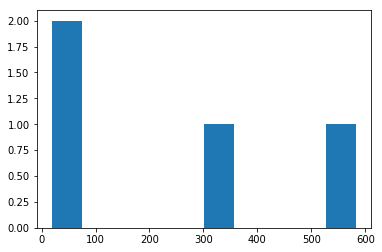

In [22]:
plt.pie([dic['normal_detect'],dic['normal_undetect'],dic['abnormal_detect'],dic['abnormal_undetect']], labels = ['Normal Predict', 'Normal Unpredict', 'Abnormal Predict','Abnormal Unpredict'], autopct = '%1.1f%%')
plt.title('Number of predicted data')
plt.axis('equal')
plt.legend(loc='best')
plt.savefig('YOLO_result.pdf',dpi=100)

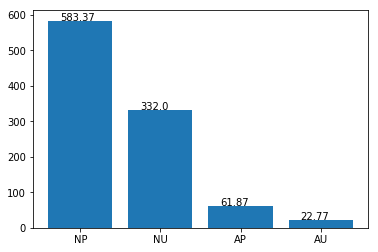

In [48]:
x = np.arange(4)
y = [round(dic['normal_detect'],2),round(dic['normal_undetect'],2),round(dic['abnormal_detect'],2),round(dic['abnormal_undetect'],2)]
plt.bar(x, height= y)
plt.xticks(x, ['NP', 'NU', 'AP','AU'])
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.savefig('YOLO_result.pdf',dpi=100)

# Test YOLO+MLP

In [38]:
data_number = 1000
test_path = "../training/"
tmp = os.listdir(test_path)
dir_list = []
for i in range(len(tmp)):
    if 'jpg' in tmp[i]:
        dir_list.append(tmp[i])


total_result = [0,0,0,0]
for count in range(30):
    dic = {'normal_detect':0,'normal_undetect':0,'abnormal_detect':0,'abnormal_undetect':0}
    correct = 0
    for i in range(data_number):    
        r = rd.randint(0,len(dir_list)-1)
        file = test_path + dir_list[r]
        #print(file)
        imgcv = cv2.imread(path2+file)
        origin = imgcv
        imgcv = detect(imgcv)

        if len(imgcv) != 0:
            imgcvt = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
            imgcvt = cv2.resize(imgcvt, (200,200))
            imgcvt = imgcvt.flatten()
            test1 = np.array([]).reshape((0 ,img2.shape[0]))
            test1 = np.row_stack([test1, imgcvt.flatten()])
            test1 /= 255.
            testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
            testy1 = np.row_stack([testy1, class_y[0]])
            tr_pred = sess.run([y_pred], feed_dict={
                        input_data:test1,
                    })
            if tr_pred[0][0][1] < 0.95:
                if 'ab' in file:
                    correct+=1
                    print('data detected:', dir_list[r])
                    dic['abnormal_detect']+=1
                else:
                    print('data undetected:', dir_list[r])
                    dic['normal_undetect']+=1
            else:
                if 'ab' not in file:
                    correct+=1
                    print('data detected:', dir_list[r])
                    dic['normal_detect']+=1
                else:
                    print('data undetected:', dir_list[r])
                    dic['abnormal_undetect']+=1
        else:
            imgcvt = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
            imgcvt = cv2.resize(imgcvt, (200,200))
            imgcvt = imgcvt.flatten()
            test1 = np.array([]).reshape((0 ,img2.shape[0]))
            test1 = np.row_stack([test1, imgcvt.flatten()])
            test1 /= 255.
            testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
            testy1 = np.row_stack([testy1, class_y[0]])
            tr_pred = sess.run([y_pred], feed_dict={
                        input_data:test1,
                    })
            if tr_pred[0][0][1] < 0.95:
                if 'ab' in file:
                    correct+=1
                    print('data detected:', dir_list[r])
                    dic['abnormal_detect']+=1
                else:
                    print('data undetected:', dir_list[r])
                    dic['normal_undetect']+=1
            else:
                if 'ab' not in file:
                    correct+=1
                    print('data detected:', dir_list[r])
                    dic['normal_detect']+=1
                else:
                    print('data undetected:', dir_list[r])
                    dic['abnormal_undetect']+=1

    print('Correct:',correct,'/ Total:',data_number)
    print('Accuracy:', correct/data_number)
    print(dic)
    total_result[0]+= dic['normal_detect']
    total_result[1]+= dic['normal_undetect']
    total_result[2]+= dic['abnormal_detect']
    total_result[3]+= dic['abnormal_undetect']
dic['normal_detect'] = total_result[0]/30
dic['normal_undetect'] = total_result[1]/30
dic['abnormal_detect'] = total_result[2]/30
dic['abnormal_undetect'] = total_result[3]/30
print(dic)

data detected: normal_img_6448.jpg
data detected: normal_img_6408.jpg
data detected: normal_img_1818.jpg
data detected: normal_img_6201.jpg
data detected: normal_img_1129.jpg
data detected: normal_img_4184.jpg
data detected: abnormal_img_146.jpg
data detected: normal_img_5963.jpg
data detected: normal_img_2417.jpg
data detected: normal_img_1564.jpg
data detected: normal_img_5366.jpg
data detected: normal_img_4540.jpg
data detected: abnormal_img_486.jpg
data detected: normal_img_5367.jpg
data detected: normal_img_893.jpg
data detected: abnormal_img_236.jpg
data detected: normal_img_3709.jpg
data detected: normal_img_1531.jpg
data detected: normal_img_6488.jpg
data detected: normal_img_3000.jpg
data detected: normal_img_2756.jpg
data detected: normal_img_3208.jpg
data detected: normal_img_6666.jpg
data detected: normal_img_4648.jpg
data detected: abnormal_img_471.jpg
data detected: abnormal_img_153.jpg
data undetected: abnormal_img_275.jpg
data detected: normal_img_5344.jpg
data detected

data detected: normal_img_2568.jpg
data detected: normal_img_5780.jpg
data detected: normal_img_5839.jpg
data detected: normal_img_2925.jpg
data detected: normal_img_2772.jpg
data detected: normal_img_2977.jpg
data detected: normal_img_1722.jpg
data detected: normal_img_4724.jpg
data detected: normal_img_3255.jpg
data detected: normal_img_1476.jpg
data detected: normal_img_4209.jpg
data detected: normal_img_2850.jpg
data detected: abnormal_img_210.jpg
data detected: normal_img_3983.jpg
data detected: normal_img_2457.jpg
data detected: normal_img_5643.jpg
data detected: normal_img_3141.jpg
data detected: abnormal_img_359.jpg
data detected: normal_img_78.jpg
data detected: normal_img_6375.jpg
data detected: normal_img_5419.jpg
data detected: normal_img_5522.jpg
data detected: normal_img_4603.jpg
data detected: normal_img_5304.jpg
data detected: abnormal_img_21.jpg
data detected: normal_img_5492.jpg
data detected: normal_img_1774.jpg
data detected: normal_img_2648.jpg
data detected: norma

data detected: normal_img_1395.jpg
data detected: normal_img_6260.jpg
data detected: normal_img_1398.jpg
data detected: normal_img_6790.jpg
data detected: normal_img_1999.jpg
data detected: normal_img_675.jpg
data detected: normal_img_367.jpg
data detected: normal_img_6142.jpg
data detected: normal_img_189.jpg
data detected: normal_img_119.jpg
data detected: normal_img_2023.jpg
data detected: normal_img_5565.jpg
data detected: normal_img_1967.jpg
data detected: normal_img_5452.jpg
data detected: normal_img_5279.jpg
data detected: abnormal_img_115.jpg
data detected: abnormal_img_565.jpg
data detected: normal_img_6763.jpg
data detected: normal_img_5183.jpg
data detected: normal_img_5610.jpg
data detected: normal_img_3174.jpg
data detected: normal_img_3823.jpg
data detected: normal_img_3040.jpg
data detected: normal_img_1242.jpg
data detected: normal_img_1960.jpg
data detected: normal_img_4833.jpg
data detected: normal_img_1036.jpg
data detected: normal_img_4766.jpg
data detected: normal_

data detected: normal_img_5808.jpg
data detected: normal_img_3695.jpg
data detected: normal_img_1079.jpg
data detected: normal_img_3180.jpg
data detected: normal_img_175.jpg
data detected: normal_img_1488.jpg
data detected: normal_img_5399.jpg
data detected: normal_img_4876.jpg
data detected: normal_img_1505.jpg
data detected: normal_img_2741.jpg
data detected: normal_img_1818.jpg
data detected: normal_img_2008.jpg
data detected: normal_img_2413.jpg
data detected: normal_img_4506.jpg
data detected: normal_img_1266.jpg
data detected: normal_img_5483.jpg
data detected: normal_img_140.jpg
data detected: normal_img_253.jpg
data detected: normal_img_5674.jpg
data detected: normal_img_786.jpg
data detected: normal_img_1271.jpg
data detected: normal_img_3214.jpg
data detected: normal_img_3272.jpg
data detected: normal_img_4356.jpg
data detected: normal_img_2368.jpg
data detected: normal_img_2045.jpg
data detected: normal_img_6263.jpg
data detected: normal_img_2355.jpg
data detected: normal_im

data detected: normal_img_3522.jpg
data detected: normal_img_1741.jpg
data detected: normal_img_2889.jpg
data detected: normal_img_5605.jpg
data detected: normal_img_2304.jpg
data detected: normal_img_4813.jpg
data detected: normal_img_3639.jpg
data detected: normal_img_3779.jpg
data detected: normal_img_3201.jpg
data detected: normal_img_1067.jpg
data detected: normal_img_2651.jpg
data detected: normal_img_6150.jpg
data detected: normal_img_6262.jpg
data detected: abnormal_img_567.jpg
data detected: normal_img_2895.jpg
data detected: normal_img_880.jpg
data detected: normal_img_3060.jpg
data detected: normal_img_4840.jpg
data undetected: abnormal_img_291.jpg
data detected: normal_img_3729.jpg
data detected: normal_img_3333.jpg
data detected: normal_img_6090.jpg
data detected: normal_img_6619.jpg
data detected: normal_img_1636.jpg
data detected: normal_img_2580.jpg
data detected: normal_img_6223.jpg
data detected: normal_img_5844.jpg
data detected: normal_img_4057.jpg
data detected: no

data detected: normal_img_3519.jpg
data detected: normal_img_401.jpg
data detected: normal_img_3707.jpg
data detected: normal_img_761.jpg
data undetected: abnormal_img_633.jpg
data detected: abnormal_img_489.jpg
data detected: normal_img_4290.jpg
data detected: normal_img_1573.jpg
data detected: normal_img_3223.jpg
data detected: normal_img_6493.jpg
data detected: normal_img_1526.jpg
data detected: normal_img_3597.jpg
data detected: normal_img_4246.jpg
data detected: normal_img_1028.jpg
data detected: normal_img_1274.jpg
data detected: normal_img_1454.jpg
data detected: normal_img_5666.jpg
data detected: normal_img_3567.jpg
data detected: normal_img_2812.jpg
data detected: normal_img_4624.jpg
data detected: normal_img_2737.jpg
data detected: abnormal_img_135.jpg
data detected: normal_img_6747.jpg
data detected: normal_img_3115.jpg
data detected: normal_img_4878.jpg
data detected: normal_img_4042.jpg
data detected: normal_img_6392.jpg
data detected: normal_img_6117.jpg
data detected: no

data detected: normal_img_5616.jpg
data detected: normal_img_5090.jpg
data detected: abnormal_img_582.jpg
data detected: normal_img_3392.jpg
data detected: normal_img_972.jpg
data detected: normal_img_499.jpg
data detected: normal_img_2578.jpg
data undetected: abnormal_img_249.jpg
data detected: normal_img_8.jpg
data detected: normal_img_5150.jpg
data detected: normal_img_5437.jpg
data detected: abnormal_img_624.jpg
data detected: normal_img_4245.jpg
data detected: normal_img_4984.jpg
data detected: normal_img_6491.jpg
data detected: normal_img_2812.jpg
data detected: normal_img_6502.jpg
data detected: normal_img_6180.jpg
data detected: normal_img_6581.jpg
data detected: normal_img_3179.jpg
data detected: normal_img_663.jpg
data detected: normal_img_1505.jpg
data undetected: abnormal_img_256.jpg
data detected: abnormal_img_104.jpg
data detected: normal_img_1372.jpg
data detected: normal_img_397.jpg
data detected: normal_img_2012.jpg
data detected: normal_img_3694.jpg
data detected: nor

data detected: normal_img_3969.jpg
data detected: normal_img_3703.jpg
data detected: normal_img_5809.jpg
data detected: normal_img_6646.jpg
data detected: abnormal_img_190.jpg
data detected: abnormal_img_478.jpg
data detected: normal_img_6004.jpg
data detected: normal_img_5890.jpg
data detected: normal_img_2604.jpg
data detected: normal_img_5703.jpg
data detected: normal_img_584.jpg
data detected: normal_img_1044.jpg
data detected: normal_img_511.jpg
data detected: normal_img_2064.jpg
data detected: normal_img_4210.jpg
data detected: normal_img_5838.jpg
data detected: normal_img_5539.jpg
data detected: normal_img_6508.jpg
data detected: normal_img_3764.jpg
data detected: abnormal_img_471.jpg
data detected: normal_img_5465.jpg
data detected: normal_img_1033.jpg
data undetected: abnormal_img_285.jpg
data detected: normal_img_5446.jpg
data detected: normal_img_389.jpg
data detected: normal_img_6782.jpg
data detected: normal_img_4557.jpg
data detected: normal_img_1146.jpg
data detected: no

data detected: normal_img_2878.jpg
data detected: abnormal_img_325.jpg
data detected: normal_img_2754.jpg
data detected: normal_img_5824.jpg
data detected: normal_img_5627.jpg
data detected: normal_img_1170.jpg
data detected: normal_img_6194.jpg
data detected: normal_img_1114.jpg
data detected: normal_img_6088.jpg
data detected: normal_img_2161.jpg
data detected: normal_img_3571.jpg
data detected: normal_img_5605.jpg
data detected: normal_img_830.jpg
data detected: normal_img_4131.jpg
data detected: normal_img_4266.jpg
data detected: abnormal_img_100.jpg
data detected: normal_img_4885.jpg
data detected: normal_img_331.jpg
data detected: normal_img_274.jpg
data detected: normal_img_3128.jpg
data detected: normal_img_5080.jpg
data detected: normal_img_6208.jpg
data detected: normal_img_2702.jpg
data detected: normal_img_5347.jpg
data detected: normal_img_5167.jpg
data detected: normal_img_3359.jpg
data detected: normal_img_338.jpg
data detected: normal_img_5399.jpg
data detected: normal_

data detected: normal_img_1646.jpg
data detected: normal_img_2334.jpg
data detected: normal_img_816.jpg
data detected: normal_img_1946.jpg
data detected: normal_img_320.jpg
data detected: normal_img_1345.jpg
data detected: normal_img_4194.jpg
data detected: normal_img_3544.jpg
data detected: normal_img_4106.jpg
data detected: normal_img_1250.jpg
data detected: normal_img_3216.jpg
data detected: normal_img_2245.jpg
data detected: normal_img_4341.jpg
data detected: normal_img_1498.jpg
data detected: normal_img_1312.jpg
data detected: normal_img_2325.jpg
data detected: abnormal_img_471.jpg
data detected: normal_img_2558.jpg
data detected: normal_img_3634.jpg
data detected: normal_img_5505.jpg
data detected: normal_img_2322.jpg
data detected: normal_img_1979.jpg
data detected: normal_img_2367.jpg
data detected: normal_img_3995.jpg
data detected: normal_img_4044.jpg
data detected: normal_img_1100.jpg
data detected: normal_img_1231.jpg
data detected: normal_img_3313.jpg
data detected: normal

data detected: normal_img_98.jpg
data detected: normal_img_3563.jpg
data detected: normal_img_280.jpg
data detected: normal_img_4115.jpg
data detected: normal_img_5184.jpg
data detected: normal_img_4485.jpg
data detected: normal_img_5153.jpg
data detected: normal_img_4822.jpg
data detected: normal_img_2760.jpg
data detected: normal_img_5112.jpg
data detected: normal_img_6276.jpg
data detected: normal_img_3254.jpg
data detected: normal_img_2120.jpg
data detected: normal_img_5629.jpg
data detected: normal_img_3636.jpg
data detected: normal_img_2070.jpg
data detected: normal_img_6294.jpg
data detected: normal_img_2941.jpg
data detected: normal_img_561.jpg
data detected: normal_img_3708.jpg
data detected: normal_img_1084.jpg
data detected: normal_img_5767.jpg
data detected: normal_img_4730.jpg
data detected: normal_img_1030.jpg
data detected: normal_img_6116.jpg
data detected: normal_img_722.jpg
data detected: normal_img_4995.jpg
data detected: normal_img_2155.jpg
data detected: normal_img

data detected: normal_img_6141.jpg
data detected: normal_img_423.jpg
data detected: normal_img_862.jpg
data detected: normal_img_3969.jpg
data detected: normal_img_1386.jpg
data detected: normal_img_4590.jpg
data detected: normal_img_6060.jpg
data detected: normal_img_2527.jpg
data detected: normal_img_6606.jpg
data detected: normal_img_3102.jpg
data detected: normal_img_2931.jpg
data detected: normal_img_241.jpg
data detected: normal_img_1585.jpg
data detected: normal_img_3626.jpg
data detected: normal_img_6754.jpg
data detected: normal_img_6608.jpg
data detected: normal_img_4328.jpg
data detected: normal_img_2280.jpg
data detected: normal_img_5987.jpg
data detected: normal_img_1887.jpg
data detected: normal_img_3770.jpg
data detected: normal_img_3553.jpg
data detected: normal_img_4584.jpg
data detected: normal_img_1907.jpg
data detected: abnormal_img_227.jpg
data detected: normal_img_1828.jpg
data detected: normal_img_4272.jpg
data detected: normal_img_6389.jpg
data detected: normal_

data detected: normal_img_2041.jpg
data detected: normal_img_322.jpg
data detected: normal_img_6026.jpg
data detected: normal_img_4989.jpg
data detected: normal_img_4765.jpg
data detected: normal_img_337.jpg
data detected: normal_img_185.jpg
data detected: normal_img_3899.jpg
data detected: normal_img_5713.jpg
data detected: normal_img_3829.jpg
data detected: normal_img_3730.jpg
data detected: normal_img_2261.jpg
data detected: normal_img_5505.jpg
data detected: normal_img_6678.jpg
data detected: normal_img_3406.jpg
data detected: normal_img_547.jpg
data detected: normal_img_1882.jpg
data detected: normal_img_222.jpg
data detected: normal_img_4571.jpg
data detected: normal_img_1030.jpg
data detected: normal_img_5960.jpg
data detected: normal_img_1263.jpg
data detected: normal_img_4391.jpg
data detected: normal_img_345.jpg
data detected: normal_img_2931.jpg
data detected: normal_img_3728.jpg
data detected: normal_img_3210.jpg
data detected: normal_img_5718.jpg
data detected: normal_img_

data detected: normal_img_2484.jpg
data detected: normal_img_1146.jpg
data detected: normal_img_6640.jpg
data detected: normal_img_3762.jpg
data detected: normal_img_1243.jpg
data detected: normal_img_3770.jpg
data detected: normal_img_1732.jpg
data detected: normal_img_4880.jpg
data detected: normal_img_4963.jpg
data detected: normal_img_3894.jpg
data detected: normal_img_419.jpg
data detected: normal_img_6456.jpg
data detected: normal_img_3051.jpg
data detected: normal_img_3678.jpg
data detected: normal_img_1001.jpg
data detected: normal_img_6356.jpg
data detected: normal_img_4544.jpg
data detected: normal_img_5237.jpg
data detected: normal_img_3888.jpg
data detected: normal_img_6627.jpg
data detected: normal_img_6283.jpg
data detected: abnormal_img_583.jpg
data detected: normal_img_6716.jpg
data detected: normal_img_4105.jpg
data detected: normal_img_363.jpg
data detected: normal_img_5463.jpg
data detected: normal_img_5575.jpg
data detected: normal_img_3161.jpg
data detected: normal

data detected: normal_img_4784.jpg
data detected: normal_img_722.jpg
data detected: normal_img_6065.jpg
data detected: normal_img_4854.jpg
data detected: normal_img_4476.jpg
data detected: normal_img_3164.jpg
data detected: normal_img_781.jpg
data detected: normal_img_4673.jpg
data undetected: abnormal_img_432.jpg
data detected: normal_img_6389.jpg
data detected: abnormal_img_363.jpg
data detected: normal_img_4216.jpg
data detected: normal_img_6594.jpg
data detected: normal_img_316.jpg
data detected: normal_img_6316.jpg
data detected: normal_img_2040.jpg
data detected: normal_img_2054.jpg
data detected: normal_img_3648.jpg
data detected: normal_img_2054.jpg
data detected: normal_img_3887.jpg
data detected: normal_img_2274.jpg
data detected: normal_img_2795.jpg
data detected: normal_img_6380.jpg
data detected: normal_img_3979.jpg
data detected: normal_img_6415.jpg
data detected: normal_img_2371.jpg
data detected: normal_img_5911.jpg
data detected: normal_img_3255.jpg
data detected: norm

data detected: normal_img_1339.jpg
data detected: abnormal_img_629.jpg
data detected: normal_img_5401.jpg
data detected: normal_img_6716.jpg
data detected: normal_img_5435.jpg
data detected: normal_img_4802.jpg
data detected: normal_img_4749.jpg
data detected: normal_img_4528.jpg
data detected: normal_img_4653.jpg
data detected: normal_img_4340.jpg
data detected: normal_img_1437.jpg
data undetected: abnormal_img_426.jpg
data detected: normal_img_1950.jpg
data detected: normal_img_6059.jpg
data detected: normal_img_5030.jpg
data detected: normal_img_3863.jpg
data detected: normal_img_2678.jpg
data detected: normal_img_3098.jpg
data detected: normal_img_6524.jpg
data detected: normal_img_4903.jpg
data detected: normal_img_5894.jpg
data detected: normal_img_1024.jpg
data detected: normal_img_227.jpg
data detected: normal_img_3550.jpg
data detected: normal_img_2199.jpg
data detected: normal_img_3974.jpg
data detected: abnormal_img_141.jpg
data detected: normal_img_4323.jpg
data detected: n

data detected: normal_img_4464.jpg
data detected: normal_img_5673.jpg
data detected: normal_img_551.jpg
data detected: abnormal_img_2.jpg
data detected: normal_img_6201.jpg
data detected: normal_img_4615.jpg
data detected: normal_img_5971.jpg
data detected: normal_img_4433.jpg
data detected: normal_img_4975.jpg
data detected: normal_img_4225.jpg
data detected: normal_img_4499.jpg
data detected: normal_img_2135.jpg
data detected: normal_img_781.jpg
data detected: normal_img_606.jpg
data detected: normal_img_903.jpg
data undetected: abnormal_img_255.jpg
data detected: normal_img_3551.jpg
data detected: normal_img_818.jpg
data detected: normal_img_4163.jpg
data detected: normal_img_1358.jpg
data detected: normal_img_43.jpg
data detected: normal_img_3590.jpg
data detected: normal_img_3615.jpg
data detected: normal_img_5638.jpg
data detected: abnormal_img_66.jpg
data detected: normal_img_6296.jpg
data detected: normal_img_5631.jpg
data detected: normal_img_6750.jpg
data detected: normal_img

data detected: normal_img_5735.jpg
data undetected: abnormal_img_638.jpg
data detected: normal_img_2127.jpg
data detected: normal_img_5171.jpg
data detected: normal_img_1353.jpg
data detected: normal_img_4690.jpg
data detected: abnormal_img_511.jpg
Correct: 984 / Total: 1000
Accuracy: 0.984
{'normal_detect': 925, 'normal_undetect': 0, 'abnormal_detect': 59, 'abnormal_undetect': 16}
data detected: normal_img_4062.jpg
data detected: abnormal_img_499.jpg
data detected: normal_img_1365.jpg
data detected: normal_img_3305.jpg
data detected: normal_img_5719.jpg
data detected: normal_img_6536.jpg
data detected: normal_img_3646.jpg
data detected: normal_img_1009.jpg
data detected: normal_img_57.jpg
data detected: normal_img_5115.jpg
data detected: normal_img_5650.jpg
data undetected: abnormal_img_636.jpg
data detected: normal_img_3185.jpg
data detected: normal_img_5120.jpg
data detected: normal_img_2476.jpg
data detected: normal_img_192.jpg
data detected: normal_img_3394.jpg
data detected: norm

data detected: normal_img_3766.jpg
data detected: normal_img_4633.jpg
data detected: normal_img_5876.jpg
data detected: normal_img_1227.jpg
data detected: normal_img_6667.jpg
data detected: normal_img_3877.jpg
data detected: normal_img_3342.jpg
data detected: normal_img_1123.jpg
data detected: normal_img_5190.jpg
data detected: normal_img_1931.jpg
data detected: normal_img_2386.jpg
data detected: normal_img_6298.jpg
data detected: normal_img_4580.jpg
data detected: normal_img_6108.jpg
data undetected: abnormal_img_277.jpg
data detected: normal_img_4160.jpg
data detected: normal_img_2197.jpg
data detected: normal_img_6049.jpg
data detected: normal_img_1483.jpg
data detected: normal_img_2034.jpg
data detected: normal_img_2935.jpg
data detected: normal_img_6462.jpg
data detected: abnormal_img_589.jpg
data detected: normal_img_6456.jpg
data detected: normal_img_4375.jpg
data detected: normal_img_5597.jpg
data detected: normal_img_4134.jpg
data detected: normal_img_6743.jpg
data detected: n

data detected: normal_img_2316.jpg
data detected: normal_img_6065.jpg
data detected: normal_img_5445.jpg
data detected: normal_img_6101.jpg
data detected: normal_img_6190.jpg
data detected: normal_img_291.jpg
data detected: normal_img_5113.jpg
data detected: normal_img_658.jpg
data detected: normal_img_5631.jpg
data detected: normal_img_6275.jpg
data detected: normal_img_2523.jpg
data detected: normal_img_310.jpg
data detected: normal_img_5577.jpg
data detected: normal_img_6274.jpg
data detected: abnormal_img_233.jpg
data detected: normal_img_11.jpg
data detected: normal_img_3897.jpg
data detected: normal_img_6649.jpg
data detected: normal_img_1174.jpg
data detected: normal_img_5328.jpg
data detected: normal_img_6529.jpg
data detected: normal_img_3510.jpg
data detected: normal_img_6504.jpg
data detected: normal_img_1994.jpg
data detected: normal_img_1625.jpg
data detected: normal_img_6557.jpg
data detected: normal_img_1695.jpg
data detected: normal_img_6562.jpg
data detected: abnormal_

data detected: normal_img_3642.jpg
data detected: normal_img_2998.jpg
data detected: abnormal_img_492.jpg
data detected: normal_img_460.jpg
data detected: normal_img_4080.jpg
data detected: normal_img_6028.jpg
data detected: normal_img_371.jpg
data detected: normal_img_5107.jpg
data detected: normal_img_4488.jpg
data detected: normal_img_4756.jpg
data detected: normal_img_2742.jpg
data detected: normal_img_5888.jpg
data detected: normal_img_1668.jpg
data detected: normal_img_3842.jpg
data detected: normal_img_3421.jpg
data detected: normal_img_3912.jpg
data detected: normal_img_6038.jpg
data detected: normal_img_1581.jpg
data detected: normal_img_6310.jpg
data detected: normal_img_4165.jpg
data detected: normal_img_4087.jpg
data detected: normal_img_1091.jpg
data detected: normal_img_1486.jpg
data detected: normal_img_4504.jpg
data detected: normal_img_3091.jpg
data detected: normal_img_2856.jpg
data detected: normal_img_6391.jpg
data detected: normal_img_2272.jpg
data detected: normal

data detected: normal_img_1917.jpg
data detected: normal_img_4295.jpg
data detected: normal_img_6070.jpg
data detected: normal_img_1155.jpg
data detected: normal_img_5047.jpg
data detected: normal_img_240.jpg
data detected: normal_img_3207.jpg
data detected: normal_img_3071.jpg
data detected: normal_img_3190.jpg
data detected: normal_img_2577.jpg
data detected: normal_img_4737.jpg
data detected: normal_img_4219.jpg
data detected: normal_img_1239.jpg
data detected: normal_img_2951.jpg
data undetected: abnormal_img_308.jpg
data detected: normal_img_3916.jpg
data detected: normal_img_1916.jpg
data detected: normal_img_195.jpg
data detected: normal_img_6635.jpg
data detected: normal_img_5012.jpg
data detected: normal_img_3585.jpg
data detected: normal_img_4870.jpg
data detected: normal_img_3640.jpg
data detected: normal_img_3156.jpg
data detected: normal_img_268.jpg
data detected: normal_img_3045.jpg
data detected: normal_img_6442.jpg
data detected: normal_img_2884.jpg
data detected: norma

data detected: normal_img_1132.jpg
data detected: normal_img_3171.jpg
data detected: normal_img_6683.jpg
data detected: normal_img_6118.jpg
data detected: normal_img_5449.jpg
data detected: normal_img_4374.jpg
data detected: normal_img_3905.jpg
data detected: normal_img_5470.jpg
data detected: normal_img_1442.jpg
data detected: normal_img_6681.jpg
data detected: normal_img_1320.jpg
data detected: normal_img_841.jpg
data detected: abnormal_img_608.jpg
data detected: normal_img_4789.jpg
data detected: normal_img_6182.jpg
data detected: normal_img_1777.jpg
data detected: normal_img_3293.jpg
data detected: normal_img_1407.jpg
data detected: abnormal_img_470.jpg
data detected: normal_img_825.jpg
data detected: normal_img_997.jpg
data detected: normal_img_1440.jpg
data detected: normal_img_3536.jpg
data detected: normal_img_3306.jpg
data detected: normal_img_5544.jpg
data detected: normal_img_5879.jpg
data detected: normal_img_6109.jpg
data detected: normal_img_4071.jpg
data detected: normal

data detected: normal_img_2159.jpg
data detected: normal_img_3123.jpg
data detected: normal_img_466.jpg
data detected: normal_img_2467.jpg
data detected: normal_img_1379.jpg
data detected: normal_img_2452.jpg
data detected: normal_img_4932.jpg
data detected: normal_img_4997.jpg
data detected: abnormal_img_80.jpg
data detected: normal_img_5642.jpg
data detected: normal_img_567.jpg
data detected: normal_img_2445.jpg
data detected: normal_img_6389.jpg
data detected: normal_img_1681.jpg
data detected: normal_img_5597.jpg
data detected: normal_img_4093.jpg
data detected: normal_img_1379.jpg
data detected: normal_img_5145.jpg
data detected: normal_img_1733.jpg
data detected: normal_img_5086.jpg
data detected: normal_img_2309.jpg
data detected: normal_img_4672.jpg
data detected: normal_img_5194.jpg
data detected: normal_img_3819.jpg
data detected: normal_img_4164.jpg
data detected: normal_img_3238.jpg
data detected: abnormal_img_164.jpg
data detected: normal_img_1394.jpg
data detected: normal

data undetected: abnormal_img_417.jpg
data undetected: abnormal_img_250.jpg
data detected: normal_img_2900.jpg
data detected: normal_img_6300.jpg
data detected: normal_img_5032.jpg
data detected: normal_img_892.jpg
data detected: normal_img_624.jpg
data detected: normal_img_328.jpg
data detected: normal_img_1455.jpg
data detected: normal_img_3543.jpg
data detected: normal_img_2167.jpg
data detected: normal_img_4462.jpg
data detected: normal_img_4872.jpg
data detected: normal_img_4776.jpg
data detected: normal_img_2788.jpg
data detected: normal_img_2873.jpg
data detected: normal_img_2663.jpg
data detected: abnormal_img_592.jpg
data detected: normal_img_1077.jpg
data detected: normal_img_6452.jpg
data detected: normal_img_4128.jpg
data detected: normal_img_1426.jpg
data detected: normal_img_5515.jpg
data detected: normal_img_1275.jpg
data detected: normal_img_2159.jpg
data detected: normal_img_1708.jpg
data detected: normal_img_442.jpg
data detected: normal_img_1072.jpg
data detected: no

data detected: normal_img_689.jpg
data detected: normal_img_6682.jpg
data detected: normal_img_924.jpg
data detected: normal_img_3971.jpg
data detected: normal_img_4536.jpg
data detected: abnormal_img_1.jpg
data detected: normal_img_1234.jpg
data detected: normal_img_4474.jpg
data detected: normal_img_4744.jpg
data detected: normal_img_446.jpg
data detected: normal_img_3072.jpg
data detected: normal_img_1864.jpg
data detected: abnormal_img_366.jpg
data detected: normal_img_6770.jpg
data detected: normal_img_186.jpg
data undetected: abnormal_img_315.jpg
data detected: normal_img_3743.jpg
data detected: abnormal_img_12.jpg
data detected: normal_img_5167.jpg
data detected: normal_img_6022.jpg
data detected: normal_img_6768.jpg
data undetected: abnormal_img_261.jpg
data detected: normal_img_6604.jpg
data detected: normal_img_5175.jpg
data detected: normal_img_4185.jpg
data detected: normal_img_2984.jpg
data detected: normal_img_3783.jpg
data detected: normal_img_3679.jpg
data detected: nor

data detected: normal_img_5932.jpg
data detected: abnormal_img_9.jpg
data detected: normal_img_5719.jpg
data detected: normal_img_63.jpg
data detected: normal_img_6172.jpg
data detected: normal_img_1214.jpg
data detected: normal_img_1149.jpg
data detected: normal_img_5936.jpg
data detected: normal_img_2240.jpg
data detected: abnormal_img_240.jpg
data detected: normal_img_862.jpg
data detected: normal_img_3589.jpg
data detected: normal_img_336.jpg
data detected: normal_img_3743.jpg
data detected: normal_img_1520.jpg
data detected: normal_img_1783.jpg
data detected: normal_img_187.jpg
data detected: normal_img_1947.jpg
data detected: normal_img_6262.jpg
data detected: normal_img_1011.jpg
data detected: normal_img_3744.jpg
data detected: normal_img_4262.jpg
data detected: normal_img_4657.jpg
data detected: normal_img_3280.jpg
data detected: normal_img_2371.jpg
data detected: normal_img_3674.jpg
data detected: abnormal_img_377.jpg
data detected: abnormal_img_225.jpg
data detected: normal_i

data detected: abnormal_img_552.jpg
data detected: normal_img_1597.jpg
data detected: normal_img_3214.jpg
data detected: normal_img_772.jpg
data detected: normal_img_5167.jpg
data detected: normal_img_5734.jpg
data detected: normal_img_4619.jpg
data detected: normal_img_6704.jpg
data detected: normal_img_3507.jpg
data detected: normal_img_180.jpg
data detected: normal_img_3585.jpg
data detected: normal_img_4356.jpg
data detected: normal_img_2787.jpg
data detected: normal_img_4902.jpg
data detected: normal_img_3634.jpg
data detected: normal_img_6110.jpg
data detected: normal_img_4044.jpg
data detected: normal_img_3788.jpg
data detected: abnormal_img_159.jpg
data detected: normal_img_811.jpg
data detected: normal_img_1630.jpg
data detected: normal_img_2171.jpg
data detected: normal_img_1130.jpg
data detected: normal_img_4762.jpg
data detected: normal_img_2101.jpg
data detected: normal_img_3592.jpg
data detected: normal_img_5950.jpg
data detected: normal_img_5157.jpg
data detected: normal

data detected: normal_img_5343.jpg
data detected: normal_img_5796.jpg
data detected: normal_img_1090.jpg
data detected: normal_img_1600.jpg
data detected: normal_img_4391.jpg
data detected: normal_img_653.jpg
data detected: normal_img_2652.jpg
data detected: normal_img_1209.jpg
data detected: normal_img_5849.jpg
data detected: abnormal_img_214.jpg
data detected: normal_img_2064.jpg
data detected: normal_img_6446.jpg
data detected: normal_img_4107.jpg
data detected: normal_img_5445.jpg
data detected: normal_img_4100.jpg
data detected: normal_img_3770.jpg
data detected: normal_img_4861.jpg
data detected: normal_img_803.jpg
data detected: normal_img_6789.jpg
data detected: normal_img_653.jpg
data detected: normal_img_3462.jpg
data detected: normal_img_520.jpg
data detected: abnormal_img_132.jpg
data detected: normal_img_891.jpg
data detected: normal_img_697.jpg
data detected: normal_img_5912.jpg
data detected: normal_img_6625.jpg
data detected: normal_img_5833.jpg
data detected: normal_im

data detected: abnormal_img_386.jpg
data detected: normal_img_3766.jpg
data detected: normal_img_208.jpg
data detected: normal_img_1208.jpg
data detected: normal_img_5560.jpg
data detected: normal_img_5896.jpg
data detected: normal_img_1210.jpg
data detected: normal_img_3245.jpg
data detected: normal_img_1167.jpg
data detected: normal_img_4703.jpg
data detected: normal_img_2357.jpg
data detected: abnormal_img_561.jpg
data detected: normal_img_6640.jpg
data detected: normal_img_5515.jpg
data detected: abnormal_img_568.jpg
data detected: normal_img_2974.jpg
data detected: normal_img_6758.jpg
data detected: normal_img_2296.jpg
data detected: normal_img_5477.jpg
data detected: normal_img_6304.jpg
data detected: normal_img_6068.jpg
data detected: normal_img_3308.jpg
data detected: normal_img_6429.jpg
data detected: normal_img_2054.jpg
data detected: normal_img_4778.jpg
data detected: normal_img_5056.jpg
data detected: normal_img_2729.jpg
data detected: abnormal_img_14.jpg
data detected: nor

data detected: normal_img_4773.jpg
data detected: normal_img_6224.jpg
data detected: normal_img_712.jpg
data detected: normal_img_1431.jpg
data detected: normal_img_838.jpg
data detected: normal_img_2225.jpg
data detected: normal_img_6303.jpg
data detected: normal_img_601.jpg
data detected: normal_img_1153.jpg
data detected: normal_img_1794.jpg
data detected: normal_img_6684.jpg
data detected: normal_img_5316.jpg
data detected: normal_img_1003.jpg
data detected: normal_img_6180.jpg
data detected: normal_img_5692.jpg
data detected: normal_img_234.jpg
data detected: normal_img_1204.jpg
data detected: normal_img_5689.jpg
data detected: normal_img_4077.jpg
data detected: normal_img_6241.jpg
data detected: normal_img_6751.jpg
data detected: abnormal_img_63.jpg
data detected: normal_img_4521.jpg
data detected: normal_img_1180.jpg
data detected: normal_img_1542.jpg
data detected: normal_img_2368.jpg
data detected: normal_img_3006.jpg
data detected: normal_img_3853.jpg
data detected: abnormal_

data detected: normal_img_6222.jpg
data detected: abnormal_img_143.jpg
data detected: abnormal_img_190.jpg
data detected: normal_img_5645.jpg
data detected: abnormal_img_119.jpg
data detected: normal_img_4964.jpg
data detected: normal_img_4527.jpg
data detected: normal_img_2253.jpg
data detected: normal_img_4510.jpg
data detected: normal_img_5833.jpg
data detected: normal_img_3092.jpg
data detected: normal_img_762.jpg
data detected: normal_img_4935.jpg
data detected: abnormal_img_632.jpg
data detected: normal_img_4860.jpg
data detected: normal_img_6534.jpg
data detected: abnormal_img_76.jpg
data detected: abnormal_img_178.jpg
data detected: normal_img_3720.jpg
data detected: normal_img_4488.jpg
data detected: abnormal_img_52.jpg
data detected: normal_img_3750.jpg
data detected: normal_img_3490.jpg
data detected: normal_img_4043.jpg
data detected: normal_img_2944.jpg
data detected: normal_img_1554.jpg
data detected: normal_img_6165.jpg
data detected: normal_img_59.jpg
data detected: nor

data detected: normal_img_3231.jpg
data undetected: abnormal_img_295.jpg
data detected: normal_img_1463.jpg
data detected: normal_img_5507.jpg
data detected: normal_img_315.jpg
data detected: normal_img_4871.jpg
data detected: normal_img_5424.jpg
data detected: normal_img_5992.jpg
data detected: normal_img_773.jpg
data detected: normal_img_2478.jpg
data detected: normal_img_5594.jpg
data detected: normal_img_1188.jpg
data detected: normal_img_847.jpg
data detected: normal_img_4208.jpg
data detected: normal_img_187.jpg
data detected: normal_img_5540.jpg
data detected: normal_img_17.jpg
data detected: normal_img_259.jpg
data detected: normal_img_744.jpg
data detected: normal_img_1252.jpg
data detected: normal_img_6076.jpg
data undetected: abnormal_img_309.jpg
data detected: normal_img_1758.jpg
data detected: abnormal_img_578.jpg
data detected: normal_img_2046.jpg
data detected: normal_img_2923.jpg
data detected: normal_img_3782.jpg
data detected: normal_img_4809.jpg
data detected: normal

data detected: normal_img_6390.jpg
data detected: normal_img_6051.jpg
data detected: normal_img_3914.jpg
data detected: normal_img_4734.jpg
data detected: normal_img_3112.jpg
data detected: normal_img_6465.jpg
data detected: abnormal_img_37.jpg
data detected: normal_img_5594.jpg
data detected: normal_img_2202.jpg
data detected: abnormal_img_466.jpg
data detected: normal_img_5730.jpg
data detected: normal_img_4987.jpg
data detected: normal_img_521.jpg
data detected: normal_img_4408.jpg
data detected: normal_img_3507.jpg
data detected: abnormal_img_527.jpg
data detected: normal_img_4500.jpg
data detected: normal_img_390.jpg
data detected: normal_img_1839.jpg
data detected: normal_img_1168.jpg
data detected: normal_img_3152.jpg
data detected: abnormal_img_489.jpg
data detected: normal_img_1752.jpg
data detected: normal_img_1668.jpg
data detected: normal_img_5014.jpg
data detected: normal_img_5791.jpg
data detected: normal_img_3595.jpg
data detected: abnormal_img_528.jpg
data detected: nor

data detected: normal_img_6488.jpg
data detected: normal_img_3094.jpg
data detected: normal_img_6625.jpg
data detected: normal_img_5606.jpg
data detected: normal_img_1265.jpg
data detected: normal_img_3157.jpg
data detected: normal_img_767.jpg
data detected: abnormal_img_64.jpg
data detected: normal_img_5091.jpg
data detected: normal_img_2025.jpg
Correct: 982 / Total: 1000
Accuracy: 0.982
{'normal_detect': 899, 'normal_undetect': 0, 'abnormal_detect': 83, 'abnormal_undetect': 18}
data detected: normal_img_3348.jpg
data detected: normal_img_360.jpg
data detected: normal_img_4309.jpg
data detected: normal_img_5384.jpg
data detected: normal_img_876.jpg
data detected: normal_img_3598.jpg
data detected: normal_img_21.jpg
data detected: normal_img_353.jpg
data detected: normal_img_5468.jpg
data detected: normal_img_517.jpg
data detected: normal_img_1311.jpg
data detected: normal_img_1456.jpg
data detected: normal_img_1104.jpg
data detected: normal_img_1457.jpg
data detected: normal_img_421.j

data detected: normal_img_6039.jpg
data detected: normal_img_2480.jpg
data detected: normal_img_3330.jpg
data detected: normal_img_1312.jpg
data detected: normal_img_2903.jpg
data detected: normal_img_4012.jpg
data detected: normal_img_1113.jpg
data detected: normal_img_3235.jpg
data detected: normal_img_6747.jpg
data detected: normal_img_5436.jpg
data detected: normal_img_3569.jpg
data detected: normal_img_2966.jpg
data detected: normal_img_4532.jpg
data detected: normal_img_3514.jpg
data detected: normal_img_1262.jpg
data undetected: abnormal_img_278.jpg
data detected: normal_img_3752.jpg
data detected: normal_img_610.jpg
data detected: normal_img_1583.jpg
data detected: normal_img_3980.jpg
data detected: normal_img_2948.jpg
data detected: normal_img_3398.jpg
data detected: normal_img_6790.jpg
data detected: normal_img_4705.jpg
data detected: normal_img_6042.jpg
data detected: normal_img_1399.jpg
data detected: normal_img_1912.jpg
data detected: normal_img_291.jpg
data detected: norm

data detected: normal_img_2963.jpg
data detected: normal_img_3499.jpg
data detected: normal_img_1204.jpg
data detected: normal_img_6709.jpg
data detected: normal_img_5721.jpg
data detected: normal_img_2510.jpg
data detected: normal_img_3914.jpg
data detected: normal_img_2976.jpg
data detected: normal_img_2548.jpg
data detected: abnormal_img_103.jpg
data detected: normal_img_2673.jpg
data detected: normal_img_4208.jpg
data detected: normal_img_3048.jpg
data detected: normal_img_5934.jpg
data detected: abnormal_img_446.jpg
data detected: normal_img_3890.jpg
data detected: normal_img_2466.jpg
data detected: normal_img_3059.jpg
data detected: normal_img_4674.jpg
data detected: normal_img_1443.jpg
data detected: normal_img_5017.jpg
data detected: normal_img_4883.jpg
data detected: abnormal_img_48.jpg
data detected: normal_img_4679.jpg
data detected: normal_img_939.jpg
data detected: normal_img_5889.jpg
data detected: normal_img_654.jpg
data detected: normal_img_5936.jpg
data detected: norma

data detected: normal_img_570.jpg
data detected: normal_img_4239.jpg
data detected: normal_img_5140.jpg
data detected: normal_img_3182.jpg
data detected: normal_img_899.jpg
data detected: normal_img_5247.jpg
data detected: normal_img_6562.jpg
data detected: normal_img_4853.jpg
data undetected: abnormal_img_293.jpg
data detected: normal_img_377.jpg
data detected: normal_img_4566.jpg
data detected: normal_img_4055.jpg
data detected: normal_img_6711.jpg
data detected: normal_img_2046.jpg
data detected: normal_img_973.jpg
data detected: normal_img_704.jpg
data detected: normal_img_3364.jpg
data detected: normal_img_4121.jpg
data detected: normal_img_5990.jpg
data detected: normal_img_1688.jpg
data detected: normal_img_5612.jpg
data detected: normal_img_2723.jpg
data detected: normal_img_5795.jpg
data detected: abnormal_img_466.jpg
data detected: abnormal_img_29.jpg
data detected: abnormal_img_242.jpg
data detected: normal_img_2374.jpg
data detected: normal_img_2767.jpg
data detected: norma

data detected: normal_img_1925.jpg
data detected: normal_img_3864.jpg
data detected: normal_img_355.jpg
data detected: normal_img_1033.jpg
data detected: abnormal_img_359.jpg
data detected: abnormal_img_24.jpg
data detected: normal_img_5600.jpg
data detected: abnormal_img_84.jpg
data detected: normal_img_591.jpg
data detected: normal_img_2880.jpg
data detected: normal_img_2994.jpg
data detected: normal_img_955.jpg
data detected: normal_img_170.jpg
data detected: normal_img_911.jpg
data detected: normal_img_1712.jpg
data detected: normal_img_4481.jpg
data detected: normal_img_2133.jpg
data detected: normal_img_6696.jpg
data detected: normal_img_3541.jpg
data detected: normal_img_2715.jpg
data detected: normal_img_2481.jpg
data detected: normal_img_898.jpg
data detected: normal_img_4399.jpg
data detected: normal_img_5696.jpg
data detected: normal_img_4638.jpg
data detected: normal_img_2961.jpg
data detected: normal_img_331.jpg
data detected: normal_img_5735.jpg
data detected: normal_img_

data detected: normal_img_6052.jpg
data detected: normal_img_3048.jpg
data detected: normal_img_1262.jpg
data detected: normal_img_5219.jpg
data detected: normal_img_3592.jpg
data detected: normal_img_1297.jpg
data detected: normal_img_866.jpg
data detected: normal_img_5351.jpg
data detected: normal_img_2648.jpg
data detected: normal_img_4823.jpg
data detected: normal_img_5741.jpg
data detected: normal_img_974.jpg
data detected: normal_img_6002.jpg
data detected: normal_img_1210.jpg
data detected: normal_img_933.jpg
data detected: normal_img_3481.jpg
data detected: normal_img_1490.jpg
data detected: normal_img_2664.jpg
data detected: normal_img_5423.jpg
data detected: normal_img_6739.jpg
data detected: normal_img_4651.jpg
data detected: normal_img_2652.jpg
data detected: normal_img_3337.jpg
data detected: normal_img_1278.jpg
data undetected: abnormal_img_437.jpg
data detected: normal_img_4402.jpg
data detected: normal_img_4567.jpg
data detected: normal_img_6189.jpg
data detected: abnor

data detected: normal_img_310.jpg
data detected: normal_img_158.jpg
data detected: normal_img_1144.jpg
data detected: normal_img_6712.jpg
data detected: abnormal_img_384.jpg
data detected: normal_img_2357.jpg
data detected: normal_img_2932.jpg
data detected: abnormal_img_519.jpg
data detected: normal_img_6384.jpg
data detected: normal_img_6115.jpg
data detected: normal_img_3958.jpg
data detected: normal_img_6423.jpg
data detected: normal_img_2062.jpg
data detected: normal_img_6016.jpg
data detected: normal_img_423.jpg
data detected: normal_img_2350.jpg
data detected: normal_img_4447.jpg
data detected: normal_img_4799.jpg
data detected: normal_img_934.jpg
data detected: normal_img_6686.jpg
data detected: abnormal_img_185.jpg
data detected: normal_img_222.jpg
data detected: normal_img_70.jpg
data detected: abnormal_img_327.jpg
data detected: normal_img_3065.jpg
data detected: normal_img_41.jpg
data detected: normal_img_4096.jpg
data detected: normal_img_6344.jpg
data detected: normal_img

data detected: normal_img_6082.jpg
data detected: normal_img_4078.jpg
data detected: normal_img_101.jpg
data detected: normal_img_1292.jpg
data detected: normal_img_139.jpg
data detected: normal_img_1997.jpg
data detected: normal_img_156.jpg
data detected: normal_img_3364.jpg
data detected: normal_img_2786.jpg
data detected: normal_img_812.jpg
data detected: normal_img_1905.jpg
data detected: normal_img_1356.jpg
data detected: normal_img_5710.jpg
data detected: normal_img_6406.jpg
data detected: normal_img_3627.jpg
data detected: normal_img_1868.jpg
data detected: normal_img_979.jpg
data detected: normal_img_6540.jpg
data detected: normal_img_3109.jpg
data detected: normal_img_1764.jpg
data detected: normal_img_1316.jpg
data detected: normal_img_5978.jpg
data detected: normal_img_3649.jpg
data detected: normal_img_1488.jpg
data detected: normal_img_829.jpg
data detected: normal_img_1987.jpg
data detected: normal_img_3046.jpg
data detected: normal_img_2710.jpg
data detected: normal_img_

data detected: normal_img_5822.jpg
data detected: abnormal_img_460.jpg
data detected: normal_img_2894.jpg
data detected: normal_img_2253.jpg
data undetected: abnormal_img_254.jpg
data detected: normal_img_5238.jpg
data detected: normal_img_483.jpg
data detected: normal_img_4876.jpg
data detected: normal_img_2821.jpg
data detected: normal_img_5968.jpg
data detected: normal_img_6557.jpg
data detected: normal_img_1699.jpg
data detected: normal_img_6137.jpg
data detected: normal_img_2628.jpg
data detected: normal_img_4070.jpg
data detected: normal_img_1353.jpg
data detected: normal_img_4237.jpg
data detected: normal_img_5341.jpg
data detected: normal_img_6066.jpg
data detected: normal_img_5212.jpg
data detected: normal_img_2040.jpg
data detected: normal_img_4139.jpg
data detected: normal_img_4915.jpg
data detected: normal_img_87.jpg
data detected: normal_img_3361.jpg
data detected: normal_img_2614.jpg
data undetected: abnormal_img_412.jpg
data detected: normal_img_3936.jpg
data detected: n

data detected: normal_img_814.jpg
data detected: normal_img_6557.jpg
data detected: normal_img_1932.jpg
data detected: normal_img_5840.jpg
data detected: normal_img_6181.jpg
data detected: normal_img_4221.jpg
data detected: normal_img_2585.jpg
data detected: normal_img_1124.jpg
data detected: normal_img_4278.jpg
data detected: normal_img_525.jpg
data detected: normal_img_4024.jpg
data detected: normal_img_6614.jpg
data detected: normal_img_3330.jpg
data detected: normal_img_3987.jpg
data detected: normal_img_5291.jpg
data detected: normal_img_4526.jpg
data detected: normal_img_4426.jpg
data detected: normal_img_6070.jpg
data detected: normal_img_4844.jpg
data detected: normal_img_2870.jpg
data detected: normal_img_5456.jpg
data detected: normal_img_349.jpg
data detected: normal_img_5819.jpg
data detected: normal_img_4607.jpg
data detected: normal_img_5547.jpg
data detected: normal_img_6159.jpg
data undetected: abnormal_img_286.jpg
data detected: normal_img_3596.jpg
data detected: norma

data detected: normal_img_791.jpg
data detected: normal_img_3453.jpg
data detected: normal_img_449.jpg
data detected: normal_img_4738.jpg
data detected: normal_img_2407.jpg
data detected: normal_img_1092.jpg
data detected: normal_img_3405.jpg
data detected: normal_img_3139.jpg
data detected: normal_img_883.jpg
data detected: normal_img_6627.jpg
data detected: normal_img_4257.jpg
data detected: normal_img_4983.jpg
data detected: normal_img_103.jpg
data detected: normal_img_6455.jpg
data detected: normal_img_5570.jpg
data detected: normal_img_3115.jpg
data detected: normal_img_4134.jpg
data detected: normal_img_28.jpg
data detected: normal_img_4693.jpg
data detected: abnormal_img_525.jpg
data detected: normal_img_5766.jpg
data detected: normal_img_841.jpg
data detected: normal_img_3652.jpg
data detected: normal_img_5839.jpg
data detected: normal_img_1206.jpg
data detected: normal_img_632.jpg
data detected: normal_img_5795.jpg
data detected: normal_img_6491.jpg
data detected: normal_img_1

data detected: normal_img_2597.jpg
data detected: normal_img_1148.jpg
data detected: normal_img_236.jpg
data detected: normal_img_591.jpg
data detected: abnormal_img_66.jpg
data detected: abnormal_img_632.jpg
data detected: abnormal_img_191.jpg
data detected: normal_img_2892.jpg
data detected: normal_img_2600.jpg
data detected: normal_img_4225.jpg
data detected: normal_img_5052.jpg
data detected: normal_img_5178.jpg
data detected: normal_img_28.jpg
data detected: normal_img_1544.jpg
data detected: normal_img_6326.jpg
data detected: normal_img_5254.jpg
data detected: normal_img_158.jpg
data detected: normal_img_2285.jpg
data detected: normal_img_4560.jpg
data detected: normal_img_5518.jpg
data detected: normal_img_6145.jpg
data detected: normal_img_1892.jpg
data detected: normal_img_3867.jpg
data detected: normal_img_4543.jpg
data detected: normal_img_3807.jpg
data detected: abnormal_img_326.jpg
data detected: normal_img_3466.jpg
data detected: normal_img_4796.jpg
data detected: normal_

data detected: abnormal_img_607.jpg
data detected: normal_img_240.jpg
data detected: normal_img_5413.jpg
data detected: normal_img_282.jpg
data detected: normal_img_2852.jpg
data detected: normal_img_1620.jpg
data detected: normal_img_3475.jpg
data detected: normal_img_6702.jpg
data detected: normal_img_6664.jpg
data detected: normal_img_5802.jpg
data detected: normal_img_6517.jpg
data detected: normal_img_896.jpg
data detected: normal_img_1365.jpg
data detected: abnormal_img_456.jpg
data detected: normal_img_69.jpg
data detected: normal_img_1201.jpg
data detected: abnormal_img_623.jpg
data detected: normal_img_761.jpg
data detected: normal_img_4812.jpg
data detected: normal_img_4635.jpg
data detected: normal_img_6629.jpg
data detected: normal_img_3920.jpg
data detected: normal_img_1621.jpg
data detected: normal_img_6418.jpg
data detected: normal_img_615.jpg
data detected: normal_img_1233.jpg
data detected: normal_img_5582.jpg
data detected: normal_img_721.jpg
data detected: normal_img

data detected: abnormal_img_89.jpg
data detected: normal_img_5121.jpg
data detected: normal_img_2939.jpg
data detected: normal_img_4561.jpg
data detected: normal_img_533.jpg
data detected: normal_img_864.jpg
data detected: normal_img_6279.jpg
data detected: normal_img_4241.jpg
data detected: normal_img_739.jpg
data detected: normal_img_5974.jpg
data detected: normal_img_2014.jpg
data detected: normal_img_1878.jpg
data detected: normal_img_5777.jpg
data undetected: abnormal_img_301.jpg
data detected: normal_img_1698.jpg
data detected: normal_img_2897.jpg
data detected: normal_img_339.jpg
data detected: normal_img_4832.jpg
data detected: normal_img_1620.jpg
data detected: normal_img_3920.jpg
data detected: normal_img_3938.jpg
data detected: normal_img_5704.jpg
data detected: normal_img_4675.jpg
data detected: normal_img_3853.jpg
data detected: normal_img_6211.jpg
data detected: normal_img_3614.jpg
data detected: normal_img_2946.jpg
data detected: normal_img_5440.jpg
data detected: normal

data detected: normal_img_5018.jpg
data detected: normal_img_3298.jpg
data detected: normal_img_3150.jpg
data detected: normal_img_1374.jpg
data detected: normal_img_776.jpg
data detected: normal_img_4742.jpg
data detected: normal_img_3915.jpg
data detected: normal_img_6427.jpg
data detected: normal_img_1801.jpg
data detected: normal_img_3700.jpg
data detected: normal_img_5655.jpg
data detected: normal_img_2214.jpg
data detected: normal_img_1108.jpg
data detected: normal_img_6515.jpg
data undetected: abnormal_img_268.jpg
data detected: normal_img_4705.jpg
data detected: normal_img_130.jpg
data detected: normal_img_3826.jpg
data detected: normal_img_4066.jpg
data detected: normal_img_3611.jpg
data detected: normal_img_250.jpg
data undetected: abnormal_img_255.jpg
data detected: normal_img_2118.jpg
data detected: normal_img_3146.jpg
data detected: normal_img_890.jpg
data detected: normal_img_3902.jpg
data detected: normal_img_4078.jpg
data detected: normal_img_6052.jpg
data detected: nor

data detected: normal_img_841.jpg
data detected: normal_img_673.jpg
data detected: normal_img_2743.jpg
data detected: normal_img_5386.jpg
data detected: normal_img_2999.jpg
data detected: normal_img_4794.jpg
data detected: normal_img_3776.jpg
data detected: normal_img_1330.jpg
data detected: normal_img_4787.jpg
data detected: normal_img_3715.jpg
data detected: normal_img_4399.jpg
data detected: normal_img_1279.jpg
data detected: normal_img_1564.jpg
data detected: normal_img_4233.jpg
data detected: normal_img_1865.jpg
data detected: normal_img_6327.jpg
data detected: normal_img_812.jpg
data detected: normal_img_5141.jpg
data detected: normal_img_2522.jpg
data detected: normal_img_4491.jpg
data detected: normal_img_2404.jpg
data detected: normal_img_3268.jpg
data detected: normal_img_1145.jpg
data detected: normal_img_1709.jpg
data detected: normal_img_2075.jpg
data detected: normal_img_5403.jpg
data detected: normal_img_1552.jpg
data detected: normal_img_5279.jpg
data detected: normal_i

data detected: normal_img_1040.jpg
data detected: normal_img_2962.jpg
data detected: normal_img_3172.jpg
data detected: abnormal_img_87.jpg
data detected: normal_img_4522.jpg
data detected: normal_img_1350.jpg
data detected: normal_img_6351.jpg
data detected: normal_img_1287.jpg
data detected: normal_img_2069.jpg
data detected: normal_img_1281.jpg
data detected: normal_img_2894.jpg
data detected: normal_img_1298.jpg
data detected: normal_img_1643.jpg
data detected: normal_img_3068.jpg
data detected: normal_img_704.jpg
data detected: normal_img_4456.jpg
data detected: abnormal_img_8.jpg
data detected: normal_img_6576.jpg
data detected: normal_img_6218.jpg
data detected: normal_img_1458.jpg
data detected: normal_img_5594.jpg
data detected: normal_img_6047.jpg
data detected: abnormal_img_564.jpg
data detected: normal_img_6704.jpg
data detected: normal_img_4307.jpg
data detected: normal_img_4188.jpg
data detected: normal_img_819.jpg
data detected: normal_img_5752.jpg
data detected: normal_

data detected: abnormal_img_566.jpg
data detected: abnormal_img_579.jpg
data detected: normal_img_4156.jpg
data detected: normal_img_3030.jpg
data detected: normal_img_4685.jpg
data detected: normal_img_6632.jpg
data detected: abnormal_img_339.jpg
data detected: abnormal_img_335.jpg
data detected: normal_img_4703.jpg
Correct: 982 / Total: 1000
Accuracy: 0.982
{'normal_detect': 925, 'normal_undetect': 0, 'abnormal_detect': 57, 'abnormal_undetect': 18}
data detected: normal_img_4663.jpg
data detected: normal_img_3188.jpg
data undetected: abnormal_img_411.jpg
data detected: normal_img_18.jpg
data detected: normal_img_2400.jpg
data detected: normal_img_2785.jpg
data detected: normal_img_3164.jpg
data detected: normal_img_5118.jpg
data detected: normal_img_3969.jpg
data detected: normal_img_2420.jpg
data detected: normal_img_4324.jpg
data detected: normal_img_439.jpg
data detected: abnormal_img_565.jpg
data detected: normal_img_2141.jpg
data detected: normal_img_554.jpg
data detected: norma

data detected: normal_img_3915.jpg
data detected: abnormal_img_381.jpg
data detected: normal_img_1163.jpg
data detected: abnormal_img_210.jpg
data detected: normal_img_3014.jpg
data detected: normal_img_3226.jpg
data detected: normal_img_2528.jpg
data detected: normal_img_810.jpg
data detected: normal_img_300.jpg
data detected: normal_img_998.jpg
data detected: normal_img_4809.jpg
data detected: normal_img_3812.jpg
data detected: normal_img_1343.jpg
data detected: normal_img_507.jpg
data detected: normal_img_6190.jpg
data detected: normal_img_4118.jpg
data detected: normal_img_4964.jpg
data detected: normal_img_5852.jpg
data detected: normal_img_4762.jpg
data detected: normal_img_6117.jpg
data detected: normal_img_71.jpg
data detected: normal_img_3243.jpg
data detected: normal_img_2314.jpg
data detected: normal_img_6061.jpg
data detected: normal_img_6624.jpg
data detected: normal_img_2482.jpg
data detected: normal_img_3374.jpg
data detected: normal_img_6567.jpg
data detected: normal_im

data detected: normal_img_4529.jpg
data detected: normal_img_2498.jpg
data detected: normal_img_4836.jpg
data detected: normal_img_3210.jpg
data detected: abnormal_img_367.jpg
data detected: normal_img_414.jpg
data detected: normal_img_5830.jpg
data undetected: abnormal_img_422.jpg
data detected: normal_img_3072.jpg
data detected: normal_img_6073.jpg
data detected: normal_img_5949.jpg
data detected: abnormal_img_35.jpg
data detected: normal_img_2975.jpg
data detected: normal_img_3748.jpg
data detected: normal_img_1014.jpg
data detected: normal_img_5141.jpg
data detected: normal_img_1129.jpg
data detected: normal_img_1631.jpg
data detected: normal_img_1127.jpg
data detected: normal_img_4070.jpg
data detected: normal_img_4312.jpg
data detected: normal_img_2184.jpg
data detected: normal_img_1077.jpg
data detected: normal_img_4586.jpg
data undetected: abnormal_img_275.jpg
data detected: normal_img_4309.jpg
data detected: normal_img_5441.jpg
data detected: normal_img_5053.jpg
data detected:

data detected: normal_img_1655.jpg
data detected: normal_img_1736.jpg
data detected: normal_img_2867.jpg
data detected: normal_img_1700.jpg
data detected: abnormal_img_228.jpg
data detected: normal_img_4527.jpg
data detected: normal_img_2404.jpg
data detected: normal_img_1683.jpg
data detected: normal_img_6445.jpg
data detected: normal_img_2024.jpg
data detected: normal_img_3908.jpg
data detected: normal_img_1115.jpg
data detected: normal_img_1444.jpg
data detected: abnormal_img_392.jpg
data detected: abnormal_img_336.jpg
data detected: normal_img_653.jpg
data detected: normal_img_6774.jpg
data detected: normal_img_4964.jpg
data detected: normal_img_2725.jpg
data detected: normal_img_3067.jpg
data detected: normal_img_1664.jpg
data detected: normal_img_6714.jpg
data detected: normal_img_2096.jpg
data detected: normal_img_3117.jpg
data detected: normal_img_1771.jpg
data detected: normal_img_3414.jpg
data detected: normal_img_1630.jpg
data detected: normal_img_5799.jpg
data detected: nor

data detected: normal_img_2028.jpg
data detected: normal_img_5283.jpg
data detected: normal_img_2507.jpg
data detected: normal_img_3062.jpg
data detected: normal_img_5093.jpg
data detected: normal_img_3302.jpg
data detected: normal_img_824.jpg
data detected: normal_img_2384.jpg
data detected: normal_img_4844.jpg
data detected: normal_img_255.jpg
data detected: normal_img_5461.jpg
data detected: normal_img_4261.jpg
data detected: normal_img_858.jpg
data detected: normal_img_1356.jpg
data detected: normal_img_6190.jpg
data detected: normal_img_5337.jpg
data detected: normal_img_4739.jpg
data detected: abnormal_img_36.jpg
data detected: normal_img_745.jpg
data detected: normal_img_5657.jpg
data detected: normal_img_5600.jpg
data detected: normal_img_6135.jpg
data detected: normal_img_1898.jpg
data detected: normal_img_5960.jpg
data detected: normal_img_4591.jpg
data detected: normal_img_3651.jpg
data detected: normal_img_5397.jpg
data detected: normal_img_4656.jpg
data detected: normal_im

data detected: normal_img_5146.jpg
data undetected: abnormal_img_638.jpg
data detected: normal_img_59.jpg
data detected: normal_img_6570.jpg
data detected: normal_img_2805.jpg
data detected: normal_img_1310.jpg
data detected: normal_img_5454.jpg
data detected: normal_img_5497.jpg
data detected: abnormal_img_629.jpg
data detected: normal_img_1245.jpg
data detected: normal_img_3527.jpg
data detected: normal_img_3918.jpg
data detected: normal_img_3273.jpg
data detected: normal_img_3689.jpg
data detected: normal_img_2257.jpg
data detected: normal_img_5598.jpg
data detected: normal_img_4889.jpg
data detected: normal_img_6287.jpg
data detected: normal_img_6797.jpg
data detected: normal_img_1868.jpg
data detected: normal_img_1034.jpg
data detected: normal_img_5898.jpg
data detected: normal_img_2073.jpg
data detected: normal_img_5993.jpg
data detected: normal_img_4976.jpg
data detected: normal_img_6221.jpg
data detected: normal_img_6753.jpg
data detected: normal_img_3824.jpg
data detected: nor

data detected: normal_img_1360.jpg
data detected: abnormal_img_227.jpg
data detected: abnormal_img_527.jpg
data detected: normal_img_4227.jpg
data detected: normal_img_5869.jpg
data detected: normal_img_4818.jpg
data detected: abnormal_img_475.jpg
data detected: normal_img_97.jpg
data detected: normal_img_1098.jpg
data detected: normal_img_2935.jpg
data detected: normal_img_2567.jpg
data undetected: abnormal_img_431.jpg
data detected: normal_img_1072.jpg
data detected: normal_img_6605.jpg
data detected: normal_img_1836.jpg
data detected: normal_img_746.jpg
data detected: normal_img_4246.jpg
data detected: normal_img_2923.jpg
data detected: normal_img_5723.jpg
data undetected: abnormal_img_429.jpg
data detected: normal_img_327.jpg
data detected: normal_img_2147.jpg
data detected: normal_img_5844.jpg
data detected: normal_img_5956.jpg
data detected: normal_img_4810.jpg
data detected: normal_img_4451.jpg
data detected: normal_img_3369.jpg
data detected: normal_img_1777.jpg
data detected: 

data detected: normal_img_6264.jpg
data detected: normal_img_2276.jpg
data detected: normal_img_6700.jpg
data detected: abnormal_img_596.jpg
data detected: normal_img_5393.jpg
data detected: abnormal_img_346.jpg
data detected: normal_img_1552.jpg
data detected: normal_img_6469.jpg
data detected: normal_img_731.jpg
data detected: normal_img_2087.jpg
data detected: normal_img_3813.jpg
data detected: abnormal_img_603.jpg
data detected: normal_img_4712.jpg
data detected: normal_img_1333.jpg
data detected: normal_img_3802.jpg
data detected: normal_img_4350.jpg
data undetected: abnormal_img_317.jpg
data detected: normal_img_2378.jpg
data detected: normal_img_4853.jpg
data detected: normal_img_705.jpg
data detected: normal_img_4621.jpg
data detected: normal_img_4384.jpg
data detected: normal_img_2860.jpg
data detected: normal_img_990.jpg
data detected: normal_img_5989.jpg
data detected: abnormal_img_549.jpg
data detected: normal_img_6398.jpg
data detected: normal_img_729.jpg
data detected: no

data detected: normal_img_4086.jpg
data detected: normal_img_2108.jpg
data detected: normal_img_4592.jpg
data detected: abnormal_img_165.jpg
data detected: normal_img_5577.jpg
data detected: normal_img_3832.jpg
data detected: normal_img_258.jpg
data detected: normal_img_4542.jpg
data detected: normal_img_2875.jpg
data detected: normal_img_5781.jpg
data detected: abnormal_img_89.jpg
data detected: normal_img_3196.jpg
data detected: normal_img_4494.jpg
data detected: normal_img_3027.jpg
data detected: abnormal_img_141.jpg
data detected: normal_img_5972.jpg
data detected: normal_img_4859.jpg
data detected: normal_img_5597.jpg
data detected: normal_img_5111.jpg
data detected: normal_img_6525.jpg
data detected: normal_img_5110.jpg
data detected: normal_img_902.jpg
data detected: normal_img_4128.jpg
data detected: normal_img_4488.jpg
data detected: normal_img_3365.jpg
data detected: normal_img_3372.jpg
data detected: normal_img_5124.jpg
data detected: normal_img_4827.jpg
data detected: norma

data detected: normal_img_6328.jpg
data detected: normal_img_4225.jpg
data detected: normal_img_3094.jpg
data detected: normal_img_3683.jpg
data detected: normal_img_6721.jpg
data detected: abnormal_img_627.jpg
data detected: normal_img_5069.jpg
data detected: normal_img_1537.jpg
data detected: normal_img_3510.jpg
data detected: normal_img_331.jpg
data detected: normal_img_6444.jpg
data detected: normal_img_6176.jpg
data detected: normal_img_6109.jpg
data detected: normal_img_4746.jpg
data detected: normal_img_419.jpg
data detected: normal_img_4604.jpg
data detected: normal_img_4421.jpg
data detected: normal_img_5223.jpg
data detected: normal_img_5774.jpg
data detected: normal_img_1654.jpg
data detected: normal_img_2616.jpg
data detected: normal_img_2410.jpg
data detected: abnormal_img_383.jpg
data detected: normal_img_5458.jpg
data detected: normal_img_4717.jpg
data detected: normal_img_6503.jpg
data detected: abnormal_img_366.jpg
data detected: normal_img_4777.jpg
data detected: norm

data detected: abnormal_img_240.jpg
data detected: normal_img_2700.jpg
data detected: normal_img_5464.jpg
data detected: normal_img_5074.jpg
data detected: normal_img_5378.jpg
data detected: normal_img_804.jpg
data detected: normal_img_4796.jpg
data detected: abnormal_img_226.jpg
data detected: abnormal_img_620.jpg
data detected: normal_img_6394.jpg
data detected: normal_img_5780.jpg
data detected: normal_img_1701.jpg
data detected: normal_img_2107.jpg
data detected: normal_img_5386.jpg
data detected: normal_img_316.jpg
data detected: normal_img_4920.jpg
data detected: normal_img_4242.jpg
data detected: normal_img_884.jpg
data detected: normal_img_1819.jpg
data detected: normal_img_2950.jpg
data detected: normal_img_806.jpg
data detected: normal_img_1064.jpg
data detected: normal_img_1056.jpg
data detected: normal_img_4416.jpg
data detected: normal_img_4012.jpg
data detected: normal_img_2283.jpg
data detected: normal_img_4907.jpg
data detected: abnormal_img_364.jpg
data detected: norma

data detected: normal_img_5817.jpg
data detected: normal_img_2558.jpg
data detected: normal_img_5448.jpg
data detected: normal_img_1433.jpg
data detected: normal_img_5877.jpg
data detected: normal_img_3697.jpg
data detected: normal_img_2267.jpg
data detected: normal_img_1581.jpg
data detected: normal_img_3102.jpg
data detected: normal_img_26.jpg
data detected: normal_img_3744.jpg
data detected: normal_img_2875.jpg
data detected: normal_img_5735.jpg
data detected: abnormal_img_29.jpg
data detected: normal_img_5575.jpg
data detected: normal_img_4911.jpg
data detected: normal_img_4391.jpg
data detected: abnormal_img_187.jpg
data detected: normal_img_4338.jpg
data detected: normal_img_3236.jpg
data detected: normal_img_356.jpg
data detected: normal_img_2263.jpg
data detected: normal_img_3774.jpg
data detected: normal_img_5112.jpg
data detected: normal_img_651.jpg
data detected: normal_img_4480.jpg
data detected: normal_img_1445.jpg
data detected: normal_img_4249.jpg
data detected: normal_i

data detected: normal_img_2610.jpg
data detected: abnormal_img_607.jpg
data detected: normal_img_4995.jpg
data detected: normal_img_2285.jpg
data detected: normal_img_3927.jpg
data detected: normal_img_4444.jpg
data detected: normal_img_155.jpg
data detected: normal_img_6514.jpg
data detected: normal_img_1494.jpg
data detected: abnormal_img_328.jpg
data detected: normal_img_4537.jpg
data detected: normal_img_954.jpg
data detected: abnormal_img_612.jpg
data detected: normal_img_5204.jpg
data detected: normal_img_2403.jpg
data detected: normal_img_500.jpg
data detected: normal_img_4071.jpg
data detected: normal_img_4903.jpg
data undetected: abnormal_img_301.jpg
data detected: normal_img_2612.jpg
data detected: normal_img_1173.jpg
data detected: normal_img_2914.jpg
data detected: normal_img_17.jpg
data detected: normal_img_6138.jpg
data detected: normal_img_755.jpg
data detected: normal_img_3128.jpg
data detected: normal_img_1445.jpg
data detected: normal_img_198.jpg
data detected: normal

data detected: normal_img_2941.jpg
data detected: normal_img_2745.jpg
data detected: normal_img_5016.jpg
data detected: normal_img_5108.jpg
data detected: normal_img_3881.jpg
data detected: abnormal_img_224.jpg
data detected: normal_img_214.jpg
data detected: abnormal_img_470.jpg
data detected: normal_img_775.jpg
data detected: normal_img_187.jpg
data detected: normal_img_5657.jpg
data detected: normal_img_3796.jpg
data detected: normal_img_3355.jpg
data detected: normal_img_1084.jpg
data detected: normal_img_1505.jpg
data detected: normal_img_2774.jpg
data detected: normal_img_90.jpg
data detected: normal_img_236.jpg
data detected: normal_img_3778.jpg
data detected: normal_img_3104.jpg
data detected: normal_img_6114.jpg
data detected: normal_img_786.jpg
data detected: normal_img_1451.jpg
data detected: normal_img_4545.jpg
data detected: normal_img_5930.jpg
data detected: normal_img_4446.jpg
data detected: normal_img_4741.jpg
data detected: normal_img_2921.jpg
data detected: normal_img

data detected: normal_img_5948.jpg
data detected: normal_img_989.jpg
data detected: normal_img_4565.jpg
data detected: normal_img_4385.jpg
data detected: normal_img_4553.jpg
data detected: normal_img_890.jpg
data detected: normal_img_2503.jpg
data detected: normal_img_753.jpg
data detected: normal_img_6723.jpg
data detected: normal_img_2664.jpg
data detected: normal_img_1938.jpg
data detected: normal_img_5439.jpg
data detected: normal_img_6437.jpg
data detected: normal_img_5832.jpg
data detected: normal_img_854.jpg
data detected: normal_img_273.jpg
data detected: abnormal_img_125.jpg
data detected: normal_img_4990.jpg
data detected: normal_img_1083.jpg
data detected: normal_img_5183.jpg
data detected: normal_img_4038.jpg
data detected: normal_img_3126.jpg
data detected: normal_img_5822.jpg
data detected: normal_img_2926.jpg
data detected: normal_img_1021.jpg
data detected: normal_img_2769.jpg
data detected: normal_img_1274.jpg
data detected: normal_img_2171.jpg
data detected: normal_im

data detected: normal_img_6598.jpg
data detected: normal_img_6655.jpg
data detected: normal_img_6355.jpg
data detected: normal_img_5577.jpg
data detected: normal_img_3349.jpg
data detected: normal_img_1270.jpg
data detected: normal_img_5009.jpg
data detected: normal_img_6124.jpg
data detected: normal_img_2414.jpg
data detected: normal_img_4424.jpg
data undetected: abnormal_img_638.jpg
data detected: normal_img_139.jpg
data detected: abnormal_img_553.jpg
data detected: normal_img_292.jpg
data detected: normal_img_4536.jpg
data detected: abnormal_img_143.jpg
data detected: normal_img_1023.jpg
data detected: normal_img_2560.jpg
data detected: normal_img_3638.jpg
data detected: normal_img_6087.jpg
data detected: normal_img_5531.jpg
data detected: normal_img_2719.jpg
data detected: normal_img_725.jpg
data detected: normal_img_5537.jpg
data detected: normal_img_6240.jpg
data detected: normal_img_6407.jpg
data detected: normal_img_2532.jpg
data detected: normal_img_3743.jpg
data detected: nor

data detected: normal_img_2953.jpg
data detected: normal_img_3634.jpg
data detected: normal_img_246.jpg
data detected: normal_img_1218.jpg
data detected: normal_img_6274.jpg
data detected: normal_img_4503.jpg
data detected: normal_img_5334.jpg
data detected: normal_img_3031.jpg
data detected: normal_img_6047.jpg
data detected: abnormal_img_160.jpg
data detected: normal_img_142.jpg
data detected: normal_img_665.jpg
data detected: abnormal_img_208.jpg
data detected: normal_img_1184.jpg
data detected: normal_img_4804.jpg
data detected: abnormal_img_20.jpg
data detected: normal_img_282.jpg
data detected: normal_img_329.jpg
data detected: normal_img_6456.jpg
data detected: normal_img_5509.jpg
data detected: normal_img_4576.jpg
data detected: normal_img_1127.jpg
data detected: abnormal_img_360.jpg
data detected: normal_img_1134.jpg
data detected: normal_img_2992.jpg
data detected: normal_img_5818.jpg
data detected: normal_img_815.jpg
data detected: normal_img_6537.jpg
data detected: normal_i

data detected: normal_img_5992.jpg
data detected: normal_img_3423.jpg
data detected: normal_img_81.jpg
Correct: 985 / Total: 1000
Accuracy: 0.985
{'normal_detect': 905, 'normal_undetect': 0, 'abnormal_detect': 80, 'abnormal_undetect': 15}
data detected: normal_img_1658.jpg
data detected: normal_img_1071.jpg
data detected: normal_img_894.jpg
data detected: normal_img_1324.jpg
data detected: abnormal_img_8.jpg
data detected: normal_img_1547.jpg
data detected: normal_img_3696.jpg
data detected: normal_img_3976.jpg
data detected: normal_img_1582.jpg
data detected: normal_img_4787.jpg
data detected: normal_img_3983.jpg
data detected: normal_img_6187.jpg
data detected: normal_img_2564.jpg
data detected: normal_img_2584.jpg
data detected: normal_img_4465.jpg
data detected: normal_img_2935.jpg
data detected: normal_img_194.jpg
data detected: normal_img_5292.jpg
data detected: normal_img_3547.jpg
data detected: normal_img_1972.jpg
data detected: normal_img_2993.jpg
data detected: normal_img_589

data detected: normal_img_4302.jpg
data detected: normal_img_517.jpg
data undetected: abnormal_img_405.jpg
data detected: normal_img_4959.jpg
data detected: normal_img_3613.jpg
data detected: normal_img_5977.jpg
data detected: normal_img_5480.jpg
data detected: normal_img_1465.jpg
data detected: normal_img_5087.jpg
data detected: normal_img_561.jpg
data detected: normal_img_1880.jpg
data detected: normal_img_3608.jpg
data detected: normal_img_3012.jpg
data detected: normal_img_3854.jpg
data detected: normal_img_5568.jpg
data detected: normal_img_137.jpg
data detected: normal_img_1301.jpg
data detected: normal_img_2408.jpg
data detected: normal_img_6548.jpg
data detected: normal_img_1112.jpg
data detected: normal_img_4177.jpg
data detected: normal_img_3932.jpg
data detected: normal_img_4995.jpg
data detected: normal_img_4627.jpg
data detected: normal_img_6591.jpg
data detected: normal_img_2893.jpg
data detected: normal_img_2075.jpg
data detected: normal_img_3789.jpg
data detected: norma

data detected: normal_img_39.jpg
data detected: normal_img_6434.jpg
data detected: normal_img_6203.jpg
data detected: normal_img_5214.jpg
data detected: normal_img_657.jpg
data undetected: abnormal_img_260.jpg
data detected: normal_img_4783.jpg
data detected: normal_img_1381.jpg
data detected: normal_img_3176.jpg
data detected: normal_img_6011.jpg
data detected: normal_img_5036.jpg
data detected: normal_img_5745.jpg
data detected: normal_img_2905.jpg
data detected: normal_img_5570.jpg
data detected: normal_img_4773.jpg
data detected: normal_img_5225.jpg
data detected: normal_img_3174.jpg
data detected: normal_img_1624.jpg
data detected: normal_img_4850.jpg
data detected: normal_img_1722.jpg
data detected: normal_img_5531.jpg
data detected: normal_img_4122.jpg
data detected: normal_img_1783.jpg
data detected: normal_img_220.jpg
data detected: normal_img_4134.jpg
data detected: normal_img_2284.jpg
data detected: normal_img_3857.jpg
data detected: normal_img_2881.jpg
data detected: normal

data detected: normal_img_1719.jpg
data detected: normal_img_4065.jpg
data detected: normal_img_2985.jpg
data detected: normal_img_690.jpg
data detected: normal_img_2935.jpg
data detected: normal_img_6623.jpg
data detected: normal_img_3632.jpg
data detected: abnormal_img_450.jpg
data detected: normal_img_3047.jpg
data detected: normal_img_164.jpg
data detected: normal_img_5523.jpg
data detected: normal_img_5424.jpg
data detected: normal_img_6544.jpg
data detected: normal_img_1747.jpg
data detected: normal_img_5237.jpg
data detected: normal_img_5548.jpg
data detected: normal_img_3837.jpg
data detected: normal_img_7.jpg
data detected: normal_img_423.jpg
data detected: normal_img_6707.jpg
data detected: normal_img_3116.jpg
data detected: normal_img_3048.jpg
data detected: normal_img_1285.jpg
data detected: normal_img_3308.jpg
data detected: normal_img_1214.jpg
data detected: normal_img_3232.jpg
data detected: abnormal_img_610.jpg
data detected: normal_img_5024.jpg
data detected: normal_im

data detected: normal_img_4017.jpg
data detected: abnormal_img_574.jpg
data detected: normal_img_5998.jpg
data detected: normal_img_5704.jpg
data detected: normal_img_3203.jpg
data detected: normal_img_3083.jpg
data detected: abnormal_img_507.jpg
data detected: normal_img_5146.jpg
data detected: normal_img_4073.jpg
data detected: normal_img_5827.jpg
data detected: normal_img_82.jpg
data detected: normal_img_1526.jpg
data detected: normal_img_6392.jpg
data detected: normal_img_5878.jpg
data detected: normal_img_2192.jpg
data detected: normal_img_2947.jpg
data detected: normal_img_671.jpg
data detected: normal_img_5581.jpg
data detected: normal_img_3844.jpg
data detected: normal_img_2288.jpg
data detected: normal_img_6485.jpg
data detected: normal_img_6746.jpg
data detected: normal_img_19.jpg
data detected: normal_img_2941.jpg
data detected: normal_img_4938.jpg
data detected: normal_img_6011.jpg
data detected: normal_img_3297.jpg
data detected: normal_img_6263.jpg
data detected: normal_i

data detected: normal_img_1020.jpg
data detected: normal_img_6385.jpg
data detected: normal_img_4256.jpg
data detected: normal_img_6607.jpg
data detected: abnormal_img_516.jpg
data detected: normal_img_3592.jpg
data detected: normal_img_2794.jpg
data detected: normal_img_4114.jpg
data detected: normal_img_6622.jpg
data detected: normal_img_4067.jpg
data detected: normal_img_1240.jpg
data detected: normal_img_4081.jpg
data detected: normal_img_91.jpg
data detected: normal_img_4849.jpg
data detected: normal_img_6393.jpg
data detected: normal_img_2161.jpg
data detected: normal_img_755.jpg
data detected: normal_img_1794.jpg
data detected: normal_img_5002.jpg
data detected: normal_img_2452.jpg
data detected: normal_img_5511.jpg
data detected: normal_img_3341.jpg
data detected: normal_img_4046.jpg
data detected: normal_img_1331.jpg
data detected: normal_img_3202.jpg
data detected: normal_img_2756.jpg
data detected: normal_img_5934.jpg
data detected: normal_img_4887.jpg
data detected: normal_

data detected: normal_img_1980.jpg
data detected: normal_img_4718.jpg
data detected: normal_img_57.jpg
data detected: normal_img_5755.jpg
data detected: normal_img_6275.jpg
data detected: normal_img_6621.jpg
data detected: abnormal_img_453.jpg
data detected: normal_img_3432.jpg
data detected: normal_img_4652.jpg
data detected: normal_img_5495.jpg
data detected: normal_img_1390.jpg
data detected: normal_img_213.jpg
data detected: normal_img_3734.jpg
data detected: normal_img_5643.jpg
data detected: normal_img_4208.jpg
data detected: normal_img_6623.jpg
data detected: normal_img_4157.jpg
data detected: normal_img_6376.jpg
data detected: normal_img_6389.jpg
data undetected: abnormal_img_440.jpg
data detected: abnormal_img_86.jpg
data detected: normal_img_5868.jpg
data detected: normal_img_4432.jpg
data detected: normal_img_1556.jpg
data detected: normal_img_15.jpg
data detected: normal_img_2844.jpg
data detected: normal_img_1691.jpg
data detected: normal_img_5914.jpg
data undetected: abno

data detected: normal_img_3438.jpg
data detected: normal_img_2262.jpg
data detected: normal_img_5280.jpg
data detected: normal_img_1345.jpg
data detected: normal_img_1076.jpg
data detected: normal_img_2363.jpg
data detected: normal_img_3146.jpg
data detected: normal_img_3758.jpg
data detected: normal_img_5813.jpg
data detected: normal_img_2212.jpg
data detected: abnormal_img_53.jpg
data undetected: abnormal_img_637.jpg
data detected: normal_img_96.jpg
data detected: normal_img_4389.jpg
data detected: normal_img_4926.jpg
data detected: normal_img_911.jpg
data detected: normal_img_2016.jpg
data detected: normal_img_6463.jpg
data detected: normal_img_977.jpg
data detected: normal_img_1913.jpg
data detected: normal_img_6530.jpg
data detected: normal_img_989.jpg
data detected: normal_img_2754.jpg
data detected: abnormal_img_519.jpg
data detected: normal_img_1754.jpg
data detected: normal_img_4136.jpg
data detected: abnormal_img_226.jpg
data detected: normal_img_4049.jpg
data detected: norma

data detected: normal_img_6113.jpg
data detected: normal_img_5084.jpg
data detected: abnormal_img_599.jpg
data detected: normal_img_1856.jpg
data detected: normal_img_6546.jpg
data detected: normal_img_5717.jpg
data detected: normal_img_1752.jpg
data detected: normal_img_144.jpg
data undetected: abnormal_img_425.jpg
data detected: abnormal_img_583.jpg
data detected: normal_img_5728.jpg
data detected: normal_img_1232.jpg
data detected: normal_img_1815.jpg
data detected: normal_img_5475.jpg
data detected: normal_img_1587.jpg
data detected: normal_img_3104.jpg
data detected: normal_img_1855.jpg
data detected: normal_img_6502.jpg
data detected: normal_img_4169.jpg
data detected: normal_img_4660.jpg
data detected: normal_img_4663.jpg
data detected: normal_img_4122.jpg
data detected: abnormal_img_98.jpg
data detected: abnormal_img_606.jpg
data detected: normal_img_6332.jpg
data detected: normal_img_4220.jpg
data detected: normal_img_925.jpg
data detected: normal_img_6609.jpg
data detected: n

data detected: normal_img_57.jpg
data detected: normal_img_5924.jpg
data detected: normal_img_2910.jpg
data detected: normal_img_4897.jpg
data detected: normal_img_310.jpg
data detected: normal_img_6753.jpg
data detected: normal_img_4957.jpg
data detected: normal_img_1338.jpg
data detected: normal_img_2128.jpg
data detected: normal_img_1313.jpg
data detected: normal_img_1533.jpg
data detected: normal_img_6405.jpg
data undetected: abnormal_img_265.jpg
data detected: normal_img_4519.jpg
data detected: normal_img_5644.jpg
data detected: normal_img_795.jpg
data detected: normal_img_3781.jpg
data detected: normal_img_3997.jpg
data detected: normal_img_2764.jpg
data detected: normal_img_5475.jpg
data detected: normal_img_3740.jpg
data detected: normal_img_4463.jpg
data detected: normal_img_826.jpg
data detected: normal_img_2097.jpg
data detected: normal_img_5889.jpg
data detected: normal_img_2333.jpg
data detected: abnormal_img_567.jpg
data detected: abnormal_img_371.jpg
data detected: norma

data detected: normal_img_5098.jpg
data detected: normal_img_6230.jpg
data detected: abnormal_img_44.jpg
data detected: abnormal_img_480.jpg
data undetected: abnormal_img_275.jpg
data detected: normal_img_3592.jpg
data detected: normal_img_4111.jpg
data detected: normal_img_578.jpg
data detected: normal_img_1465.jpg
data detected: normal_img_1896.jpg
data detected: normal_img_6586.jpg
data detected: normal_img_1922.jpg
data detected: normal_img_1763.jpg
data detected: normal_img_2385.jpg
data undetected: abnormal_img_634.jpg
data detected: normal_img_753.jpg
data detected: normal_img_444.jpg
data detected: normal_img_626.jpg
data detected: normal_img_4812.jpg
data detected: normal_img_5434.jpg
data detected: abnormal_img_361.jpg
data detected: abnormal_img_557.jpg
data detected: normal_img_6746.jpg
data undetected: abnormal_img_263.jpg
data detected: normal_img_3706.jpg
data detected: normal_img_1329.jpg
data detected: normal_img_6336.jpg
data detected: normal_img_3498.jpg
data detecte

data detected: normal_img_1437.jpg
data detected: normal_img_1931.jpg
data detected: normal_img_4493.jpg
data detected: normal_img_4854.jpg
data detected: normal_img_3025.jpg
data detected: normal_img_6530.jpg
data detected: normal_img_1882.jpg
data detected: normal_img_4310.jpg
data detected: normal_img_4726.jpg
data detected: normal_img_5646.jpg
data detected: normal_img_62.jpg
data detected: normal_img_734.jpg
data detected: normal_img_3813.jpg
data detected: normal_img_5818.jpg
data detected: normal_img_3678.jpg
data detected: normal_img_2533.jpg
data detected: normal_img_284.jpg
data detected: abnormal_img_552.jpg
data detected: normal_img_5904.jpg
data detected: abnormal_img_190.jpg
data detected: normal_img_2595.jpg
data detected: normal_img_4943.jpg
data detected: normal_img_2681.jpg
data detected: normal_img_147.jpg
data detected: normal_img_6049.jpg
data detected: normal_img_4036.jpg
data detected: normal_img_3878.jpg
data detected: normal_img_4616.jpg
data detected: normal_i

data detected: normal_img_3946.jpg
data detected: normal_img_4339.jpg
data detected: normal_img_5550.jpg
data detected: normal_img_4596.jpg
data detected: normal_img_5105.jpg
data detected: normal_img_5890.jpg
data detected: normal_img_5885.jpg
data detected: normal_img_4678.jpg
data detected: abnormal_img_144.jpg
data detected: normal_img_4294.jpg
data detected: normal_img_2503.jpg
data detected: normal_img_524.jpg
data detected: abnormal_img_102.jpg
data detected: normal_img_5607.jpg
data detected: normal_img_624.jpg
data detected: normal_img_4087.jpg
data detected: normal_img_1868.jpg
data detected: normal_img_2099.jpg
data detected: normal_img_5257.jpg
data detected: normal_img_6065.jpg
data detected: normal_img_6306.jpg
data detected: normal_img_4736.jpg
data detected: normal_img_225.jpg
data detected: normal_img_5351.jpg
data detected: normal_img_4107.jpg
data detected: normal_img_1217.jpg
data detected: abnormal_img_385.jpg
data detected: normal_img_1148.jpg
data detected: norma

data detected: abnormal_img_326.jpg
data detected: normal_img_3161.jpg
data detected: normal_img_1732.jpg
data detected: normal_img_3872.jpg
data detected: normal_img_4109.jpg
data detected: normal_img_439.jpg
data detected: normal_img_4473.jpg
data detected: normal_img_4355.jpg
data detected: normal_img_655.jpg
data detected: normal_img_971.jpg
data detected: normal_img_1250.jpg
data detected: normal_img_6414.jpg
data detected: normal_img_511.jpg
data detected: normal_img_4939.jpg
data detected: normal_img_2128.jpg
data detected: normal_img_6266.jpg
data detected: normal_img_5397.jpg
data detected: abnormal_img_241.jpg
data detected: normal_img_3188.jpg
data detected: normal_img_1124.jpg
data detected: normal_img_1916.jpg
data detected: normal_img_6663.jpg
data detected: abnormal_img_183.jpg
data detected: normal_img_319.jpg
data detected: normal_img_4778.jpg
data detected: normal_img_1203.jpg
data detected: normal_img_5658.jpg
data detected: normal_img_5346.jpg
data detected: normal_

data detected: normal_img_253.jpg
data detected: normal_img_1378.jpg
data detected: normal_img_2866.jpg
data detected: normal_img_6119.jpg
data detected: normal_img_5248.jpg
data detected: normal_img_1806.jpg
data detected: normal_img_1503.jpg
data detected: normal_img_4538.jpg
data detected: abnormal_img_172.jpg
data detected: abnormal_img_208.jpg
data detected: normal_img_1367.jpg
data detected: normal_img_4708.jpg
data detected: normal_img_1560.jpg
data detected: normal_img_232.jpg
data detected: normal_img_5655.jpg
data detected: normal_img_6242.jpg
data detected: normal_img_937.jpg
data undetected: abnormal_img_314.jpg
data detected: normal_img_3598.jpg
data detected: normal_img_1982.jpg
data detected: normal_img_4326.jpg
data detected: normal_img_4093.jpg
data detected: normal_img_4739.jpg
data detected: normal_img_1593.jpg
data detected: normal_img_5759.jpg
data detected: normal_img_1981.jpg
data detected: normal_img_6350.jpg
data detected: normal_img_5670.jpg
data detected: nor

data detected: normal_img_3166.jpg
data detected: normal_img_2110.jpg
data undetected: abnormal_img_289.jpg
data detected: normal_img_4491.jpg
data detected: normal_img_1016.jpg
data detected: normal_img_2187.jpg
data detected: normal_img_6537.jpg
data detected: normal_img_3891.jpg
data detected: normal_img_5063.jpg
data undetected: abnormal_img_260.jpg
data detected: normal_img_869.jpg
data detected: normal_img_2419.jpg
data detected: normal_img_5264.jpg
data detected: normal_img_1559.jpg
data detected: normal_img_2216.jpg
data detected: normal_img_5170.jpg
data detected: normal_img_4148.jpg
data detected: normal_img_3308.jpg
data detected: normal_img_2239.jpg
data detected: normal_img_1257.jpg
data detected: normal_img_6784.jpg
data detected: abnormal_img_89.jpg
data detected: normal_img_922.jpg
data detected: normal_img_6109.jpg
data detected: normal_img_4025.jpg
data detected: normal_img_6035.jpg
data detected: normal_img_1653.jpg
data detected: normal_img_1880.jpg
data detected: n

data detected: normal_img_3521.jpg
data detected: normal_img_4434.jpg
data detected: normal_img_4196.jpg
data detected: normal_img_1568.jpg
data detected: normal_img_2931.jpg
data detected: normal_img_3885.jpg
data detected: normal_img_2987.jpg
data detected: normal_img_2264.jpg
data detected: normal_img_5077.jpg
data detected: normal_img_168.jpg
data detected: normal_img_1335.jpg
data detected: normal_img_4162.jpg
data detected: normal_img_2670.jpg
data detected: abnormal_img_450.jpg
data detected: normal_img_486.jpg
data detected: normal_img_6159.jpg
data detected: normal_img_4434.jpg
data detected: normal_img_2880.jpg
data detected: normal_img_1179.jpg
data detected: normal_img_2280.jpg
data detected: normal_img_1145.jpg
data detected: normal_img_4512.jpg
data detected: normal_img_3529.jpg
data detected: normal_img_1979.jpg
data detected: normal_img_3859.jpg
data detected: normal_img_3907.jpg
data detected: normal_img_5234.jpg
data detected: normal_img_629.jpg
data detected: normal_

data detected: normal_img_4911.jpg
Correct: 980 / Total: 1000
Accuracy: 0.98
{'normal_detect': 902, 'normal_undetect': 0, 'abnormal_detect': 78, 'abnormal_undetect': 20}
data detected: normal_img_2605.jpg
data detected: normal_img_2258.jpg
data detected: normal_img_6235.jpg
data detected: normal_img_4069.jpg
data detected: normal_img_3167.jpg
data detected: normal_img_1114.jpg
data detected: normal_img_6355.jpg
data detected: normal_img_591.jpg
data detected: normal_img_3130.jpg
data detected: normal_img_2350.jpg
data detected: normal_img_5458.jpg
data detected: normal_img_2777.jpg
data detected: normal_img_2907.jpg
data detected: normal_img_1208.jpg
data detected: normal_img_5751.jpg
data detected: normal_img_2837.jpg
data detected: normal_img_4978.jpg
data detected: normal_img_3019.jpg
data detected: normal_img_6354.jpg
data detected: normal_img_6090.jpg
data detected: normal_img_2343.jpg
data detected: normal_img_5654.jpg
data detected: normal_img_1916.jpg
data detected: normal_img_

data detected: abnormal_img_36.jpg
data detected: normal_img_4660.jpg
data detected: normal_img_2802.jpg
data detected: normal_img_3712.jpg
data detected: normal_img_3080.jpg
data detected: normal_img_6495.jpg
data detected: normal_img_375.jpg
data detected: normal_img_872.jpg
data detected: normal_img_3349.jpg
data detected: normal_img_1141.jpg
data detected: normal_img_499.jpg
data detected: normal_img_3098.jpg
data detected: normal_img_5054.jpg
data detected: normal_img_1899.jpg
data detected: normal_img_1333.jpg
data detected: normal_img_5920.jpg
data detected: normal_img_338.jpg
data detected: normal_img_5402.jpg
data detected: normal_img_484.jpg
data detected: normal_img_4538.jpg
data detected: normal_img_39.jpg
data detected: normal_img_2680.jpg
data detected: normal_img_1886.jpg
data detected: normal_img_4385.jpg
data detected: normal_img_1592.jpg
data detected: normal_img_4221.jpg
data detected: normal_img_4192.jpg
data detected: normal_img_3802.jpg
data detected: normal_img_4

data detected: normal_img_1464.jpg
data detected: normal_img_5031.jpg
data detected: normal_img_5823.jpg
data detected: normal_img_5343.jpg
data detected: normal_img_4129.jpg
data detected: normal_img_2294.jpg
data detected: normal_img_616.jpg
data detected: normal_img_2636.jpg
data detected: normal_img_1483.jpg
data detected: normal_img_1670.jpg
data detected: normal_img_3972.jpg
data detected: normal_img_6168.jpg
data detected: normal_img_6611.jpg
data detected: normal_img_793.jpg
data detected: normal_img_2910.jpg
data detected: normal_img_5843.jpg
data detected: normal_img_5115.jpg
data detected: normal_img_155.jpg
data undetected: abnormal_img_321.jpg
data detected: normal_img_6300.jpg
data detected: normal_img_320.jpg
data detected: normal_img_2956.jpg
data detected: normal_img_4753.jpg
data detected: normal_img_1535.jpg
data detected: normal_img_5895.jpg
data detected: normal_img_2988.jpg
data detected: normal_img_4044.jpg
data detected: normal_img_6266.jpg
data detected: normal

data detected: normal_img_4395.jpg
data detected: normal_img_1476.jpg
data detected: normal_img_5332.jpg
data detected: normal_img_754.jpg
data detected: normal_img_1889.jpg
data detected: normal_img_1578.jpg
data detected: normal_img_53.jpg
data detected: normal_img_605.jpg
data detected: normal_img_740.jpg
data detected: normal_img_4657.jpg
data detected: normal_img_5003.jpg
data detected: normal_img_6059.jpg
data detected: normal_img_1415.jpg
data detected: normal_img_6195.jpg
data detected: normal_img_4867.jpg
data detected: normal_img_4319.jpg
data detected: normal_img_4477.jpg
data detected: normal_img_1894.jpg
data detected: normal_img_5643.jpg
data detected: normal_img_2873.jpg
data detected: normal_img_3251.jpg
data detected: normal_img_209.jpg
data detected: normal_img_1693.jpg
data detected: normal_img_3904.jpg
data detected: normal_img_909.jpg
data detected: abnormal_img_487.jpg
data detected: normal_img_107.jpg
data detected: normal_img_4668.jpg
data detected: normal_img_1

data detected: normal_img_5934.jpg
data detected: normal_img_5589.jpg
data detected: normal_img_1700.jpg
data detected: normal_img_3720.jpg
data detected: normal_img_5024.jpg
data detected: normal_img_5612.jpg
data detected: abnormal_img_191.jpg
data detected: normal_img_6366.jpg
data detected: normal_img_2696.jpg
data detected: normal_img_4091.jpg
data detected: normal_img_3525.jpg
data detected: normal_img_3458.jpg
data detected: abnormal_img_116.jpg
data detected: normal_img_1268.jpg
data detected: normal_img_3113.jpg
data detected: abnormal_img_43.jpg
data detected: normal_img_4084.jpg
data detected: normal_img_4453.jpg
data detected: normal_img_3665.jpg
data detected: normal_img_3114.jpg
data detected: normal_img_1051.jpg
data detected: normal_img_1471.jpg
data detected: normal_img_6182.jpg
data detected: normal_img_2083.jpg
data detected: normal_img_1696.jpg
data detected: normal_img_101.jpg
data detected: normal_img_4813.jpg
data detected: normal_img_3576.jpg
data detected: norm

data detected: normal_img_5517.jpg
data detected: normal_img_236.jpg
data detected: normal_img_2167.jpg
data detected: normal_img_1991.jpg
data detected: normal_img_3281.jpg
data detected: normal_img_2475.jpg
data detected: normal_img_6428.jpg
data detected: normal_img_3423.jpg
data detected: normal_img_6229.jpg
data detected: normal_img_6581.jpg
data detected: normal_img_6743.jpg
data detected: abnormal_img_519.jpg
data detected: normal_img_5717.jpg
data detected: normal_img_5232.jpg
data detected: normal_img_1949.jpg
data detected: normal_img_792.jpg
data detected: normal_img_265.jpg
data detected: normal_img_6706.jpg
data detected: normal_img_5823.jpg
data detected: normal_img_4906.jpg
data detected: normal_img_2959.jpg
data detected: normal_img_3778.jpg
data detected: normal_img_3722.jpg
data detected: normal_img_699.jpg
data detected: normal_img_5579.jpg
data detected: normal_img_2965.jpg
data detected: normal_img_2519.jpg
data detected: normal_img_1073.jpg
data detected: normal_i

data detected: normal_img_2468.jpg
data detected: normal_img_2101.jpg
data detected: normal_img_4526.jpg
data detected: normal_img_198.jpg
data detected: normal_img_4336.jpg
data detected: normal_img_4321.jpg
data detected: normal_img_6055.jpg
data detected: normal_img_773.jpg
data detected: normal_img_2872.jpg
data detected: normal_img_81.jpg
data detected: abnormal_img_96.jpg
data detected: normal_img_1364.jpg
data detected: normal_img_4317.jpg
data detected: normal_img_3326.jpg
data detected: normal_img_1545.jpg
data detected: normal_img_2349.jpg
data detected: normal_img_4446.jpg
data detected: normal_img_5916.jpg
data detected: normal_img_2575.jpg
data detected: normal_img_735.jpg
data detected: normal_img_1544.jpg
data detected: normal_img_4103.jpg
data detected: normal_img_5082.jpg
data detected: normal_img_4769.jpg
data detected: normal_img_2324.jpg
data detected: normal_img_595.jpg
data detected: normal_img_3314.jpg
data detected: normal_img_4138.jpg
data detected: normal_img_

data detected: normal_img_82.jpg
data detected: normal_img_6051.jpg
data detected: normal_img_43.jpg
data detected: normal_img_3910.jpg
data detected: normal_img_1662.jpg
data detected: normal_img_95.jpg
data detected: normal_img_5938.jpg
data detected: normal_img_5565.jpg
data detected: abnormal_img_93.jpg
data detected: normal_img_3745.jpg
data detected: normal_img_2086.jpg
data detected: normal_img_74.jpg
data detected: normal_img_1587.jpg
data detected: abnormal_img_78.jpg
data detected: normal_img_2048.jpg
data detected: normal_img_676.jpg
data detected: normal_img_4779.jpg
data detected: normal_img_1818.jpg
data detected: normal_img_5710.jpg
data detected: normal_img_1239.jpg
data detected: normal_img_2224.jpg
data detected: normal_img_3115.jpg
data detected: normal_img_5812.jpg
data detected: normal_img_2658.jpg
data detected: normal_img_1370.jpg
data detected: normal_img_720.jpg
data undetected: abnormal_img_426.jpg
data detected: normal_img_5116.jpg
data detected: abnormal_img

data detected: normal_img_149.jpg
data detected: normal_img_648.jpg
data undetected: abnormal_img_423.jpg
data detected: normal_img_4523.jpg
data detected: normal_img_6407.jpg
data detected: normal_img_4491.jpg
data detected: normal_img_4803.jpg
data detected: normal_img_5137.jpg
data detected: normal_img_3107.jpg
data detected: normal_img_4369.jpg
data detected: normal_img_243.jpg
data detected: normal_img_1584.jpg
data detected: normal_img_5025.jpg
data detected: abnormal_img_476.jpg
data detected: abnormal_img_363.jpg
data detected: normal_img_5611.jpg
data detected: normal_img_2008.jpg
data detected: normal_img_5796.jpg
data detected: normal_img_4119.jpg
data detected: normal_img_83.jpg
data detected: normal_img_5965.jpg
data detected: normal_img_1984.jpg
data detected: normal_img_1385.jpg
data detected: normal_img_565.jpg
data detected: normal_img_111.jpg
data detected: normal_img_1165.jpg
data detected: normal_img_1476.jpg
data detected: normal_img_3701.jpg
data detected: normal_

data detected: abnormal_img_515.jpg
data detected: normal_img_1819.jpg
data detected: normal_img_2232.jpg
data detected: abnormal_img_326.jpg
data detected: normal_img_2549.jpg
data detected: normal_img_1022.jpg
data detected: normal_img_6060.jpg
data detected: normal_img_3488.jpg
data detected: normal_img_6389.jpg
data detected: normal_img_6801.jpg
data detected: normal_img_5512.jpg
data detected: normal_img_5383.jpg
data detected: normal_img_3466.jpg
data detected: normal_img_5607.jpg
data detected: normal_img_3111.jpg
data detected: normal_img_6234.jpg
data detected: normal_img_6768.jpg
data detected: normal_img_5755.jpg
data detected: normal_img_2508.jpg
data detected: normal_img_4364.jpg
data detected: normal_img_4945.jpg
data detected: normal_img_598.jpg
data detected: normal_img_1437.jpg
data detected: normal_img_2203.jpg
data detected: normal_img_2756.jpg
data detected: normal_img_1326.jpg
data detected: abnormal_img_354.jpg
data detected: normal_img_5208.jpg
data detected: nor

data detected: normal_img_4328.jpg
data detected: normal_img_3607.jpg
data detected: normal_img_1681.jpg
data detected: normal_img_2896.jpg
data detected: normal_img_3884.jpg
data detected: normal_img_3719.jpg
data detected: normal_img_6288.jpg
data detected: normal_img_443.jpg
data detected: normal_img_781.jpg
data detected: normal_img_3833.jpg
data detected: normal_img_2168.jpg
data detected: normal_img_3031.jpg
data detected: normal_img_4500.jpg
data detected: normal_img_6028.jpg
data detected: normal_img_6411.jpg
data detected: normal_img_1785.jpg
data detected: abnormal_img_466.jpg
data detected: normal_img_3802.jpg
data detected: normal_img_285.jpg
data detected: normal_img_6126.jpg
data detected: abnormal_img_514.jpg
data detected: normal_img_4875.jpg
data detected: normal_img_6775.jpg
data detected: normal_img_148.jpg
data detected: normal_img_5275.jpg
data detected: normal_img_235.jpg
data detected: normal_img_2305.jpg
data detected: normal_img_2429.jpg
data detected: normal_i

data detected: normal_img_373.jpg
data detected: abnormal_img_471.jpg
data detected: normal_img_6040.jpg
data detected: normal_img_2618.jpg
data detected: normal_img_5515.jpg
data detected: normal_img_2152.jpg
data detected: abnormal_img_521.jpg
data detected: normal_img_5199.jpg
data detected: normal_img_4323.jpg
data detected: normal_img_6669.jpg
data detected: normal_img_311.jpg
data detected: abnormal_img_109.jpg
data detected: normal_img_3622.jpg
data detected: normal_img_3447.jpg
data detected: normal_img_2676.jpg
data detected: normal_img_2929.jpg
data detected: normal_img_4452.jpg
data detected: normal_img_5935.jpg
data detected: normal_img_5459.jpg
data detected: normal_img_6645.jpg
data detected: normal_img_4278.jpg
data detected: normal_img_6481.jpg
data detected: normal_img_1442.jpg
data undetected: abnormal_img_311.jpg
data detected: normal_img_2655.jpg
data detected: normal_img_2648.jpg
data detected: normal_img_1241.jpg
data detected: normal_img_1319.jpg
data detected: n

data detected: normal_img_6190.jpg
data detected: normal_img_572.jpg
data detected: normal_img_6369.jpg
data detected: normal_img_1638.jpg
data detected: normal_img_2100.jpg
data detected: normal_img_4889.jpg
data detected: normal_img_3206.jpg
data detected: normal_img_1146.jpg
data detected: abnormal_img_608.jpg
data detected: normal_img_2340.jpg
data detected: normal_img_5987.jpg
data detected: normal_img_341.jpg
data detected: normal_img_3005.jpg
data detected: normal_img_4951.jpg
data detected: normal_img_3958.jpg
data detected: normal_img_4145.jpg
data detected: normal_img_5284.jpg
data detected: normal_img_276.jpg
data detected: abnormal_img_559.jpg
data detected: normal_img_4719.jpg
data detected: normal_img_4193.jpg
data detected: normal_img_4209.jpg
data detected: normal_img_4563.jpg
data detected: normal_img_5130.jpg
data detected: abnormal_img_551.jpg
data detected: normal_img_576.jpg
data detected: normal_img_5989.jpg
data detected: normal_img_64.jpg
data detected: normal_i

data detected: normal_img_2665.jpg
data detected: normal_img_5620.jpg
data detected: normal_img_4795.jpg
data detected: normal_img_2137.jpg
data detected: normal_img_1872.jpg
data detected: normal_img_2324.jpg
data detected: normal_img_3194.jpg
data detected: normal_img_1354.jpg
data detected: normal_img_1241.jpg
data detected: normal_img_1296.jpg
data detected: normal_img_592.jpg
data detected: normal_img_632.jpg
data detected: normal_img_5602.jpg
data detected: normal_img_6599.jpg
data detected: normal_img_1895.jpg
data detected: normal_img_3300.jpg
data detected: normal_img_1796.jpg
data detected: normal_img_2246.jpg
data detected: abnormal_img_468.jpg
data detected: normal_img_3124.jpg
data detected: normal_img_3902.jpg
data detected: normal_img_3002.jpg
data detected: normal_img_3468.jpg
data detected: normal_img_2832.jpg
data detected: abnormal_img_480.jpg
data detected: normal_img_3505.jpg
data detected: normal_img_2753.jpg
data detected: normal_img_5111.jpg
data detected: norma

data detected: normal_img_4721.jpg
data detected: normal_img_1189.jpg
data detected: normal_img_5444.jpg
data detected: normal_img_5138.jpg
data detected: normal_img_4326.jpg
data detected: normal_img_2773.jpg
data detected: normal_img_4978.jpg
data detected: normal_img_4037.jpg
data detected: normal_img_5234.jpg
data detected: normal_img_3186.jpg
data detected: abnormal_img_459.jpg
data detected: normal_img_4437.jpg
data detected: normal_img_5882.jpg
data detected: normal_img_2055.jpg
data detected: normal_img_372.jpg
data detected: normal_img_2792.jpg
data detected: normal_img_4453.jpg
data detected: normal_img_3565.jpg
data detected: normal_img_2607.jpg
data detected: abnormal_img_490.jpg
data detected: normal_img_3519.jpg
data detected: normal_img_4062.jpg
data detected: normal_img_3333.jpg
data detected: normal_img_6046.jpg
data detected: abnormal_img_227.jpg
data detected: normal_img_4905.jpg
data detected: normal_img_1427.jpg
data detected: normal_img_4226.jpg
data detected: nor

data detected: normal_img_3135.jpg
data detected: normal_img_4943.jpg
data detected: normal_img_1849.jpg
data detected: normal_img_4281.jpg
data detected: abnormal_img_163.jpg
data detected: normal_img_1327.jpg
data detected: normal_img_5142.jpg
data detected: normal_img_1311.jpg
data detected: abnormal_img_622.jpg
data detected: normal_img_680.jpg
data detected: abnormal_img_161.jpg
data detected: normal_img_6092.jpg
data detected: normal_img_2707.jpg
data detected: normal_img_5551.jpg
data detected: normal_img_2022.jpg
data detected: normal_img_3771.jpg
data detected: normal_img_977.jpg
data detected: normal_img_5136.jpg
data detected: normal_img_1790.jpg
data detected: normal_img_2744.jpg
data detected: normal_img_5071.jpg
data detected: normal_img_6563.jpg
data detected: abnormal_img_130.jpg
data detected: normal_img_6747.jpg
data detected: normal_img_1539.jpg
data detected: normal_img_951.jpg
data detected: normal_img_6642.jpg
data detected: normal_img_2063.jpg
data detected: norm

data detected: normal_img_4732.jpg
data detected: normal_img_183.jpg
data detected: normal_img_341.jpg
data detected: normal_img_4662.jpg
data detected: normal_img_1811.jpg
data detected: normal_img_3365.jpg
data detected: normal_img_3957.jpg
data detected: normal_img_5479.jpg
data detected: normal_img_2022.jpg
data detected: normal_img_5225.jpg
data detected: normal_img_2755.jpg
data detected: normal_img_383.jpg
data detected: normal_img_6569.jpg
data detected: normal_img_1575.jpg
data detected: normal_img_5310.jpg
data detected: normal_img_3926.jpg
data detected: normal_img_6316.jpg
data detected: normal_img_3718.jpg
data detected: normal_img_4615.jpg
data detected: normal_img_25.jpg
data detected: normal_img_2548.jpg
data detected: normal_img_6069.jpg
data detected: normal_img_2336.jpg
data detected: normal_img_1451.jpg
data detected: normal_img_1992.jpg
data detected: normal_img_6607.jpg
data detected: normal_img_4003.jpg
data detected: normal_img_1268.jpg
data detected: normal_img

data detected: normal_img_5234.jpg
data detected: normal_img_990.jpg
data detected: normal_img_2010.jpg
data detected: normal_img_2517.jpg
data detected: normal_img_2782.jpg
data detected: normal_img_2308.jpg
data detected: normal_img_5529.jpg
data detected: abnormal_img_31.jpg
data detected: normal_img_795.jpg
data detected: normal_img_4429.jpg
Correct: 982 / Total: 1000
Accuracy: 0.982
{'normal_detect': 907, 'normal_undetect': 0, 'abnormal_detect': 75, 'abnormal_undetect': 18}
data undetected: abnormal_img_414.jpg
data detected: normal_img_653.jpg
data detected: abnormal_img_165.jpg
data detected: normal_img_889.jpg
data detected: normal_img_1125.jpg
data detected: normal_img_2068.jpg
data detected: normal_img_2127.jpg
data detected: normal_img_5547.jpg
data detected: normal_img_677.jpg
data detected: normal_img_6603.jpg
data detected: normal_img_2803.jpg
data detected: normal_img_5287.jpg
data detected: normal_img_3352.jpg
data detected: normal_img_4912.jpg
data detected: normal_img

data detected: normal_img_595.jpg
data detected: normal_img_5219.jpg
data detected: normal_img_1936.jpg
data detected: normal_img_3083.jpg
data detected: normal_img_6650.jpg
data detected: normal_img_872.jpg
data detected: normal_img_697.jpg
data detected: normal_img_5294.jpg
data detected: normal_img_19.jpg
data detected: normal_img_2499.jpg
data detected: normal_img_2434.jpg
data detected: normal_img_3780.jpg
data detected: normal_img_1137.jpg
data detected: abnormal_img_205.jpg
data detected: normal_img_2119.jpg
data detected: normal_img_1977.jpg
data detected: normal_img_4525.jpg
data detected: normal_img_2356.jpg
data detected: normal_img_6705.jpg
data detected: normal_img_593.jpg
data detected: normal_img_1217.jpg
data detected: normal_img_5274.jpg
data detected: normal_img_2762.jpg
data detected: normal_img_2307.jpg
data detected: normal_img_4814.jpg
data detected: normal_img_1840.jpg
data detected: normal_img_2386.jpg
data detected: normal_img_2184.jpg
data detected: abnormal_i

data detected: normal_img_5395.jpg
data detected: normal_img_3058.jpg
data detected: normal_img_3310.jpg
data detected: normal_img_909.jpg
data detected: normal_img_4533.jpg
data detected: normal_img_5452.jpg
data detected: normal_img_6525.jpg
data detected: normal_img_594.jpg
data detected: normal_img_4785.jpg
data detected: normal_img_1013.jpg
data detected: abnormal_img_485.jpg
data detected: normal_img_2448.jpg
data detected: normal_img_2464.jpg
data detected: normal_img_6428.jpg
data detected: normal_img_310.jpg
data detected: normal_img_1165.jpg
data detected: normal_img_779.jpg
data detected: normal_img_3309.jpg
data detected: normal_img_2959.jpg
data detected: normal_img_2991.jpg
data detected: normal_img_4858.jpg
data detected: normal_img_3788.jpg
data detected: normal_img_6666.jpg
data detected: normal_img_2180.jpg
data detected: normal_img_4422.jpg
data detected: abnormal_img_561.jpg
data detected: normal_img_4711.jpg
data detected: normal_img_1394.jpg
data detected: normal_

data detected: normal_img_3678.jpg
data detected: normal_img_5202.jpg
data detected: normal_img_1714.jpg
data detected: normal_img_1832.jpg
data detected: normal_img_1162.jpg
data detected: normal_img_1167.jpg
data detected: normal_img_1791.jpg
data detected: normal_img_2801.jpg
data detected: normal_img_5487.jpg
data detected: normal_img_5140.jpg
data detected: normal_img_2962.jpg
data detected: abnormal_img_586.jpg
data detected: normal_img_2275.jpg
data detected: normal_img_2278.jpg
data detected: normal_img_5822.jpg
data detected: normal_img_6801.jpg
data detected: normal_img_5372.jpg
data detected: normal_img_652.jpg
data detected: normal_img_6517.jpg
data detected: normal_img_4275.jpg
data detected: normal_img_6137.jpg
data detected: normal_img_6532.jpg
data detected: normal_img_1378.jpg
data detected: normal_img_5028.jpg
data detected: normal_img_617.jpg
data detected: normal_img_1088.jpg
data detected: normal_img_3114.jpg
data detected: normal_img_6393.jpg
data detected: normal

data detected: normal_img_2986.jpg
data detected: normal_img_4606.jpg
data detected: normal_img_5302.jpg
data detected: normal_img_2730.jpg
data detected: normal_img_1581.jpg
data detected: normal_img_4287.jpg
data detected: normal_img_4798.jpg
data detected: normal_img_4171.jpg
data detected: normal_img_5581.jpg
data detected: abnormal_img_630.jpg
data detected: normal_img_1869.jpg
data detected: normal_img_6053.jpg
data detected: normal_img_1952.jpg
data detected: normal_img_5452.jpg
data detected: normal_img_3774.jpg
data detected: normal_img_4575.jpg
data detected: normal_img_1715.jpg
data detected: normal_img_3070.jpg
data detected: normal_img_2048.jpg
data detected: abnormal_img_347.jpg
data detected: normal_img_2535.jpg
data detected: normal_img_4183.jpg
data detected: normal_img_4188.jpg
data detected: normal_img_4264.jpg
data detected: normal_img_4689.jpg
data detected: normal_img_5960.jpg
data detected: normal_img_6738.jpg
data detected: normal_img_3585.jpg
data detected: nor

data detected: normal_img_6301.jpg
data detected: normal_img_2174.jpg
data detected: normal_img_4506.jpg
data detected: normal_img_2419.jpg
data detected: normal_img_6373.jpg
data detected: normal_img_1702.jpg
data detected: normal_img_3500.jpg
data detected: abnormal_img_23.jpg
data detected: normal_img_2558.jpg
data detected: normal_img_1983.jpg
data detected: normal_img_5961.jpg
data detected: abnormal_img_31.jpg
data detected: normal_img_1069.jpg
data detected: normal_img_4884.jpg
data detected: normal_img_695.jpg
data detected: normal_img_790.jpg
data detected: normal_img_3756.jpg
data detected: abnormal_img_563.jpg
data detected: normal_img_899.jpg
data detected: normal_img_5636.jpg
data detected: normal_img_4015.jpg
data detected: abnormal_img_596.jpg
data detected: normal_img_722.jpg
data detected: normal_img_5148.jpg
data detected: normal_img_5396.jpg
data detected: normal_img_4163.jpg
data detected: normal_img_6289.jpg
data detected: normal_img_3784.jpg
data detected: normal_

data detected: normal_img_4456.jpg
data detected: normal_img_486.jpg
data detected: normal_img_5491.jpg
data detected: normal_img_1207.jpg
data detected: normal_img_6152.jpg
data detected: normal_img_3688.jpg
data detected: normal_img_1296.jpg
data detected: normal_img_3736.jpg
data detected: normal_img_2206.jpg
data detected: normal_img_1164.jpg
data detected: normal_img_3111.jpg
data detected: normal_img_4177.jpg
data detected: normal_img_2948.jpg
data detected: normal_img_106.jpg
data detected: normal_img_3551.jpg
data detected: abnormal_img_539.jpg
data detected: normal_img_4524.jpg
data undetected: abnormal_img_426.jpg
data detected: normal_img_5839.jpg
data detected: normal_img_634.jpg
data detected: normal_img_5140.jpg
data detected: normal_img_6129.jpg
data detected: normal_img_1799.jpg
data detected: normal_img_4258.jpg
data detected: normal_img_4880.jpg
data detected: normal_img_3531.jpg
data detected: abnormal_img_93.jpg
data detected: normal_img_3440.jpg
data detected: norm

data detected: normal_img_4954.jpg
data detected: normal_img_2079.jpg
data detected: normal_img_1099.jpg
data detected: normal_img_6644.jpg
data detected: normal_img_1698.jpg
data detected: normal_img_4755.jpg
data detected: normal_img_5306.jpg
data detected: normal_img_6795.jpg
data detected: normal_img_1878.jpg
data detected: normal_img_5735.jpg
data detected: normal_img_3346.jpg
data detected: normal_img_6279.jpg
data detected: normal_img_3552.jpg
data detected: normal_img_6727.jpg
data detected: abnormal_img_511.jpg
data undetected: abnormal_img_650.jpg
data detected: normal_img_4933.jpg
data detected: normal_img_5581.jpg
data detected: abnormal_img_452.jpg
data detected: normal_img_443.jpg
data detected: normal_img_44.jpg
data detected: normal_img_3876.jpg
data detected: normal_img_2791.jpg
data detected: normal_img_2307.jpg
data detected: normal_img_3865.jpg
data detected: normal_img_4298.jpg
data detected: abnormal_img_179.jpg
data detected: normal_img_6789.jpg
data detected: no

data detected: normal_img_2166.jpg
data detected: normal_img_1936.jpg
data detected: normal_img_2259.jpg
data detected: normal_img_5493.jpg
data detected: normal_img_5422.jpg
data detected: normal_img_2700.jpg
data detected: normal_img_2563.jpg
data detected: abnormal_img_446.jpg
data detected: normal_img_6749.jpg
data detected: normal_img_6001.jpg
data detected: abnormal_img_226.jpg
data detected: abnormal_img_501.jpg
data detected: normal_img_6646.jpg
data detected: normal_img_2234.jpg
data detected: normal_img_5523.jpg
data detected: normal_img_1712.jpg
data detected: normal_img_2130.jpg
data detected: normal_img_2852.jpg
data undetected: abnormal_img_430.jpg
data detected: normal_img_4152.jpg
data detected: normal_img_3748.jpg
data detected: normal_img_4564.jpg
data detected: normal_img_2115.jpg
data detected: normal_img_4663.jpg
data detected: normal_img_4884.jpg
data detected: normal_img_5332.jpg
data detected: normal_img_3378.jpg
data detected: normal_img_6383.jpg
data detected:

data detected: normal_img_2975.jpg
data detected: abnormal_img_61.jpg
data detected: normal_img_3614.jpg
data detected: normal_img_3142.jpg
data detected: normal_img_835.jpg
data detected: normal_img_744.jpg
data detected: normal_img_4946.jpg
data detected: normal_img_5938.jpg
data detected: normal_img_3930.jpg
data detected: normal_img_1649.jpg
data detected: normal_img_4931.jpg
data detected: normal_img_6680.jpg
data detected: normal_img_691.jpg
data detected: normal_img_4498.jpg
data detected: abnormal_img_464.jpg
data detected: normal_img_6092.jpg
data detected: normal_img_2069.jpg
data detected: normal_img_4276.jpg
data detected: normal_img_3219.jpg
data detected: normal_img_2624.jpg
data detected: normal_img_2816.jpg
data detected: normal_img_4845.jpg
data detected: normal_img_5988.jpg
data detected: normal_img_1579.jpg
data detected: normal_img_6252.jpg
data detected: normal_img_5054.jpg
data detected: normal_img_2250.jpg
data detected: normal_img_1250.jpg
data detected: abnorma

data detected: normal_img_2603.jpg
data detected: normal_img_218.jpg
data detected: normal_img_3355.jpg
data detected: normal_img_4840.jpg
data detected: normal_img_3436.jpg
data detected: normal_img_1266.jpg
data detected: normal_img_2790.jpg
data detected: normal_img_653.jpg
data detected: abnormal_img_587.jpg
data detected: normal_img_795.jpg
data detected: normal_img_2772.jpg
data detected: normal_img_2146.jpg
data detected: normal_img_2472.jpg
data detected: normal_img_562.jpg
data detected: normal_img_4392.jpg
data detected: normal_img_2491.jpg
data detected: normal_img_2709.jpg
data detected: abnormal_img_325.jpg
data detected: normal_img_4774.jpg
data detected: normal_img_4205.jpg
data detected: normal_img_1384.jpg
data detected: normal_img_2212.jpg
data detected: normal_img_1877.jpg
data detected: normal_img_4748.jpg
data detected: normal_img_5520.jpg
data detected: normal_img_4107.jpg
data detected: normal_img_1858.jpg
data detected: normal_img_3156.jpg
data detected: abnorma

data detected: normal_img_6084.jpg
data detected: normal_img_2819.jpg
data detected: normal_img_484.jpg
data detected: normal_img_3878.jpg
data detected: normal_img_2127.jpg
data undetected: abnormal_img_312.jpg
data detected: normal_img_908.jpg
data detected: normal_img_3152.jpg
data detected: normal_img_3231.jpg
data detected: normal_img_4737.jpg
data detected: normal_img_4118.jpg
data detected: abnormal_img_513.jpg
data detected: normal_img_6158.jpg
data detected: normal_img_2034.jpg
data detected: normal_img_3251.jpg
data detected: normal_img_2411.jpg
data detected: normal_img_4191.jpg
data detected: normal_img_617.jpg
data detected: normal_img_5867.jpg
data detected: normal_img_6765.jpg
data detected: normal_img_6515.jpg
data detected: normal_img_6563.jpg
data detected: normal_img_513.jpg
data detected: normal_img_6229.jpg
data detected: normal_img_1840.jpg
data detected: normal_img_6766.jpg
data detected: abnormal_img_583.jpg
data detected: normal_img_2992.jpg
data detected: norm

data detected: normal_img_5823.jpg
data detected: normal_img_5020.jpg
data detected: normal_img_168.jpg
data detected: normal_img_2063.jpg
data detected: normal_img_538.jpg
data detected: normal_img_4985.jpg
data detected: normal_img_4193.jpg
data detected: normal_img_1922.jpg
data detected: normal_img_4343.jpg
data detected: normal_img_4266.jpg
data detected: normal_img_749.jpg
data detected: normal_img_3294.jpg
data detected: abnormal_img_56.jpg
data detected: normal_img_2976.jpg
data detected: normal_img_4792.jpg
data detected: normal_img_5518.jpg
data detected: abnormal_img_463.jpg
data detected: normal_img_3902.jpg
data detected: normal_img_4153.jpg
data detected: normal_img_5156.jpg
data detected: normal_img_5287.jpg
data detected: normal_img_4486.jpg
data detected: normal_img_622.jpg
data detected: normal_img_2084.jpg
data detected: normal_img_4706.jpg
data detected: normal_img_553.jpg
data detected: normal_img_467.jpg
data detected: normal_img_1542.jpg
data detected: normal_img

data detected: normal_img_5977.jpg
data detected: normal_img_4018.jpg
data detected: normal_img_5760.jpg
data detected: normal_img_6089.jpg
data detected: normal_img_2664.jpg
data detected: abnormal_img_16.jpg
data detected: normal_img_2408.jpg
data detected: normal_img_2257.jpg
data detected: normal_img_715.jpg
data detected: normal_img_5834.jpg
data detected: normal_img_3933.jpg
data detected: normal_img_1083.jpg
data detected: normal_img_4058.jpg
data detected: normal_img_704.jpg
data detected: normal_img_3765.jpg
data detected: normal_img_3173.jpg
data detected: normal_img_4056.jpg
data detected: normal_img_3314.jpg
data detected: normal_img_4876.jpg
data detected: normal_img_756.jpg
data detected: normal_img_4382.jpg
data detected: normal_img_6146.jpg
data detected: normal_img_1027.jpg
data detected: normal_img_6166.jpg
data detected: normal_img_3174.jpg
data detected: normal_img_4383.jpg
data detected: normal_img_6013.jpg
data detected: normal_img_4158.jpg
data detected: normal_i

data detected: normal_img_6445.jpg
data detected: normal_img_3992.jpg
data detected: normal_img_3874.jpg
data detected: normal_img_2446.jpg
data detected: normal_img_4695.jpg
data detected: normal_img_872.jpg
data detected: normal_img_976.jpg
data detected: normal_img_1259.jpg
data detected: normal_img_4708.jpg
data detected: normal_img_2064.jpg
data detected: normal_img_2552.jpg
data detected: normal_img_1991.jpg
data detected: normal_img_1782.jpg
data detected: normal_img_5957.jpg
data detected: normal_img_477.jpg
data detected: normal_img_3483.jpg
data detected: normal_img_3013.jpg
data detected: normal_img_3060.jpg
data detected: normal_img_6422.jpg
data detected: normal_img_887.jpg
data detected: normal_img_2560.jpg
data detected: normal_img_2996.jpg
data detected: normal_img_1255.jpg
data detected: normal_img_3139.jpg
data detected: normal_img_5597.jpg
data detected: normal_img_930.jpg
data detected: normal_img_1766.jpg
data detected: normal_img_2410.jpg
data detected: normal_img

data detected: normal_img_5098.jpg
data detected: normal_img_1721.jpg
data detected: normal_img_4620.jpg
data detected: normal_img_1738.jpg
data detected: normal_img_2176.jpg
data detected: normal_img_5853.jpg
data detected: normal_img_2001.jpg
data detected: normal_img_1371.jpg
data detected: abnormal_img_622.jpg
data detected: normal_img_6253.jpg
data detected: normal_img_869.jpg
data detected: normal_img_5371.jpg
data detected: normal_img_4137.jpg
data detected: normal_img_4994.jpg
data detected: normal_img_4915.jpg
data detected: normal_img_3827.jpg
data detected: normal_img_1765.jpg
data detected: normal_img_4172.jpg
data detected: normal_img_5160.jpg
data detected: normal_img_2655.jpg
data detected: normal_img_5541.jpg
data detected: abnormal_img_480.jpg
data detected: normal_img_2740.jpg
data detected: abnormal_img_492.jpg
data detected: normal_img_3602.jpg
data detected: normal_img_1686.jpg
data detected: normal_img_360.jpg
data detected: normal_img_6637.jpg
data detected: norm

data detected: normal_img_3857.jpg
data detected: normal_img_5934.jpg
data detected: normal_img_3339.jpg
data detected: normal_img_1064.jpg
data detected: normal_img_3620.jpg
data detected: normal_img_793.jpg
data detected: normal_img_2705.jpg
data detected: normal_img_4154.jpg
data detected: normal_img_505.jpg
data detected: normal_img_4583.jpg
data detected: normal_img_116.jpg
data detected: abnormal_img_350.jpg
data detected: normal_img_737.jpg
data detected: normal_img_6711.jpg
data detected: normal_img_1761.jpg
data detected: normal_img_1681.jpg
data detected: normal_img_837.jpg
data detected: normal_img_2536.jpg
data detected: normal_img_4931.jpg
data detected: normal_img_3186.jpg
data detected: normal_img_4490.jpg
data detected: normal_img_1746.jpg
data detected: normal_img_3767.jpg
data detected: normal_img_309.jpg
data detected: normal_img_3049.jpg
data detected: normal_img_303.jpg
data detected: normal_img_1941.jpg
data detected: normal_img_5785.jpg
data detected: normal_img_

data detected: normal_img_1397.jpg
data detected: abnormal_img_476.jpg
data detected: normal_img_3856.jpg
data detected: normal_img_4607.jpg
data detected: normal_img_3545.jpg
data detected: normal_img_3471.jpg
data detected: normal_img_5979.jpg
data detected: normal_img_6389.jpg
data detected: normal_img_1582.jpg
Correct: 976 / Total: 1000
Accuracy: 0.976
{'normal_detect': 919, 'normal_undetect': 0, 'abnormal_detect': 57, 'abnormal_undetect': 24}
data detected: normal_img_1665.jpg
data detected: normal_img_3866.jpg
data detected: normal_img_4160.jpg
data detected: normal_img_4356.jpg
data detected: abnormal_img_106.jpg
data detected: normal_img_1249.jpg
data detected: normal_img_2206.jpg
data detected: normal_img_5083.jpg
data detected: normal_img_3510.jpg
data detected: normal_img_2876.jpg
data detected: normal_img_2554.jpg
data detected: normal_img_4738.jpg
data detected: normal_img_1335.jpg
data detected: normal_img_1185.jpg
data detected: normal_img_2722.jpg
data detected: normal_

data detected: normal_img_4542.jpg
data detected: normal_img_5930.jpg
data detected: normal_img_2558.jpg
data detected: normal_img_1587.jpg
data detected: abnormal_img_115.jpg
data detected: normal_img_214.jpg
data detected: normal_img_581.jpg
data detected: normal_img_27.jpg
data detected: normal_img_3453.jpg
data detected: normal_img_5195.jpg
data detected: normal_img_1374.jpg
data detected: normal_img_495.jpg
data detected: normal_img_4635.jpg
data detected: normal_img_3089.jpg
data detected: normal_img_3561.jpg
data detected: normal_img_4926.jpg
data detected: normal_img_2952.jpg
data detected: abnormal_img_20.jpg
data detected: abnormal_img_138.jpg
data detected: normal_img_1473.jpg
data detected: normal_img_4678.jpg
data detected: normal_img_6100.jpg
data detected: normal_img_28.jpg
data detected: normal_img_3234.jpg
data detected: normal_img_1055.jpg
data detected: abnormal_img_19.jpg
data detected: normal_img_439.jpg
data detected: normal_img_4047.jpg
data detected: normal_img_

data detected: abnormal_img_560.jpg
data detected: normal_img_6115.jpg
data detected: normal_img_2971.jpg
data detected: normal_img_6341.jpg
data detected: normal_img_1496.jpg
data detected: normal_img_6341.jpg
data detected: normal_img_5518.jpg
data detected: normal_img_4163.jpg
data detected: normal_img_4222.jpg
data undetected: abnormal_img_649.jpg
data detected: normal_img_2600.jpg
data detected: normal_img_2317.jpg
data detected: normal_img_3428.jpg
data detected: normal_img_805.jpg
data detected: normal_img_3841.jpg
data detected: normal_img_1479.jpg
data detected: abnormal_img_136.jpg
data detected: normal_img_3615.jpg
data detected: normal_img_4219.jpg
data detected: normal_img_937.jpg
data detected: normal_img_2056.jpg
data detected: normal_img_5351.jpg
data detected: normal_img_4349.jpg
data detected: normal_img_889.jpg
data detected: normal_img_1313.jpg
data detected: normal_img_4168.jpg
data detected: normal_img_5745.jpg
data detected: normal_img_2944.jpg
data detected: nor

data detected: normal_img_2383.jpg
data detected: normal_img_754.jpg
data detected: normal_img_3727.jpg
data detected: normal_img_114.jpg
data detected: abnormal_img_549.jpg
data detected: normal_img_86.jpg
data detected: normal_img_2836.jpg
data detected: normal_img_1934.jpg
data detected: normal_img_3329.jpg
data detected: normal_img_4739.jpg
data detected: normal_img_5330.jpg
data detected: abnormal_img_624.jpg
data detected: normal_img_4350.jpg
data detected: normal_img_4775.jpg
data detected: normal_img_5113.jpg
data detected: normal_img_2807.jpg
data detected: normal_img_6397.jpg
data detected: normal_img_896.jpg
data detected: normal_img_3557.jpg
data detected: normal_img_3096.jpg
data detected: normal_img_1724.jpg
data detected: normal_img_2781.jpg
data detected: normal_img_515.jpg
data detected: normal_img_4900.jpg
data detected: normal_img_5202.jpg
data detected: normal_img_2675.jpg
data detected: normal_img_4556.jpg
data detected: normal_img_2476.jpg
data detected: normal_im

data detected: abnormal_img_229.jpg
data detected: abnormal_img_579.jpg
data detected: normal_img_4240.jpg
data detected: normal_img_1418.jpg
data detected: normal_img_4466.jpg
data detected: normal_img_1123.jpg
data detected: normal_img_6770.jpg
data detected: normal_img_3810.jpg
data detected: normal_img_2227.jpg
data detected: normal_img_1775.jpg
data detected: normal_img_5870.jpg
data detected: normal_img_6376.jpg
data detected: normal_img_4229.jpg
data detected: normal_img_4039.jpg
data detected: normal_img_5567.jpg
data detected: normal_img_3898.jpg
data detected: normal_img_424.jpg
data detected: normal_img_4812.jpg
data detected: normal_img_6116.jpg
data detected: normal_img_2672.jpg
data detected: normal_img_4670.jpg
data detected: normal_img_3748.jpg
data detected: normal_img_2611.jpg
data detected: normal_img_3885.jpg
data detected: normal_img_6271.jpg
data detected: normal_img_991.jpg
data detected: normal_img_5960.jpg
data detected: normal_img_5769.jpg
data detected: norma

data detected: normal_img_1033.jpg
data detected: normal_img_1117.jpg
data undetected: abnormal_img_279.jpg
data detected: normal_img_1425.jpg
data detected: normal_img_4970.jpg
data detected: normal_img_999.jpg
data detected: normal_img_2687.jpg
data detected: normal_img_6520.jpg
data detected: normal_img_4573.jpg
data detected: normal_img_345.jpg
data detected: normal_img_5520.jpg
data detected: normal_img_1224.jpg
data detected: normal_img_6654.jpg
data detected: normal_img_1209.jpg
data detected: normal_img_2395.jpg
data detected: normal_img_2149.jpg
data detected: normal_img_6399.jpg
data detected: normal_img_4337.jpg
data detected: normal_img_3064.jpg
data detected: normal_img_1982.jpg
data detected: normal_img_5790.jpg
data detected: normal_img_6364.jpg
data detected: normal_img_2543.jpg
data detected: normal_img_5323.jpg
data detected: normal_img_2410.jpg
data detected: abnormal_img_533.jpg
data detected: normal_img_6041.jpg
data detected: normal_img_6707.jpg
data detected: nor

data detected: normal_img_4650.jpg
data detected: normal_img_6538.jpg
data detected: normal_img_3000.jpg
data detected: normal_img_6196.jpg
data detected: normal_img_3970.jpg
data detected: normal_img_2133.jpg
data undetected: abnormal_img_284.jpg
data detected: normal_img_965.jpg
data detected: normal_img_6393.jpg
data detected: normal_img_2549.jpg
data detected: normal_img_5884.jpg
data detected: normal_img_731.jpg
data detected: normal_img_1820.jpg
data detected: normal_img_5650.jpg
data detected: normal_img_6455.jpg
data undetected: abnormal_img_278.jpg
data detected: normal_img_1490.jpg
data detected: normal_img_3767.jpg
data detected: normal_img_5397.jpg
data detected: normal_img_931.jpg
data detected: normal_img_1733.jpg
data detected: normal_img_42.jpg
data detected: abnormal_img_527.jpg
data detected: normal_img_2393.jpg
data detected: normal_img_5728.jpg
data detected: normal_img_1864.jpg
data detected: normal_img_4715.jpg
data detected: normal_img_460.jpg
data detected: norm

data detected: normal_img_4526.jpg
data detected: normal_img_975.jpg
data detected: normal_img_6146.jpg
data detected: normal_img_3843.jpg
data detected: normal_img_396.jpg
data detected: normal_img_1116.jpg
data detected: normal_img_754.jpg
data detected: normal_img_6324.jpg
data detected: normal_img_623.jpg
data detected: normal_img_6331.jpg
data undetected: abnormal_img_408.jpg
data detected: normal_img_6292.jpg
data detected: normal_img_1808.jpg
data detected: normal_img_3538.jpg
data detected: abnormal_img_54.jpg
data detected: normal_img_5570.jpg
data detected: normal_img_3688.jpg
data detected: abnormal_img_182.jpg
data detected: normal_img_3686.jpg
data detected: normal_img_1921.jpg
data detected: normal_img_4900.jpg
data detected: abnormal_img_599.jpg
data detected: normal_img_5669.jpg
data detected: normal_img_2541.jpg
data detected: abnormal_img_84.jpg
data detected: normal_img_2692.jpg
data detected: normal_img_1591.jpg
data detected: normal_img_2358.jpg
data detected: abno

data detected: normal_img_2442.jpg
data detected: normal_img_1451.jpg
data detected: normal_img_1848.jpg
data detected: normal_img_405.jpg
data detected: normal_img_5707.jpg
data detected: normal_img_1419.jpg
data detected: normal_img_3525.jpg
data detected: normal_img_1816.jpg
data undetected: abnormal_img_650.jpg
data detected: normal_img_2589.jpg
data undetected: abnormal_img_646.jpg
data detected: normal_img_168.jpg
data detected: normal_img_4148.jpg
data undetected: abnormal_img_417.jpg
data detected: normal_img_5752.jpg
data detected: normal_img_3983.jpg
data detected: normal_img_2920.jpg
data detected: normal_img_4711.jpg
data detected: normal_img_4957.jpg
data detected: normal_img_1092.jpg
data detected: normal_img_2997.jpg
data detected: normal_img_2363.jpg
data detected: normal_img_5127.jpg
data detected: normal_img_5205.jpg
data detected: normal_img_4865.jpg
data detected: abnormal_img_60.jpg
data detected: normal_img_1305.jpg
data detected: abnormal_img_214.jpg
data detecte

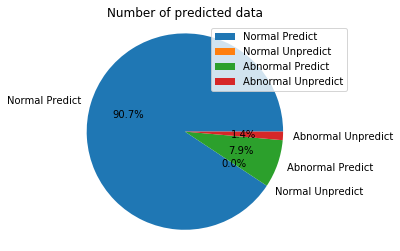

In [41]:
plt.pie([dic['normal_detect'],dic['normal_undetect'],dic['abnormal_detect'],dic['abnormal_undetect']], labels = ['Normal Predict', 'Normal Unpredict', 'Abnormal Predict','Abnormal Unpredict'], autopct = '%1.1f%%')
plt.title('Number of predicted data')
plt.axis('equal')
plt.legend(loc='best')
plt.savefig('Embedded_result.pdf',dpi=100)

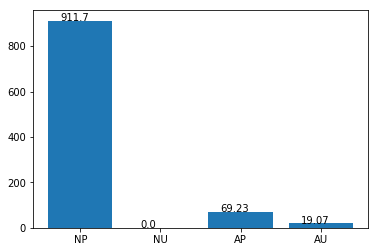

In [40]:
x = np.arange(4)
y = [round(dic['normal_detect'],2),round(dic['normal_undetect'],2),round(dic['abnormal_detect'],2),round(dic['abnormal_undetect'],2)]
plt.bar(x, height= y)
plt.xticks(x, ['NP', 'NU', 'AP','AU'])
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v + 0.01, str(v))
plt.savefig('Embedded_MLP_YOLO_result.pdf',dpi=100)

# For Video MLP+YOLO

In [30]:
total = 0
count = 0
for i in range(1):
    cap = cv2.VideoCapture('../完整影片/20180628/'+str(16)+'.avi')
    timeF = 10
    c = 0
    # 以迴圈從影片檔案讀取影格，並顯示出來
    while(cap.isOpened()):
        ret, frame = cap.read()
        if frame is None:
            break

        if(c%timeF==0):
            #print(type(frame))
            origin = frame
            origin = origin[35:,5:300]
#             cv2.imshow('123',origin)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            imgcv = detect(origin)
            if len(imgcv) != 0:
                imgcvt = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
                imgcvt = cv2.resize(imgcvt, (200,200))
                imgcvt = imgcvt.flatten()
                test1 = np.array([]).reshape((0 ,img2.shape[0]))
                test1 = np.row_stack([test1, imgcvt.flatten()])
                test1 /= 255.
                testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
                testy1 = np.row_stack([testy1, class_y[0]])
                tr_pred = sess.run([y_pred], feed_dict={
                            input_data:test1,
                        })
                if tr_pred[0][0][1] < 1:
                    count += 1
                    cv2.imwrite('../Result/'+str(count)+'.jpg',imgcv)
                    print(tr_pred)
            else:
                imgcvt = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
                imgcvt = cv2.resize(imgcvt, (200,200))
                imgcvt = imgcvt.flatten()
                test1 = np.array([]).reshape((0 ,img2.shape[0]))
                test1 = np.row_stack([test1, imgcvt.flatten()])
                test1 /= 255.
                testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
                testy1 = np.row_stack([testy1, class_y[0]])
                tr_pred = sess.run([y_pred], feed_dict={
                            input_data:test1,
                        })
                if tr_pred[0][0][1] < 1:
                    count += 1
                    cv2.imwrite('../Result/'+str(count)+'.jpg',origin)
                    print(tr_pred)
            total += 1
        c += 1
    cap.release()
    cv2.destroyAllWindows()
    print('Object detected files:',count,'/',total)

Object detected files: 0 / 1352


# Multiple test

In [21]:
path_for_test = '../training/'
for i in os.listdir(path_for_test):
    if 'jpg' in i:
        img5 = cv2.imread(path_for_test+i,0)
        img5 = cv2.resize(img5, (200,200))
        img5 = img5.flatten()
        test1 = np.array([]).reshape((0 ,img5.shape[0]))
        test1 = np.row_stack([test1, img5.flatten()])
        #test1 = img4
        test1 /= 255.
        #test1
        #testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
        #testy1 = np.row_stack([testy1, class_y[0]])
        tr_pred = sess.run([y_pred], feed_dict={input_data:test1,})
        print(i,tr_pred, tr_pred[0][0][1])


abnormal_img_0.jpg [array([[-0.8491578 ,  0.89019114]], dtype=float32)] 0.89019114
abnormal_img_1.jpg [array([[-0.8484942,  0.8897847]], dtype=float32)] 0.8897847
abnormal_img_10.jpg [array([[-0.80087346,  0.84288186]], dtype=float32)] 0.84288186
abnormal_img_100.jpg [array([[-0.836283  ,  0.87429917]], dtype=float32)] 0.87429917
abnormal_img_101.jpg [array([[-0.8341942 ,  0.87275624]], dtype=float32)] 0.87275624
abnormal_img_102.jpg [array([[-0.83060783,  0.8686435 ]], dtype=float32)] 0.8686435
abnormal_img_103.jpg [array([[-0.82680035,  0.8642725 ]], dtype=float32)] 0.8642725
abnormal_img_104.jpg [array([[-0.8319571 ,  0.86902446]], dtype=float32)] 0.86902446
abnormal_img_105.jpg [array([[-0.8372996,  0.8765513]], dtype=float32)] 0.8765513
abnormal_img_106.jpg [array([[-0.8351165 ,  0.87428147]], dtype=float32)] 0.87428147
abnormal_img_107.jpg [array([[-0.8333204,  0.8724003]], dtype=float32)] 0.8724003
abnormal_img_108.jpg [array([[-0.8319707 ,  0.87086827]], dtype=float32)] 0.87086

abnormal_img_197.jpg [array([[-0.84657854,  0.890922  ]], dtype=float32)] 0.890922
abnormal_img_198.jpg [array([[-0.84735525,  0.89153326]], dtype=float32)] 0.89153326
abnormal_img_199.jpg [array([[-0.8470716,  0.8909759]], dtype=float32)] 0.8909759
abnormal_img_2.jpg [array([[-0.84734243,  0.88980484]], dtype=float32)] 0.88980484
abnormal_img_20.jpg [array([[-0.8025575 ,  0.84500444]], dtype=float32)] 0.84500444
abnormal_img_200.jpg [array([[-0.84705335,  0.891144  ]], dtype=float32)] 0.891144
abnormal_img_201.jpg [array([[-0.84802383,  0.89189464]], dtype=float32)] 0.89189464
abnormal_img_202.jpg [array([[-0.8474947,  0.8908098]], dtype=float32)] 0.8908098
abnormal_img_203.jpg [array([[-0.84602827,  0.8900833 ]], dtype=float32)] 0.8900833
abnormal_img_204.jpg [array([[-0.8470018,  0.890104 ]], dtype=float32)] 0.890104
abnormal_img_205.jpg [array([[-0.8438648,  0.8851068]], dtype=float32)] 0.8851068
abnormal_img_206.jpg [array([[-0.8384787,  0.8795193]], dtype=float32)] 0.8795193
abno

abnormal_img_296.jpg [array([[-1.0544428,  1.143662 ]], dtype=float32)] 1.143662
abnormal_img_297.jpg [array([[-1.049587 ,  1.1356447]], dtype=float32)] 1.1356447
abnormal_img_298.jpg [array([[-1.0498383,  1.1345314]], dtype=float32)] 1.1345314
abnormal_img_299.jpg [array([[-1.0548773,  1.1435587]], dtype=float32)] 1.1435587
abnormal_img_3.jpg [array([[-0.84493864,  0.8875259 ]], dtype=float32)] 0.8875259
abnormal_img_30.jpg [array([[-0.8063459 ,  0.84324276]], dtype=float32)] 0.84324276
abnormal_img_300.jpg [array([[-1.0543367,  1.142793 ]], dtype=float32)] 1.142793
abnormal_img_301.jpg [array([[-1.0521972,  1.1405044]], dtype=float32)] 1.1405044
abnormal_img_302.jpg [array([[-1.0551788,  1.1428108]], dtype=float32)] 1.1428108
abnormal_img_303.jpg [array([[-1.0526801,  1.1398276]], dtype=float32)] 1.1398276
abnormal_img_304.jpg [array([[-1.0514852,  1.1393715]], dtype=float32)] 1.1393715
abnormal_img_305.jpg [array([[-1.0497077,  1.1365749]], dtype=float32)] 1.1365749
abnormal_img_306

abnormal_img_399.jpg [array([[-0.89424384,  0.952078  ]], dtype=float32)] 0.952078
abnormal_img_4.jpg [array([[-0.8457049 ,  0.88600516]], dtype=float32)] 0.88600516
abnormal_img_40.jpg [array([[-0.78729653,  0.822252  ]], dtype=float32)] 0.822252
abnormal_img_400.jpg [array([[-0.89424384,  0.952078  ]], dtype=float32)] 0.952078
abnormal_img_401.jpg [array([[-0.8942683 ,  0.95166934]], dtype=float32)] 0.95166934
abnormal_img_402.jpg [array([[-0.8940287,  0.9536518]], dtype=float32)] 0.9536518
abnormal_img_403.jpg [array([[-0.893372 ,  0.9534966]], dtype=float32)] 0.9534966
abnormal_img_404.jpg [array([[-0.8934586 ,  0.95274365]], dtype=float32)] 0.95274365
abnormal_img_405.jpg [array([[-0.8934988,  0.9547062]], dtype=float32)] 0.9547062
abnormal_img_406.jpg [array([[-0.89118415,  0.95196944]], dtype=float32)] 0.95196944
abnormal_img_407.jpg [array([[-0.8926692,  0.9518152]], dtype=float32)] 0.9518152
abnormal_img_408.jpg [array([[-0.89453316,  0.9536771 ]], dtype=float32)] 0.9536771
ab

abnormal_img_505.jpg [array([[-0.8367851 ,  0.88442194]], dtype=float32)] 0.88442194
abnormal_img_506.jpg [array([[-0.828629  ,  0.87466794]], dtype=float32)] 0.87466794
abnormal_img_507.jpg [array([[-0.8270509,  0.8728963]], dtype=float32)] 0.8728963
abnormal_img_508.jpg [array([[-0.8281729,  0.8750161]], dtype=float32)] 0.8750161
abnormal_img_509.jpg [array([[-0.8293337 ,  0.87427545]], dtype=float32)] 0.87427545
abnormal_img_51.jpg [array([[-0.8268953,  0.8815992]], dtype=float32)] 0.8815992
abnormal_img_510.jpg [array([[-0.83008826,  0.8756001 ]], dtype=float32)] 0.8756001
abnormal_img_511.jpg [array([[-0.82945335,  0.87432504]], dtype=float32)] 0.87432504
abnormal_img_512.jpg [array([[-0.8291952 ,  0.87437326]], dtype=float32)] 0.87437326
abnormal_img_513.jpg [array([[-0.8299364,  0.8751818]], dtype=float32)] 0.8751818
abnormal_img_514.jpg [array([[-0.82840264,  0.874075  ]], dtype=float32)] 0.874075
abnormal_img_515.jpg [array([[-0.83142126,  0.8763042 ]], dtype=float32)] 0.87630

abnormal_img_608.jpg [array([[-0.7980761 ,  0.82405186]], dtype=float32)] 0.82405186
abnormal_img_609.jpg [array([[-0.7982166 ,  0.82294935]], dtype=float32)] 0.82294935
abnormal_img_61.jpg [array([[-0.81321925,  0.85738635]], dtype=float32)] 0.85738635
abnormal_img_610.jpg [array([[-0.7993743 ,  0.82581186]], dtype=float32)] 0.82581186
abnormal_img_611.jpg [array([[-0.80415934,  0.83278733]], dtype=float32)] 0.83278733
abnormal_img_612.jpg [array([[-0.80365294,  0.8333639 ]], dtype=float32)] 0.8333639
abnormal_img_613.jpg [array([[-0.8028338,  0.8287463]], dtype=float32)] 0.8287463
abnormal_img_614.jpg [array([[-0.8027482 ,  0.82987124]], dtype=float32)] 0.82987124
abnormal_img_615.jpg [array([[-0.80228615,  0.83220863]], dtype=float32)] 0.83220863
abnormal_img_616.jpg [array([[-0.8049452,  0.831924 ]], dtype=float32)] 0.831924
abnormal_img_617.jpg [array([[-0.79951274,  0.8271351 ]], dtype=float32)] 0.8271351
abnormal_img_618.jpg [array([[-0.7972515 ,  0.82184273]], dtype=float32)] 0

normal_img_1020.jpg [array([[-1.1326065,  1.2393965]], dtype=float32)] 1.2393965
normal_img_1021.jpg [array([[-1.1223788,  1.2274425]], dtype=float32)] 1.2274425
normal_img_1022.jpg [array([[-1.1084882,  1.2100313]], dtype=float32)] 1.2100313
normal_img_1023.jpg [array([[-1.1099523,  1.2149199]], dtype=float32)] 1.2149199
normal_img_1024.jpg [array([[-1.1066618,  1.2081115]], dtype=float32)] 1.2081115
normal_img_1025.jpg [array([[-1.1305321,  1.2376573]], dtype=float32)] 1.2376573
normal_img_1026.jpg [array([[-1.1334451,  1.2382283]], dtype=float32)] 1.2382283
normal_img_1027.jpg [array([[-1.1164632,  1.2170295]], dtype=float32)] 1.2170295
normal_img_1028.jpg [array([[-1.139289 ,  1.2484286]], dtype=float32)] 1.2484286
normal_img_1029.jpg [array([[-1.1255556,  1.2324922]], dtype=float32)] 1.2324922
normal_img_103.jpg [array([[-1.1316819,  1.2480345]], dtype=float32)] 1.2480345
normal_img_1030.jpg [array([[-1.1159405,  1.2198898]], dtype=float32)] 1.2198898
normal_img_1031.jpg [array([[

normal_img_113.jpg [array([[-1.1255063,  1.2417219]], dtype=float32)] 1.2417219
normal_img_1130.jpg [array([[-1.1255335,  1.2341763]], dtype=float32)] 1.2341763
normal_img_1131.jpg [array([[-1.1331269,  1.2417843]], dtype=float32)] 1.2417843
normal_img_1132.jpg [array([[-1.1452018,  1.256827 ]], dtype=float32)] 1.256827
normal_img_1133.jpg [array([[-1.1395174,  1.2516176]], dtype=float32)] 1.2516176
normal_img_1134.jpg [array([[-1.1342283,  1.2444403]], dtype=float32)] 1.2444403
normal_img_1135.jpg [array([[-1.1299   ,  1.2374941]], dtype=float32)] 1.2374941
normal_img_1136.jpg [array([[-1.1170733,  1.2227155]], dtype=float32)] 1.2227155
normal_img_1137.jpg [array([[-1.1051005,  1.2042531]], dtype=float32)] 1.2042531
normal_img_1138.jpg [array([[-1.0972751,  1.1970854]], dtype=float32)] 1.1970854
normal_img_1139.jpg [array([[-1.0974805,  1.200545 ]], dtype=float32)] 1.200545
normal_img_114.jpg [array([[-1.1340814,  1.2515631]], dtype=float32)] 1.2515631
normal_img_1140.jpg [array([[-1.

normal_img_124.jpg [array([[-1.1346016,  1.2526665]], dtype=float32)] 1.2526665
normal_img_1240.jpg [array([[-1.1509888,  1.263925 ]], dtype=float32)] 1.263925
normal_img_1241.jpg [array([[-1.1386924,  1.2497474]], dtype=float32)] 1.2497474
normal_img_1242.jpg [array([[-1.151172 ,  1.2647275]], dtype=float32)] 1.2647275
normal_img_1243.jpg [array([[-1.1505209,  1.2639141]], dtype=float32)] 1.2639141
normal_img_1244.jpg [array([[-1.1469673,  1.2603805]], dtype=float32)] 1.2603805
normal_img_1245.jpg [array([[-1.1494119,  1.2630075]], dtype=float32)] 1.2630075
normal_img_1246.jpg [array([[-1.1424605,  1.2546537]], dtype=float32)] 1.2546537
normal_img_1247.jpg [array([[-1.1354582,  1.2458173]], dtype=float32)] 1.2458173
normal_img_1248.jpg [array([[-1.125942 ,  1.2374132]], dtype=float32)] 1.2374132
normal_img_1249.jpg [array([[-1.1328447,  1.2453791]], dtype=float32)] 1.2453791
normal_img_125.jpg [array([[-1.132798 ,  1.2504419]], dtype=float32)] 1.2504419
normal_img_1250.jpg [array([[-1

normal_img_1351.jpg [array([[-1.1277533,  1.2349473]], dtype=float32)] 1.2349473
normal_img_1352.jpg [array([[-1.1339033,  1.2395003]], dtype=float32)] 1.2395003
normal_img_1353.jpg [array([[-1.1365649,  1.2453876]], dtype=float32)] 1.2453876
normal_img_1354.jpg [array([[-1.1357855,  1.2449706]], dtype=float32)] 1.2449706
normal_img_1355.jpg [array([[-1.1307253,  1.2376585]], dtype=float32)] 1.2376585
normal_img_1356.jpg [array([[-1.1499466,  1.2622625]], dtype=float32)] 1.2622625
normal_img_1357.jpg [array([[-1.1499183,  1.2637753]], dtype=float32)] 1.2637753
normal_img_1358.jpg [array([[-1.1513672,  1.2643089]], dtype=float32)] 1.2643089
normal_img_1359.jpg [array([[-1.1524879,  1.2681645]], dtype=float32)] 1.2681645
normal_img_136.jpg [array([[-1.1277039,  1.2421125]], dtype=float32)] 1.2421125
normal_img_1360.jpg [array([[-1.1510139,  1.2670226]], dtype=float32)] 1.2670226
normal_img_1361.jpg [array([[-1.1511246,  1.2643282]], dtype=float32)] 1.2643282
normal_img_1362.jpg [array([[

normal_img_1461.jpg [array([[-1.1202018,  1.220836 ]], dtype=float32)] 1.220836
normal_img_1462.jpg [array([[-1.1071563,  1.2071078]], dtype=float32)] 1.2071078
normal_img_1463.jpg [array([[-1.1272438,  1.2308633]], dtype=float32)] 1.2308633
normal_img_1464.jpg [array([[-1.1104255,  1.2078602]], dtype=float32)] 1.2078602
normal_img_1465.jpg [array([[-1.1067613,  1.2033602]], dtype=float32)] 1.2033602
normal_img_1466.jpg [array([[-1.1071258,  1.205661 ]], dtype=float32)] 1.205661
normal_img_1467.jpg [array([[-1.1187283,  1.2251912]], dtype=float32)] 1.2251912
normal_img_1468.jpg [array([[-1.1087983,  1.211092 ]], dtype=float32)] 1.211092
normal_img_1469.jpg [array([[-1.1264545,  1.2313222]], dtype=float32)] 1.2313222
normal_img_147.jpg [array([[-1.1103346,  1.2203614]], dtype=float32)] 1.2203614
normal_img_1470.jpg [array([[-1.1304334,  1.2399096]], dtype=float32)] 1.2399096
normal_img_1471.jpg [array([[-1.1310701,  1.2384235]], dtype=float32)] 1.2384235
normal_img_1472.jpg [array([[-1.

normal_img_1571.jpg [array([[-1.1455737,  1.2560179]], dtype=float32)] 1.2560179
normal_img_1572.jpg [array([[-1.1491958,  1.2586669]], dtype=float32)] 1.2586669
normal_img_1573.jpg [array([[-1.1458788,  1.2540568]], dtype=float32)] 1.2540568
normal_img_1574.jpg [array([[-1.1401311,  1.2478677]], dtype=float32)] 1.2478677
normal_img_1575.jpg [array([[-1.136061 ,  1.2442017]], dtype=float32)] 1.2442017
normal_img_1576.jpg [array([[-1.1406087,  1.2496532]], dtype=float32)] 1.2496532
normal_img_1577.jpg [array([[-1.1401653,  1.2488806]], dtype=float32)] 1.2488806
normal_img_1578.jpg [array([[-1.1404268,  1.2481619]], dtype=float32)] 1.2481619
normal_img_1579.jpg [array([[-1.1391004,  1.2468975]], dtype=float32)] 1.2468975
normal_img_158.jpg [array([[-1.1377058,  1.2560704]], dtype=float32)] 1.2560704
normal_img_1580.jpg [array([[-1.1343291,  1.2402583]], dtype=float32)] 1.2402583
normal_img_1581.jpg [array([[-1.1379308,  1.2443907]], dtype=float32)] 1.2443907
normal_img_1582.jpg [array([[

normal_img_1682.jpg [array([[-1.1302466,  1.2375246]], dtype=float32)] 1.2375246
normal_img_1683.jpg [array([[-1.1359509,  1.243086 ]], dtype=float32)] 1.243086
normal_img_1684.jpg [array([[-1.11777  ,  1.2230237]], dtype=float32)] 1.2230237
normal_img_1685.jpg [array([[-1.1272844,  1.2329853]], dtype=float32)] 1.2329853
normal_img_1686.jpg [array([[-1.1361649,  1.2458438]], dtype=float32)] 1.2458438
normal_img_1687.jpg [array([[-1.1299342,  1.2365166]], dtype=float32)] 1.2365166
normal_img_1688.jpg [array([[-1.1107543,  1.2141216]], dtype=float32)] 1.2141216
normal_img_1689.jpg [array([[-1.117053 ,  1.2184833]], dtype=float32)] 1.2184833
normal_img_169.jpg [array([[-1.1351986,  1.2526172]], dtype=float32)] 1.2526172
normal_img_1690.jpg [array([[-1.1391951,  1.2482969]], dtype=float32)] 1.2482969
normal_img_1691.jpg [array([[-1.1145386,  1.221249 ]], dtype=float32)] 1.221249
normal_img_1692.jpg [array([[-1.1300619,  1.2373606]], dtype=float32)] 1.2373606
normal_img_1693.jpg [array([[-1

normal_img_1788.jpg [array([[-1.1244982,  1.2303143]], dtype=float32)] 1.2303143
normal_img_1789.jpg [array([[-1.1324053,  1.2397256]], dtype=float32)] 1.2397256
normal_img_179.jpg [array([[-1.1280562,  1.2426753]], dtype=float32)] 1.2426753
normal_img_1790.jpg [array([[-1.1455159,  1.2574006]], dtype=float32)] 1.2574006
normal_img_1791.jpg [array([[-1.1355848,  1.2438735]], dtype=float32)] 1.2438735
normal_img_1792.jpg [array([[-1.1055903,  1.2067685]], dtype=float32)] 1.2067685
normal_img_1793.jpg [array([[-1.1135945,  1.2133783]], dtype=float32)] 1.2133783
normal_img_1794.jpg [array([[-1.1368605,  1.2441471]], dtype=float32)] 1.2441471
normal_img_1795.jpg [array([[-1.1322129,  1.2392408]], dtype=float32)] 1.2392408
normal_img_1796.jpg [array([[-1.1314298,  1.2364175]], dtype=float32)] 1.2364175
normal_img_1797.jpg [array([[-1.1358898,  1.2422976]], dtype=float32)] 1.2422976
normal_img_1798.jpg [array([[-1.1363425,  1.2428329]], dtype=float32)] 1.2428329
normal_img_1799.jpg [array([[

normal_img_189.jpg [array([[-1.12778  ,  1.2427971]], dtype=float32)] 1.2427971
normal_img_1890.jpg [array([[-1.1316061,  1.2423371]], dtype=float32)] 1.2423371
normal_img_1891.jpg [array([[-1.1322234,  1.2414314]], dtype=float32)] 1.2414314
normal_img_1892.jpg [array([[-1.1308833,  1.2404133]], dtype=float32)] 1.2404133
normal_img_1893.jpg [array([[-1.126563 ,  1.2332631]], dtype=float32)] 1.2332631
normal_img_1894.jpg [array([[-1.1302856,  1.2412177]], dtype=float32)] 1.2412177
normal_img_1895.jpg [array([[-1.1343101,  1.2436787]], dtype=float32)] 1.2436787
normal_img_1896.jpg [array([[-1.1187512,  1.2249846]], dtype=float32)] 1.2249846
normal_img_1897.jpg [array([[-1.1326059,  1.2409642]], dtype=float32)] 1.2409642
normal_img_1898.jpg [array([[-1.1346928,  1.2436585]], dtype=float32)] 1.2436585
normal_img_1899.jpg [array([[-1.1306299,  1.2381939]], dtype=float32)] 1.2381939
normal_img_19.jpg [array([[-1.1359162,  1.2525978]], dtype=float32)] 1.2525978
normal_img_190.jpg [array([[-1.

normal_img_1996.jpg [array([[-1.1378802,  1.248454 ]], dtype=float32)] 1.248454
normal_img_1997.jpg [array([[-1.1437603,  1.25719  ]], dtype=float32)] 1.25719
normal_img_1998.jpg [array([[-1.144504 ,  1.2569269]], dtype=float32)] 1.2569269
normal_img_1999.jpg [array([[-1.1454633,  1.257965 ]], dtype=float32)] 1.257965
normal_img_2.jpg [array([[-1.1362696,  1.2526939]], dtype=float32)] 1.2526939
normal_img_20.jpg [array([[-1.1314483,  1.2476633]], dtype=float32)] 1.2476633
normal_img_200.jpg [array([[-1.131404 ,  1.2453785]], dtype=float32)] 1.2453785
normal_img_2000.jpg [array([[-1.1464942,  1.2600194]], dtype=float32)] 1.2600194
normal_img_2001.jpg [array([[-1.1410084,  1.2526621]], dtype=float32)] 1.2526621
normal_img_2002.jpg [array([[-1.14884,  1.26383]], dtype=float32)] 1.26383
normal_img_2003.jpg [array([[-1.1438142,  1.2573667]], dtype=float32)] 1.2573667
normal_img_2004.jpg [array([[-1.1361836,  1.2474315]], dtype=float32)] 1.2474315
normal_img_2005.jpg [array([[-1.1052213,  1.

normal_img_2101.jpg [array([[-1.1419235,  1.2557126]], dtype=float32)] 1.2557126
normal_img_2102.jpg [array([[-1.1403801,  1.2533933]], dtype=float32)] 1.2533933
normal_img_2103.jpg [array([[-1.1384536,  1.2491587]], dtype=float32)] 1.2491587
normal_img_2104.jpg [array([[-1.1391443,  1.2499623]], dtype=float32)] 1.2499623
normal_img_2105.jpg [array([[-1.1346339,  1.2438769]], dtype=float32)] 1.2438769
normal_img_2106.jpg [array([[-1.1368823,  1.2448205]], dtype=float32)] 1.2448205
normal_img_2107.jpg [array([[-1.1283168,  1.2365943]], dtype=float32)] 1.2365943
normal_img_2108.jpg [array([[-1.1423   ,  1.2544055]], dtype=float32)] 1.2544055
normal_img_2109.jpg [array([[-1.145209 ,  1.2565722]], dtype=float32)] 1.2565722
normal_img_211.jpg [array([[-1.1331754,  1.2490561]], dtype=float32)] 1.2490561
normal_img_2110.jpg [array([[-1.1380706,  1.2488002]], dtype=float32)] 1.2488002
normal_img_2111.jpg [array([[-1.1444235,  1.2561569]], dtype=float32)] 1.2561569
normal_img_2112.jpg [array([[

normal_img_221.jpg [array([[-1.1291883,  1.2433408]], dtype=float32)] 1.2433408
normal_img_2210.jpg [array([[-1.1477052,  1.2618536]], dtype=float32)] 1.2618536
normal_img_2211.jpg [array([[-1.1469945,  1.261199 ]], dtype=float32)] 1.261199
normal_img_2212.jpg [array([[-1.1349598,  1.2461814]], dtype=float32)] 1.2461814
normal_img_2213.jpg [array([[-1.1424567,  1.2548896]], dtype=float32)] 1.2548896
normal_img_2214.jpg [array([[-1.1441143,  1.2567383]], dtype=float32)] 1.2567383
normal_img_2215.jpg [array([[-1.129925 ,  1.2403437]], dtype=float32)] 1.2403437
normal_img_2216.jpg [array([[-1.141393,  1.252583]], dtype=float32)] 1.252583
normal_img_2217.jpg [array([[-1.1476235,  1.2598786]], dtype=float32)] 1.2598786
normal_img_2218.jpg [array([[-1.1464514,  1.2586322]], dtype=float32)] 1.2586322
normal_img_2219.jpg [array([[-1.141655,  1.251626]], dtype=float32)] 1.251626
normal_img_222.jpg [array([[-1.1333799,  1.2496173]], dtype=float32)] 1.2496173
normal_img_2220.jpg [array([[-1.14680

normal_img_2318.jpg [array([[-1.1474837,  1.2608742]], dtype=float32)] 1.2608742
normal_img_2319.jpg [array([[-1.1403915,  1.2515992]], dtype=float32)] 1.2515992
normal_img_232.jpg [array([[-1.1312115,  1.2464646]], dtype=float32)] 1.2464646
normal_img_2320.jpg [array([[-1.1421442,  1.2544097]], dtype=float32)] 1.2544097
normal_img_2321.jpg [array([[-1.141136 ,  1.2531935]], dtype=float32)] 1.2531935
normal_img_2322.jpg [array([[-1.142507 ,  1.2542062]], dtype=float32)] 1.2542062
normal_img_2323.jpg [array([[-1.1343521,  1.2455753]], dtype=float32)] 1.2455753
normal_img_2324.jpg [array([[-1.1441399,  1.2577511]], dtype=float32)] 1.2577511
normal_img_2325.jpg [array([[-1.1416731,  1.2546686]], dtype=float32)] 1.2546686
normal_img_2326.jpg [array([[-1.1439182,  1.2556962]], dtype=float32)] 1.2556962
normal_img_2327.jpg [array([[-1.1404728,  1.2534633]], dtype=float32)] 1.2534633
normal_img_2328.jpg [array([[-1.1432029,  1.2571148]], dtype=float32)] 1.2571148
normal_img_2329.jpg [array([[

normal_img_2426.jpg [array([[-1.1413584,  1.2550744]], dtype=float32)] 1.2550744
normal_img_2427.jpg [array([[-1.1507466,  1.267835 ]], dtype=float32)] 1.267835
normal_img_2428.jpg [array([[-1.1505272,  1.2674192]], dtype=float32)] 1.2674192
normal_img_2429.jpg [array([[-1.1492356,  1.2665951]], dtype=float32)] 1.2665951
normal_img_243.jpg [array([[-1.1327039,  1.2467042]], dtype=float32)] 1.2467042
normal_img_2430.jpg [array([[-1.1498289,  1.2667991]], dtype=float32)] 1.2667991
normal_img_2431.jpg [array([[-1.1502978,  1.267331 ]], dtype=float32)] 1.267331
normal_img_2432.jpg [array([[-1.1481613,  1.2633165]], dtype=float32)] 1.2633165
normal_img_2433.jpg [array([[-1.130303 ,  1.2437658]], dtype=float32)] 1.2437658
normal_img_2434.jpg [array([[-1.1418996,  1.2579412]], dtype=float32)] 1.2579412
normal_img_2435.jpg [array([[-1.1453068,  1.260245 ]], dtype=float32)] 1.260245
normal_img_2436.jpg [array([[-1.1521479,  1.2709279]], dtype=float32)] 1.2709279
normal_img_2437.jpg [array([[-1.

normal_img_2535.jpg [array([[-1.1539696,  1.2736529]], dtype=float32)] 1.2736529
normal_img_2536.jpg [array([[-1.1557078,  1.2758788]], dtype=float32)] 1.2758788
normal_img_2537.jpg [array([[-1.1574022,  1.2777336]], dtype=float32)] 1.2777336
normal_img_2538.jpg [array([[-1.1572682,  1.2779673]], dtype=float32)] 1.2779673
normal_img_2539.jpg [array([[-1.1566478,  1.276734 ]], dtype=float32)] 1.276734
normal_img_254.jpg [array([[-1.128477 ,  1.2428517]], dtype=float32)] 1.2428517
normal_img_2540.jpg [array([[-1.160481,  1.281812]], dtype=float32)] 1.281812
normal_img_2541.jpg [array([[-1.1589531,  1.280323 ]], dtype=float32)] 1.280323
normal_img_2542.jpg [array([[-1.160632 ,  1.2817551]], dtype=float32)] 1.2817551
normal_img_2543.jpg [array([[-1.159296 ,  1.2802361]], dtype=float32)] 1.2802361
normal_img_2544.jpg [array([[-1.1566988,  1.2773882]], dtype=float32)] 1.2773882
normal_img_2545.jpg [array([[-1.1560024,  1.2769318]], dtype=float32)] 1.2769318
normal_img_2546.jpg [array([[-1.15

normal_img_2646.jpg [array([[-1.1536148,  1.2720319]], dtype=float32)] 1.2720319
normal_img_2647.jpg [array([[-1.148529 ,  1.2650622]], dtype=float32)] 1.2650622
normal_img_2648.jpg [array([[-1.1532344,  1.2724487]], dtype=float32)] 1.2724487
normal_img_2649.jpg [array([[-1.1540768,  1.2734388]], dtype=float32)] 1.2734388
normal_img_265.jpg [array([[-1.1309763,  1.2458915]], dtype=float32)] 1.2458915
normal_img_2650.jpg [array([[-1.157501 ,  1.2765396]], dtype=float32)] 1.2765396
normal_img_2651.jpg [array([[-1.1490369,  1.266116 ]], dtype=float32)] 1.266116
normal_img_2652.jpg [array([[-1.155215 ,  1.2745075]], dtype=float32)] 1.2745075
normal_img_2653.jpg [array([[-1.1523745,  1.2725661]], dtype=float32)] 1.2725661
normal_img_2654.jpg [array([[-1.1575183,  1.2780714]], dtype=float32)] 1.2780714
normal_img_2655.jpg [array([[-1.1478243,  1.262859 ]], dtype=float32)] 1.262859
normal_img_2656.jpg [array([[-1.1499561,  1.2650785]], dtype=float32)] 1.2650785
normal_img_2657.jpg [array([[-1

normal_img_274.jpg [array([[-1.1234574,  1.2345431]], dtype=float32)] 1.2345431
normal_img_2740.jpg [array([[-1.1552329,  1.2736115]], dtype=float32)] 1.2736115
normal_img_2741.jpg [array([[-1.152572 ,  1.2705544]], dtype=float32)] 1.2705544
normal_img_2742.jpg [array([[-1.1538148,  1.2736938]], dtype=float32)] 1.2736938
normal_img_2743.jpg [array([[-1.1576076,  1.2778302]], dtype=float32)] 1.2778302
normal_img_2744.jpg [array([[-1.1504216,  1.2682747]], dtype=float32)] 1.2682747
normal_img_2745.jpg [array([[-1.1521348,  1.2686218]], dtype=float32)] 1.2686218
normal_img_2746.jpg [array([[-1.1484485,  1.2657051]], dtype=float32)] 1.2657051
normal_img_2747.jpg [array([[-1.157638 ,  1.2779094]], dtype=float32)] 1.2779094
normal_img_2748.jpg [array([[-1.1551751,  1.272959 ]], dtype=float32)] 1.272959
normal_img_2749.jpg [array([[-1.1300415,  1.241648 ]], dtype=float32)] 1.241648
normal_img_275.jpg [array([[-1.1309859,  1.2457747]], dtype=float32)] 1.2457747
normal_img_2750.jpg [array([[-1.

normal_img_2848.jpg [array([[-1.142398 ,  1.2587912]], dtype=float32)] 1.2587912
normal_img_2849.jpg [array([[-1.143404,  1.259532]], dtype=float32)] 1.259532
normal_img_285.jpg [array([[-1.1320689,  1.2412567]], dtype=float32)] 1.2412567
normal_img_2850.jpg [array([[-1.1428776,  1.2587497]], dtype=float32)] 1.2587497
normal_img_2851.jpg [array([[-1.1421231,  1.2583727]], dtype=float32)] 1.2583727
normal_img_2852.jpg [array([[-1.1423192,  1.2580341]], dtype=float32)] 1.2580341
normal_img_2853.jpg [array([[-1.1425135,  1.2592494]], dtype=float32)] 1.2592494
normal_img_2854.jpg [array([[-1.1380907,  1.2533443]], dtype=float32)] 1.2533443
normal_img_2855.jpg [array([[-1.1335316,  1.2466464]], dtype=float32)] 1.2466464
normal_img_2856.jpg [array([[-1.1362011,  1.2493954]], dtype=float32)] 1.2493954
normal_img_2857.jpg [array([[-1.146379 ,  1.2654136]], dtype=float32)] 1.2654136
normal_img_2858.jpg [array([[-1.1476437,  1.2659256]], dtype=float32)] 1.2659256
normal_img_2859.jpg [array([[-1.

normal_img_2953.jpg [array([[-1.1613406,  1.2815807]], dtype=float32)] 1.2815807
normal_img_2954.jpg [array([[-1.1611623,  1.2807808]], dtype=float32)] 1.2807808
normal_img_2955.jpg [array([[-1.1612103,  1.2818792]], dtype=float32)] 1.2818792
normal_img_2956.jpg [array([[-1.1607487,  1.2803643]], dtype=float32)] 1.2803643
normal_img_2957.jpg [array([[-1.1578884,  1.2783407]], dtype=float32)] 1.2783407
normal_img_2958.jpg [array([[-1.1606106,  1.2802042]], dtype=float32)] 1.2802042
normal_img_2959.jpg [array([[-1.1582949,  1.278703 ]], dtype=float32)] 1.278703
normal_img_296.jpg [array([[-1.1296467,  1.2447588]], dtype=float32)] 1.2447588
normal_img_2960.jpg [array([[-1.1603113,  1.2799369]], dtype=float32)] 1.2799369
normal_img_2961.jpg [array([[-1.1606605,  1.2814157]], dtype=float32)] 1.2814157
normal_img_2962.jpg [array([[-1.1517422,  1.2679741]], dtype=float32)] 1.2679741
normal_img_2963.jpg [array([[-1.1575449,  1.277099 ]], dtype=float32)] 1.277099
normal_img_2964.jpg [array([[-1

normal_img_3056.jpg [array([[-1.1607512,  1.2817781]], dtype=float32)] 1.2817781
normal_img_3057.jpg [array([[-1.1609391,  1.2818165]], dtype=float32)] 1.2818165
normal_img_3058.jpg [array([[-1.1603115,  1.281092 ]], dtype=float32)] 1.281092
normal_img_3059.jpg [array([[-1.1602643,  1.2807876]], dtype=float32)] 1.2807876
normal_img_306.jpg [array([[-1.1257364,  1.240389 ]], dtype=float32)] 1.240389
normal_img_3060.jpg [array([[-1.1625904,  1.2841179]], dtype=float32)] 1.2841179
normal_img_3061.jpg [array([[-1.1564198,  1.2754859]], dtype=float32)] 1.2754859
normal_img_3062.jpg [array([[-1.1588902,  1.2796001]], dtype=float32)] 1.2796001
normal_img_3063.jpg [array([[-1.1609457,  1.2817534]], dtype=float32)] 1.2817534
normal_img_3064.jpg [array([[-1.1619698,  1.283247 ]], dtype=float32)] 1.283247
normal_img_3065.jpg [array([[-1.1611824,  1.2822328]], dtype=float32)] 1.2822328
normal_img_3066.jpg [array([[-1.1610702,  1.2819248]], dtype=float32)] 1.2819248
normal_img_3067.jpg [array([[-1.

normal_img_3160.jpg [array([[-1.1580818,  1.2785286]], dtype=float32)] 1.2785286
normal_img_3161.jpg [array([[-1.1577488,  1.2782872]], dtype=float32)] 1.2782872
normal_img_3162.jpg [array([[-1.1550882,  1.2746406]], dtype=float32)] 1.2746406
normal_img_3163.jpg [array([[-1.1568664,  1.2766366]], dtype=float32)] 1.2766366
normal_img_3164.jpg [array([[-1.1574398,  1.2770133]], dtype=float32)] 1.2770133
normal_img_3165.jpg [array([[-1.1586905,  1.2788979]], dtype=float32)] 1.2788979
normal_img_3166.jpg [array([[-1.1565415,  1.2760888]], dtype=float32)] 1.2760888
normal_img_3167.jpg [array([[-1.1582223,  1.2783598]], dtype=float32)] 1.2783598
normal_img_3168.jpg [array([[-1.1587437,  1.2792232]], dtype=float32)] 1.2792232
normal_img_3169.jpg [array([[-1.151376 ,  1.2692937]], dtype=float32)] 1.2692937
normal_img_317.jpg [array([[-1.1306245,  1.2397484]], dtype=float32)] 1.2397484
normal_img_3170.jpg [array([[-1.1436512,  1.259147 ]], dtype=float32)] 1.259147
normal_img_3171.jpg [array([[-

normal_img_3273.jpg [array([[-1.1609046,  1.2827783]], dtype=float32)] 1.2827783
normal_img_3274.jpg [array([[-1.16057  ,  1.2816715]], dtype=float32)] 1.2816715
normal_img_3275.jpg [array([[-1.1582942,  1.278666 ]], dtype=float32)] 1.278666
normal_img_3276.jpg [array([[-1.1611371,  1.2836212]], dtype=float32)] 1.2836212
normal_img_3277.jpg [array([[-1.1611385,  1.2832966]], dtype=float32)] 1.2832966
normal_img_3278.jpg [array([[-1.1616236,  1.2836204]], dtype=float32)] 1.2836204
normal_img_3279.jpg [array([[-1.1619352,  1.2833109]], dtype=float32)] 1.2833109
normal_img_328.jpg [array([[-1.1368481,  1.2485689]], dtype=float32)] 1.2485689
normal_img_3280.jpg [array([[-1.1618216,  1.2839592]], dtype=float32)] 1.2839592
normal_img_3281.jpg [array([[-1.1612194,  1.2823786]], dtype=float32)] 1.2823786
normal_img_3282.jpg [array([[-1.1622407,  1.2836125]], dtype=float32)] 1.2836125
normal_img_3283.jpg [array([[-1.1615856,  1.2838278]], dtype=float32)] 1.2838278
normal_img_3284.jpg [array([[-

normal_img_3384.jpg [array([[-1.1600374,  1.2813691]], dtype=float32)] 1.2813691
normal_img_3385.jpg [array([[-1.1579583,  1.2782792]], dtype=float32)] 1.2782792
normal_img_3386.jpg [array([[-1.1548485,  1.2770292]], dtype=float32)] 1.2770292
normal_img_3387.jpg [array([[-1.156254 ,  1.2785715]], dtype=float32)] 1.2785715
normal_img_3388.jpg [array([[-1.1600345,  1.2829245]], dtype=float32)] 1.2829245
normal_img_3389.jpg [array([[-1.1509324,  1.2719747]], dtype=float32)] 1.2719747
normal_img_339.jpg [array([[-1.1470472,  1.2637824]], dtype=float32)] 1.2637824
normal_img_3390.jpg [array([[-1.1550492,  1.2767254]], dtype=float32)] 1.2767254
normal_img_3391.jpg [array([[-1.1560184,  1.2788675]], dtype=float32)] 1.2788675
normal_img_3392.jpg [array([[-1.1550648,  1.2764686]], dtype=float32)] 1.2764686
normal_img_3393.jpg [array([[-1.1555517,  1.2774891]], dtype=float32)] 1.2774891
normal_img_3394.jpg [array([[-1.1560322,  1.2778602]], dtype=float32)] 1.2778602
normal_img_3395.jpg [array([[

normal_img_3495.jpg [array([[-1.1613916,  1.2836831]], dtype=float32)] 1.2836831
normal_img_3496.jpg [array([[-1.1613947,  1.2844127]], dtype=float32)] 1.2844127
normal_img_3497.jpg [array([[-1.160734 ,  1.2837633]], dtype=float32)] 1.2837633
normal_img_3498.jpg [array([[-1.1609427,  1.2832417]], dtype=float32)] 1.2832417
normal_img_3499.jpg [array([[-1.1591332,  1.2807776]], dtype=float32)] 1.2807776
normal_img_35.jpg [array([[-1.1368585,  1.254467 ]], dtype=float32)] 1.254467
normal_img_350.jpg [array([[-1.1406747,  1.2540748]], dtype=float32)] 1.2540748
normal_img_3500.jpg [array([[-1.158104 ,  1.2801278]], dtype=float32)] 1.2801278
normal_img_3501.jpg [array([[-1.1585954,  1.280785 ]], dtype=float32)] 1.280785
normal_img_3502.jpg [array([[-1.1594557,  1.280092 ]], dtype=float32)] 1.280092
normal_img_3503.jpg [array([[-1.1582808,  1.2791251]], dtype=float32)] 1.2791251
normal_img_3504.jpg [array([[-1.1587983,  1.2801925]], dtype=float32)] 1.2801925
normal_img_3505.jpg [array([[-1.15

normal_img_3605.jpg [array([[-1.1631795,  1.2859819]], dtype=float32)] 1.2859819
normal_img_3606.jpg [array([[-1.1650612,  1.2877568]], dtype=float32)] 1.2877568
normal_img_3607.jpg [array([[-1.1614063,  1.2826965]], dtype=float32)] 1.2826965
normal_img_3608.jpg [array([[-1.1639501,  1.2855638]], dtype=float32)] 1.2855638
normal_img_3609.jpg [array([[-1.1638998,  1.2877314]], dtype=float32)] 1.2877314
normal_img_361.jpg [array([[-1.1303242,  1.2403268]], dtype=float32)] 1.2403268
normal_img_3610.jpg [array([[-1.1640933,  1.2872485]], dtype=float32)] 1.2872485
normal_img_3611.jpg [array([[-1.1649545,  1.2882794]], dtype=float32)] 1.2882794
normal_img_3612.jpg [array([[-1.1646264,  1.2874988]], dtype=float32)] 1.2874988
normal_img_3613.jpg [array([[-1.1641175,  1.2867587]], dtype=float32)] 1.2867587
normal_img_3614.jpg [array([[-1.1653669,  1.2885048]], dtype=float32)] 1.2885048
normal_img_3615.jpg [array([[-1.164404 ,  1.2875782]], dtype=float32)] 1.2875782
normal_img_3616.jpg [array([[

normal_img_3718.jpg [array([[-1.1555204,  1.2742511]], dtype=float32)] 1.2742511
normal_img_3719.jpg [array([[-1.1556991,  1.2739383]], dtype=float32)] 1.2739383
normal_img_372.jpg [array([[-1.1416024,  1.2532388]], dtype=float32)] 1.2532388
normal_img_3720.jpg [array([[-1.154717 ,  1.2729403]], dtype=float32)] 1.2729403
normal_img_3721.jpg [array([[-1.1540887,  1.271084 ]], dtype=float32)] 1.271084
normal_img_3722.jpg [array([[-1.1496676,  1.2649698]], dtype=float32)] 1.2649698
normal_img_3723.jpg [array([[-1.1540736,  1.2699891]], dtype=float32)] 1.2699891
normal_img_3724.jpg [array([[-1.1548338,  1.2734321]], dtype=float32)] 1.2734321
normal_img_3725.jpg [array([[-1.1568251,  1.2759401]], dtype=float32)] 1.2759401
normal_img_3726.jpg [array([[-1.1571621,  1.2758905]], dtype=float32)] 1.2758905
normal_img_3727.jpg [array([[-1.1452901,  1.2635055]], dtype=float32)] 1.2635055
normal_img_3728.jpg [array([[-1.1390972,  1.253182 ]], dtype=float32)] 1.253182
normal_img_3729.jpg [array([[-1

normal_img_3830.jpg [array([[-1.1384327,  1.248861 ]], dtype=float32)] 1.248861
normal_img_3831.jpg [array([[-1.1390854,  1.2519904]], dtype=float32)] 1.2519904
normal_img_3832.jpg [array([[-1.1390249,  1.2505293]], dtype=float32)] 1.2505293
normal_img_3833.jpg [array([[-1.1430949,  1.2548465]], dtype=float32)] 1.2548465
normal_img_3834.jpg [array([[-1.1444448,  1.256349 ]], dtype=float32)] 1.256349
normal_img_3835.jpg [array([[-1.1452111,  1.25804  ]], dtype=float32)] 1.25804
normal_img_3836.jpg [array([[-1.1443362,  1.2561977]], dtype=float32)] 1.2561977
normal_img_3837.jpg [array([[-1.1442627,  1.2556459]], dtype=float32)] 1.2556459
normal_img_3838.jpg [array([[-1.1424794,  1.2537309]], dtype=float32)] 1.2537309
normal_img_3839.jpg [array([[-1.1390587,  1.2479283]], dtype=float32)] 1.2479283
normal_img_384.jpg [array([[-1.1438974,  1.2560624]], dtype=float32)] 1.2560624
normal_img_3840.jpg [array([[-1.1362451,  1.2450515]], dtype=float32)] 1.2450515
normal_img_3841.jpg [array([[-1.1

normal_img_3940.jpg [array([[-1.1601496,  1.2792507]], dtype=float32)] 1.2792507
normal_img_3941.jpg [array([[-1.1611506,  1.2804004]], dtype=float32)] 1.2804004
normal_img_3942.jpg [array([[-1.1589416,  1.2781004]], dtype=float32)] 1.2781004
normal_img_3943.jpg [array([[-1.1583312,  1.2767724]], dtype=float32)] 1.2767724
normal_img_3944.jpg [array([[-1.1611419,  1.2803909]], dtype=float32)] 1.2803909
normal_img_3945.jpg [array([[-1.1607028,  1.2803105]], dtype=float32)] 1.2803105
normal_img_3946.jpg [array([[-1.1607825,  1.2809733]], dtype=float32)] 1.2809733
normal_img_3947.jpg [array([[-1.1618794,  1.2823452]], dtype=float32)] 1.2823452
normal_img_3948.jpg [array([[-1.1611311,  1.2810076]], dtype=float32)] 1.2810076
normal_img_3949.jpg [array([[-1.1611001,  1.2808808]], dtype=float32)] 1.2808808
normal_img_395.jpg [array([[-1.1405315,  1.2535741]], dtype=float32)] 1.2535741
normal_img_3950.jpg [array([[-1.1609126,  1.2813542]], dtype=float32)] 1.2813542
normal_img_3951.jpg [array([[

normal_img_4050.jpg [array([[-1.15979  ,  1.2775191]], dtype=float32)] 1.2775191
normal_img_4051.jpg [array([[-1.1594887,  1.2780201]], dtype=float32)] 1.2780201
normal_img_4052.jpg [array([[-1.1605027,  1.2785696]], dtype=float32)] 1.2785696
normal_img_4053.jpg [array([[-1.1599262,  1.279972 ]], dtype=float32)] 1.279972
normal_img_4054.jpg [array([[-1.16137  ,  1.2811862]], dtype=float32)] 1.2811862
normal_img_4055.jpg [array([[-1.1662793,  1.2882372]], dtype=float32)] 1.2882372
normal_img_4056.jpg [array([[-1.1675512,  1.288941 ]], dtype=float32)] 1.288941
normal_img_4057.jpg [array([[-1.1672455,  1.2890539]], dtype=float32)] 1.2890539
normal_img_4058.jpg [array([[-1.16728  ,  1.2890409]], dtype=float32)] 1.2890409
normal_img_4059.jpg [array([[-1.1663994,  1.2870071]], dtype=float32)] 1.2870071
normal_img_406.jpg [array([[-1.145125 ,  1.2569278]], dtype=float32)] 1.2569278
normal_img_4060.jpg [array([[-1.1652302,  1.2865224]], dtype=float32)] 1.2865224
normal_img_4061.jpg [array([[-1

normal_img_4158.jpg [array([[-1.1594784,  1.2728956]], dtype=float32)] 1.2728956
normal_img_4159.jpg [array([[-1.1665552,  1.2826397]], dtype=float32)] 1.2826397
normal_img_416.jpg [array([[-1.1471497,  1.2608035]], dtype=float32)] 1.2608035
normal_img_4160.jpg [array([[-1.1680979,  1.2844788]], dtype=float32)] 1.2844788
normal_img_4161.jpg [array([[-1.1649758,  1.279277 ]], dtype=float32)] 1.279277
normal_img_4162.jpg [array([[-1.1656102,  1.280499 ]], dtype=float32)] 1.280499
normal_img_4163.jpg [array([[-1.1652981,  1.2799437]], dtype=float32)] 1.2799437
normal_img_4164.jpg [array([[-1.1596935,  1.272997 ]], dtype=float32)] 1.272997
normal_img_4165.jpg [array([[-1.153124 ,  1.2632896]], dtype=float32)] 1.2632896
normal_img_4166.jpg [array([[-1.1596116,  1.272809 ]], dtype=float32)] 1.272809
normal_img_4167.jpg [array([[-1.1600021,  1.2731954]], dtype=float32)] 1.2731954
normal_img_4168.jpg [array([[-1.1506803,  1.2600302]], dtype=float32)] 1.2600302
normal_img_4169.jpg [array([[-1.1

normal_img_4268.jpg [array([[-1.1580285,  1.2697324]], dtype=float32)] 1.2697324
normal_img_4269.jpg [array([[-1.1555599,  1.2698418]], dtype=float32)] 1.2698418
normal_img_427.jpg [array([[-1.1458287,  1.2588199]], dtype=float32)] 1.2588199
normal_img_4270.jpg [array([[-1.1638651,  1.2794358]], dtype=float32)] 1.2794358
normal_img_4271.jpg [array([[-1.1629792,  1.2783436]], dtype=float32)] 1.2783436
normal_img_4272.jpg [array([[-1.1610094,  1.2762793]], dtype=float32)] 1.2762793
normal_img_4273.jpg [array([[-1.1637672,  1.279206 ]], dtype=float32)] 1.279206
normal_img_4274.jpg [array([[-1.1639253,  1.2760757]], dtype=float32)] 1.2760757
normal_img_4275.jpg [array([[-1.1645687,  1.2773622]], dtype=float32)] 1.2773622
normal_img_4276.jpg [array([[-1.1524693,  1.2644325]], dtype=float32)] 1.2644325
normal_img_4277.jpg [array([[-1.1659324,  1.2823658]], dtype=float32)] 1.2823658
normal_img_4278.jpg [array([[-1.163966 ,  1.2800459]], dtype=float32)] 1.2800459
normal_img_4279.jpg [array([[-

normal_img_4378.jpg [array([[-1.1645436,  1.2779044]], dtype=float32)] 1.2779044
normal_img_4379.jpg [array([[-1.1643251,  1.2771466]], dtype=float32)] 1.2771466
normal_img_438.jpg [array([[-1.1493398,  1.2638175]], dtype=float32)] 1.2638175
normal_img_4380.jpg [array([[-1.1649328,  1.2780094]], dtype=float32)] 1.2780094
normal_img_4381.jpg [array([[-1.163916,  1.276514]], dtype=float32)] 1.276514
normal_img_4382.jpg [array([[-1.1646886,  1.27755  ]], dtype=float32)] 1.27755
normal_img_4383.jpg [array([[-1.1646159,  1.2777476]], dtype=float32)] 1.2777476
normal_img_4384.jpg [array([[-1.1656089,  1.2793947]], dtype=float32)] 1.2793947
normal_img_4385.jpg [array([[-1.1664765,  1.2820433]], dtype=float32)] 1.2820433
normal_img_4386.jpg [array([[-1.1660824,  1.2816243]], dtype=float32)] 1.2816243
normal_img_4387.jpg [array([[-1.1657058,  1.2812984]], dtype=float32)] 1.2812984
normal_img_4388.jpg [array([[-1.1660037,  1.2811552]], dtype=float32)] 1.2811552
normal_img_4389.jpg [array([[-1.16

normal_img_4489.jpg [array([[-1.1646614,  1.2822683]], dtype=float32)] 1.2822683
normal_img_449.jpg [array([[-1.1489586,  1.262945 ]], dtype=float32)] 1.262945
normal_img_4490.jpg [array([[-1.1639993,  1.2813187]], dtype=float32)] 1.2813187
normal_img_4491.jpg [array([[-1.16263  ,  1.2793899]], dtype=float32)] 1.2793899
normal_img_4492.jpg [array([[-1.1658889,  1.2831879]], dtype=float32)] 1.2831879
normal_img_4493.jpg [array([[-1.1657671,  1.2826128]], dtype=float32)] 1.2826128
normal_img_4494.jpg [array([[-1.1669337,  1.2830886]], dtype=float32)] 1.2830886
normal_img_4495.jpg [array([[-1.1624548,  1.2791501]], dtype=float32)] 1.2791501
normal_img_4496.jpg [array([[-1.1615344,  1.2790556]], dtype=float32)] 1.2790556
normal_img_4497.jpg [array([[-1.1622784,  1.2790636]], dtype=float32)] 1.2790636
normal_img_4498.jpg [array([[-1.1619991,  1.2785202]], dtype=float32)] 1.2785202
normal_img_4499.jpg [array([[-1.1633784,  1.2801597]], dtype=float32)] 1.2801597
normal_img_45.jpg [array([[-1.

normal_img_4600.jpg [array([[-1.1679584,  1.2845736]], dtype=float32)] 1.2845736
normal_img_4601.jpg [array([[-1.1681163,  1.2851822]], dtype=float32)] 1.2851822
normal_img_4602.jpg [array([[-1.1673899,  1.2846268]], dtype=float32)] 1.2846268
normal_img_4603.jpg [array([[-1.1663426,  1.2848382]], dtype=float32)] 1.2848382
normal_img_4604.jpg [array([[-1.1670604,  1.2847943]], dtype=float32)] 1.2847943
normal_img_4605.jpg [array([[-1.1669571,  1.2843143]], dtype=float32)] 1.2843143
normal_img_4606.jpg [array([[-1.1674938,  1.2838352]], dtype=float32)] 1.2838352
normal_img_4607.jpg [array([[-1.1675795,  1.2845968]], dtype=float32)] 1.2845968
normal_img_4608.jpg [array([[-1.1669736,  1.2842801]], dtype=float32)] 1.2842801
normal_img_4609.jpg [array([[-1.1687324,  1.2846026]], dtype=float32)] 1.2846026
normal_img_461.jpg [array([[-1.1416651,  1.2533609]], dtype=float32)] 1.2533609
normal_img_4610.jpg [array([[-1.1684396,  1.2849346]], dtype=float32)] 1.2849346
normal_img_4611.jpg [array([[

normal_img_4711.jpg [array([[-1.1598971,  1.2730585]], dtype=float32)] 1.2730585
normal_img_4712.jpg [array([[-1.1687074,  1.2841154]], dtype=float32)] 1.2841154
normal_img_4713.jpg [array([[-1.168539 ,  1.2835033]], dtype=float32)] 1.2835033
normal_img_4714.jpg [array([[-1.1631954,  1.2767739]], dtype=float32)] 1.2767739
normal_img_4715.jpg [array([[-1.1574444,  1.2717257]], dtype=float32)] 1.2717257
normal_img_4716.jpg [array([[-1.1674258,  1.2836531]], dtype=float32)] 1.2836531
normal_img_4717.jpg [array([[-1.169032 ,  1.2851979]], dtype=float32)] 1.2851979
normal_img_4718.jpg [array([[-1.1657119,  1.2818332]], dtype=float32)] 1.2818332
normal_img_4719.jpg [array([[-1.1640414,  1.278656 ]], dtype=float32)] 1.278656
normal_img_472.jpg [array([[-1.1471149,  1.2638093]], dtype=float32)] 1.2638093
normal_img_4720.jpg [array([[-1.1661028,  1.2815566]], dtype=float32)] 1.2815566
normal_img_4721.jpg [array([[-1.165205 ,  1.2796628]], dtype=float32)] 1.2796628
normal_img_4722.jpg [array([[-

normal_img_4824.jpg [array([[-1.1690251,  1.2868032]], dtype=float32)] 1.2868032
normal_img_4825.jpg [array([[-1.1702043,  1.2877692]], dtype=float32)] 1.2877692
normal_img_4826.jpg [array([[-1.1696496,  1.2873421]], dtype=float32)] 1.2873421
normal_img_4827.jpg [array([[-1.1701562,  1.2872739]], dtype=float32)] 1.2872739
normal_img_4828.jpg [array([[-1.1692541,  1.2869112]], dtype=float32)] 1.2869112
normal_img_4829.jpg [array([[-1.1685573,  1.2858402]], dtype=float32)] 1.2858402
normal_img_483.jpg [array([[-1.144099 ,  1.2590697]], dtype=float32)] 1.2590697
normal_img_4830.jpg [array([[-1.1693432,  1.2868327]], dtype=float32)] 1.2868327
normal_img_4831.jpg [array([[-1.1686105,  1.2860042]], dtype=float32)] 1.2860042
normal_img_4832.jpg [array([[-1.1689662,  1.2862152]], dtype=float32)] 1.2862152
normal_img_4833.jpg [array([[-1.1705934,  1.2876629]], dtype=float32)] 1.2876629
normal_img_4834.jpg [array([[-1.1710736,  1.2867687]], dtype=float32)] 1.2867687
normal_img_4835.jpg [array([[

normal_img_4937.jpg [array([[-1.1695782,  1.2856188]], dtype=float32)] 1.2856188
normal_img_4938.jpg [array([[-1.1697088,  1.2860283]], dtype=float32)] 1.2860283
normal_img_4939.jpg [array([[-1.1689274,  1.2851188]], dtype=float32)] 1.2851188
normal_img_494.jpg [array([[-1.1454399,  1.2599374]], dtype=float32)] 1.2599374
normal_img_4940.jpg [array([[-1.1700625,  1.2854983]], dtype=float32)] 1.2854983
normal_img_4941.jpg [array([[-1.1702234,  1.2851117]], dtype=float32)] 1.2851117
normal_img_4942.jpg [array([[-1.169752 ,  1.2857999]], dtype=float32)] 1.2857999
normal_img_4943.jpg [array([[-1.1696934,  1.2862395]], dtype=float32)] 1.2862395
normal_img_4944.jpg [array([[-1.1699113,  1.2856882]], dtype=float32)] 1.2856882
normal_img_4945.jpg [array([[-1.1695014,  1.2856537]], dtype=float32)] 1.2856537
normal_img_4946.jpg [array([[-1.1692666,  1.2855159]], dtype=float32)] 1.2855159
normal_img_4947.jpg [array([[-1.1691363,  1.2851199]], dtype=float32)] 1.2851199
normal_img_4948.jpg [array([[

normal_img_5046.jpg [array([[-1.1670891,  1.2793561]], dtype=float32)] 1.2793561
normal_img_5047.jpg [array([[-1.1656404,  1.278681 ]], dtype=float32)] 1.278681
normal_img_5048.jpg [array([[-1.1644186,  1.2768613]], dtype=float32)] 1.2768613
normal_img_5049.jpg [array([[-1.1593069,  1.2695701]], dtype=float32)] 1.2695701
normal_img_505.jpg [array([[-1.1417569,  1.2552694]], dtype=float32)] 1.2552694
normal_img_5050.jpg [array([[-1.1604464,  1.270462 ]], dtype=float32)] 1.270462
normal_img_5051.jpg [array([[-1.1615406,  1.2735864]], dtype=float32)] 1.2735864
normal_img_5052.jpg [array([[-1.1608386,  1.2730618]], dtype=float32)] 1.2730618
normal_img_5053.jpg [array([[-1.1634392,  1.2763667]], dtype=float32)] 1.2763667
normal_img_5054.jpg [array([[-1.1638913,  1.277116 ]], dtype=float32)] 1.277116
normal_img_5055.jpg [array([[-1.161474 ,  1.2728772]], dtype=float32)] 1.2728772
normal_img_5056.jpg [array([[-1.1627389,  1.2752864]], dtype=float32)] 1.2752864
normal_img_5057.jpg [array([[-1.

normal_img_5159.jpg [array([[-1.1726818,  1.2887856]], dtype=float32)] 1.2887856
normal_img_516.jpg [array([[-1.1426374,  1.2579604]], dtype=float32)] 1.2579604
normal_img_5160.jpg [array([[-1.1716646,  1.2885947]], dtype=float32)] 1.2885947
normal_img_5161.jpg [array([[-1.1715617,  1.2877427]], dtype=float32)] 1.2877427
normal_img_5162.jpg [array([[-1.1711451,  1.2879169]], dtype=float32)] 1.2879169
normal_img_5163.jpg [array([[-1.1721563,  1.2879483]], dtype=float32)] 1.2879483
normal_img_5164.jpg [array([[-1.1716875,  1.2875274]], dtype=float32)] 1.2875274
normal_img_5165.jpg [array([[-1.1703614,  1.2872556]], dtype=float32)] 1.2872556
normal_img_5166.jpg [array([[-1.1711998,  1.2882167]], dtype=float32)] 1.2882167
normal_img_5167.jpg [array([[-1.1711473,  1.2873311]], dtype=float32)] 1.2873311
normal_img_5168.jpg [array([[-1.1708218,  1.2867781]], dtype=float32)] 1.2867781
normal_img_5169.jpg [array([[-1.1707983,  1.2865591]], dtype=float32)] 1.2865591
normal_img_517.jpg [array([[-

normal_img_5268.jpg [array([[-1.1700156,  1.2856421]], dtype=float32)] 1.2856421
normal_img_5269.jpg [array([[-1.1699655,  1.2855662]], dtype=float32)] 1.2855662
normal_img_527.jpg [array([[-1.1436802,  1.2570654]], dtype=float32)] 1.2570654
normal_img_5270.jpg [array([[-1.1696938,  1.2851567]], dtype=float32)] 1.2851567
normal_img_5271.jpg [array([[-1.1704367,  1.2866138]], dtype=float32)] 1.2866138
normal_img_5272.jpg [array([[-1.1700878,  1.285677 ]], dtype=float32)] 1.285677
normal_img_5273.jpg [array([[-1.1698651,  1.2856617]], dtype=float32)] 1.2856617
normal_img_5274.jpg [array([[-1.1703242,  1.286605 ]], dtype=float32)] 1.286605
normal_img_5275.jpg [array([[-1.1700095,  1.2856241]], dtype=float32)] 1.2856241
normal_img_5276.jpg [array([[-1.1705381,  1.286001 ]], dtype=float32)] 1.286001
normal_img_5277.jpg [array([[-1.1701267,  1.2855157]], dtype=float32)] 1.2855157
normal_img_5278.jpg [array([[-1.170527 ,  1.2861459]], dtype=float32)] 1.2861459
normal_img_5279.jpg [array([[-1.

normal_img_5375.jpg [array([[-1.1659338,  1.2840866]], dtype=float32)] 1.2840866
normal_img_5376.jpg [array([[-1.1652192,  1.2824826]], dtype=float32)] 1.2824826
normal_img_5377.jpg [array([[-1.1636764,  1.2812902]], dtype=float32)] 1.2812902
normal_img_5378.jpg [array([[-1.1636565,  1.2817321]], dtype=float32)] 1.2817321
normal_img_5379.jpg [array([[-1.1639757,  1.2809556]], dtype=float32)] 1.2809556
normal_img_538.jpg [array([[-1.1412965,  1.2542474]], dtype=float32)] 1.2542474
normal_img_5380.jpg [array([[-1.1645278,  1.2821652]], dtype=float32)] 1.2821652
normal_img_5381.jpg [array([[-1.1654686,  1.2833611]], dtype=float32)] 1.2833611
normal_img_5382.jpg [array([[-1.1652108,  1.283332 ]], dtype=float32)] 1.283332
normal_img_5383.jpg [array([[-1.1660994,  1.2843728]], dtype=float32)] 1.2843728
normal_img_5384.jpg [array([[-1.1640693,  1.2821789]], dtype=float32)] 1.2821789
normal_img_5385.jpg [array([[-1.1627686,  1.2797462]], dtype=float32)] 1.2797462
normal_img_5386.jpg [array([[-

normal_img_5483.jpg [array([[-1.1671104,  1.2819537]], dtype=float32)] 1.2819537
normal_img_5484.jpg [array([[-1.1648694,  1.2788062]], dtype=float32)] 1.2788062
normal_img_5485.jpg [array([[-1.1659764,  1.2797445]], dtype=float32)] 1.2797445
normal_img_5486.jpg [array([[-1.1660215,  1.281811 ]], dtype=float32)] 1.281811
normal_img_5487.jpg [array([[-1.1663593,  1.2808691]], dtype=float32)] 1.2808691
normal_img_5488.jpg [array([[-1.1653085,  1.2804223]], dtype=float32)] 1.2804223
normal_img_5489.jpg [array([[-1.1660918,  1.2801162]], dtype=float32)] 1.2801162
normal_img_549.jpg [array([[-1.1381623,  1.2533298]], dtype=float32)] 1.2533298
normal_img_5490.jpg [array([[-1.1635528,  1.2761723]], dtype=float32)] 1.2761723
normal_img_5491.jpg [array([[-1.165059 ,  1.2784697]], dtype=float32)] 1.2784697
normal_img_5492.jpg [array([[-1.1629703,  1.275401 ]], dtype=float32)] 1.275401
normal_img_5493.jpg [array([[-1.1631387,  1.2739651]], dtype=float32)] 1.2739651
normal_img_5494.jpg [array([[-1

normal_img_5596.jpg [array([[-1.1661443,  1.283683 ]], dtype=float32)] 1.283683
normal_img_5597.jpg [array([[-1.1646947,  1.2828251]], dtype=float32)] 1.2828251
normal_img_5598.jpg [array([[-1.1681755,  1.2850806]], dtype=float32)] 1.2850806
normal_img_5599.jpg [array([[-1.1661425,  1.2837243]], dtype=float32)] 1.2837243
normal_img_56.jpg [array([[-1.1360072,  1.2533814]], dtype=float32)] 1.2533814
normal_img_560.jpg [array([[-1.1420268,  1.2599858]], dtype=float32)] 1.2599858
normal_img_5600.jpg [array([[-1.1646634,  1.2800077]], dtype=float32)] 1.2800077
normal_img_5601.jpg [array([[-1.1657586,  1.2808691]], dtype=float32)] 1.2808691
normal_img_5602.jpg [array([[-1.1616532,  1.2746307]], dtype=float32)] 1.2746307
normal_img_5603.jpg [array([[-1.1590418,  1.270959 ]], dtype=float32)] 1.270959
normal_img_5604.jpg [array([[-1.1588984,  1.2713705]], dtype=float32)] 1.2713705
normal_img_5605.jpg [array([[-1.1601336,  1.2732332]], dtype=float32)] 1.2732332
normal_img_5606.jpg [array([[-1.1

normal_img_5703.jpg [array([[-1.1689767,  1.285636 ]], dtype=float32)] 1.285636
normal_img_5704.jpg [array([[-1.1697215,  1.2864723]], dtype=float32)] 1.2864723
normal_img_5705.jpg [array([[-1.1685742,  1.2859547]], dtype=float32)] 1.2859547
normal_img_5706.jpg [array([[-1.1674504,  1.2867874]], dtype=float32)] 1.2867874
normal_img_5707.jpg [array([[-1.1693585,  1.2874249]], dtype=float32)] 1.2874249
normal_img_5708.jpg [array([[-1.1660941,  1.2837963]], dtype=float32)] 1.2837963
normal_img_5709.jpg [array([[-1.1671237,  1.2845837]], dtype=float32)] 1.2845837
normal_img_571.jpg [array([[-1.1385143,  1.2513403]], dtype=float32)] 1.2513403
normal_img_5710.jpg [array([[-1.1671251,  1.2852886]], dtype=float32)] 1.2852886
normal_img_5711.jpg [array([[-1.1661028,  1.2842766]], dtype=float32)] 1.2842766
normal_img_5712.jpg [array([[-1.1669986,  1.2852498]], dtype=float32)] 1.2852498
normal_img_5713.jpg [array([[-1.1661905,  1.2836775]], dtype=float32)] 1.2836775
normal_img_5714.jpg [array([[-

normal_img_5813.jpg [array([[-1.1638354,  1.2764406]], dtype=float32)] 1.2764406
normal_img_5814.jpg [array([[-1.1571195,  1.2674958]], dtype=float32)] 1.2674958
normal_img_5815.jpg [array([[-1.1640767,  1.2778529]], dtype=float32)] 1.2778529
normal_img_5816.jpg [array([[-1.1650149,  1.2805299]], dtype=float32)] 1.2805299
normal_img_5817.jpg [array([[-1.1639675,  1.2776572]], dtype=float32)] 1.2776572
normal_img_5818.jpg [array([[-1.1584885,  1.2705904]], dtype=float32)] 1.2705904
normal_img_5819.jpg [array([[-1.1641027,  1.2795758]], dtype=float32)] 1.2795758
normal_img_582.jpg [array([[-1.1405766,  1.2556704]], dtype=float32)] 1.2556704
normal_img_5820.jpg [array([[-1.1660732,  1.2810735]], dtype=float32)] 1.2810735
normal_img_5821.jpg [array([[-1.1668513,  1.2824991]], dtype=float32)] 1.2824991
normal_img_5822.jpg [array([[-1.164813 ,  1.2797257]], dtype=float32)] 1.2797257
normal_img_5823.jpg [array([[-1.1649842,  1.2797533]], dtype=float32)] 1.2797533
normal_img_5824.jpg [array([[

normal_img_592.jpg [array([[-1.1426053,  1.2579522]], dtype=float32)] 1.2579522
normal_img_5920.jpg [array([[-1.1605505,  1.27372  ]], dtype=float32)] 1.27372
normal_img_5921.jpg [array([[-1.1615183,  1.2744371]], dtype=float32)] 1.2744371
normal_img_5922.jpg [array([[-1.1603439,  1.2727969]], dtype=float32)] 1.2727969
normal_img_5923.jpg [array([[-1.1604073,  1.2722548]], dtype=float32)] 1.2722548
normal_img_5924.jpg [array([[-1.1600322,  1.2721778]], dtype=float32)] 1.2721778
normal_img_5925.jpg [array([[-1.1696872,  1.2854693]], dtype=float32)] 1.2854693
normal_img_5926.jpg [array([[-1.1672451,  1.282404 ]], dtype=float32)] 1.282404
normal_img_5927.jpg [array([[-1.1641101,  1.2784027]], dtype=float32)] 1.2784027
normal_img_5928.jpg [array([[-1.1640513,  1.2785327]], dtype=float32)] 1.2785327
normal_img_5929.jpg [array([[-1.1625168,  1.276872 ]], dtype=float32)] 1.276872
normal_img_593.jpg [array([[-1.1395392,  1.2533857]], dtype=float32)] 1.2533857
normal_img_5930.jpg [array([[-1.14

normal_img_6021.jpg [array([[-1.1637692,  1.2773392]], dtype=float32)] 1.2773392
normal_img_6022.jpg [array([[-1.166061 ,  1.2838103]], dtype=float32)] 1.2838103
normal_img_6023.jpg [array([[-1.1660428,  1.2836025]], dtype=float32)] 1.2836025
normal_img_6024.jpg [array([[-1.1671252,  1.2842009]], dtype=float32)] 1.2842009
normal_img_6025.jpg [array([[-1.1673762,  1.2851647]], dtype=float32)] 1.2851647
normal_img_6026.jpg [array([[-1.1664289,  1.2848656]], dtype=float32)] 1.2848656
normal_img_6027.jpg [array([[-1.1671997,  1.2856303]], dtype=float32)] 1.2856303
normal_img_6028.jpg [array([[-1.1669147,  1.2851962]], dtype=float32)] 1.2851962
normal_img_6029.jpg [array([[-1.1661004,  1.2837349]], dtype=float32)] 1.2837349
normal_img_603.jpg [array([[-1.1345432,  1.246728 ]], dtype=float32)] 1.246728
normal_img_6030.jpg [array([[-1.1676599,  1.2854078]], dtype=float32)] 1.2854078
normal_img_6031.jpg [array([[-1.1672664,  1.2847997]], dtype=float32)] 1.2847997
normal_img_6032.jpg [array([[-

normal_img_613.jpg [array([[-1.1437719,  1.257924 ]], dtype=float32)] 1.257924
normal_img_6130.jpg [array([[-1.1671712,  1.2837036]], dtype=float32)] 1.2837036
normal_img_6131.jpg [array([[-1.1667792,  1.2838379]], dtype=float32)] 1.2838379
normal_img_6132.jpg [array([[-1.1672844,  1.2839981]], dtype=float32)] 1.2839981
normal_img_6133.jpg [array([[-1.1686535,  1.2843817]], dtype=float32)] 1.2843817
normal_img_6134.jpg [array([[-1.1679358,  1.283255 ]], dtype=float32)] 1.283255
normal_img_6135.jpg [array([[-1.1685251,  1.2837538]], dtype=float32)] 1.2837538
normal_img_6136.jpg [array([[-1.1687368,  1.2844632]], dtype=float32)] 1.2844632
normal_img_6137.jpg [array([[-1.1683131,  1.2857555]], dtype=float32)] 1.2857555
normal_img_6138.jpg [array([[-1.168783 ,  1.2854304]], dtype=float32)] 1.2854304
normal_img_6139.jpg [array([[-1.1686286,  1.2854931]], dtype=float32)] 1.2854931
normal_img_614.jpg [array([[-1.143635 ,  1.2593265]], dtype=float32)] 1.2593265
normal_img_6140.jpg [array([[-1.

normal_img_6236.jpg [array([[-1.1644467,  1.2801199]], dtype=float32)] 1.2801199
normal_img_6237.jpg [array([[-1.1645318,  1.280124 ]], dtype=float32)] 1.280124
normal_img_6238.jpg [array([[-1.1645666,  1.2804801]], dtype=float32)] 1.2804801
normal_img_6239.jpg [array([[-1.1658107,  1.2820576]], dtype=float32)] 1.2820576
normal_img_624.jpg [array([[-1.1457653,  1.2619494]], dtype=float32)] 1.2619494
normal_img_6240.jpg [array([[-1.1658741,  1.2819084]], dtype=float32)] 1.2819084
normal_img_6241.jpg [array([[-1.1667942,  1.2827682]], dtype=float32)] 1.2827682
normal_img_6242.jpg [array([[-1.1644802,  1.2804013]], dtype=float32)] 1.2804013
normal_img_6243.jpg [array([[-1.1659226,  1.2819184]], dtype=float32)] 1.2819184
normal_img_6244.jpg [array([[-1.1644299,  1.2802551]], dtype=float32)] 1.2802551
normal_img_6245.jpg [array([[-1.1644832,  1.280599 ]], dtype=float32)] 1.280599
normal_img_6246.jpg [array([[-1.1655827,  1.2811735]], dtype=float32)] 1.2811735
normal_img_6247.jpg [array([[-1

normal_img_6340.jpg [array([[-1.1672423,  1.2847046]], dtype=float32)] 1.2847046
normal_img_6341.jpg [array([[-1.166838 ,  1.2831429]], dtype=float32)] 1.2831429
normal_img_6342.jpg [array([[-1.1665646,  1.2837485]], dtype=float32)] 1.2837485
normal_img_6343.jpg [array([[-1.1634216,  1.2781081]], dtype=float32)] 1.2781081
normal_img_6344.jpg [array([[-1.1634007,  1.2791926]], dtype=float32)] 1.2791926
normal_img_6345.jpg [array([[-1.1634088,  1.2795088]], dtype=float32)] 1.2795088
normal_img_6346.jpg [array([[-1.1626889,  1.2797422]], dtype=float32)] 1.2797422
normal_img_6347.jpg [array([[-1.1632438,  1.2795833]], dtype=float32)] 1.2795833
normal_img_6348.jpg [array([[-1.1636481,  1.2791559]], dtype=float32)] 1.2791559
normal_img_6349.jpg [array([[-1.1634773,  1.2797376]], dtype=float32)] 1.2797376
normal_img_635.jpg [array([[-1.1448077,  1.2598903]], dtype=float32)] 1.2598903
normal_img_6350.jpg [array([[-1.1627369,  1.2793032]], dtype=float32)] 1.2793032
normal_img_6351.jpg [array([[

normal_img_6450.jpg [array([[-1.1635342,  1.2817861]], dtype=float32)] 1.2817861
normal_img_6451.jpg [array([[-1.1631567,  1.2810438]], dtype=float32)] 1.2810438
normal_img_6452.jpg [array([[-1.1639531,  1.2817364]], dtype=float32)] 1.2817364
normal_img_6453.jpg [array([[-1.1642131,  1.2825031]], dtype=float32)] 1.2825031
normal_img_6454.jpg [array([[-1.1637797,  1.2816042]], dtype=float32)] 1.2816042
normal_img_6455.jpg [array([[-1.1638736,  1.281881 ]], dtype=float32)] 1.281881
normal_img_6456.jpg [array([[-1.163391 ,  1.2807361]], dtype=float32)] 1.2807361
normal_img_6457.jpg [array([[-1.1635137,  1.2812179]], dtype=float32)] 1.2812179
normal_img_6458.jpg [array([[-1.1634871,  1.2806389]], dtype=float32)] 1.2806389
normal_img_6459.jpg [array([[-1.163942 ,  1.2811626]], dtype=float32)] 1.2811626
normal_img_646.jpg [array([[-1.1459888,  1.2608018]], dtype=float32)] 1.2608018
normal_img_6460.jpg [array([[-1.163999 ,  1.2819353]], dtype=float32)] 1.2819353
normal_img_6461.jpg [array([[-

normal_img_6560.jpg [array([[-1.1663404,  1.2820429]], dtype=float32)] 1.2820429
normal_img_6561.jpg [array([[-1.1664094,  1.2826012]], dtype=float32)] 1.2826012
normal_img_6562.jpg [array([[-1.1664382,  1.2827697]], dtype=float32)] 1.2827697
normal_img_6563.jpg [array([[-1.1658822,  1.2818592]], dtype=float32)] 1.2818592
normal_img_6564.jpg [array([[-1.1683252,  1.2840286]], dtype=float32)] 1.2840286
normal_img_6565.jpg [array([[-1.1673557,  1.2828237]], dtype=float32)] 1.2828237
normal_img_6566.jpg [array([[-1.1674868,  1.2835432]], dtype=float32)] 1.2835432
normal_img_6567.jpg [array([[-1.1674727,  1.2831728]], dtype=float32)] 1.2831728
normal_img_6568.jpg [array([[-1.1666083,  1.2827103]], dtype=float32)] 1.2827103
normal_img_6569.jpg [array([[-1.1671257,  1.2835097]], dtype=float32)] 1.2835097
normal_img_657.jpg [array([[-1.1451207,  1.2611744]], dtype=float32)] 1.2611744
normal_img_6570.jpg [array([[-1.1672963,  1.2832876]], dtype=float32)] 1.2832876
normal_img_6571.jpg [array([[

normal_img_6667.jpg [array([[-1.167715 ,  1.2838205]], dtype=float32)] 1.2838205
normal_img_6668.jpg [array([[-1.1678634,  1.284165 ]], dtype=float32)] 1.284165
normal_img_6669.jpg [array([[-1.167214,  1.283472]], dtype=float32)] 1.283472
normal_img_667.jpg [array([[-1.1449534,  1.2604427]], dtype=float32)] 1.2604427
normal_img_6670.jpg [array([[-1.167936 ,  1.2846936]], dtype=float32)] 1.2846936
normal_img_6671.jpg [array([[-1.1675321,  1.2835598]], dtype=float32)] 1.2835598
normal_img_6672.jpg [array([[-1.1676878,  1.2834395]], dtype=float32)] 1.2834395
normal_img_6673.jpg [array([[-1.1684078,  1.2842747]], dtype=float32)] 1.2842747
normal_img_6674.jpg [array([[-1.1673623,  1.2835925]], dtype=float32)] 1.2835925
normal_img_6675.jpg [array([[-1.1681559,  1.2846242]], dtype=float32)] 1.2846242
normal_img_6676.jpg [array([[-1.1679814,  1.2842455]], dtype=float32)] 1.2842455
normal_img_6677.jpg [array([[-1.1678166,  1.2843094]], dtype=float32)] 1.2843094
normal_img_6678.jpg [array([[-1.1

normal_img_6774.jpg [array([[-1.151896 ,  1.2612629]], dtype=float32)] 1.2612629
normal_img_6775.jpg [array([[-1.1535388,  1.263436 ]], dtype=float32)] 1.263436
normal_img_6776.jpg [array([[-1.1513356,  1.2604951]], dtype=float32)] 1.2604951
normal_img_6777.jpg [array([[-1.1503239,  1.2597765]], dtype=float32)] 1.2597765
normal_img_6778.jpg [array([[-1.1525375,  1.2631632]], dtype=float32)] 1.2631632
normal_img_6779.jpg [array([[-1.149977 ,  1.2597277]], dtype=float32)] 1.2597277
normal_img_678.jpg [array([[-1.1455883,  1.2610087]], dtype=float32)] 1.2610087
normal_img_6780.jpg [array([[-1.1520356,  1.2620542]], dtype=float32)] 1.2620542
normal_img_6781.jpg [array([[-1.1483591,  1.2574995]], dtype=float32)] 1.2574995
normal_img_6782.jpg [array([[-1.1512955,  1.261719 ]], dtype=float32)] 1.261719
normal_img_6783.jpg [array([[-1.1419005,  1.2481598]], dtype=float32)] 1.2481598
normal_img_6784.jpg [array([[-1.1542417,  1.2645036]], dtype=float32)] 1.2645036
normal_img_6785.jpg [array([[-1

normal_img_765.jpg [array([[-1.1400235,  1.2557663]], dtype=float32)] 1.2557663
normal_img_766.jpg [array([[-1.1348823,  1.2494956]], dtype=float32)] 1.2494956
normal_img_767.jpg [array([[-1.1246413,  1.2360191]], dtype=float32)] 1.2360191
normal_img_768.jpg [array([[-1.1378284,  1.2522444]], dtype=float32)] 1.2522444
normal_img_769.jpg [array([[-1.135315 ,  1.2497902]], dtype=float32)] 1.2497902
normal_img_77.jpg [array([[-1.1350721,  1.2518481]], dtype=float32)] 1.2518481
normal_img_770.jpg [array([[-1.1374737,  1.2514256]], dtype=float32)] 1.2514256
normal_img_771.jpg [array([[-1.1307564,  1.2418237]], dtype=float32)] 1.2418237
normal_img_772.jpg [array([[-1.1328237,  1.2446082]], dtype=float32)] 1.2446082
normal_img_773.jpg [array([[-1.1371803,  1.2509718]], dtype=float32)] 1.2509718
normal_img_774.jpg [array([[-1.1391338,  1.2530113]], dtype=float32)] 1.2530113
normal_img_775.jpg [array([[-1.137353 ,  1.2507174]], dtype=float32)] 1.2507174
normal_img_776.jpg [array([[-1.1393602,  

normal_img_877.jpg [array([[-1.1443765,  1.2591741]], dtype=float32)] 1.2591741
normal_img_878.jpg [array([[-1.1440287,  1.2598426]], dtype=float32)] 1.2598426
normal_img_879.jpg [array([[-1.1459143,  1.2618514]], dtype=float32)] 1.2618514
normal_img_88.jpg [array([[-1.1350285,  1.2522352]], dtype=float32)] 1.2522352
normal_img_880.jpg [array([[-1.1449724,  1.2575524]], dtype=float32)] 1.2575524
normal_img_881.jpg [array([[-1.1482315,  1.2594732]], dtype=float32)] 1.2594732
normal_img_882.jpg [array([[-1.1482251,  1.2599126]], dtype=float32)] 1.2599126
normal_img_883.jpg [array([[-1.1490109,  1.2612342]], dtype=float32)] 1.2612342
normal_img_884.jpg [array([[-1.1479559,  1.2601433]], dtype=float32)] 1.2601433
normal_img_885.jpg [array([[-1.1490021,  1.2612789]], dtype=float32)] 1.2612789
normal_img_886.jpg [array([[-1.1491246,  1.2604966]], dtype=float32)] 1.2604966
normal_img_887.jpg [array([[-1.1485873,  1.2600405]], dtype=float32)] 1.2600405
normal_img_888.jpg [array([[-1.1462944,  

normal_img_980.jpg [array([[-1.1327775,  1.2434767]], dtype=float32)] 1.2434767
normal_img_981.jpg [array([[-1.1352338,  1.245737 ]], dtype=float32)] 1.245737
normal_img_982.jpg [array([[-1.1244721,  1.2327731]], dtype=float32)] 1.2327731
normal_img_983.jpg [array([[-1.1279961,  1.235432 ]], dtype=float32)] 1.235432
normal_img_984.jpg [array([[-1.1012405,  1.19928  ]], dtype=float32)] 1.19928
normal_img_985.jpg [array([[-1.1340404,  1.2449661]], dtype=float32)] 1.2449661
normal_img_986.jpg [array([[-1.1380062,  1.2484325]], dtype=float32)] 1.2484325
normal_img_987.jpg [array([[-1.1363516,  1.2472403]], dtype=float32)] 1.2472403
normal_img_988.jpg [array([[-1.1280322,  1.2366294]], dtype=float32)] 1.2366294
normal_img_989.jpg [array([[-1.1203433,  1.2256807]], dtype=float32)] 1.2256807
normal_img_99.jpg [array([[-1.1375599,  1.2558755]], dtype=float32)] 1.2558755
normal_img_990.jpg [array([[-1.117408 ,  1.2247295]], dtype=float32)] 1.2247295
normal_img_991.jpg [array([[-1.1339542,  1.24

# Single Test

In [32]:
#img4 = cv2.imread(imv_csv.img.iloc[0],0)
img4 = cv2.imread("C:/TruckDriver/673.jpg",0)
img4 = cv2.resize(img4, (200,200))
img4 = img4.flatten()
test1 = np.array([]).reshape((0 ,img2.shape[0]))
test1 = np.row_stack([test1, img4.flatten()])
#test1 = img4
test1 /= 255.
testy1 = np.array([]).reshape((0 ,y_train.shape[1]))
testy1 = np.row_stack([testy1, class_y[0]])
tr_pred = sess.run([y_pred], feed_dict={
            input_data:test1,
        })
tr_pred
#np.argmax(tr_pred[0], axis=0)
#training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
#training_acc_batch

[array([[-1.1473316,  1.2606955]], dtype=float32)]